# <center> Предсказание пола клиента </center>

### Необходимо выявить пол клиента, основываясь на его транзакционных исторических данных. В роли метрики качества выступает [ROC AUC](https://dyakonov.org/2017/07/28/auc-roc-%D0%BF%D0%BB%D0%BE%D1%89%D0%B0%D0%B4%D1%8C-%D0%BF%D0%BE%D0%B4-%D0%BA%D1%80%D0%B8%D0%B2%D0%BE%D0%B9-%D0%BE%D1%88%D0%B8%D0%B1%D0%BE%D0%BA/), который и нужно будет максимизировать.

## Описание файлов
- transactions.csv - исторические транзакции банковских клиентов
- gender.csv - информация по полу для части клиентов (null - для тестовых)
- tr_mcc_codes.csv - mcc-коды транзакций
- tr_types.csv - типы транзакций

## Описание полей
### transactions.csv
- customer_id - идентификатор клиента
- tr_datetime - день и время совершения транзакции (дни нумеруются с начала данных)
- mcc_code - mcc-код транзакции
- tr_type - тип транзакции
- amount - сумма транзакции в условных единицах; со знаком "+" — начисление средств клиенту, "-" — списание средств
- term_id - идентификатор терминала

### gender.csv
- customer_id - идентификатор клиента
- gender - пол клиента (пустые значения - тестовые клиенты)

### tr_mcc_codes.csv
- mcc_code - mcc-код транзакции
- mcc_description - описание mcc-кода транзакции

### tr_types.csv
- tr_type - тип транзакции
- tr_description - описание типа транзакции

## Задачи:
- Разработать модель бинарной классификации для определения пола клиента. Никаких ограничений к модели - может быть что угодно от KNN до трансформеров. Главное, чтобы ROC AUC на отложенном тесте получился выше 77.5%.
- Интерпретировать результаты модели: важность входящих в нее переменных, демонстрация на нескольких примерах, почему получился соответствующий прогноз. Последнее позволит понять, какой пол к какому из таргетов (0/1) принадлежит. Опять же, полная свобода выбора подходов! Полезные ключевые слова: gain, permutation importance, SHAP. 
- Конвертировать результаты в отчет без кода (идеально - напрямую в [html](https://stackoverflow.com/questions/49907455/hide-code-when-exporting-jupyter-notebook-to-html))

#### P.S. Не забываем про [PEP8](https://www.python.org/dev/peps/pep-0008/)!

In [6]:
!pip install nltk
!pip install gensim

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [5]:
!python3 -m pip install --upgrade pip

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 1.5 MB/s eta 0:00:00m eta 0:00:010:00:01
  Attempting uninstall: pip
    Found existing installation: pip 22.2.2
    Uninstalling pip-22.2.2:
      Successfully uninstalled pip-22.2.2


In [10]:
pip install --upgrade numpy

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 2.9 MB/s eta 0:00:00m eta 0:00:010:00:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.ensemble import HistGradientBoostingClassifier, \
                             GradientBoostingClassifier, \
                             RandomForestClassifier, \
                             BaggingClassifier,\
                             StackingClassifier, \
                             VotingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegressionCV
from lightgbm import LGBMClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from operator import itemgetter
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings
import gensim
from gensim.models import Word2Vec

In [2]:
warnings.filterwarnings(action = 'ignore')

# Объединение датасетов

In [6]:
tr_mcc_codes = pd.read_csv("data/tr_mcc_codes.csv", sep=";", index_col="mcc_code")
tr_types = pd.read_csv("data/tr_types.csv", sep=";", index_col="tr_type")

transactions = pd.read_csv("data/transactions.csv", index_col="customer_id")
gender = pd.read_csv("data/gender.csv", index_col="customer_id")

In [7]:
tr_mcc_codes.head(3)

mcc_description
mcc_code                                                   
742                                     Ветеринарные услуги
1711      Генеральные подрядчики по вентиляции, теплосна...
1731                            Подрядчики по электричеству

In [8]:
tr_types.head(3)

tr_description
tr_type                                                   
3200     Плата за предоставление услуг посредством моби...
3210     Плата за предоставление отчета по счету карты ...
3800     Плата за обслуживание банковской карты (за пер...

In [9]:
transactions.head(3)

tr_datetime  mcc_code  tr_type    amount term_id
customer_id                                                 
39026145     0 10:23:26      4814     1030  -2245.92     NaN
39026145     1 10:19:29      6011     7010  56147.89     NaN
39026145     1 10:20:56      4829     2330 -56147.89     NaN

In [10]:
gender.head(3)

gender
customer_id        
6740969         1.0
36599781        0.0
91453656        1.0

In [11]:
df = transactions
df = df.join(gender)
df = pd.merge(df, tr_types, left_on="tr_type", right_index=True)
df = pd.merge(df, tr_mcc_codes, left_on="mcc_code", right_index=True)
df

tr_datetime  mcc_code  tr_type    amount   term_id  gender  \
customer_id                                                                
6815          10 10:52:00      4814     1030  -2245.92       NaN     NaN   
6815          10 14:44:36      4814     1030  -2245.92       NaN     NaN   
6815          17 12:33:31      4814     1030  -2245.92       NaN     NaN   
6815          23 11:45:37      4814     1030  -2245.92       NaN     NaN   
6815          34 20:24:21      4814     1030  -2245.92       NaN     NaN   
...                   ...       ...      ...       ...       ...     ...   
69407297     425 00:00:00      9211     1100 -22459.16  22697001     0.0   
69407297     431 00:00:00      9211     1100 -22459.16  24436001     0.0   
69407297     445 00:00:00      9211     1100 -17967.33  22697001     0.0   
79541861     451 00:00:00      9211     1100 -22459.16  22697001     0.0   
99613276     403 00:00:00      9211     1100 -22459.16  22697001     NaN   

                             tr_description  \
customer_id                                   
6815         Оплата услуги. Банкоматы СБ РФ   
6815         Оплата услуги. Банкоматы СБ РФ   
6815         Оплата услуги. Банкоматы СБ РФ   
6815         Оплата услуги. Банкоматы СБ РФ   
6815         Оплата услуги. Банкоматы СБ РФ   
...                                     ...   
69407297                Покупка. ТУ  Россия   
69407297                Покупка. ТУ  Россия   
69407297                Покупка. ТУ  Россия   
79541861                Покупка. ТУ  Россия   
99613276                Покупка. ТУ  Россия   

                                               mcc_description  
customer_id                                                     
6815         Звонки с использованием телефонов, считывающих...  
6815         Звонки с использованием телефонов, считывающих...  
6815         Звонки с использованием телефонов, считывающих...  
6815         Звонки с использованием телефонов, считывающих...  
6815         Звонки с использованием телефонов, считывающих...  
...                                                        ...  
69407297     Судовые выплаты, включая алименты и детскую по...  
69407297     Судовые выплаты, включая алименты и детскую по...  
69407297     Судовые выплаты, включая алименты и детскую по...  
79541861     Судовые выплаты, включая алименты и детскую по...  
99613276     Судовые выплаты, включая алименты и детскую по...  

[6846580 rows x 8 columns]

In [12]:
df = df.loc[df['gender'].notna()]

In [13]:
df.head(3)

tr_datetime  mcc_code  tr_type   amount term_id  gender  \
customer_id                                                            
22899         1 15:26:45      4814     1030 -4491.83     NaN     1.0   
22899         2 20:52:48      4814     1030 -2245.92     NaN     1.0   
22899        52 01:13:37      4814     1030 -2245.92     NaN     1.0   

                             tr_description  \
customer_id                                   
22899        Оплата услуги. Банкоматы СБ РФ   
22899        Оплата услуги. Банкоматы СБ РФ   
22899        Оплата услуги. Банкоматы СБ РФ   

                                               mcc_description  
customer_id                                                     
22899        Звонки с использованием телефонов, считывающих...  
22899        Звонки с использованием телефонов, считывающих...  
22899        Звонки с использованием телефонов, считывающих...

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3729289 entries, 22899 to 79541861
Data columns (total 8 columns):
 #   Column           Dtype  
---  ------           -----  
 0   tr_datetime      object 
 1   mcc_code         int64  
 2   tr_type          int64  
 3   amount           float64
 4   term_id          object 
 5   gender           float64
 6   tr_description   object 
 7   mcc_description  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 256.1+ MB


In [15]:
def missing_features(data, column_set):
    incomplete_features = {feature: data.shape[0]-sum(data[feature].value_counts())
                                   for feature in column_set
                                   if not sum(data[feature].value_counts()) == data.shape[0]}
    incomplete_features_sorted = sorted(incomplete_features, key=lambda feature: incomplete_features[feature], reverse=True)
    incompleteness = [round((incomplete_features[feature]/data.shape[0])*100, 2) for feature in incomplete_features_sorted]
    
    for feature, percentage in zip(incomplete_features_sorted, incompleteness):
        print(f'{feature} {incomplete_features[feature]} ({percentage}%)')
missing_features(df, df.columns)

term_id 1517536 (40.69%)


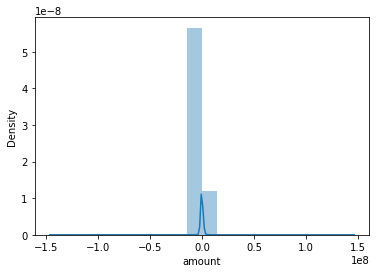

In [16]:
sns.distplot(df['amount'], bins=20);

# Матрица корреляций

In [17]:
df.columns

Index(['tr_datetime', 'mcc_code', 'tr_type', 'amount', 'term_id', 'gender',
       'tr_description', 'mcc_description'],
      dtype='object')

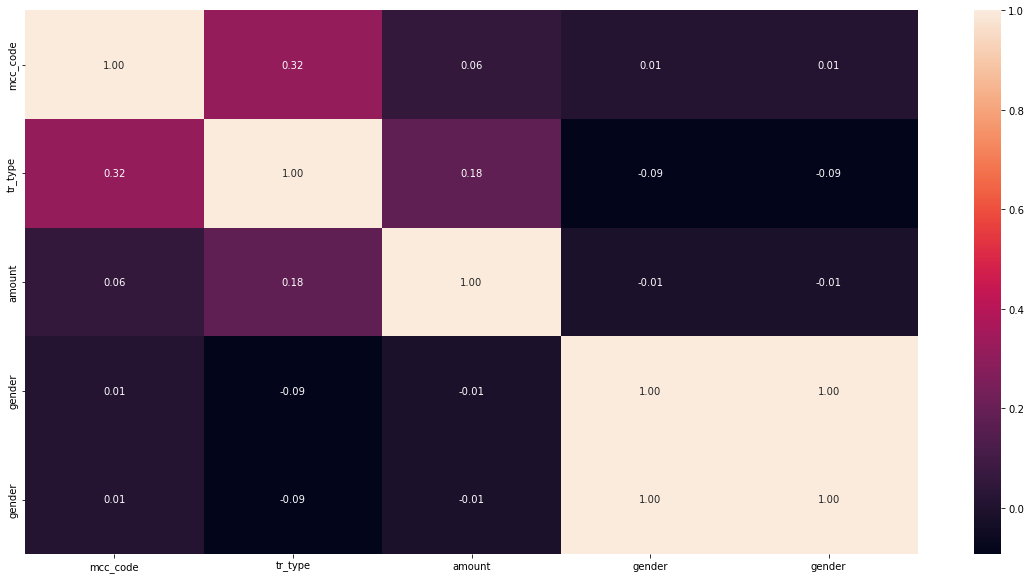

In [18]:
plt.figure(figsize=(20,10))
sns.heatmap(
    pd.concat([df.iloc[:,:20], df['gender']], axis=1).corr(),
    annot=True,
    fmt='.2f');

# Feature Engineering

In [19]:
df

tr_datetime  mcc_code  tr_type    amount   term_id  gender  \
customer_id                                                                
22899          1 15:26:45      4814     1030  -4491.83       NaN     1.0   
22899          2 20:52:48      4814     1030  -2245.92       NaN     1.0   
22899         52 01:13:37      4814     1030  -2245.92       NaN     1.0   
22899         56 10:10:60      4814     1030   -449.18       NaN     1.0   
22899         62 03:54:01      4814     1030  -2245.92       NaN     1.0   
...                   ...       ...      ...       ...       ...     ...   
69407297     417 00:00:00      9211     1100 -13475.49  22697001     0.0   
69407297     425 00:00:00      9211     1100 -22459.16  22697001     0.0   
69407297     431 00:00:00      9211     1100 -22459.16  24436001     0.0   
69407297     445 00:00:00      9211     1100 -17967.33  22697001     0.0   
79541861     451 00:00:00      9211     1100 -22459.16  22697001     0.0   

                             tr_description  \
customer_id                                   
22899        Оплата услуги. Банкоматы СБ РФ   
22899        Оплата услуги. Банкоматы СБ РФ   
22899        Оплата услуги. Банкоматы СБ РФ   
22899        Оплата услуги. Банкоматы СБ РФ   
22899        Оплата услуги. Банкоматы СБ РФ   
...                                     ...   
69407297                Покупка. ТУ  Россия   
69407297                Покупка. ТУ  Россия   
69407297                Покупка. ТУ  Россия   
69407297                Покупка. ТУ  Россия   
79541861                Покупка. ТУ  Россия   

                                               mcc_description  
customer_id                                                     
22899        Звонки с использованием телефонов, считывающих...  
22899        Звонки с использованием телефонов, считывающих...  
22899        Звонки с использованием телефонов, считывающих...  
22899        Звонки с использованием телефонов, считывающих...  
22899        Звонки с использованием телефонов, считывающих...  
...                                                        ...  
69407297     Судовые выплаты, включая алименты и детскую по...  
69407297     Судовые выплаты, включая алименты и детскую по...  
69407297     Судовые выплаты, включая алименты и детскую по...  
69407297     Судовые выплаты, включая алименты и детскую по...  
79541861     Судовые выплаты, включая алименты и детскую по...  

[3729289 rows x 8 columns]

In [20]:
df.columns.tolist()

['tr_datetime',
 'mcc_code',
 'tr_type',
 'amount',
 'term_id',
 'gender',
 'tr_description',
 'mcc_description']

In [21]:
df['earned'] = [0 if i <0 else 1 for i in df['amount']]

In [22]:
df['day'] = pd.DataFrame(df["tr_datetime"].str.split(' ', expand = True)[0]).astype("int64").fillna(0)
df['time'] = pd.DataFrame(df["tr_datetime"].str.split(' ', expand = True)[1].str.split(':', expand = True)[0]).astype("int64")

In [23]:
df['total'] = df.groupby(['customer_id'])["amount"].sum().fillna(0)
df['total_spent'] = df.loc[df['earned'] == 0].groupby(['customer_id'])["amount"].sum().fillna(0)
df['total_earned'] = df.loc[df['earned'] == 1].groupby(['customer_id'])["amount"].sum().fillna(0)

In [24]:
df["avg_amount_per_day"] = df.groupby(['customer_id','day'])["amount"].transform('mean').fillna(0)
df["var_amount_per_day"] = df.groupby(['customer_id','day'])["amount"].transform('std').fillna(0)

In [25]:
df['avg_sum_per_transaction'] = df.groupby(['customer_id'])['amount'].mean().fillna(0)
df['avg_sum_spent_per_transaction'] = df.loc[df['earned'] == 0].groupby(['customer_id'])['amount'].mean().fillna(0)
df['avg_sum_earned_per_transaction'] = df.loc[df['earned'] == 1].groupby(['customer_id'])['amount'].mean().fillna(0)

In [26]:
df['var_sum_per_trans'] = df.groupby(['customer_id'])['amount'].std().fillna(0)
df['var_sum_spent_per_trans'] = df.loc[df['earned'] == 0].groupby(['customer_id'])['amount'].std().fillna(0)
df['var_sum_earned_per_trans'] = df.loc[df['earned'] == 1].groupby(['customer_id'])['amount'].std().fillna(0)

In [27]:
df['transactions_per_day'] = df.groupby([df.index, 'day'])["day"].transform("count").fillna(0)
df['transactions_per_day_spent'] = df.groupby(['customer_id'])["day"].transform(lambda x: x[x < 0].count()).fillna(0)
df['transactions_per_day_earned'] = df.groupby(['customer_id'])["day"].transform(lambda x: x[x > 0].count()).fillna(0)

In [28]:
df["var_amount_per_day"] = df.groupby(['customer_id','day'])['amount'].transform('std').fillna(0)

In [29]:
df['sum_per_day'] = df.groupby([df.index, 'day'])['amount'].transform('sum').fillna(0)
df['sum_per_day_spent'] = df.loc[df['earned'] == 0].groupby([df.index, 'day'])['amount'].sum().fillna(0)
df['sum_per_day_earned'] = df.loc[df['earned'] == 1].groupby([df.index, 'day'])['amount'].sum().fillna(0)

ValueError: Grouper and axis must be same length

In [30]:
df['terminal_unique'] = df.groupby(['customer_id','term_id'])['term_id'].transform('count').fillna(0)

In [31]:
df["var_time_transaction"] = df.groupby(['customer_id'])['time'].transform('std')

In [32]:
df['tr_unique_count'] = df.groupby(['customer_id','tr_type'])['tr_type'].transform('count').fillna(0)
df['tr_unique_sum'] = df.groupby(['customer_id','tr_type'])['tr_type'].transform('sum').fillna(0)
df['tr_unique_std'] = df.groupby(['customer_id','tr_type'])['tr_type'].transform('std').fillna(0)

In [33]:
df['mcc_unique_count'] = df.groupby(['customer_id','mcc_code'])['mcc_code'].transform('count').fillna(0)
df['mcc_unique_sum'] = df.groupby(['customer_id','mcc_code'])['mcc_code'].transform('sum').fillna(0)
df['mcc_unique_std'] = df.groupby(['customer_id','mcc_code'])['mcc_code'].transform('std').fillna(0)

In [34]:
df['tr_unique_count'] = df.groupby(['customer_id','tr_type'])['tr_type'].transform('count').fillna(0)

In [35]:
df["total_amount_spend_to_earn"] = np.divide(df["total_spent"].abs(), df["total_earned"].abs())
df["total_amount_spend_to_earn"].replace(np.inf, 1000, inplace = True)

In [36]:
df = pd.DataFrame(pd.get_dummies(data = df, columns = ['tr_type', 'mcc_code']))

# Группировка по пользователю

In [37]:
df

tr_datetime    amount   term_id  gender  \
customer_id                                             
22899          1 15:26:45  -4491.83       NaN     1.0   
22899          2 20:52:48  -2245.92       NaN     1.0   
22899         52 01:13:37  -2245.92       NaN     1.0   
22899         56 10:10:60   -449.18       NaN     1.0   
22899         62 03:54:01  -2245.92       NaN     1.0   
...                   ...       ...       ...     ...   
69407297     417 00:00:00 -13475.49  22697001     0.0   
69407297     425 00:00:00 -22459.16  22697001     0.0   
69407297     431 00:00:00 -22459.16  24436001     0.0   
69407297     445 00:00:00 -17967.33  22697001     0.0   
79541861     451 00:00:00 -22459.16  22697001     0.0   

                             tr_description  \
customer_id                                   
22899        Оплата услуги. Банкоматы СБ РФ   
22899        Оплата услуги. Банкоматы СБ РФ   
22899        Оплата услуги. Банкоматы СБ РФ   
22899        Оплата услуги. Банкоматы СБ РФ   
22899        Оплата услуги. Банкоматы СБ РФ   
...                                     ...   
69407297                Покупка. ТУ  Россия   
69407297                Покупка. ТУ  Россия   
69407297                Покупка. ТУ  Россия   
69407297                Покупка. ТУ  Россия   
79541861                Покупка. ТУ  Россия   

                                               mcc_description  earned  day  \
customer_id                                                                   
22899        Звонки с использованием телефонов, считывающих...       0    1   
22899        Звонки с использованием телефонов, считывающих...       0    2   
22899        Звонки с использованием телефонов, считывающих...       0   52   
22899        Звонки с использованием телефонов, считывающих...       0   56   
22899        Звонки с использованием телефонов, считывающих...       0   62   
...                                                        ...     ...  ...   
69407297     Судовые выплаты, включая алименты и детскую по...       0  417   
69407297     Судовые выплаты, включая алименты и детскую по...       0  425   
69407297     Судовые выплаты, включая алименты и детскую по...       0  431   
69407297     Судовые выплаты, включая алименты и детскую по...       0  445   
79541861     Судовые выплаты, включая алименты и детскую по...       0  451   

             time        total  ...  mcc_code_8299  mcc_code_8398  \
customer_id                     ...                                 
22899          15   -629796.59  ...              0              0   
22899          20   -629796.59  ...              0              0   
22899           1   -629796.59  ...              0              0   
22899          10   -629796.59  ...              0              0   
22899           3   -629796.59  ...              0              0   
...           ...          ...  ...            ...            ...   
69407297        0 -22184826.80  ...              0              0   
69407297        0 -22184826.80  ...              0              0   
69407297        0 -22184826.80  ...              0              0   
69407297        0 -22184826.80  ...              0              0   
79541861        0   5348758.52  ...              0              0   

             mcc_code_8641  mcc_code_8699  mcc_code_8999  mcc_code_9211  \
customer_id                                                               
22899                    0              0              0              0   
22899                    0              0              0              0   
22899                    0              0              0              0   
22899                    0              0              0              0   
22899                    0              0              0              0   
...                    ...            ...            ...            ...   
69407297                 0              0              0              1   
69407297                 0              0              0   

In [38]:
df_customers = df.groupby(['customer_id']).max()

/tmp/ipykernel_4237/1193397105.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  df_customers = df.groupby(['customer_id']).max()


In [39]:
y = df_customers['gender']
X = df_customers.drop(['gender', 'tr_datetime', 'tr_description', 'mcc_description', 'amount', 'earned'], axis = 1)

In [40]:
X['total_earned'] = X['total_earned'].fillna(0)
X['avg_sum_earned_per_transaction'] = X['avg_sum_earned_per_transaction'].fillna(0)
X['total_spent'] = X['total_spent'].fillna(0)
X['avg_sum_spent_per_transaction'] = X['avg_sum_spent_per_transaction'].fillna(0)
X['var_sum_earned_per_trans'] = X['var_sum_earned_per_trans'].fillna(0)
X['var_sum_spent_per_trans'] = X['var_sum_spent_per_trans'].fillna(0)
X['var_time_transaction'] = X['var_time_transaction'].fillna(0)
X['total_amount_spend_to_earn'] = X['total_amount_spend_to_earn'].fillna(0)
# X['amount'] =  X['amount'].fillna(0)

In [41]:
missing_features(X, X.columns)

# Catboost

In [42]:
cb = CatBoostClassifier(depth= 4, iterations= 25, l2_leaf_reg= 0, learning_rate= 0.5)

In [43]:
cb.fit(X, y)

0:	learn: 0.6144795	total: 50.4ms	remaining: 1.21s
1:	learn: 0.5705278	total: 52.8ms	remaining: 607ms
2:	learn: 0.5463969	total: 54.7ms	remaining: 401ms
3:	learn: 0.5336508	total: 56.7ms	remaining: 298ms
4:	learn: 0.5224160	total: 58.5ms	remaining: 234ms
5:	learn: 0.5127888	total: 64.2ms	remaining: 203ms
6:	learn: 0.5039878	total: 66.4ms	remaining: 171ms
7:	learn: 0.4989859	total: 68.5ms	remaining: 146ms
8:	learn: 0.4944847	total: 70.8ms	remaining: 126ms
9:	learn: 0.4900364	total: 72.8ms	remaining: 109ms
10:	learn: 0.4863253	total: 75ms	remaining: 95.5ms
11:	learn: 0.4809945	total: 79ms	remaining: 85.6ms
12:	learn: 0.4778676	total: 81.7ms	remaining: 75.4ms
13:	learn: 0.4743416	total: 84.3ms	remaining: 66.2ms
14:	learn: 0.4705340	total: 86.4ms	remaining: 57.6ms
15:	learn: 0.4679093	total: 88.5ms	remaining: 49.8ms
16:	learn: 0.4657754	total: 91ms	remaining: 42.8ms
17:	learn: 0.4631989	total: 93.1ms	remaining: 36.2ms
18:	learn: 0.4603746	total: 95.3ms	remaining: 30.1ms
19:	learn: 0.455461

In [44]:
cv_split = KFold(n_splits = 4)

In [45]:
cv_results = cross_validate(cb, X, y, scoring='roc_auc', cv=cv_split, return_train_score=True)

0:	learn: 0.6040622	total: 2.81ms	remaining: 67.4ms
1:	learn: 0.5679964	total: 4.9ms	remaining: 56.3ms
2:	learn: 0.5480481	total: 7.14ms	remaining: 52.4ms
3:	learn: 0.5354948	total: 9.14ms	remaining: 48ms
4:	learn: 0.5227815	total: 11.2ms	remaining: 44.8ms
5:	learn: 0.5138578	total: 16ms	remaining: 50.7ms
6:	learn: 0.5045306	total: 18.4ms	remaining: 47.2ms
7:	learn: 0.4946707	total: 20.2ms	remaining: 43ms
8:	learn: 0.4888053	total: 22ms	remaining: 39.1ms
9:	learn: 0.4843313	total: 24ms	remaining: 36ms
10:	learn: 0.4805582	total: 26.7ms	remaining: 34ms
11:	learn: 0.4765094	total: 28.8ms	remaining: 31.2ms
12:	learn: 0.4735642	total: 31ms	remaining: 28.6ms
13:	learn: 0.4700196	total: 33.3ms	remaining: 26.2ms
14:	learn: 0.4672217	total: 35.5ms	remaining: 23.7ms
15:	learn: 0.4642628	total: 37.4ms	remaining: 21ms
16:	learn: 0.4611051	total: 39.2ms	remaining: 18.5ms
17:	learn: 0.4581923	total: 41ms	remaining: 15.9ms
18:	learn: 0.4552894	total: 42.8ms	remaining: 13.5ms
19:	learn: 0.4518500	tot

In [46]:
cv_results

{'fit_time': array([0.08278179, 0.07980824, 0.07946658, 0.07928443]),
 'score_time': array([0.01371813, 0.01257277, 0.01166773, 0.01045752]),
 'test_score': array([0.83865366, 0.84730301, 0.83865185, 0.83550183]),
 'train_score': array([0.88471321, 0.88167091, 0.8878703 , 0.88480921])}

In [47]:
cv_results['test_score'].mean()

0.8400275885598307

# Grid Search

In [77]:
params = {
    'iterations': [5,10,15,20,25,30],
    'learning_rate': [0.5, 0.1, 0.05, 0.01],
    'l2_leaf_reg': [0.5, 0.1, 0.05, 0.01],
    'depth': [None,1,2,3,4,5],
    'l2_leaf_reg': [0,0.1,0.01]
}

cb_cv = GridSearchCV(cb, param_grid=params, scoring='roc_auc', cv=5)

In [78]:
cb_cv.fit(X, y)

0:	learn: 0.5944855	total: 4.58ms	remaining: 18.3ms
1:	learn: 0.5515131	total: 9.14ms	remaining: 13.7ms
2:	learn: 0.5323848	total: 14.3ms	remaining: 9.53ms
3:	learn: 0.5177364	total: 18.5ms	remaining: 4.62ms
4:	learn: 0.5005642	total: 22.4ms	remaining: 0us
0:	learn: 0.5965942	total: 3.71ms	remaining: 14.8ms
1:	learn: 0.5513409	total: 7.28ms	remaining: 10.9ms
2:	learn: 0.5301890	total: 10.9ms	remaining: 7.29ms
3:	learn: 0.5135876	total: 14.6ms	remaining: 3.65ms
4:	learn: 0.4977727	total: 17.9ms	remaining: 0us
0:	learn: 0.6026720	total: 3.79ms	remaining: 15.2ms
1:	learn: 0.5645453	total: 7.4ms	remaining: 11.1ms
2:	learn: 0.5369795	total: 10.9ms	remaining: 7.29ms
3:	learn: 0.5167901	total: 14.6ms	remaining: 3.64ms
4:	learn: 0.5089690	total: 18.2ms	remaining: 0us
0:	learn: 0.5934446	total: 3.81ms	remaining: 15.2ms
1:	learn: 0.5595288	total: 7.34ms	remaining: 11ms
2:	learn: 0.5322191	total: 10.9ms	remaining: 7.24ms
3:	learn: 0.5172845	total: 14.3ms	remaining: 3.57ms
4:	learn: 0.5025418	tota

0:	learn: 0.6902274	total: 4.11ms	remaining: 16.4ms
1:	learn: 0.6873824	total: 8.49ms	remaining: 12.7ms
2:	learn: 0.6842707	total: 12.9ms	remaining: 8.62ms
3:	learn: 0.6817222	total: 17ms	remaining: 4.25ms
4:	learn: 0.6796082	total: 21.2ms	remaining: 0us
0:	learn: 0.6902845	total: 4.8ms	remaining: 19.2ms
1:	learn: 0.6874111	total: 8.64ms	remaining: 13ms
2:	learn: 0.6848371	total: 12.2ms	remaining: 8.14ms
3:	learn: 0.6821381	total: 15.9ms	remaining: 3.96ms
4:	learn: 0.6793849	total: 19.7ms	remaining: 0us
0:	learn: 0.6905195	total: 3.9ms	remaining: 15.6ms
1:	learn: 0.6880779	total: 7.56ms	remaining: 11.3ms
2:	learn: 0.6852881	total: 11.2ms	remaining: 7.45ms
3:	learn: 0.6829224	total: 15ms	remaining: 3.74ms
4:	learn: 0.6806148	total: 18.7ms	remaining: 0us
0:	learn: 0.6902331	total: 3.88ms	remaining: 15.5ms
1:	learn: 0.6876701	total: 7.46ms	remaining: 11.2ms
2:	learn: 0.6846721	total: 11.2ms	remaining: 7.43ms
3:	learn: 0.6819933	total: 15ms	remaining: 3.75ms
4:	learn: 0.6791470	total: 18.5

0:	learn: 0.6647204	total: 4.17ms	remaining: 37.6ms
1:	learn: 0.6429082	total: 9.12ms	remaining: 36.5ms
2:	learn: 0.6204283	total: 14.4ms	remaining: 33.6ms
3:	learn: 0.6088658	total: 18.9ms	remaining: 28.3ms
4:	learn: 0.5963930	total: 23.3ms	remaining: 23.3ms
5:	learn: 0.5854319	total: 27.7ms	remaining: 18.5ms
6:	learn: 0.5751408	total: 33.1ms	remaining: 14.2ms
7:	learn: 0.5667173	total: 37.4ms	remaining: 9.35ms
8:	learn: 0.5599017	total: 42.2ms	remaining: 4.69ms
9:	learn: 0.5515879	total: 46.4ms	remaining: 0us
0:	learn: 0.6646763	total: 3.69ms	remaining: 33.3ms
1:	learn: 0.6413797	total: 7.3ms	remaining: 29.2ms
2:	learn: 0.6239037	total: 10.9ms	remaining: 25.4ms
3:	learn: 0.6090833	total: 14.4ms	remaining: 21.6ms
4:	learn: 0.5948048	total: 18.7ms	remaining: 18.7ms
5:	learn: 0.5833277	total: 22.2ms	remaining: 14.8ms
6:	learn: 0.5750956	total: 25.8ms	remaining: 11.1ms
7:	learn: 0.5682079	total: 29.3ms	remaining: 7.31ms
8:	learn: 0.5609686	total: 32.8ms	remaining: 3.64ms
9:	learn: 0.5522

0:	learn: 0.5971096	total: 4.1ms	remaining: 36.9ms
1:	learn: 0.5520020	total: 8.07ms	remaining: 32.3ms
2:	learn: 0.5293087	total: 12.2ms	remaining: 28.5ms
3:	learn: 0.5123395	total: 16.7ms	remaining: 25ms
4:	learn: 0.4986610	total: 20.5ms	remaining: 20.5ms
5:	learn: 0.4909780	total: 24.2ms	remaining: 16.1ms
6:	learn: 0.4820924	total: 28.4ms	remaining: 12.2ms
7:	learn: 0.4773793	total: 32.1ms	remaining: 8.02ms
8:	learn: 0.4722126	total: 35.7ms	remaining: 3.96ms
9:	learn: 0.4640252	total: 39.5ms	remaining: 0us
0:	learn: 0.6029735	total: 3.94ms	remaining: 35.4ms
1:	learn: 0.5649251	total: 7.55ms	remaining: 30.2ms
2:	learn: 0.5373675	total: 11.1ms	remaining: 25.8ms
3:	learn: 0.5173163	total: 14.6ms	remaining: 21.8ms
4:	learn: 0.5057648	total: 18ms	remaining: 18ms
5:	learn: 0.4930894	total: 21.4ms	remaining: 14.3ms
6:	learn: 0.4815790	total: 24.9ms	remaining: 10.7ms
7:	learn: 0.4756036	total: 28.3ms	remaining: 7.08ms
8:	learn: 0.4674844	total: 31.9ms	remaining: 3.54ms
9:	learn: 0.4597037	to

0:	learn: 0.6906108	total: 4ms	remaining: 36ms
1:	learn: 0.6880199	total: 8.26ms	remaining: 33ms
2:	learn: 0.6853073	total: 12.7ms	remaining: 29.5ms
3:	learn: 0.6828490	total: 16.5ms	remaining: 24.8ms
4:	learn: 0.6802311	total: 20.9ms	remaining: 20.9ms
5:	learn: 0.6776430	total: 24.7ms	remaining: 16.5ms
6:	learn: 0.6753443	total: 28.4ms	remaining: 12.2ms
7:	learn: 0.6728098	total: 32.3ms	remaining: 8.07ms
8:	learn: 0.6705183	total: 35.9ms	remaining: 3.98ms
9:	learn: 0.6683518	total: 39.6ms	remaining: 0us
0:	learn: 0.5946050	total: 3.88ms	remaining: 34.9ms
1:	learn: 0.5500566	total: 7.55ms	remaining: 30.2ms
2:	learn: 0.5280507	total: 11.1ms	remaining: 26ms
3:	learn: 0.5118800	total: 14.6ms	remaining: 21.9ms
4:	learn: 0.4973031	total: 18.2ms	remaining: 18.2ms
5:	learn: 0.4862749	total: 21.7ms	remaining: 14.5ms
6:	learn: 0.4765052	total: 25.4ms	remaining: 10.9ms
7:	learn: 0.4665501	total: 28.9ms	remaining: 7.22ms
8:	learn: 0.4607055	total: 32.5ms	remaining: 3.61ms
9:	learn: 0.4535697	tota

0:	learn: 0.6904659	total: 3.69ms	remaining: 33.2ms
1:	learn: 0.6879751	total: 7.8ms	remaining: 31.2ms
2:	learn: 0.6851105	total: 11.4ms	remaining: 26.5ms
3:	learn: 0.6827261	total: 14.9ms	remaining: 22.4ms
4:	learn: 0.6804084	total: 18.4ms	remaining: 18.4ms
5:	learn: 0.6779518	total: 22ms	remaining: 14.7ms
6:	learn: 0.6751304	total: 25.7ms	remaining: 11ms
7:	learn: 0.6726458	total: 29.1ms	remaining: 7.28ms
8:	learn: 0.6703395	total: 32.6ms	remaining: 3.63ms
9:	learn: 0.6679326	total: 36.2ms	remaining: 0us
0:	learn: 0.6902042	total: 3.72ms	remaining: 33.5ms
1:	learn: 0.6876240	total: 7.29ms	remaining: 29.2ms
2:	learn: 0.6845382	total: 10.7ms	remaining: 25.1ms
3:	learn: 0.6818437	total: 14.2ms	remaining: 21.3ms
4:	learn: 0.6789494	total: 17.8ms	remaining: 17.8ms
5:	learn: 0.6763251	total: 21.3ms	remaining: 14.2ms
6:	learn: 0.6736723	total: 24.8ms	remaining: 10.6ms
7:	learn: 0.6710358	total: 28.3ms	remaining: 7.08ms
8:	learn: 0.6685915	total: 31.9ms	remaining: 3.54ms
9:	learn: 0.6660495	

8:	learn: 0.6040523	total: 34.2ms	remaining: 22.8ms
9:	learn: 0.5977158	total: 38.3ms	remaining: 19.2ms
10:	learn: 0.5915668	total: 42.3ms	remaining: 15.4ms
11:	learn: 0.5861908	total: 46.5ms	remaining: 11.6ms
12:	learn: 0.5801418	total: 50.9ms	remaining: 7.83ms
13:	learn: 0.5756470	total: 54.8ms	remaining: 3.91ms
14:	learn: 0.5710844	total: 59ms	remaining: 0us
0:	learn: 0.6781153	total: 3.78ms	remaining: 52.9ms
1:	learn: 0.6647699	total: 7.33ms	remaining: 47.7ms
2:	learn: 0.6543857	total: 11ms	remaining: 43.9ms
3:	learn: 0.6440441	total: 14.5ms	remaining: 39.8ms
4:	learn: 0.6348485	total: 17.9ms	remaining: 35.8ms
5:	learn: 0.6261771	total: 21.5ms	remaining: 32.3ms
6:	learn: 0.6185179	total: 24.9ms	remaining: 28.5ms
7:	learn: 0.6105929	total: 28.4ms	remaining: 24.8ms
8:	learn: 0.6034308	total: 32ms	remaining: 21.3ms
9:	learn: 0.5964207	total: 35.5ms	remaining: 17.7ms
10:	learn: 0.5905749	total: 39ms	remaining: 14.2ms
11:	learn: 0.5854062	total: 42.5ms	remaining: 10.6ms
12:	learn: 0.580

5:	learn: 0.4933299	total: 22ms	remaining: 33ms
6:	learn: 0.4837290	total: 26.2ms	remaining: 29.9ms
7:	learn: 0.4754731	total: 30.2ms	remaining: 26.4ms
8:	learn: 0.4681489	total: 34.1ms	remaining: 22.8ms
9:	learn: 0.4612035	total: 38.3ms	remaining: 19.1ms
10:	learn: 0.4548066	total: 42.5ms	remaining: 15.5ms
11:	learn: 0.4481394	total: 46.5ms	remaining: 11.6ms
12:	learn: 0.4414083	total: 50.2ms	remaining: 7.72ms
13:	learn: 0.4384309	total: 54.4ms	remaining: 3.89ms
14:	learn: 0.4359129	total: 58.4ms	remaining: 0us
0:	learn: 0.6058278	total: 3.83ms	remaining: 53.6ms
1:	learn: 0.5645725	total: 7.56ms	remaining: 49.2ms
2:	learn: 0.5394866	total: 11.3ms	remaining: 45ms
3:	learn: 0.5210994	total: 14.8ms	remaining: 40.7ms
4:	learn: 0.5095008	total: 18.3ms	remaining: 36.5ms
5:	learn: 0.4984204	total: 21.9ms	remaining: 32.8ms
6:	learn: 0.4888363	total: 25.2ms	remaining: 28.8ms
7:	learn: 0.4787936	total: 28.8ms	remaining: 25.2ms
8:	learn: 0.4689430	total: 32.3ms	remaining: 21.6ms
9:	learn: 0.4612

13:	learn: 0.5832898	total: 65.2ms	remaining: 4.65ms
14:	learn: 0.5786804	total: 69.4ms	remaining: 0us
0:	learn: 0.6902274	total: 5.32ms	remaining: 74.4ms
1:	learn: 0.6873824	total: 9.66ms	remaining: 62.8ms
2:	learn: 0.6842707	total: 14.3ms	remaining: 57.2ms
3:	learn: 0.6817222	total: 18.7ms	remaining: 51.4ms
4:	learn: 0.6796082	total: 23.9ms	remaining: 47.8ms
5:	learn: 0.6771170	total: 27.9ms	remaining: 41.9ms
6:	learn: 0.6747093	total: 32ms	remaining: 36.5ms
7:	learn: 0.6723499	total: 36.4ms	remaining: 31.8ms
8:	learn: 0.6699739	total: 40.8ms	remaining: 27.2ms
9:	learn: 0.6675738	total: 44.7ms	remaining: 22.4ms
10:	learn: 0.6653362	total: 49ms	remaining: 17.8ms
11:	learn: 0.6631918	total: 53.2ms	remaining: 13.3ms
12:	learn: 0.6611201	total: 58.7ms	remaining: 9.03ms
13:	learn: 0.6590155	total: 63.7ms	remaining: 4.55ms
14:	learn: 0.6569147	total: 67.9ms	remaining: 0us
0:	learn: 0.6902845	total: 3.79ms	remaining: 53.1ms
1:	learn: 0.6874111	total: 7.3ms	remaining: 47.5ms
2:	learn: 0.6848

2:	learn: 0.6252760	total: 14.3ms	remaining: 57ms
3:	learn: 0.6106463	total: 18.5ms	remaining: 51ms
4:	learn: 0.5956459	total: 22.8ms	remaining: 45.6ms
5:	learn: 0.5842933	total: 26.7ms	remaining: 40.1ms
6:	learn: 0.5761305	total: 31ms	remaining: 35.5ms
7:	learn: 0.5675786	total: 35.1ms	remaining: 30.7ms
8:	learn: 0.5608633	total: 40.1ms	remaining: 26.7ms
9:	learn: 0.5527431	total: 44.3ms	remaining: 22.2ms
10:	learn: 0.5466338	total: 48.2ms	remaining: 17.5ms
11:	learn: 0.5413417	total: 52ms	remaining: 13ms
12:	learn: 0.5364088	total: 56.4ms	remaining: 8.68ms
13:	learn: 0.5331468	total: 60.7ms	remaining: 4.34ms
14:	learn: 0.5282731	total: 64.8ms	remaining: 0us
0:	learn: 0.6680846	total: 4.18ms	remaining: 58.6ms
1:	learn: 0.6498808	total: 8.51ms	remaining: 55.3ms
2:	learn: 0.6305320	total: 12.8ms	remaining: 51.2ms
3:	learn: 0.6173379	total: 16.7ms	remaining: 45.9ms
4:	learn: 0.6089550	total: 20.3ms	remaining: 40.5ms
5:	learn: 0.5980165	total: 25.2ms	remaining: 37.8ms
6:	learn: 0.5889732	

0:	learn: 0.6902042	total: 4.59ms	remaining: 64.3ms
1:	learn: 0.6876240	total: 8.77ms	remaining: 57ms
2:	learn: 0.6845382	total: 13ms	remaining: 52.1ms
3:	learn: 0.6818437	total: 17.6ms	remaining: 48.5ms
4:	learn: 0.6789494	total: 22.1ms	remaining: 44.3ms
5:	learn: 0.6763251	total: 26.9ms	remaining: 40.4ms
6:	learn: 0.6736723	total: 30.8ms	remaining: 35.2ms
7:	learn: 0.6710358	total: 34.6ms	remaining: 30.3ms
8:	learn: 0.6685915	total: 38.1ms	remaining: 25.4ms
9:	learn: 0.6660495	total: 42.1ms	remaining: 21.1ms
10:	learn: 0.6634266	total: 46.3ms	remaining: 16.9ms
11:	learn: 0.6613068	total: 49.9ms	remaining: 12.5ms
12:	learn: 0.6589281	total: 53.4ms	remaining: 8.22ms
13:	learn: 0.6572205	total: 56.9ms	remaining: 4.06ms
14:	learn: 0.6552252	total: 60.4ms	remaining: 0us
0:	learn: 0.6905840	total: 3.79ms	remaining: 53ms
1:	learn: 0.6879731	total: 7.45ms	remaining: 48.4ms
2:	learn: 0.6852257	total: 11.1ms	remaining: 44.2ms
3:	learn: 0.6827299	total: 14.6ms	remaining: 40.2ms
4:	learn: 0.6800

0:	learn: 0.6675363	total: 4.15ms	remaining: 78.8ms
1:	learn: 0.6467522	total: 8.65ms	remaining: 77.8ms
2:	learn: 0.6275688	total: 12.3ms	remaining: 69.5ms
3:	learn: 0.6112876	total: 16.2ms	remaining: 64.8ms
4:	learn: 0.5996371	total: 20.9ms	remaining: 62.8ms
5:	learn: 0.5893842	total: 24.8ms	remaining: 57.9ms
6:	learn: 0.5792058	total: 28.6ms	remaining: 53.1ms
7:	learn: 0.5687602	total: 32.4ms	remaining: 48.5ms
8:	learn: 0.5598174	total: 35.9ms	remaining: 43.9ms
9:	learn: 0.5529332	total: 39.4ms	remaining: 39.4ms
10:	learn: 0.5471321	total: 42.9ms	remaining: 35.1ms
11:	learn: 0.5420368	total: 46.5ms	remaining: 31ms
12:	learn: 0.5365757	total: 50ms	remaining: 26.9ms
13:	learn: 0.5318029	total: 53.6ms	remaining: 23ms
14:	learn: 0.5270270	total: 57.4ms	remaining: 19.1ms
15:	learn: 0.5219565	total: 61ms	remaining: 15.3ms
16:	learn: 0.5183309	total: 64.4ms	remaining: 11.4ms
17:	learn: 0.5135503	total: 68ms	remaining: 7.55ms
18:	learn: 0.5097796	total: 71.5ms	remaining: 3.76ms
19:	learn: 0.

0:	learn: 0.6900082	total: 4.12ms	remaining: 78.2ms
1:	learn: 0.6870379	total: 8.21ms	remaining: 73.9ms
2:	learn: 0.6842893	total: 12.1ms	remaining: 68.6ms
3:	learn: 0.6814613	total: 16ms	remaining: 63.9ms
4:	learn: 0.6785162	total: 20.2ms	remaining: 60.6ms
5:	learn: 0.6755671	total: 24.3ms	remaining: 56.8ms
6:	learn: 0.6731463	total: 28.2ms	remaining: 52.4ms
7:	learn: 0.6706425	total: 31.7ms	remaining: 47.6ms
8:	learn: 0.6679898	total: 35.3ms	remaining: 43.2ms
9:	learn: 0.6652746	total: 38.8ms	remaining: 38.8ms
10:	learn: 0.6629779	total: 42.4ms	remaining: 34.7ms
11:	learn: 0.6606173	total: 45.9ms	remaining: 30.6ms
12:	learn: 0.6584472	total: 49.5ms	remaining: 26.7ms
13:	learn: 0.6562818	total: 53ms	remaining: 22.7ms
14:	learn: 0.6538493	total: 56.7ms	remaining: 18.9ms
15:	learn: 0.6516549	total: 60.2ms	remaining: 15.1ms
16:	learn: 0.6493966	total: 63.7ms	remaining: 11.2ms
17:	learn: 0.6474436	total: 67.2ms	remaining: 7.46ms
18:	learn: 0.6452051	total: 70.5ms	remaining: 3.71ms
19:	lea

0:	learn: 0.6058278	total: 4.19ms	remaining: 79.6ms
1:	learn: 0.5645725	total: 8.54ms	remaining: 76.8ms
2:	learn: 0.5394866	total: 12.8ms	remaining: 72.5ms
3:	learn: 0.5210994	total: 16.3ms	remaining: 65.2ms
4:	learn: 0.5095008	total: 20.5ms	remaining: 61.6ms
5:	learn: 0.4984204	total: 24.3ms	remaining: 56.7ms
6:	learn: 0.4888363	total: 28ms	remaining: 51.9ms
7:	learn: 0.4787936	total: 31.8ms	remaining: 47.7ms
8:	learn: 0.4689430	total: 35.4ms	remaining: 43.3ms
9:	learn: 0.4612811	total: 39.2ms	remaining: 39.2ms
10:	learn: 0.4540893	total: 42.8ms	remaining: 35.1ms
11:	learn: 0.4493010	total: 46.4ms	remaining: 31ms
12:	learn: 0.4452820	total: 50.1ms	remaining: 27ms
13:	learn: 0.4417761	total: 53.8ms	remaining: 23.1ms
14:	learn: 0.4388416	total: 57.4ms	remaining: 19.1ms
15:	learn: 0.4346044	total: 61ms	remaining: 15.3ms
16:	learn: 0.4294359	total: 64.4ms	remaining: 11.4ms
17:	learn: 0.4258254	total: 67.9ms	remaining: 7.54ms
18:	learn: 0.4218298	total: 71.5ms	remaining: 3.76ms
19:	learn: 

0:	learn: 0.6803555	total: 4.02ms	remaining: 76.3ms
1:	learn: 0.6695017	total: 8.24ms	remaining: 74.1ms
2:	learn: 0.6575470	total: 12.5ms	remaining: 70.8ms
3:	learn: 0.6466492	total: 16.2ms	remaining: 65ms
4:	learn: 0.6386620	total: 19.7ms	remaining: 59.2ms
5:	learn: 0.6312773	total: 23.9ms	remaining: 55.7ms
6:	learn: 0.6240972	total: 27.5ms	remaining: 51ms
7:	learn: 0.6162618	total: 31ms	remaining: 46.5ms
8:	learn: 0.6089596	total: 34.4ms	remaining: 42ms
9:	learn: 0.6026762	total: 37.9ms	remaining: 37.9ms
10:	learn: 0.5963744	total: 41.5ms	remaining: 33.9ms
11:	learn: 0.5912366	total: 45ms	remaining: 30ms
12:	learn: 0.5862528	total: 48.6ms	remaining: 26.2ms
13:	learn: 0.5818782	total: 52ms	remaining: 22.3ms
14:	learn: 0.5778742	total: 55.7ms	remaining: 18.6ms
15:	learn: 0.5736387	total: 59.3ms	remaining: 14.8ms
16:	learn: 0.5695779	total: 62.8ms	remaining: 11.1ms
17:	learn: 0.5659601	total: 66.3ms	remaining: 7.36ms
18:	learn: 0.5623927	total: 69.8ms	remaining: 3.67ms
19:	learn: 0.5589

0:	learn: 0.5946050	total: 4.25ms	remaining: 80.7ms
1:	learn: 0.5500566	total: 8.85ms	remaining: 79.6ms
2:	learn: 0.5280507	total: 13.7ms	remaining: 77.9ms
3:	learn: 0.5118800	total: 17.6ms	remaining: 70.6ms
4:	learn: 0.4973031	total: 21.4ms	remaining: 64.2ms
5:	learn: 0.4862749	total: 25.1ms	remaining: 58.6ms
6:	learn: 0.4765052	total: 29.1ms	remaining: 54.1ms
7:	learn: 0.4665501	total: 32.9ms	remaining: 49.4ms
8:	learn: 0.4607055	total: 36.6ms	remaining: 44.7ms
9:	learn: 0.4535697	total: 40.3ms	remaining: 40.3ms
10:	learn: 0.4471556	total: 44.1ms	remaining: 36ms
11:	learn: 0.4410706	total: 47.7ms	remaining: 31.8ms
12:	learn: 0.4334088	total: 51.1ms	remaining: 27.5ms
13:	learn: 0.4288733	total: 54.6ms	remaining: 23.4ms
14:	learn: 0.4242563	total: 58.1ms	remaining: 19.4ms
15:	learn: 0.4206570	total: 61.7ms	remaining: 15.4ms
16:	learn: 0.4163340	total: 65.4ms	remaining: 11.5ms
17:	learn: 0.4106008	total: 69.1ms	remaining: 7.67ms
18:	learn: 0.4033675	total: 72.7ms	remaining: 3.83ms
19:	l

0:	learn: 0.6656003	total: 4.27ms	remaining: 81.2ms
1:	learn: 0.6467715	total: 9.07ms	remaining: 81.6ms
2:	learn: 0.6266788	total: 13.5ms	remaining: 76.4ms
3:	learn: 0.6092133	total: 17.5ms	remaining: 69.8ms
4:	learn: 0.5962716	total: 21ms	remaining: 62.9ms
5:	learn: 0.5864702	total: 24.5ms	remaining: 57.2ms
6:	learn: 0.5759998	total: 28.1ms	remaining: 52.3ms
7:	learn: 0.5675636	total: 31.8ms	remaining: 47.7ms
8:	learn: 0.5597037	total: 35.3ms	remaining: 43.2ms
9:	learn: 0.5528333	total: 38.9ms	remaining: 38.9ms
10:	learn: 0.5461276	total: 42.4ms	remaining: 34.7ms
11:	learn: 0.5402469	total: 46.1ms	remaining: 30.7ms
12:	learn: 0.5352343	total: 49.6ms	remaining: 26.7ms
13:	learn: 0.5316065	total: 53.1ms	remaining: 22.8ms
14:	learn: 0.5284929	total: 56.6ms	remaining: 18.9ms
15:	learn: 0.5252283	total: 60.1ms	remaining: 15ms
16:	learn: 0.5213703	total: 63.7ms	remaining: 11.2ms
17:	learn: 0.5183997	total: 67.1ms	remaining: 7.46ms
18:	learn: 0.5144674	total: 70.7ms	remaining: 3.72ms
19:	lea

0:	learn: 0.6901810	total: 4.18ms	remaining: 79.5ms
1:	learn: 0.6872726	total: 8.71ms	remaining: 78.4ms
2:	learn: 0.6846381	total: 12.8ms	remaining: 72.3ms
3:	learn: 0.6818380	total: 17.3ms	remaining: 69ms
4:	learn: 0.6790120	total: 20.9ms	remaining: 62.7ms
5:	learn: 0.6761762	total: 24.4ms	remaining: 56.8ms
6:	learn: 0.6738678	total: 27.9ms	remaining: 51.8ms
7:	learn: 0.6713872	total: 31.5ms	remaining: 47.3ms
8:	learn: 0.6687731	total: 35.1ms	remaining: 42.9ms
9:	learn: 0.6661689	total: 38.7ms	remaining: 38.7ms
10:	learn: 0.6639426	total: 42.1ms	remaining: 34.5ms
11:	learn: 0.6616426	total: 45.7ms	remaining: 30.4ms
12:	learn: 0.6594956	total: 49.2ms	remaining: 26.5ms
13:	learn: 0.6573773	total: 52.8ms	remaining: 22.6ms
14:	learn: 0.6549996	total: 56.3ms	remaining: 18.8ms
15:	learn: 0.6528991	total: 59.9ms	remaining: 15ms
16:	learn: 0.6509274	total: 63.4ms	remaining: 11.2ms
17:	learn: 0.6490531	total: 66.9ms	remaining: 7.43ms
18:	learn: 0.6468636	total: 70.4ms	remaining: 3.71ms
19:	lea

8:	learn: 0.4651296	total: 32.8ms	remaining: 58.2ms
9:	learn: 0.4566671	total: 37ms	remaining: 55.5ms
10:	learn: 0.4498753	total: 41ms	remaining: 52.2ms
11:	learn: 0.4427952	total: 44.9ms	remaining: 48.6ms
12:	learn: 0.4387032	total: 49.2ms	remaining: 45.4ms
13:	learn: 0.4341567	total: 52.9ms	remaining: 41.6ms
14:	learn: 0.4320330	total: 56.9ms	remaining: 38ms
15:	learn: 0.4273560	total: 61.4ms	remaining: 34.5ms
16:	learn: 0.4220495	total: 65.4ms	remaining: 30.8ms
17:	learn: 0.4160132	total: 69ms	remaining: 26.8ms
18:	learn: 0.4101413	total: 72.7ms	remaining: 22.9ms
19:	learn: 0.4040815	total: 76.3ms	remaining: 19.1ms
20:	learn: 0.3984771	total: 80ms	remaining: 15.2ms
21:	learn: 0.3931433	total: 83.5ms	remaining: 11.4ms
22:	learn: 0.3884168	total: 87ms	remaining: 7.57ms
23:	learn: 0.3828981	total: 90.7ms	remaining: 3.78ms
24:	learn: 0.3764298	total: 94.3ms	remaining: 0us
0:	learn: 0.6056434	total: 3.84ms	remaining: 92.1ms
1:	learn: 0.5641901	total: 7.54ms	remaining: 86.7ms
2:	learn: 0.

0:	learn: 0.6782310	total: 4.89ms	remaining: 117ms
1:	learn: 0.6658186	total: 9.28ms	remaining: 107ms
2:	learn: 0.6517059	total: 13ms	remaining: 95.3ms
3:	learn: 0.6432465	total: 16.7ms	remaining: 87.7ms
4:	learn: 0.6336339	total: 20.4ms	remaining: 81.5ms
5:	learn: 0.6253968	total: 24.1ms	remaining: 76.2ms
6:	learn: 0.6177427	total: 27.8ms	remaining: 71.4ms
7:	learn: 0.6104657	total: 31.4ms	remaining: 66.8ms
8:	learn: 0.6040523	total: 35.1ms	remaining: 62.4ms
9:	learn: 0.5977158	total: 38.7ms	remaining: 58ms
10:	learn: 0.5915668	total: 42.2ms	remaining: 53.7ms
11:	learn: 0.5861908	total: 45.9ms	remaining: 49.7ms
12:	learn: 0.5801418	total: 49.5ms	remaining: 45.7ms
13:	learn: 0.5756470	total: 53ms	remaining: 41.7ms
14:	learn: 0.5710844	total: 56.8ms	remaining: 37.8ms
15:	learn: 0.5671988	total: 60.5ms	remaining: 34ms
16:	learn: 0.5630916	total: 64.2ms	remaining: 30.2ms
17:	learn: 0.5600514	total: 67.9ms	remaining: 26.4ms
18:	learn: 0.5570940	total: 71.6ms	remaining: 22.6ms
19:	learn: 0.

21:	learn: 0.6391992	total: 79.5ms	remaining: 10.8ms
22:	learn: 0.6370342	total: 83.6ms	remaining: 7.27ms
23:	learn: 0.6350497	total: 87.5ms	remaining: 3.64ms
24:	learn: 0.6333669	total: 91.8ms	remaining: 0us
0:	learn: 0.6903729	total: 3.77ms	remaining: 90.5ms
1:	learn: 0.6877864	total: 7.44ms	remaining: 85.6ms
2:	learn: 0.6848083	total: 11ms	remaining: 80.7ms
3:	learn: 0.6823896	total: 14.6ms	remaining: 76.6ms
4:	learn: 0.6800449	total: 18.2ms	remaining: 72.9ms
5:	learn: 0.6775231	total: 21.7ms	remaining: 68.8ms
6:	learn: 0.6749555	total: 25.1ms	remaining: 64.6ms
7:	learn: 0.6723951	total: 28.7ms	remaining: 61.1ms
8:	learn: 0.6699906	total: 32.4ms	remaining: 57.6ms
9:	learn: 0.6675504	total: 35.9ms	remaining: 53.9ms
10:	learn: 0.6648020	total: 39.4ms	remaining: 50.1ms
11:	learn: 0.6624509	total: 42.9ms	remaining: 46.5ms
12:	learn: 0.6601755	total: 46.4ms	remaining: 42.9ms
13:	learn: 0.6580303	total: 50ms	remaining: 39.3ms
14:	learn: 0.6557876	total: 53.5ms	remaining: 35.6ms
15:	learn:

6:	learn: 0.4837290	total: 25.8ms	remaining: 66.4ms
7:	learn: 0.4754731	total: 30.1ms	remaining: 64ms
8:	learn: 0.4681489	total: 34.4ms	remaining: 61.1ms
9:	learn: 0.4612035	total: 38.6ms	remaining: 58ms
10:	learn: 0.4548066	total: 43.1ms	remaining: 54.9ms
11:	learn: 0.4481394	total: 47.1ms	remaining: 51ms
12:	learn: 0.4414083	total: 51.1ms	remaining: 47.1ms
13:	learn: 0.4384309	total: 55.1ms	remaining: 43.3ms
14:	learn: 0.4359129	total: 59ms	remaining: 39.4ms
15:	learn: 0.4303931	total: 62.9ms	remaining: 35.4ms
16:	learn: 0.4257684	total: 66.6ms	remaining: 31.3ms
17:	learn: 0.4211090	total: 70.4ms	remaining: 27.4ms
18:	learn: 0.4165492	total: 73.9ms	remaining: 23.3ms
19:	learn: 0.4106184	total: 77.5ms	remaining: 19.4ms
20:	learn: 0.4057715	total: 81.2ms	remaining: 15.5ms
21:	learn: 0.3994930	total: 84.7ms	remaining: 11.5ms
22:	learn: 0.3927675	total: 88.2ms	remaining: 7.67ms
23:	learn: 0.3877590	total: 91.8ms	remaining: 3.83ms
24:	learn: 0.3824899	total: 95.6ms	remaining: 0us
0:	learn

0:	learn: 0.6789588	total: 3.85ms	remaining: 92.4ms
1:	learn: 0.6667098	total: 7.76ms	remaining: 89.2ms
2:	learn: 0.6542403	total: 11.4ms	remaining: 83.9ms
3:	learn: 0.6460340	total: 15.1ms	remaining: 79.3ms
4:	learn: 0.6365696	total: 18.7ms	remaining: 74.9ms
5:	learn: 0.6286235	total: 22.3ms	remaining: 70.5ms
6:	learn: 0.6211109	total: 25.8ms	remaining: 66.4ms
7:	learn: 0.6138878	total: 29.5ms	remaining: 62.7ms
8:	learn: 0.6075679	total: 33.1ms	remaining: 58.8ms
9:	learn: 0.6016453	total: 36.8ms	remaining: 55.2ms
10:	learn: 0.5961895	total: 40.6ms	remaining: 51.7ms
11:	learn: 0.5908190	total: 44.4ms	remaining: 48.1ms
12:	learn: 0.5848998	total: 48.1ms	remaining: 44.4ms
13:	learn: 0.5804301	total: 51.7ms	remaining: 40.6ms
14:	learn: 0.5760494	total: 55.3ms	remaining: 36.9ms
15:	learn: 0.5725112	total: 59ms	remaining: 33.2ms
16:	learn: 0.5678569	total: 62.6ms	remaining: 29.4ms
17:	learn: 0.5646813	total: 66.1ms	remaining: 25.7ms
18:	learn: 0.5606661	total: 69.6ms	remaining: 22ms
19:	lea

19:	learn: 0.6455202	total: 79.3ms	remaining: 19.8ms
20:	learn: 0.6433026	total: 83.7ms	remaining: 16ms
21:	learn: 0.6414549	total: 87.8ms	remaining: 12ms
22:	learn: 0.6393342	total: 91.7ms	remaining: 7.97ms
23:	learn: 0.6374520	total: 96.1ms	remaining: 4ms
24:	learn: 0.6358758	total: 101ms	remaining: 0us
0:	learn: 0.6905195	total: 4.02ms	remaining: 96.6ms
1:	learn: 0.6880779	total: 7.61ms	remaining: 87.5ms
2:	learn: 0.6852881	total: 11.1ms	remaining: 81.6ms
3:	learn: 0.6829224	total: 16.2ms	remaining: 84.8ms
4:	learn: 0.6806148	total: 20.3ms	remaining: 81.3ms
5:	learn: 0.6781934	total: 24.1ms	remaining: 76.3ms
6:	learn: 0.6758227	total: 27.5ms	remaining: 70.8ms
7:	learn: 0.6733762	total: 31.5ms	remaining: 67ms
8:	learn: 0.6711134	total: 35.8ms	remaining: 63.7ms
9:	learn: 0.6687204	total: 39.6ms	remaining: 59.4ms
10:	learn: 0.6661118	total: 43.1ms	remaining: 54.9ms
11:	learn: 0.6638463	total: 47.4ms	remaining: 51.3ms
12:	learn: 0.6616188	total: 51.6ms	remaining: 47.6ms
13:	learn: 0.659

21:	learn: 0.3978340	total: 78.6ms	remaining: 10.7ms
22:	learn: 0.3917211	total: 82.6ms	remaining: 7.18ms
23:	learn: 0.3859852	total: 86.5ms	remaining: 3.6ms
24:	learn: 0.3796904	total: 90.5ms	remaining: 0us
0:	learn: 0.6654130	total: 4.14ms	remaining: 99.3ms
1:	learn: 0.6437480	total: 8.14ms	remaining: 93.6ms
2:	learn: 0.6224806	total: 11.9ms	remaining: 87.3ms
3:	learn: 0.6109154	total: 15.5ms	remaining: 81.4ms
4:	learn: 0.5992756	total: 19.4ms	remaining: 77.5ms
5:	learn: 0.5884941	total: 23.1ms	remaining: 73.2ms
6:	learn: 0.5785334	total: 26.7ms	remaining: 68.8ms
7:	learn: 0.5704373	total: 30.4ms	remaining: 64.6ms
8:	learn: 0.5619008	total: 34ms	remaining: 60.4ms
9:	learn: 0.5537979	total: 37.5ms	remaining: 56.3ms
10:	learn: 0.5482420	total: 41.3ms	remaining: 52.6ms
11:	learn: 0.5423493	total: 44.9ms	remaining: 48.6ms
12:	learn: 0.5372643	total: 48.5ms	remaining: 44.7ms
13:	learn: 0.5329885	total: 52ms	remaining: 40.9ms
14:	learn: 0.5283235	total: 55.7ms	remaining: 37.1ms
15:	learn: 

17:	learn: 0.5601610	total: 73.3ms	remaining: 28.5ms
18:	learn: 0.5561675	total: 77.3ms	remaining: 24.4ms
19:	learn: 0.5523865	total: 81.4ms	remaining: 20.4ms
20:	learn: 0.5490889	total: 85.6ms	remaining: 16.3ms
21:	learn: 0.5467136	total: 89.6ms	remaining: 12.2ms
22:	learn: 0.5443580	total: 93.7ms	remaining: 8.15ms
23:	learn: 0.5410339	total: 98.3ms	remaining: 4.09ms
24:	learn: 0.5386546	total: 102ms	remaining: 0us
0:	learn: 0.6801259	total: 3.78ms	remaining: 90.8ms
1:	learn: 0.6690510	total: 7.39ms	remaining: 85ms
2:	learn: 0.6570546	total: 10.9ms	remaining: 79.6ms
3:	learn: 0.6459513	total: 14.5ms	remaining: 76.2ms
4:	learn: 0.6379440	total: 18.1ms	remaining: 72.6ms
5:	learn: 0.6304032	total: 21.7ms	remaining: 68.7ms
6:	learn: 0.6230363	total: 25.1ms	remaining: 64.6ms
7:	learn: 0.6157118	total: 28.8ms	remaining: 61.1ms
8:	learn: 0.6086012	total: 32.3ms	remaining: 57.3ms
9:	learn: 0.6020248	total: 35.9ms	remaining: 53.8ms
10:	learn: 0.5955239	total: 39.3ms	remaining: 50.1ms
11:	learn

0:	learn: 0.6902042	total: 4.1ms	remaining: 98.4ms
1:	learn: 0.6876240	total: 8.76ms	remaining: 101ms
2:	learn: 0.6845382	total: 12.8ms	remaining: 93.6ms
3:	learn: 0.6818437	total: 16.8ms	remaining: 88ms
4:	learn: 0.6789494	total: 20.4ms	remaining: 81.8ms
5:	learn: 0.6763251	total: 24ms	remaining: 76.1ms
6:	learn: 0.6736723	total: 27.7ms	remaining: 71.3ms
7:	learn: 0.6710358	total: 31.2ms	remaining: 66.4ms
8:	learn: 0.6685915	total: 34.9ms	remaining: 62ms
9:	learn: 0.6660495	total: 38.5ms	remaining: 57.8ms
10:	learn: 0.6634266	total: 42.1ms	remaining: 53.6ms
11:	learn: 0.6613068	total: 45.7ms	remaining: 49.5ms
12:	learn: 0.6589281	total: 49.3ms	remaining: 45.5ms
13:	learn: 0.6572205	total: 52.9ms	remaining: 41.6ms
14:	learn: 0.6552252	total: 56.6ms	remaining: 37.7ms
15:	learn: 0.6533090	total: 60.3ms	remaining: 33.9ms
16:	learn: 0.6511432	total: 64.8ms	remaining: 30.5ms
17:	learn: 0.6491234	total: 68.4ms	remaining: 26.6ms
18:	learn: 0.6470351	total: 72ms	remaining: 22.7ms
19:	learn: 0.

0:	learn: 0.6056434	total: 3.8ms	remaining: 110ms
1:	learn: 0.5641901	total: 7.75ms	remaining: 109ms
2:	learn: 0.5389452	total: 11.4ms	remaining: 103ms
3:	learn: 0.5207028	total: 15ms	remaining: 97.5ms
4:	learn: 0.5076899	total: 18.6ms	remaining: 92.8ms
5:	learn: 0.4972730	total: 22.2ms	remaining: 88.8ms
6:	learn: 0.4860215	total: 25.8ms	remaining: 84.8ms
7:	learn: 0.4787530	total: 29.5ms	remaining: 81ms
8:	learn: 0.4699846	total: 33.1ms	remaining: 77.2ms
9:	learn: 0.4640112	total: 36.7ms	remaining: 73.3ms
10:	learn: 0.4587875	total: 40.3ms	remaining: 69.6ms
11:	learn: 0.4502224	total: 43.9ms	remaining: 65.8ms
12:	learn: 0.4458910	total: 47.3ms	remaining: 61.9ms
13:	learn: 0.4421631	total: 51ms	remaining: 58.2ms
14:	learn: 0.4377779	total: 54.5ms	remaining: 54.5ms
15:	learn: 0.4325734	total: 58.1ms	remaining: 50.9ms
16:	learn: 0.4270908	total: 61.7ms	remaining: 47.2ms
17:	learn: 0.4225659	total: 65.3ms	remaining: 43.5ms
18:	learn: 0.4176352	total: 68.9ms	remaining: 39.9ms
19:	learn: 0.

0:	learn: 0.6782310	total: 4.13ms	remaining: 120ms
1:	learn: 0.6658186	total: 8.04ms	remaining: 113ms
2:	learn: 0.6517059	total: 11.6ms	remaining: 105ms
3:	learn: 0.6432465	total: 15.4ms	remaining: 99.8ms
4:	learn: 0.6336339	total: 19ms	remaining: 95ms
5:	learn: 0.6253968	total: 22.6ms	remaining: 90.2ms
6:	learn: 0.6177427	total: 26.2ms	remaining: 86.1ms
7:	learn: 0.6104657	total: 29.8ms	remaining: 81.9ms
8:	learn: 0.6040523	total: 33.7ms	remaining: 78.6ms
9:	learn: 0.5977158	total: 37.4ms	remaining: 74.7ms
10:	learn: 0.5915668	total: 41.1ms	remaining: 71ms
11:	learn: 0.5861908	total: 44.7ms	remaining: 67ms
12:	learn: 0.5801418	total: 48.4ms	remaining: 63.3ms
13:	learn: 0.5756470	total: 52ms	remaining: 59.4ms
14:	learn: 0.5710844	total: 55.6ms	remaining: 55.6ms
15:	learn: 0.5671988	total: 59.3ms	remaining: 51.9ms
16:	learn: 0.5630916	total: 62.8ms	remaining: 48ms
17:	learn: 0.5600514	total: 66.5ms	remaining: 44.4ms
18:	learn: 0.5570940	total: 70.2ms	remaining: 40.6ms
19:	learn: 0.55514

0:	learn: 0.6900082	total: 3.83ms	remaining: 111ms
1:	learn: 0.6870379	total: 7.63ms	remaining: 107ms
2:	learn: 0.6842893	total: 11.3ms	remaining: 102ms
3:	learn: 0.6814613	total: 14.8ms	remaining: 95.9ms
4:	learn: 0.6785162	total: 18.5ms	remaining: 92.3ms
5:	learn: 0.6755671	total: 22ms	remaining: 88.1ms
6:	learn: 0.6731463	total: 25.7ms	remaining: 84.4ms
7:	learn: 0.6706425	total: 29.3ms	remaining: 80.4ms
8:	learn: 0.6679898	total: 32.8ms	remaining: 76.6ms
9:	learn: 0.6652746	total: 36.3ms	remaining: 72.6ms
10:	learn: 0.6629779	total: 39.8ms	remaining: 68.8ms
11:	learn: 0.6606173	total: 43.5ms	remaining: 65.2ms
12:	learn: 0.6584472	total: 47.1ms	remaining: 61.6ms
13:	learn: 0.6562818	total: 50.6ms	remaining: 57.9ms
14:	learn: 0.6538493	total: 54.2ms	remaining: 54.2ms
15:	learn: 0.6516549	total: 57.7ms	remaining: 50.5ms
16:	learn: 0.6493966	total: 61.2ms	remaining: 46.8ms
17:	learn: 0.6474436	total: 64.8ms	remaining: 43.2ms
18:	learn: 0.6452051	total: 68.3ms	remaining: 39.6ms
19:	lear

0:	learn: 0.6029735	total: 3.84ms	remaining: 111ms
1:	learn: 0.5649251	total: 7.63ms	remaining: 107ms
2:	learn: 0.5373675	total: 11.4ms	remaining: 102ms
3:	learn: 0.5173163	total: 15ms	remaining: 97.3ms
4:	learn: 0.5057648	total: 18.5ms	remaining: 92.5ms
5:	learn: 0.4930894	total: 22.1ms	remaining: 88.3ms
6:	learn: 0.4815790	total: 25.7ms	remaining: 84.5ms
7:	learn: 0.4756036	total: 29.4ms	remaining: 80.8ms
8:	learn: 0.4674844	total: 32.9ms	remaining: 76.9ms
9:	learn: 0.4597037	total: 36.7ms	remaining: 73.4ms
10:	learn: 0.4532665	total: 40.3ms	remaining: 69.6ms
11:	learn: 0.4472072	total: 43.9ms	remaining: 65.8ms
12:	learn: 0.4429456	total: 47.5ms	remaining: 62.2ms
13:	learn: 0.4395064	total: 51.2ms	remaining: 58.5ms
14:	learn: 0.4370837	total: 54.8ms	remaining: 54.8ms
15:	learn: 0.4321179	total: 58.4ms	remaining: 51.1ms
16:	learn: 0.4279856	total: 62ms	remaining: 47.4ms
17:	learn: 0.4229720	total: 65.5ms	remaining: 43.7ms
18:	learn: 0.4175516	total: 69.1ms	remaining: 40ms
19:	learn: 0

0:	learn: 0.6658007	total: 4.1ms	remaining: 119ms
1:	learn: 0.6471008	total: 7.9ms	remaining: 111ms
2:	learn: 0.6274172	total: 11.5ms	remaining: 104ms
3:	learn: 0.6101791	total: 15.2ms	remaining: 99ms
4:	learn: 0.5973979	total: 18.9ms	remaining: 94.6ms
5:	learn: 0.5878233	total: 22.5ms	remaining: 90ms
6:	learn: 0.5776376	total: 26.1ms	remaining: 85.8ms
7:	learn: 0.5694286	total: 29.9ms	remaining: 82.1ms
8:	learn: 0.5635484	total: 33.6ms	remaining: 78.3ms
9:	learn: 0.5564482	total: 37.1ms	remaining: 74.1ms
10:	learn: 0.5495029	total: 40.7ms	remaining: 70.4ms
11:	learn: 0.5450160	total: 44.3ms	remaining: 66.5ms
12:	learn: 0.5402019	total: 47.9ms	remaining: 62.6ms
13:	learn: 0.5362181	total: 51.5ms	remaining: 58.9ms
14:	learn: 0.5319361	total: 55.1ms	remaining: 55.1ms
15:	learn: 0.5288962	total: 58.7ms	remaining: 51.3ms
16:	learn: 0.5252465	total: 62.2ms	remaining: 47.6ms
17:	learn: 0.5223385	total: 65.8ms	remaining: 43.9ms
18:	learn: 0.5181019	total: 69.3ms	remaining: 40.1ms
19:	learn: 0

0:	learn: 0.6808052	total: 3.8ms	remaining: 110ms
1:	learn: 0.6698392	total: 7.62ms	remaining: 107ms
2:	learn: 0.6582928	total: 11.3ms	remaining: 101ms
3:	learn: 0.6486597	total: 14.9ms	remaining: 96.6ms
4:	learn: 0.6408770	total: 18.6ms	remaining: 92.9ms
5:	learn: 0.6323018	total: 22.3ms	remaining: 89.3ms
6:	learn: 0.6232625	total: 26ms	remaining: 85.4ms
7:	learn: 0.6154534	total: 29.6ms	remaining: 81.3ms
8:	learn: 0.6088991	total: 33.2ms	remaining: 77.6ms
9:	learn: 0.6029619	total: 36.8ms	remaining: 73.6ms
10:	learn: 0.5985561	total: 40.4ms	remaining: 69.8ms
11:	learn: 0.5935009	total: 44.1ms	remaining: 66.1ms
12:	learn: 0.5873963	total: 47.7ms	remaining: 62.4ms
13:	learn: 0.5832898	total: 51.3ms	remaining: 58.6ms
14:	learn: 0.5786804	total: 54.7ms	remaining: 54.7ms
15:	learn: 0.5747914	total: 58.6ms	remaining: 51.3ms
16:	learn: 0.5701715	total: 62.2ms	remaining: 47.6ms
17:	learn: 0.5663891	total: 65.8ms	remaining: 43.9ms
18:	learn: 0.5625556	total: 69.4ms	remaining: 40.2ms
19:	learn

0:	learn: 0.5946050	total: 3.88ms	remaining: 113ms
1:	learn: 0.5500566	total: 7.73ms	remaining: 108ms
2:	learn: 0.5280507	total: 11.4ms	remaining: 103ms
3:	learn: 0.5118800	total: 14.9ms	remaining: 96.8ms
4:	learn: 0.4973031	total: 18.5ms	remaining: 92.5ms
5:	learn: 0.4862749	total: 22.2ms	remaining: 88.9ms
6:	learn: 0.4765052	total: 26.1ms	remaining: 85.9ms
7:	learn: 0.4665501	total: 29.8ms	remaining: 81.8ms
8:	learn: 0.4607055	total: 33.2ms	remaining: 77.6ms
9:	learn: 0.4535697	total: 37ms	remaining: 73.9ms
10:	learn: 0.4471556	total: 40.6ms	remaining: 70.2ms
11:	learn: 0.4410706	total: 44.2ms	remaining: 66.3ms
12:	learn: 0.4334088	total: 47.8ms	remaining: 62.5ms
13:	learn: 0.4288733	total: 51.5ms	remaining: 58.9ms
14:	learn: 0.4242563	total: 55.2ms	remaining: 55.2ms
15:	learn: 0.4206570	total: 58.8ms	remaining: 51.4ms
16:	learn: 0.4163340	total: 62.5ms	remaining: 47.8ms
17:	learn: 0.4106008	total: 66.1ms	remaining: 44.1ms
18:	learn: 0.4033675	total: 69.9ms	remaining: 40.5ms
19:	lear

0:	learn: 0.6656875	total: 4.11ms	remaining: 119ms
1:	learn: 0.6425906	total: 7.85ms	remaining: 110ms
2:	learn: 0.6252760	total: 11.4ms	remaining: 103ms
3:	learn: 0.6106463	total: 15.1ms	remaining: 98ms
4:	learn: 0.5956459	total: 18.6ms	remaining: 92.9ms
5:	learn: 0.5842933	total: 22.2ms	remaining: 88.9ms
6:	learn: 0.5761305	total: 25.7ms	remaining: 84.6ms
7:	learn: 0.5675786	total: 29.3ms	remaining: 80.7ms
8:	learn: 0.5608633	total: 32.9ms	remaining: 76.8ms
9:	learn: 0.5527431	total: 36.3ms	remaining: 72.7ms
10:	learn: 0.5466338	total: 40ms	remaining: 69ms
11:	learn: 0.5413417	total: 43.6ms	remaining: 65.4ms
12:	learn: 0.5364088	total: 47.4ms	remaining: 62ms
13:	learn: 0.5331468	total: 51ms	remaining: 58.2ms
14:	learn: 0.5282731	total: 54.7ms	remaining: 54.7ms
15:	learn: 0.5234152	total: 58.4ms	remaining: 51.1ms
16:	learn: 0.5195917	total: 62ms	remaining: 47.4ms
17:	learn: 0.5165730	total: 65.6ms	remaining: 43.8ms
18:	learn: 0.5134857	total: 69.2ms	remaining: 40.1ms
19:	learn: 0.51082

0:	learn: 0.6801259	total: 4.16ms	remaining: 121ms
1:	learn: 0.6690510	total: 7.98ms	remaining: 112ms
2:	learn: 0.6570546	total: 11.7ms	remaining: 105ms
3:	learn: 0.6459513	total: 15.3ms	remaining: 99.4ms
4:	learn: 0.6379440	total: 19ms	remaining: 94.8ms
5:	learn: 0.6304032	total: 22.5ms	remaining: 90ms
6:	learn: 0.6230363	total: 26.1ms	remaining: 85.7ms
7:	learn: 0.6157118	total: 29.7ms	remaining: 81.7ms
8:	learn: 0.6086012	total: 33.2ms	remaining: 77.6ms
9:	learn: 0.6020248	total: 36.7ms	remaining: 73.5ms
10:	learn: 0.5955239	total: 40.2ms	remaining: 69.5ms
11:	learn: 0.5901990	total: 43.7ms	remaining: 65.6ms
12:	learn: 0.5851012	total: 47.4ms	remaining: 62ms
13:	learn: 0.5808585	total: 50.9ms	remaining: 58.2ms
14:	learn: 0.5765032	total: 54.5ms	remaining: 54.5ms
15:	learn: 0.5722545	total: 58.3ms	remaining: 51ms
16:	learn: 0.5683471	total: 62ms	remaining: 47.4ms
17:	learn: 0.5649273	total: 65.5ms	remaining: 43.7ms
18:	learn: 0.5608444	total: 69.2ms	remaining: 40.1ms
19:	learn: 0.557

0:	learn: 0.6902042	total: 3.81ms	remaining: 110ms
1:	learn: 0.6876240	total: 8.14ms	remaining: 114ms
2:	learn: 0.6845382	total: 12.2ms	remaining: 110ms
3:	learn: 0.6818437	total: 15.9ms	remaining: 103ms
4:	learn: 0.6789494	total: 19.5ms	remaining: 97.5ms
5:	learn: 0.6763251	total: 23.1ms	remaining: 92.4ms
6:	learn: 0.6736723	total: 26.9ms	remaining: 88.2ms
7:	learn: 0.6710358	total: 30.5ms	remaining: 83.8ms
8:	learn: 0.6685915	total: 34ms	remaining: 79.3ms
9:	learn: 0.6660495	total: 37.5ms	remaining: 75ms
10:	learn: 0.6634266	total: 41.1ms	remaining: 71ms
11:	learn: 0.6613068	total: 44.7ms	remaining: 67.1ms
12:	learn: 0.6589281	total: 48.2ms	remaining: 63.1ms
13:	learn: 0.6572205	total: 51.7ms	remaining: 59.1ms
14:	learn: 0.6552252	total: 55.1ms	remaining: 55.1ms
15:	learn: 0.6533090	total: 58.6ms	remaining: 51.3ms
16:	learn: 0.6511432	total: 62.3ms	remaining: 47.6ms
17:	learn: 0.6491234	total: 66ms	remaining: 44ms
18:	learn: 0.6470351	total: 69.6ms	remaining: 40.3ms
19:	learn: 0.6451

0:	learn: 0.6532623	total: 932us	remaining: 3.73ms
1:	learn: 0.6349357	total: 1.89ms	remaining: 2.83ms
2:	learn: 0.6197019	total: 2.69ms	remaining: 1.8ms
3:	learn: 0.6064149	total: 3.5ms	remaining: 876us
4:	learn: 0.5976295	total: 4.39ms	remaining: 0us
0:	learn: 0.6528202	total: 926us	remaining: 3.7ms
1:	learn: 0.6336497	total: 1.81ms	remaining: 2.71ms
2:	learn: 0.6206356	total: 2.52ms	remaining: 1.68ms
3:	learn: 0.6073119	total: 3.33ms	remaining: 831us
4:	learn: 0.6002263	total: 4.12ms	remaining: 0us
0:	learn: 0.6554782	total: 890us	remaining: 3.56ms
1:	learn: 0.6355996	total: 1.76ms	remaining: 2.64ms
2:	learn: 0.6200141	total: 2.49ms	remaining: 1.66ms
3:	learn: 0.6076107	total: 3.25ms	remaining: 813us
4:	learn: 0.6020247	total: 4.03ms	remaining: 0us
0:	learn: 0.6828227	total: 983us	remaining: 3.93ms
1:	learn: 0.6744951	total: 1.84ms	remaining: 2.76ms
2:	learn: 0.6677678	total: 2.63ms	remaining: 1.75ms
3:	learn: 0.6623783	total: 3.4ms	remaining: 849us
4:	learn: 0.6571949	total: 4.21ms

0:	learn: 0.6920067	total: 930us	remaining: 3.72ms
1:	learn: 0.6909071	total: 2.04ms	remaining: 3.06ms
2:	learn: 0.6898030	total: 2.85ms	remaining: 1.9ms
3:	learn: 0.6887357	total: 3.65ms	remaining: 912us
4:	learn: 0.6876947	total: 4.45ms	remaining: 0us
0:	learn: 0.6920772	total: 891us	remaining: 3.56ms
1:	learn: 0.6910229	total: 1.71ms	remaining: 2.56ms
2:	learn: 0.6899949	total: 2.51ms	remaining: 1.67ms
3:	learn: 0.6889869	total: 3.26ms	remaining: 814us
4:	learn: 0.6880054	total: 4.02ms	remaining: 0us
0:	learn: 0.6920534	total: 873us	remaining: 3.49ms
1:	learn: 0.6910118	total: 1.69ms	remaining: 2.53ms
2:	learn: 0.6899610	total: 2.48ms	remaining: 1.66ms
3:	learn: 0.6889417	total: 3.27ms	remaining: 818us
4:	learn: 0.6879389	total: 4.05ms	remaining: 0us
0:	learn: 0.6921493	total: 883us	remaining: 3.54ms
1:	learn: 0.6911455	total: 1.67ms	remaining: 2.5ms
2:	learn: 0.6901806	total: 2.41ms	remaining: 1.61ms
3:	learn: 0.6892266	total: 3.16ms	remaining: 789us
4:	learn: 0.6882913	total: 3.93

0:	learn: 0.6920067	total: 1.12ms	remaining: 10.1ms
1:	learn: 0.6909071	total: 2.45ms	remaining: 9.79ms
2:	learn: 0.6898030	total: 3.5ms	remaining: 8.15ms
3:	learn: 0.6887357	total: 4.51ms	remaining: 6.76ms
4:	learn: 0.6876947	total: 5.53ms	remaining: 5.53ms
5:	learn: 0.6866743	total: 6.53ms	remaining: 4.35ms
6:	learn: 0.6856540	total: 7.61ms	remaining: 3.26ms
7:	learn: 0.6846696	total: 8.77ms	remaining: 2.19ms
8:	learn: 0.6837051	total: 9.87ms	remaining: 1.1ms
9:	learn: 0.6827683	total: 10.9ms	remaining: 0us
0:	learn: 0.6920772	total: 1.09ms	remaining: 9.81ms
1:	learn: 0.6910229	total: 2.09ms	remaining: 8.37ms
2:	learn: 0.6899949	total: 3.06ms	remaining: 7.15ms
3:	learn: 0.6889869	total: 4.03ms	remaining: 6.04ms
4:	learn: 0.6880054	total: 4.98ms	remaining: 4.98ms
5:	learn: 0.6870353	total: 5.96ms	remaining: 3.97ms
6:	learn: 0.6862959	total: 6.89ms	remaining: 2.95ms
7:	learn: 0.6853444	total: 7.89ms	remaining: 1.97ms
8:	learn: 0.6844382	total: 8.84ms	remaining: 982us
9:	learn: 0.683531

0:	learn: 0.6879100	total: 1.12ms	remaining: 10.1ms
1:	learn: 0.6831783	total: 2.34ms	remaining: 9.38ms
2:	learn: 0.6789196	total: 3.37ms	remaining: 7.87ms
3:	learn: 0.6750910	total: 4.42ms	remaining: 6.63ms
4:	learn: 0.6716381	total: 5.49ms	remaining: 5.49ms
5:	learn: 0.6685399	total: 6.5ms	remaining: 4.33ms
6:	learn: 0.6657525	total: 7.44ms	remaining: 3.19ms
7:	learn: 0.6631057	total: 8.43ms	remaining: 2.11ms
8:	learn: 0.6606253	total: 9.46ms	remaining: 1.05ms
9:	learn: 0.6582687	total: 10.4ms	remaining: 0us
0:	learn: 0.6878483	total: 1.13ms	remaining: 10.1ms
1:	learn: 0.6830624	total: 2.16ms	remaining: 8.64ms
2:	learn: 0.6787606	total: 3.19ms	remaining: 7.43ms
3:	learn: 0.6748851	total: 4.2ms	remaining: 6.29ms
4:	learn: 0.6720859	total: 5.14ms	remaining: 5.14ms
5:	learn: 0.6687633	total: 6.14ms	remaining: 4.09ms
6:	learn: 0.6657721	total: 7.12ms	remaining: 3.05ms
7:	learn: 0.6630859	total: 8.08ms	remaining: 2.02ms
8:	learn: 0.6607906	total: 9.04ms	remaining: 1ms
9:	learn: 0.6583236	

0:	learn: 0.6828255	total: 1.13ms	remaining: 10.2ms
1:	learn: 0.6744805	total: 2.38ms	remaining: 9.52ms
2:	learn: 0.6677686	total: 3.44ms	remaining: 8.02ms
3:	learn: 0.6633221	total: 4.44ms	remaining: 6.67ms
4:	learn: 0.6579482	total: 5.69ms	remaining: 5.69ms
5:	learn: 0.6533564	total: 6.93ms	remaining: 4.62ms
6:	learn: 0.6490810	total: 7.97ms	remaining: 3.42ms
7:	learn: 0.6456396	total: 8.97ms	remaining: 2.24ms
8:	learn: 0.6419569	total: 10ms	remaining: 1.11ms
9:	learn: 0.6388765	total: 11ms	remaining: 0us
0:	learn: 0.6835170	total: 1.07ms	remaining: 9.68ms
1:	learn: 0.6757470	total: 2.1ms	remaining: 8.38ms
2:	learn: 0.6694680	total: 3.09ms	remaining: 7.22ms
3:	learn: 0.6644196	total: 4.07ms	remaining: 6.11ms
4:	learn: 0.6591883	total: 5.12ms	remaining: 5.12ms
5:	learn: 0.6544048	total: 6.05ms	remaining: 4.04ms
6:	learn: 0.6505450	total: 7.04ms	remaining: 3.02ms
7:	learn: 0.6466630	total: 8.03ms	remaining: 2.01ms
8:	learn: 0.6434796	total: 8.98ms	remaining: 997us
9:	learn: 0.6405784	t

0:	learn: 0.6554782	total: 1.08ms	remaining: 15.2ms
1:	learn: 0.6355996	total: 2.38ms	remaining: 15.5ms
2:	learn: 0.6200141	total: 3.41ms	remaining: 13.7ms
3:	learn: 0.6116061	total: 4.55ms	remaining: 12.5ms
4:	learn: 0.5988129	total: 5.58ms	remaining: 11.2ms
5:	learn: 0.5908082	total: 6.93ms	remaining: 10.4ms
6:	learn: 0.5845120	total: 7.94ms	remaining: 9.07ms
7:	learn: 0.5791230	total: 9.01ms	remaining: 7.89ms
8:	learn: 0.5744011	total: 10ms	remaining: 6.67ms
9:	learn: 0.5710951	total: 11.1ms	remaining: 5.55ms
10:	learn: 0.5653700	total: 12.3ms	remaining: 4.48ms
11:	learn: 0.5623481	total: 13.4ms	remaining: 3.36ms
12:	learn: 0.5574943	total: 14.4ms	remaining: 2.22ms
13:	learn: 0.5542983	total: 15.5ms	remaining: 1.11ms
14:	learn: 0.5512099	total: 16.6ms	remaining: 0us
0:	learn: 0.6828227	total: 1.11ms	remaining: 15.5ms
1:	learn: 0.6744951	total: 2.14ms	remaining: 13.9ms
2:	learn: 0.6677678	total: 3.17ms	remaining: 12.7ms
3:	learn: 0.6629318	total: 4.16ms	remaining: 11.5ms
4:	learn: 0.

0:	learn: 0.6920067	total: 1.24ms	remaining: 17.3ms
1:	learn: 0.6909071	total: 2.56ms	remaining: 16.6ms
2:	learn: 0.6898030	total: 3.58ms	remaining: 14.3ms
3:	learn: 0.6887357	total: 4.58ms	remaining: 12.6ms
4:	learn: 0.6876947	total: 5.56ms	remaining: 11.1ms
5:	learn: 0.6866743	total: 6.53ms	remaining: 9.79ms
6:	learn: 0.6856540	total: 7.51ms	remaining: 8.58ms
7:	learn: 0.6846696	total: 8.49ms	remaining: 7.43ms
8:	learn: 0.6837051	total: 9.46ms	remaining: 6.31ms
9:	learn: 0.6827683	total: 10.4ms	remaining: 5.21ms
10:	learn: 0.6818407	total: 11.4ms	remaining: 4.15ms
11:	learn: 0.6809278	total: 12.4ms	remaining: 3.1ms
12:	learn: 0.6800369	total: 13.4ms	remaining: 2.06ms
13:	learn: 0.6791750	total: 14.3ms	remaining: 1.02ms
14:	learn: 0.6783229	total: 15.3ms	remaining: 0us
0:	learn: 0.6920772	total: 1.1ms	remaining: 15.4ms
1:	learn: 0.6910229	total: 2.15ms	remaining: 14ms
2:	learn: 0.6899949	total: 3.13ms	remaining: 12.5ms
3:	learn: 0.6889869	total: 4.09ms	remaining: 11.2ms
4:	learn: 0.68

0:	learn: 0.6829453	total: 1.08ms	remaining: 15.1ms
1:	learn: 0.6747089	total: 2.27ms	remaining: 14.8ms
2:	learn: 0.6680551	total: 3.25ms	remaining: 13ms
3:	learn: 0.6626928	total: 4.21ms	remaining: 11.6ms
4:	learn: 0.6582561	total: 5.21ms	remaining: 10.4ms
5:	learn: 0.6538584	total: 6.2ms	remaining: 9.29ms
6:	learn: 0.6491092	total: 7.21ms	remaining: 8.25ms
7:	learn: 0.6452852	total: 8.19ms	remaining: 7.17ms
8:	learn: 0.6417670	total: 9.25ms	remaining: 6.17ms
9:	learn: 0.6382195	total: 10.3ms	remaining: 5.13ms
10:	learn: 0.6351235	total: 11.3ms	remaining: 4.09ms
11:	learn: 0.6323223	total: 12.2ms	remaining: 3.06ms
12:	learn: 0.6300633	total: 13.2ms	remaining: 2.04ms
13:	learn: 0.6273927	total: 14.3ms	remaining: 1.02ms
14:	learn: 0.6249913	total: 15.4ms	remaining: 0us
0:	learn: 0.6828255	total: 1.09ms	remaining: 15.3ms
1:	learn: 0.6744805	total: 2.14ms	remaining: 13.9ms
2:	learn: 0.6677686	total: 3.18ms	remaining: 12.7ms
3:	learn: 0.6627267	total: 4.17ms	remaining: 11.5ms
4:	learn: 0.6

0:	learn: 0.6921493	total: 1.11ms	remaining: 15.6ms
1:	learn: 0.6911455	total: 2.37ms	remaining: 15.4ms
2:	learn: 0.6901806	total: 3.4ms	remaining: 13.6ms
3:	learn: 0.6892266	total: 4.42ms	remaining: 12.2ms
4:	learn: 0.6882913	total: 5.41ms	remaining: 10.8ms
5:	learn: 0.6875446	total: 6.34ms	remaining: 9.51ms
6:	learn: 0.6866401	total: 7.34ms	remaining: 8.39ms
7:	learn: 0.6857528	total: 8.3ms	remaining: 7.26ms
8:	learn: 0.6848771	total: 9.27ms	remaining: 6.18ms
9:	learn: 0.6840419	total: 10.3ms	remaining: 5.14ms
10:	learn: 0.6832073	total: 11.2ms	remaining: 4.08ms
11:	learn: 0.6823886	total: 12.2ms	remaining: 3.04ms
12:	learn: 0.6815935	total: 13.2ms	remaining: 2.03ms
13:	learn: 0.6808075	total: 14.2ms	remaining: 1.01ms
14:	learn: 0.6800373	total: 15.3ms	remaining: 0us
0:	learn: 0.6528272	total: 1.12ms	remaining: 15.7ms
1:	learn: 0.6331111	total: 2.18ms	remaining: 14.2ms
2:	learn: 0.6198861	total: 3.15ms	remaining: 12.6ms
3:	learn: 0.6062576	total: 4.21ms	remaining: 11.6ms
4:	learn: 0.

0:	learn: 0.6875889	total: 1.12ms	remaining: 15.6ms
1:	learn: 0.6825777	total: 2.33ms	remaining: 15.2ms
2:	learn: 0.6780547	total: 3.35ms	remaining: 13.4ms
3:	learn: 0.6739865	total: 4.36ms	remaining: 12ms
4:	learn: 0.6703381	total: 5.34ms	remaining: 10.7ms
5:	learn: 0.6670390	total: 6.3ms	remaining: 9.45ms
6:	learn: 0.6640725	total: 7.3ms	remaining: 8.35ms
7:	learn: 0.6614110	total: 8.27ms	remaining: 7.24ms
8:	learn: 0.6588155	total: 9.25ms	remaining: 6.17ms
9:	learn: 0.6564363	total: 10.2ms	remaining: 5.11ms
10:	learn: 0.6542975	total: 11.2ms	remaining: 4.09ms
11:	learn: 0.6521107	total: 12.2ms	remaining: 3.05ms
12:	learn: 0.6501462	total: 13.2ms	remaining: 2.03ms
13:	learn: 0.6480048	total: 14.2ms	remaining: 1.02ms
14:	learn: 0.6459712	total: 15.2ms	remaining: 0us
0:	learn: 0.6879100	total: 1.17ms	remaining: 16.4ms
1:	learn: 0.6831783	total: 2.17ms	remaining: 14.1ms
2:	learn: 0.6789196	total: 3.15ms	remaining: 12.6ms
3:	learn: 0.6750910	total: 4.16ms	remaining: 11.4ms
4:	learn: 0.67

11:	learn: 0.5617146	total: 12.5ms	remaining: 8.31ms
12:	learn: 0.5571366	total: 13.9ms	remaining: 7.48ms
13:	learn: 0.5534085	total: 15ms	remaining: 6.43ms
14:	learn: 0.5490293	total: 16.1ms	remaining: 5.36ms
15:	learn: 0.5459644	total: 17.2ms	remaining: 4.29ms
16:	learn: 0.5429775	total: 18.3ms	remaining: 3.22ms
17:	learn: 0.5393819	total: 19.4ms	remaining: 2.15ms
18:	learn: 0.5369810	total: 20.5ms	remaining: 1.08ms
19:	learn: 0.5344350	total: 21.6ms	remaining: 0us
0:	learn: 0.6528202	total: 1.13ms	remaining: 21.5ms
1:	learn: 0.6336497	total: 2.18ms	remaining: 19.6ms
2:	learn: 0.6228072	total: 3.16ms	remaining: 17.9ms
3:	learn: 0.6070731	total: 4.14ms	remaining: 16.6ms
4:	learn: 0.5994993	total: 5.25ms	remaining: 15.8ms
5:	learn: 0.5910158	total: 6.38ms	remaining: 14.9ms
6:	learn: 0.5837171	total: 7.41ms	remaining: 13.8ms
7:	learn: 0.5773445	total: 8.41ms	remaining: 12.6ms
8:	learn: 0.5721372	total: 9.48ms	remaining: 11.6ms
9:	learn: 0.5664648	total: 10.5ms	remaining: 10.5ms
10:	lear

0:	learn: 0.6875889	total: 1.15ms	remaining: 21.9ms
1:	learn: 0.6825777	total: 2.36ms	remaining: 21.2ms
2:	learn: 0.6780547	total: 3.33ms	remaining: 18.9ms
3:	learn: 0.6739865	total: 4.34ms	remaining: 17.4ms
4:	learn: 0.6703381	total: 5.33ms	remaining: 16ms
5:	learn: 0.6670390	total: 6.32ms	remaining: 14.7ms
6:	learn: 0.6640725	total: 7.31ms	remaining: 13.6ms
7:	learn: 0.6617917	total: 8.25ms	remaining: 12.4ms
8:	learn: 0.6591371	total: 9.24ms	remaining: 11.3ms
9:	learn: 0.6567386	total: 10.2ms	remaining: 10.2ms
10:	learn: 0.6542623	total: 11.2ms	remaining: 9.16ms
11:	learn: 0.6521308	total: 12.1ms	remaining: 8.1ms
12:	learn: 0.6501555	total: 13.2ms	remaining: 7.09ms
13:	learn: 0.6481183	total: 14.1ms	remaining: 6.06ms
14:	learn: 0.6463321	total: 15.1ms	remaining: 5.05ms
15:	learn: 0.6442752	total: 16.1ms	remaining: 4.03ms
16:	learn: 0.6424210	total: 17.1ms	remaining: 3.02ms
17:	learn: 0.6407495	total: 18.1ms	remaining: 2.01ms
18:	learn: 0.6388963	total: 19.1ms	remaining: 1ms
19:	learn

16:	learn: 0.5436470	total: 18.3ms	remaining: 3.22ms
17:	learn: 0.5412710	total: 19.5ms	remaining: 2.17ms
18:	learn: 0.5390321	total: 20.6ms	remaining: 1.08ms
19:	learn: 0.5359861	total: 21.7ms	remaining: 0us
0:	learn: 0.6508714	total: 1.09ms	remaining: 20.8ms
1:	learn: 0.6332534	total: 2.11ms	remaining: 19ms
2:	learn: 0.6182561	total: 3.09ms	remaining: 17.5ms
3:	learn: 0.6043080	total: 4.16ms	remaining: 16.6ms
4:	learn: 0.5957433	total: 5.26ms	remaining: 15.8ms
5:	learn: 0.5885212	total: 6.36ms	remaining: 14.8ms
6:	learn: 0.5826524	total: 7.36ms	remaining: 13.7ms
7:	learn: 0.5763938	total: 8.38ms	remaining: 12.6ms
8:	learn: 0.5721129	total: 9.4ms	remaining: 11.5ms
9:	learn: 0.5672855	total: 10.4ms	remaining: 10.4ms
10:	learn: 0.5633025	total: 11.4ms	remaining: 9.34ms
11:	learn: 0.5575004	total: 12.4ms	remaining: 8.29ms
12:	learn: 0.5527231	total: 13.5ms	remaining: 7.29ms
13:	learn: 0.5497694	total: 14.5ms	remaining: 6.23ms
14:	learn: 0.5469800	total: 15.7ms	remaining: 5.23ms
15:	learn

0:	learn: 0.6878422	total: 1.08ms	remaining: 20.5ms
1:	learn: 0.6830594	total: 2.31ms	remaining: 20.8ms
2:	learn: 0.6787586	total: 3.32ms	remaining: 18.8ms
3:	learn: 0.6748839	total: 4.32ms	remaining: 17.3ms
4:	learn: 0.6713884	total: 5.33ms	remaining: 16ms
5:	learn: 0.6682487	total: 6.33ms	remaining: 14.8ms
6:	learn: 0.6655578	total: 7.38ms	remaining: 13.7ms
7:	learn: 0.6633238	total: 8.36ms	remaining: 12.5ms
8:	learn: 0.6605246	total: 9.4ms	remaining: 11.5ms
9:	learn: 0.6580068	total: 10.4ms	remaining: 10.4ms
10:	learn: 0.6557379	total: 11.5ms	remaining: 9.39ms
11:	learn: 0.6536132	total: 12.5ms	remaining: 8.32ms
12:	learn: 0.6516887	total: 13.6ms	remaining: 7.3ms
13:	learn: 0.6496296	total: 14.6ms	remaining: 6.25ms
14:	learn: 0.6474446	total: 15.6ms	remaining: 5.21ms
15:	learn: 0.6456127	total: 16.7ms	remaining: 4.16ms
16:	learn: 0.6438308	total: 17.7ms	remaining: 3.12ms
17:	learn: 0.6419444	total: 18.8ms	remaining: 2.09ms
18:	learn: 0.6404159	total: 19.8ms	remaining: 1.04ms
19:	lea

0:	learn: 0.6528272	total: 1.14ms	remaining: 21.6ms
1:	learn: 0.6331111	total: 2.43ms	remaining: 21.8ms
2:	learn: 0.6198861	total: 3.41ms	remaining: 19.3ms
3:	learn: 0.6062576	total: 4.52ms	remaining: 18.1ms
4:	learn: 0.5976274	total: 5.6ms	remaining: 16.8ms
5:	learn: 0.5916999	total: 6.62ms	remaining: 15.5ms
6:	learn: 0.5858092	total: 7.68ms	remaining: 14.3ms
7:	learn: 0.5785114	total: 8.79ms	remaining: 13.2ms
8:	learn: 0.5742879	total: 9.91ms	remaining: 12.1ms
9:	learn: 0.5703051	total: 11ms	remaining: 11ms
10:	learn: 0.5635821	total: 12ms	remaining: 9.86ms
11:	learn: 0.5593457	total: 13.1ms	remaining: 8.75ms
12:	learn: 0.5542630	total: 14.2ms	remaining: 7.64ms
13:	learn: 0.5518407	total: 15.3ms	remaining: 6.54ms
14:	learn: 0.5493076	total: 16.4ms	remaining: 5.45ms
15:	learn: 0.5462995	total: 17.4ms	remaining: 4.35ms
16:	learn: 0.5437823	total: 18.4ms	remaining: 3.25ms
17:	learn: 0.5400475	total: 19.5ms	remaining: 2.16ms
18:	learn: 0.5376987	total: 20.5ms	remaining: 1.08ms
19:	learn:

15:	learn: 0.6249956	total: 16.5ms	remaining: 4.12ms
16:	learn: 0.6226033	total: 17.7ms	remaining: 3.13ms
17:	learn: 0.6202830	total: 18.8ms	remaining: 2.09ms
18:	learn: 0.6178714	total: 19.9ms	remaining: 1.05ms
19:	learn: 0.6156298	total: 20.9ms	remaining: 0us
0:	learn: 0.6878422	total: 1.1ms	remaining: 20.9ms
1:	learn: 0.6830594	total: 2.16ms	remaining: 19.5ms
2:	learn: 0.6787586	total: 3.15ms	remaining: 17.9ms
3:	learn: 0.6748839	total: 4.15ms	remaining: 16.6ms
4:	learn: 0.6713884	total: 5.16ms	remaining: 15.5ms
5:	learn: 0.6682487	total: 6.16ms	remaining: 14.4ms
6:	learn: 0.6654231	total: 7.19ms	remaining: 13.4ms
7:	learn: 0.6630579	total: 8.18ms	remaining: 12.3ms
8:	learn: 0.6603905	total: 9.3ms	remaining: 11.4ms
9:	learn: 0.6579980	total: 10.3ms	remaining: 10.3ms
10:	learn: 0.6556222	total: 11.4ms	remaining: 9.31ms
11:	learn: 0.6534805	total: 12.4ms	remaining: 8.26ms
12:	learn: 0.6513489	total: 13.4ms	remaining: 7.2ms
13:	learn: 0.6494572	total: 14.3ms	remaining: 6.14ms
14:	learn

15:	learn: 0.6794750	total: 16.1ms	remaining: 4.02ms
16:	learn: 0.6787198	total: 17.2ms	remaining: 3.03ms
17:	learn: 0.6780811	total: 18.2ms	remaining: 2.02ms
18:	learn: 0.6773491	total: 19.2ms	remaining: 1.01ms
19:	learn: 0.6766341	total: 20.2ms	remaining: 0us
0:	learn: 0.6528272	total: 1.11ms	remaining: 26.8ms
1:	learn: 0.6331111	total: 2.19ms	remaining: 25.2ms
2:	learn: 0.6198860	total: 3.12ms	remaining: 22.9ms
3:	learn: 0.6062594	total: 4.15ms	remaining: 21.8ms
4:	learn: 0.5999503	total: 5.19ms	remaining: 20.8ms
5:	learn: 0.5911784	total: 6.39ms	remaining: 20.2ms
6:	learn: 0.5853227	total: 7.49ms	remaining: 19.3ms
7:	learn: 0.5782692	total: 8.56ms	remaining: 18.2ms
8:	learn: 0.5746812	total: 9.65ms	remaining: 17.2ms
9:	learn: 0.5689032	total: 10.7ms	remaining: 16ms
10:	learn: 0.5656407	total: 11.8ms	remaining: 15ms
11:	learn: 0.5611953	total: 12.8ms	remaining: 13.9ms
12:	learn: 0.5560262	total: 14ms	remaining: 12.9ms
13:	learn: 0.5526780	total: 15.1ms	remaining: 11.9ms
14:	learn: 0

0:	learn: 0.6835170	total: 1.13ms	remaining: 27ms
1:	learn: 0.6757470	total: 2.44ms	remaining: 28.1ms
2:	learn: 0.6694680	total: 3.48ms	remaining: 25.6ms
3:	learn: 0.6644196	total: 4.51ms	remaining: 23.7ms
4:	learn: 0.6591883	total: 5.58ms	remaining: 22.3ms
5:	learn: 0.6544048	total: 6.56ms	remaining: 20.8ms
6:	learn: 0.6505450	total: 7.58ms	remaining: 19.5ms
7:	learn: 0.6466630	total: 8.58ms	remaining: 18.2ms
8:	learn: 0.6435290	total: 9.61ms	remaining: 17.1ms
9:	learn: 0.6399661	total: 10.7ms	remaining: 16ms
10:	learn: 0.6366849	total: 11.7ms	remaining: 14.9ms
11:	learn: 0.6341780	total: 12.8ms	remaining: 13.9ms
12:	learn: 0.6314077	total: 13.8ms	remaining: 12.8ms
13:	learn: 0.6284531	total: 14.9ms	remaining: 11.7ms
14:	learn: 0.6261972	total: 15.9ms	remaining: 10.6ms
15:	learn: 0.6238678	total: 17ms	remaining: 9.54ms
16:	learn: 0.6215288	total: 18ms	remaining: 8.46ms
17:	learn: 0.6194647	total: 19ms	remaining: 7.37ms
18:	learn: 0.6174921	total: 20ms	remaining: 6.32ms
19:	learn: 0.61

0:	learn: 0.6920534	total: 1.13ms	remaining: 27ms
1:	learn: 0.6910118	total: 2.35ms	remaining: 27ms
2:	learn: 0.6899610	total: 3.37ms	remaining: 24.7ms
3:	learn: 0.6889417	total: 4.4ms	remaining: 23.1ms
4:	learn: 0.6879389	total: 5.41ms	remaining: 21.6ms
5:	learn: 0.6869649	total: 6.42ms	remaining: 20.3ms
6:	learn: 0.6860054	total: 7.45ms	remaining: 19.1ms
7:	learn: 0.6850727	total: 8.43ms	remaining: 17.9ms
8:	learn: 0.6841644	total: 9.41ms	remaining: 16.7ms
9:	learn: 0.6832480	total: 10.4ms	remaining: 15.6ms
10:	learn: 0.6823716	total: 11.4ms	remaining: 14.5ms
11:	learn: 0.6815047	total: 12.5ms	remaining: 13.5ms
12:	learn: 0.6806559	total: 13.5ms	remaining: 12.4ms
13:	learn: 0.6798201	total: 14.5ms	remaining: 11.4ms
14:	learn: 0.6790059	total: 15.5ms	remaining: 10.3ms
15:	learn: 0.6782208	total: 16.5ms	remaining: 9.3ms
16:	learn: 0.6774309	total: 17.5ms	remaining: 8.24ms
17:	learn: 0.6768389	total: 18.4ms	remaining: 7.17ms
18:	learn: 0.6760771	total: 19.4ms	remaining: 6.13ms
19:	learn

0:	learn: 0.6829453	total: 1.14ms	remaining: 27.3ms
1:	learn: 0.6747089	total: 2.44ms	remaining: 28.1ms
2:	learn: 0.6680551	total: 3.46ms	remaining: 25.4ms
3:	learn: 0.6626928	total: 4.47ms	remaining: 23.5ms
4:	learn: 0.6582561	total: 5.51ms	remaining: 22ms
5:	learn: 0.6538584	total: 6.56ms	remaining: 20.8ms
6:	learn: 0.6491092	total: 7.62ms	remaining: 19.6ms
7:	learn: 0.6452852	total: 8.63ms	remaining: 18.3ms
8:	learn: 0.6417670	total: 9.63ms	remaining: 17.1ms
9:	learn: 0.6382195	total: 10.9ms	remaining: 16.4ms
10:	learn: 0.6351235	total: 12.1ms	remaining: 15.4ms
11:	learn: 0.6323223	total: 13.1ms	remaining: 14.2ms
12:	learn: 0.6300633	total: 14.2ms	remaining: 13.1ms
13:	learn: 0.6273927	total: 15.3ms	remaining: 12ms
14:	learn: 0.6249913	total: 16.4ms	remaining: 10.9ms
15:	learn: 0.6225660	total: 17.4ms	remaining: 9.79ms
16:	learn: 0.6204075	total: 18.5ms	remaining: 8.71ms
17:	learn: 0.6184759	total: 19.6ms	remaining: 7.64ms
18:	learn: 0.6161010	total: 20.7ms	remaining: 6.53ms
19:	lea

0:	learn: 0.6920067	total: 1.4ms	remaining: 33.6ms
1:	learn: 0.6909071	total: 2.71ms	remaining: 31.2ms
2:	learn: 0.6898030	total: 3.98ms	remaining: 29.2ms
3:	learn: 0.6887357	total: 5.22ms	remaining: 27.4ms
4:	learn: 0.6876947	total: 6.44ms	remaining: 25.7ms
5:	learn: 0.6866743	total: 7.79ms	remaining: 24.7ms
6:	learn: 0.6856540	total: 8.99ms	remaining: 23.1ms
7:	learn: 0.6846696	total: 10.2ms	remaining: 21.7ms
8:	learn: 0.6837051	total: 11.4ms	remaining: 20.3ms
9:	learn: 0.6827683	total: 12.6ms	remaining: 19ms
10:	learn: 0.6818407	total: 13.8ms	remaining: 17.6ms
11:	learn: 0.6809278	total: 14.9ms	remaining: 16.1ms
12:	learn: 0.6800369	total: 15.9ms	remaining: 14.7ms
13:	learn: 0.6791750	total: 16.9ms	remaining: 13.3ms
14:	learn: 0.6783229	total: 17.9ms	remaining: 11.9ms
15:	learn: 0.6774788	total: 18.8ms	remaining: 10.6ms
16:	learn: 0.6766747	total: 19.8ms	remaining: 9.32ms
17:	learn: 0.6758544	total: 20.8ms	remaining: 8.09ms
18:	learn: 0.6750751	total: 21.8ms	remaining: 6.89ms
19:	le

0:	learn: 0.6828227	total: 1.18ms	remaining: 28.4ms
1:	learn: 0.6744951	total: 2.46ms	remaining: 28.3ms
2:	learn: 0.6677678	total: 3.52ms	remaining: 25.8ms
3:	learn: 0.6629318	total: 4.56ms	remaining: 24ms
4:	learn: 0.6580734	total: 5.63ms	remaining: 22.5ms
5:	learn: 0.6529224	total: 6.75ms	remaining: 21.4ms
6:	learn: 0.6490532	total: 7.79ms	remaining: 20ms
7:	learn: 0.6447907	total: 8.82ms	remaining: 18.7ms
8:	learn: 0.6413554	total: 9.92ms	remaining: 17.6ms
9:	learn: 0.6381707	total: 11ms	remaining: 16.4ms
10:	learn: 0.6346851	total: 12ms	remaining: 15.3ms
11:	learn: 0.6321049	total: 13.1ms	remaining: 14.2ms
12:	learn: 0.6294688	total: 14.1ms	remaining: 13ms
13:	learn: 0.6267776	total: 15.1ms	remaining: 11.8ms
14:	learn: 0.6245659	total: 16.1ms	remaining: 10.7ms
15:	learn: 0.6222890	total: 17.1ms	remaining: 9.6ms
16:	learn: 0.6199727	total: 19.1ms	remaining: 8.97ms
17:	learn: 0.6174851	total: 20.2ms	remaining: 7.86ms
18:	learn: 0.6156305	total: 21.2ms	remaining: 6.68ms
19:	learn: 0.6

0:	learn: 0.6882097	total: 1.09ms	remaining: 26.3ms
1:	learn: 0.6837397	total: 2.29ms	remaining: 26.4ms
2:	learn: 0.6797317	total: 3.33ms	remaining: 24.4ms
3:	learn: 0.6761107	total: 4.45ms	remaining: 23.4ms
4:	learn: 0.6728513	total: 5.46ms	remaining: 21.8ms
5:	learn: 0.6699243	total: 6.45ms	remaining: 20.4ms
6:	learn: 0.6671459	total: 7.49ms	remaining: 19.3ms
7:	learn: 0.6646470	total: 8.5ms	remaining: 18.1ms
8:	learn: 0.6619462	total: 9.61ms	remaining: 17.1ms
9:	learn: 0.6596035	total: 10.6ms	remaining: 15.9ms
10:	learn: 0.6571869	total: 11.7ms	remaining: 14.9ms
11:	learn: 0.6550740	total: 12.7ms	remaining: 13.8ms
12:	learn: 0.6530759	total: 13.8ms	remaining: 12.7ms
13:	learn: 0.6509157	total: 14.8ms	remaining: 11.6ms
14:	learn: 0.6490287	total: 15.8ms	remaining: 10.5ms
15:	learn: 0.6472083	total: 16.8ms	remaining: 9.43ms
16:	learn: 0.6453493	total: 17.8ms	remaining: 8.37ms
17:	learn: 0.6436389	total: 18.8ms	remaining: 7.31ms
18:	learn: 0.6419676	total: 19.8ms	remaining: 6.27ms
19:	

0:	learn: 0.6508714	total: 1.13ms	remaining: 32.7ms
1:	learn: 0.6332534	total: 2.38ms	remaining: 33.3ms
2:	learn: 0.6182561	total: 3.38ms	remaining: 30.5ms
3:	learn: 0.6043080	total: 4.51ms	remaining: 29.3ms
4:	learn: 0.5957433	total: 5.64ms	remaining: 28.2ms
5:	learn: 0.5891297	total: 6.67ms	remaining: 26.7ms
6:	learn: 0.5827983	total: 7.75ms	remaining: 25.5ms
7:	learn: 0.5766792	total: 8.84ms	remaining: 24.3ms
8:	learn: 0.5708073	total: 9.91ms	remaining: 23.1ms
9:	learn: 0.5662898	total: 11ms	remaining: 21.9ms
10:	learn: 0.5623762	total: 12ms	remaining: 20.7ms
11:	learn: 0.5575546	total: 13ms	remaining: 19.6ms
12:	learn: 0.5527305	total: 14.8ms	remaining: 19.4ms
13:	learn: 0.5501867	total: 15.9ms	remaining: 18.1ms
14:	learn: 0.5472641	total: 17.1ms	remaining: 17.1ms
15:	learn: 0.5433539	total: 18.1ms	remaining: 15.9ms
16:	learn: 0.5405927	total: 19.2ms	remaining: 14.7ms
17:	learn: 0.5375115	total: 20.3ms	remaining: 13.5ms
18:	learn: 0.5354717	total: 21.4ms	remaining: 12.4ms
19:	learn

0:	learn: 0.6829453	total: 1.08ms	remaining: 31.4ms
1:	learn: 0.6747089	total: 2.3ms	remaining: 32.2ms
2:	learn: 0.6680551	total: 3.38ms	remaining: 30.4ms
3:	learn: 0.6626928	total: 4.44ms	remaining: 28.9ms
4:	learn: 0.6582562	total: 5.45ms	remaining: 27.3ms
5:	learn: 0.6538584	total: 6.47ms	remaining: 25.9ms
6:	learn: 0.6491092	total: 7.59ms	remaining: 24.9ms
7:	learn: 0.6455931	total: 8.64ms	remaining: 23.8ms
8:	learn: 0.6416999	total: 9.66ms	remaining: 22.5ms
9:	learn: 0.6382522	total: 10.6ms	remaining: 21.3ms
10:	learn: 0.6354744	total: 11.7ms	remaining: 20.2ms
11:	learn: 0.6323117	total: 12.6ms	remaining: 19ms
12:	learn: 0.6298660	total: 13.8ms	remaining: 18ms
13:	learn: 0.6272691	total: 14.8ms	remaining: 16.9ms
14:	learn: 0.6246156	total: 15.8ms	remaining: 15.8ms
15:	learn: 0.6224916	total: 16.9ms	remaining: 14.8ms
16:	learn: 0.6203214	total: 17.9ms	remaining: 13.7ms
17:	learn: 0.6179975	total: 18.9ms	remaining: 12.6ms
18:	learn: 0.6164164	total: 19.9ms	remaining: 11.5ms
19:	lear

0:	learn: 0.6878483	total: 1.37ms	remaining: 39.6ms
1:	learn: 0.6830624	total: 2.85ms	remaining: 40ms
2:	learn: 0.6787606	total: 4.09ms	remaining: 36.8ms
3:	learn: 0.6748851	total: 5.31ms	remaining: 34.5ms
4:	learn: 0.6713929	total: 6.52ms	remaining: 32.6ms
5:	learn: 0.6682495	total: 7.72ms	remaining: 30.9ms
6:	learn: 0.6657692	total: 8.87ms	remaining: 29.1ms
7:	learn: 0.6631951	total: 10.1ms	remaining: 27.8ms
8:	learn: 0.6605216	total: 11.3ms	remaining: 26.3ms
9:	learn: 0.6583408	total: 12.3ms	remaining: 24.5ms
10:	learn: 0.6559386	total: 13.3ms	remaining: 22.9ms
11:	learn: 0.6537328	total: 14.3ms	remaining: 21.4ms
12:	learn: 0.6515859	total: 15.2ms	remaining: 19.9ms
13:	learn: 0.6497010	total: 16.2ms	remaining: 18.5ms
14:	learn: 0.6477943	total: 17.2ms	remaining: 17.2ms
15:	learn: 0.6460876	total: 18.2ms	remaining: 15.9ms
16:	learn: 0.6441886	total: 19.2ms	remaining: 14.7ms
17:	learn: 0.6426474	total: 20.1ms	remaining: 13.4ms
18:	learn: 0.6409683	total: 21.1ms	remaining: 12.2ms
19:	l

0:	learn: 0.6921493	total: 1.11ms	remaining: 32.2ms
1:	learn: 0.6911455	total: 2.31ms	remaining: 32.4ms
2:	learn: 0.6901806	total: 3.33ms	remaining: 29.9ms
3:	learn: 0.6892266	total: 4.34ms	remaining: 28.2ms
4:	learn: 0.6882913	total: 5.32ms	remaining: 26.6ms
5:	learn: 0.6873828	total: 6.34ms	remaining: 25.4ms
6:	learn: 0.6864957	total: 7.33ms	remaining: 24.1ms
7:	learn: 0.6856158	total: 8.36ms	remaining: 23ms
8:	learn: 0.6847569	total: 9.37ms	remaining: 21.9ms
9:	learn: 0.6840381	total: 10.3ms	remaining: 20.7ms
10:	learn: 0.6832041	total: 11.3ms	remaining: 19.6ms
11:	learn: 0.6823915	total: 12.3ms	remaining: 18.5ms
12:	learn: 0.6815903	total: 13.3ms	remaining: 17.4ms
13:	learn: 0.6808018	total: 14.3ms	remaining: 16.3ms
14:	learn: 0.6801296	total: 15.2ms	remaining: 15.2ms
15:	learn: 0.6793690	total: 17ms	remaining: 14.9ms
16:	learn: 0.6787210	total: 18ms	remaining: 13.7ms
17:	learn: 0.6779846	total: 19ms	remaining: 12.6ms
18:	learn: 0.6772592	total: 20ms	remaining: 11.6ms
19:	learn: 0.

0:	learn: 0.6828227	total: 1.06ms	remaining: 30.7ms
1:	learn: 0.6744951	total: 2.26ms	remaining: 31.6ms
2:	learn: 0.6677678	total: 3.31ms	remaining: 29.8ms
3:	learn: 0.6623783	total: 4.3ms	remaining: 27.9ms
4:	learn: 0.6571949	total: 5.39ms	remaining: 27ms
5:	learn: 0.6530688	total: 6.45ms	remaining: 25.8ms
6:	learn: 0.6492943	total: 7.42ms	remaining: 24.4ms
7:	learn: 0.6449622	total: 8.42ms	remaining: 23.2ms
8:	learn: 0.6411054	total: 9.44ms	remaining: 22ms
9:	learn: 0.6379206	total: 10.5ms	remaining: 20.9ms
10:	learn: 0.6353556	total: 11.5ms	remaining: 19.8ms
11:	learn: 0.6321443	total: 12.5ms	remaining: 18.8ms
12:	learn: 0.6292262	total: 13.5ms	remaining: 17.6ms
13:	learn: 0.6268482	total: 14.4ms	remaining: 16.4ms
14:	learn: 0.6241939	total: 15.4ms	remaining: 15.4ms
15:	learn: 0.6218769	total: 16.5ms	remaining: 14.5ms
16:	learn: 0.6199597	total: 17.5ms	remaining: 13.4ms
17:	learn: 0.6181155	total: 18.5ms	remaining: 12.4ms
18:	learn: 0.6161939	total: 19.6ms	remaining: 11.3ms
19:	lear

0:	learn: 0.6875889	total: 1.17ms	remaining: 33.9ms
1:	learn: 0.6825777	total: 2.39ms	remaining: 33.4ms
2:	learn: 0.6780547	total: 3.41ms	remaining: 30.7ms
3:	learn: 0.6739865	total: 4.38ms	remaining: 28.5ms
4:	learn: 0.6703381	total: 5.36ms	remaining: 26.8ms
5:	learn: 0.6670390	total: 6.32ms	remaining: 25.3ms
6:	learn: 0.6640725	total: 7.29ms	remaining: 24ms
7:	learn: 0.6614110	total: 8.23ms	remaining: 22.6ms
8:	learn: 0.6590204	total: 9.98ms	remaining: 23.3ms
9:	learn: 0.6568657	total: 10.9ms	remaining: 21.9ms
10:	learn: 0.6542790	total: 12ms	remaining: 20.7ms
11:	learn: 0.6520992	total: 12.9ms	remaining: 19.4ms
12:	learn: 0.6500738	total: 13.9ms	remaining: 18.1ms
13:	learn: 0.6480870	total: 14.9ms	remaining: 17ms
14:	learn: 0.6459553	total: 15.9ms	remaining: 15.9ms
15:	learn: 0.6441290	total: 17ms	remaining: 14.8ms
16:	learn: 0.6423785	total: 17.9ms	remaining: 13.7ms
17:	learn: 0.6408149	total: 18.9ms	remaining: 12.6ms
18:	learn: 0.6393178	total: 19.9ms	remaining: 11.5ms
19:	learn: 

0:	learn: 0.6920772	total: 1.11ms	remaining: 32.3ms
1:	learn: 0.6910229	total: 2.4ms	remaining: 33.6ms
2:	learn: 0.6899949	total: 3.4ms	remaining: 30.6ms
3:	learn: 0.6889869	total: 4.43ms	remaining: 28.8ms
4:	learn: 0.6880054	total: 5.49ms	remaining: 27.5ms
5:	learn: 0.6870353	total: 6.54ms	remaining: 26.2ms
6:	learn: 0.6860881	total: 7.61ms	remaining: 25ms
7:	learn: 0.6851679	total: 8.7ms	remaining: 23.9ms
8:	learn: 0.6842580	total: 9.67ms	remaining: 22.6ms
9:	learn: 0.6833609	total: 10.6ms	remaining: 21.2ms
10:	learn: 0.6824934	total: 11.6ms	remaining: 20.1ms
11:	learn: 0.6816315	total: 12.6ms	remaining: 18.8ms
12:	learn: 0.6807946	total: 13.5ms	remaining: 17.7ms
13:	learn: 0.6801052	total: 14.5ms	remaining: 16.5ms
14:	learn: 0.6792914	total: 15.4ms	remaining: 15.4ms
15:	learn: 0.6784946	total: 16.4ms	remaining: 14.4ms
16:	learn: 0.6777092	total: 17.4ms	remaining: 13.3ms
17:	learn: 0.6769502	total: 18.4ms	remaining: 12.3ms
18:	learn: 0.6761979	total: 19.4ms	remaining: 11.2ms
19:	lear

0:	learn: 0.6528202	total: 1.17ms	remaining: 33.9ms
1:	learn: 0.6336497	total: 2.42ms	remaining: 33.9ms
2:	learn: 0.6228072	total: 3.41ms	remaining: 30.7ms
3:	learn: 0.6070731	total: 4.46ms	remaining: 29ms
4:	learn: 0.5984059	total: 5.58ms	remaining: 27.9ms
5:	learn: 0.5910402	total: 6.67ms	remaining: 26.7ms
6:	learn: 0.5837597	total: 7.68ms	remaining: 25.2ms
7:	learn: 0.5780256	total: 8.72ms	remaining: 24ms
8:	learn: 0.5734045	total: 9.75ms	remaining: 22.8ms
9:	learn: 0.5688089	total: 10.8ms	remaining: 21.6ms
10:	learn: 0.5639357	total: 11.8ms	remaining: 20.4ms
11:	learn: 0.5587741	total: 12.9ms	remaining: 19.4ms
12:	learn: 0.5549939	total: 13.9ms	remaining: 18.2ms
13:	learn: 0.5518502	total: 15ms	remaining: 17.1ms
14:	learn: 0.5488458	total: 16.1ms	remaining: 16.1ms
15:	learn: 0.5459806	total: 17.2ms	remaining: 15ms
16:	learn: 0.5429376	total: 18.3ms	remaining: 14ms
17:	learn: 0.5399251	total: 19.3ms	remaining: 12.9ms
18:	learn: 0.5377050	total: 20.4ms	remaining: 11.8ms
19:	learn: 0.

0:	learn: 0.6835170	total: 1.12ms	remaining: 32.4ms
1:	learn: 0.6757470	total: 2.47ms	remaining: 34.6ms
2:	learn: 0.6694680	total: 3.52ms	remaining: 31.6ms
3:	learn: 0.6644196	total: 4.53ms	remaining: 29.4ms
4:	learn: 0.6591883	total: 5.6ms	remaining: 28ms
5:	learn: 0.6544048	total: 6.59ms	remaining: 26.4ms
6:	learn: 0.6505450	total: 7.89ms	remaining: 25.9ms
7:	learn: 0.6466630	total: 9.09ms	remaining: 25ms
8:	learn: 0.6434796	total: 10.2ms	remaining: 23.7ms
9:	learn: 0.6405784	total: 11.2ms	remaining: 22.3ms
10:	learn: 0.6373048	total: 12.2ms	remaining: 21.1ms
11:	learn: 0.6349246	total: 13.3ms	remaining: 19.9ms
12:	learn: 0.6312743	total: 14.3ms	remaining: 18.7ms
13:	learn: 0.6290418	total: 15.3ms	remaining: 17.5ms
14:	learn: 0.6268077	total: 16.3ms	remaining: 16.3ms
15:	learn: 0.6249956	total: 17.4ms	remaining: 15.2ms
16:	learn: 0.6226033	total: 18.4ms	remaining: 14.1ms
17:	learn: 0.6202830	total: 19.5ms	remaining: 13ms
18:	learn: 0.6178714	total: 20.5ms	remaining: 11.9ms
19:	learn:

0:	learn: 0.6920067	total: 1.16ms	remaining: 33.6ms
1:	learn: 0.6909071	total: 2.4ms	remaining: 33.6ms
2:	learn: 0.6898030	total: 3.48ms	remaining: 31.3ms
3:	learn: 0.6887357	total: 4.5ms	remaining: 29.3ms
4:	learn: 0.6876947	total: 5.51ms	remaining: 27.6ms
5:	learn: 0.6866743	total: 6.54ms	remaining: 26.1ms
6:	learn: 0.6856540	total: 7.55ms	remaining: 24.8ms
7:	learn: 0.6846696	total: 8.54ms	remaining: 23.5ms
8:	learn: 0.6837051	total: 9.59ms	remaining: 22.4ms
9:	learn: 0.6827683	total: 10.6ms	remaining: 21.3ms
10:	learn: 0.6818407	total: 11.7ms	remaining: 20.2ms
11:	learn: 0.6809278	total: 12.7ms	remaining: 19ms
12:	learn: 0.6800369	total: 13.6ms	remaining: 17.8ms
13:	learn: 0.6791750	total: 14.6ms	remaining: 16.7ms
14:	learn: 0.6783229	total: 15.6ms	remaining: 15.6ms
15:	learn: 0.6774788	total: 16.6ms	remaining: 14.5ms
16:	learn: 0.6766747	total: 17.6ms	remaining: 13.5ms
17:	learn: 0.6758544	total: 18.6ms	remaining: 12.4ms
18:	learn: 0.6750751	total: 19.6ms	remaining: 11.3ms
19:	lea

0:	learn: 0.6843531	total: 1.39ms	remaining: 5.56ms
1:	learn: 0.6760863	total: 2.89ms	remaining: 4.34ms
2:	learn: 0.6688878	total: 4.27ms	remaining: 2.85ms
3:	learn: 0.6637900	total: 5.62ms	remaining: 1.4ms
4:	learn: 0.6574753	total: 6.96ms	remaining: 0us
0:	learn: 0.6848158	total: 1.43ms	remaining: 5.74ms
1:	learn: 0.6770517	total: 2.76ms	remaining: 4.14ms
2:	learn: 0.6711702	total: 4.06ms	remaining: 2.71ms
3:	learn: 0.6647677	total: 5.36ms	remaining: 1.34ms
4:	learn: 0.6589696	total: 6.59ms	remaining: 0us
0:	learn: 0.6846503	total: 1.31ms	remaining: 5.26ms
1:	learn: 0.6767368	total: 2.67ms	remaining: 4.01ms
2:	learn: 0.6697620	total: 3.96ms	remaining: 2.64ms
3:	learn: 0.6632724	total: 5.23ms	remaining: 1.31ms
4:	learn: 0.6578374	total: 6.5ms	remaining: 0us
0:	learn: 0.6852827	total: 1.4ms	remaining: 5.61ms
1:	learn: 0.6776465	total: 2.69ms	remaining: 4.04ms
2:	learn: 0.6711868	total: 4.03ms	remaining: 2.68ms
3:	learn: 0.6656666	total: 5.3ms	remaining: 1.32ms
4:	learn: 0.6596252	total

0:	learn: 0.6301963	total: 1.53ms	remaining: 6.13ms
1:	learn: 0.5996318	total: 3.01ms	remaining: 4.51ms
2:	learn: 0.5845090	total: 4.35ms	remaining: 2.9ms
3:	learn: 0.5720399	total: 5.69ms	remaining: 1.42ms
4:	learn: 0.5569199	total: 7.07ms	remaining: 0us
0:	learn: 0.6347301	total: 1.35ms	remaining: 5.4ms
1:	learn: 0.5995867	total: 2.73ms	remaining: 4.09ms
2:	learn: 0.5859075	total: 4.02ms	remaining: 2.68ms
3:	learn: 0.5734764	total: 5.36ms	remaining: 1.34ms
4:	learn: 0.5620369	total: 6.67ms	remaining: 0us
0:	learn: 0.6763899	total: 1.4ms	remaining: 5.62ms
1:	learn: 0.6630907	total: 2.92ms	remaining: 4.38ms
2:	learn: 0.6512024	total: 4.25ms	remaining: 2.83ms
3:	learn: 0.6421345	total: 5.6ms	remaining: 1.4ms
4:	learn: 0.6334418	total: 6.91ms	remaining: 0us
0:	learn: 0.6760800	total: 1.31ms	remaining: 5.25ms
1:	learn: 0.6614098	total: 2.62ms	remaining: 3.93ms
2:	learn: 0.6514975	total: 3.94ms	remaining: 2.63ms
3:	learn: 0.6415030	total: 5.22ms	remaining: 1.3ms
4:	learn: 0.6339440	total: 

0:	learn: 0.6778684	total: 1.43ms	remaining: 12.9ms
1:	learn: 0.6642688	total: 2.98ms	remaining: 11.9ms
2:	learn: 0.6529983	total: 4.29ms	remaining: 10ms
3:	learn: 0.6442720	total: 5.63ms	remaining: 8.45ms
4:	learn: 0.6369901	total: 6.89ms	remaining: 6.89ms
5:	learn: 0.6301289	total: 8.15ms	remaining: 5.43ms
6:	learn: 0.6234544	total: 9.46ms	remaining: 4.05ms
7:	learn: 0.6171949	total: 10.8ms	remaining: 2.7ms
8:	learn: 0.6127811	total: 12.1ms	remaining: 1.34ms
9:	learn: 0.6087977	total: 13.6ms	remaining: 0us
0:	learn: 0.6845049	total: 1.39ms	remaining: 12.5ms
1:	learn: 0.6767814	total: 2.74ms	remaining: 11ms
2:	learn: 0.6694972	total: 4.05ms	remaining: 9.45ms
3:	learn: 0.6629694	total: 5.36ms	remaining: 8.03ms
4:	learn: 0.6579766	total: 6.69ms	remaining: 6.69ms
5:	learn: 0.6526128	total: 8.01ms	remaining: 5.34ms
6:	learn: 0.6474285	total: 9.28ms	remaining: 3.98ms
7:	learn: 0.6430477	total: 10.6ms	remaining: 2.65ms
8:	learn: 0.6387979	total: 11.9ms	remaining: 1.32ms
9:	learn: 0.6346376	

0:	learn: 0.6763899	total: 1.4ms	remaining: 12.6ms
1:	learn: 0.6630907	total: 2.95ms	remaining: 11.8ms
2:	learn: 0.6512024	total: 4.22ms	remaining: 9.85ms
3:	learn: 0.6421345	total: 5.54ms	remaining: 8.3ms
4:	learn: 0.6341088	total: 6.81ms	remaining: 6.81ms
5:	learn: 0.6279783	total: 8.12ms	remaining: 5.41ms
6:	learn: 0.6211038	total: 9.47ms	remaining: 4.06ms
7:	learn: 0.6158888	total: 10.8ms	remaining: 2.71ms
8:	learn: 0.6119260	total: 12.1ms	remaining: 1.34ms
9:	learn: 0.6068062	total: 13.4ms	remaining: 0us
0:	learn: 0.6760800	total: 1.37ms	remaining: 12.3ms
1:	learn: 0.6614098	total: 2.72ms	remaining: 10.9ms
2:	learn: 0.6501027	total: 3.99ms	remaining: 9.31ms
3:	learn: 0.6411113	total: 5.28ms	remaining: 7.92ms
4:	learn: 0.6322693	total: 6.62ms	remaining: 6.62ms
5:	learn: 0.6257496	total: 7.89ms	remaining: 5.26ms
6:	learn: 0.6192401	total: 9.24ms	remaining: 3.96ms
7:	learn: 0.6147087	total: 10.5ms	remaining: 2.63ms
8:	learn: 0.6103473	total: 11.7ms	remaining: 1.3ms
9:	learn: 0.605779

0:	learn: 0.6347301	total: 1.35ms	remaining: 12.1ms
1:	learn: 0.5995867	total: 2.89ms	remaining: 11.6ms
2:	learn: 0.5859075	total: 4.16ms	remaining: 9.71ms
3:	learn: 0.5734764	total: 5.46ms	remaining: 8.19ms
4:	learn: 0.5620369	total: 6.73ms	remaining: 6.73ms
5:	learn: 0.5498311	total: 8.06ms	remaining: 5.37ms
6:	learn: 0.5440082	total: 9.36ms	remaining: 4.01ms
7:	learn: 0.5363188	total: 10.7ms	remaining: 2.67ms
8:	learn: 0.5316404	total: 11.9ms	remaining: 1.32ms
9:	learn: 0.5282814	total: 13.2ms	remaining: 0us
0:	learn: 0.6763899	total: 1.41ms	remaining: 12.7ms
1:	learn: 0.6630907	total: 2.77ms	remaining: 11.1ms
2:	learn: 0.6512024	total: 4.04ms	remaining: 9.42ms
3:	learn: 0.6421345	total: 5.34ms	remaining: 8.01ms
4:	learn: 0.6334418	total: 6.65ms	remaining: 6.65ms
5:	learn: 0.6274457	total: 7.93ms	remaining: 5.28ms
6:	learn: 0.6221922	total: 9.3ms	remaining: 3.98ms
7:	learn: 0.6157766	total: 10.6ms	remaining: 2.65ms
8:	learn: 0.6115843	total: 11.9ms	remaining: 1.33ms
9:	learn: 0.6083

0:	learn: 0.6297918	total: 1.41ms	remaining: 19.7ms
1:	learn: 0.5979681	total: 2.92ms	remaining: 19ms
2:	learn: 0.5829384	total: 4.34ms	remaining: 17.4ms
3:	learn: 0.5749288	total: 5.64ms	remaining: 15.5ms
4:	learn: 0.5647320	total: 7.04ms	remaining: 14.1ms
5:	learn: 0.5502126	total: 8.38ms	remaining: 12.6ms
6:	learn: 0.5439703	total: 9.71ms	remaining: 11.1ms
7:	learn: 0.5390001	total: 11ms	remaining: 9.64ms
8:	learn: 0.5343151	total: 12.3ms	remaining: 8.22ms
9:	learn: 0.5297996	total: 13.6ms	remaining: 6.82ms
10:	learn: 0.5264122	total: 15ms	remaining: 5.45ms
11:	learn: 0.5211461	total: 16.3ms	remaining: 4.08ms
12:	learn: 0.5172847	total: 17.6ms	remaining: 2.7ms
13:	learn: 0.5138425	total: 18.9ms	remaining: 1.35ms
14:	learn: 0.5113099	total: 20.2ms	remaining: 0us
0:	learn: 0.6281198	total: 1.3ms	remaining: 18.3ms
1:	learn: 0.5966714	total: 2.69ms	remaining: 17.5ms
2:	learn: 0.5818109	total: 3.98ms	remaining: 15.9ms
3:	learn: 0.5672700	total: 5.23ms	remaining: 14.4ms
4:	learn: 0.560381

0:	learn: 0.6846503	total: 1.32ms	remaining: 18.5ms
1:	learn: 0.6767368	total: 2.85ms	remaining: 18.5ms
2:	learn: 0.6697620	total: 4.15ms	remaining: 16.6ms
3:	learn: 0.6632724	total: 5.42ms	remaining: 14.9ms
4:	learn: 0.6578374	total: 6.69ms	remaining: 13.4ms
5:	learn: 0.6524889	total: 7.93ms	remaining: 11.9ms
6:	learn: 0.6474118	total: 9.23ms	remaining: 10.6ms
7:	learn: 0.6428564	total: 10.5ms	remaining: 9.22ms
8:	learn: 0.6385109	total: 11.8ms	remaining: 7.9ms
9:	learn: 0.6346296	total: 13.2ms	remaining: 6.6ms
10:	learn: 0.6310922	total: 14.6ms	remaining: 5.3ms
11:	learn: 0.6277496	total: 15.9ms	remaining: 3.97ms
12:	learn: 0.6250738	total: 17.2ms	remaining: 2.64ms
13:	learn: 0.6224262	total: 18.5ms	remaining: 1.32ms
14:	learn: 0.6196013	total: 19.8ms	remaining: 0us
0:	learn: 0.6852827	total: 1.44ms	remaining: 20.2ms
1:	learn: 0.6776465	total: 2.73ms	remaining: 17.7ms
2:	learn: 0.6711868	total: 4.06ms	remaining: 16.3ms
3:	learn: 0.6656666	total: 5.32ms	remaining: 14.6ms
4:	learn: 0.6

12:	learn: 0.5943805	total: 16.8ms	remaining: 2.59ms
13:	learn: 0.5912875	total: 18.3ms	remaining: 1.3ms
14:	learn: 0.5885780	total: 19.6ms	remaining: 0us
0:	learn: 0.6769684	total: 1.36ms	remaining: 19.1ms
1:	learn: 0.6632092	total: 2.65ms	remaining: 17.3ms
2:	learn: 0.6518926	total: 3.98ms	remaining: 15.9ms
3:	learn: 0.6425902	total: 5.24ms	remaining: 14.4ms
4:	learn: 0.6343663	total: 6.55ms	remaining: 13.1ms
5:	learn: 0.6266740	total: 7.82ms	remaining: 11.7ms
6:	learn: 0.6208532	total: 9.14ms	remaining: 10.4ms
7:	learn: 0.6166893	total: 10.4ms	remaining: 9.12ms
8:	learn: 0.6120616	total: 11.8ms	remaining: 7.83ms
9:	learn: 0.6083235	total: 13.1ms	remaining: 6.57ms
10:	learn: 0.6041166	total: 14.4ms	remaining: 5.24ms
11:	learn: 0.6005274	total: 15.7ms	remaining: 3.92ms
12:	learn: 0.5966807	total: 17ms	remaining: 2.62ms
13:	learn: 0.5930460	total: 18.4ms	remaining: 1.31ms
14:	learn: 0.5900911	total: 19.7ms	remaining: 0us
0:	learn: 0.6766420	total: 1.36ms	remaining: 19ms
1:	learn: 0.662

0:	learn: 0.6915395	total: 1.33ms	remaining: 18.6ms
1:	learn: 0.6898632	total: 2.8ms	remaining: 18.2ms
2:	learn: 0.6885165	total: 4.04ms	remaining: 16.2ms
3:	learn: 0.6869918	total: 5.52ms	remaining: 15.2ms
4:	learn: 0.6855020	total: 6.82ms	remaining: 13.6ms
5:	learn: 0.6840458	total: 8.06ms	remaining: 12.1ms
6:	learn: 0.6826140	total: 9.3ms	remaining: 10.6ms
7:	learn: 0.6811484	total: 10.6ms	remaining: 9.31ms
8:	learn: 0.6797640	total: 11.9ms	remaining: 7.94ms
9:	learn: 0.6784729	total: 13.2ms	remaining: 6.61ms
10:	learn: 0.6770296	total: 14.5ms	remaining: 5.27ms
11:	learn: 0.6757206	total: 15.8ms	remaining: 3.94ms
12:	learn: 0.6745026	total: 17ms	remaining: 2.62ms
13:	learn: 0.6733073	total: 18.3ms	remaining: 1.3ms
14:	learn: 0.6719652	total: 19.5ms	remaining: 0us
0:	learn: 0.6297918	total: 1.42ms	remaining: 19.9ms
1:	learn: 0.5979681	total: 2.74ms	remaining: 17.8ms
2:	learn: 0.5829384	total: 4.13ms	remaining: 16.5ms
3:	learn: 0.5749287	total: 5.41ms	remaining: 14.9ms
4:	learn: 0.558

7:	learn: 0.6436830	total: 11ms	remaining: 9.6ms
8:	learn: 0.6395769	total: 14.4ms	remaining: 9.62ms
9:	learn: 0.6354979	total: 15.8ms	remaining: 7.89ms
10:	learn: 0.6322157	total: 17.2ms	remaining: 6.26ms
11:	learn: 0.6288893	total: 18.6ms	remaining: 4.65ms
12:	learn: 0.6255200	total: 20ms	remaining: 3.08ms
13:	learn: 0.6224875	total: 21.3ms	remaining: 1.52ms
14:	learn: 0.6196340	total: 22.8ms	remaining: 0us
0:	learn: 0.6846503	total: 1.36ms	remaining: 19.1ms
1:	learn: 0.6767368	total: 2.71ms	remaining: 17.6ms
2:	learn: 0.6697620	total: 4.03ms	remaining: 16.1ms
3:	learn: 0.6632724	total: 5.28ms	remaining: 14.5ms
4:	learn: 0.6578374	total: 6.54ms	remaining: 13.1ms
5:	learn: 0.6524889	total: 7.8ms	remaining: 11.7ms
6:	learn: 0.6474118	total: 9.05ms	remaining: 10.3ms
7:	learn: 0.6428564	total: 10.3ms	remaining: 9.03ms
8:	learn: 0.6387937	total: 11.6ms	remaining: 7.71ms
9:	learn: 0.6346270	total: 12.8ms	remaining: 6.4ms
10:	learn: 0.6311645	total: 14.1ms	remaining: 5.13ms
11:	learn: 0.627

0:	learn: 0.6763899	total: 1.49ms	remaining: 28.3ms
1:	learn: 0.6630907	total: 3.04ms	remaining: 27.4ms
2:	learn: 0.6512024	total: 4.39ms	remaining: 24.9ms
3:	learn: 0.6421345	total: 5.77ms	remaining: 23.1ms
4:	learn: 0.6334413	total: 7.13ms	remaining: 21.4ms
5:	learn: 0.6274451	total: 8.45ms	remaining: 19.7ms
6:	learn: 0.6221923	total: 9.95ms	remaining: 18.5ms
7:	learn: 0.6157761	total: 11.4ms	remaining: 17.1ms
8:	learn: 0.6115843	total: 12.7ms	remaining: 15.6ms
9:	learn: 0.6081086	total: 14ms	remaining: 14ms
10:	learn: 0.6040063	total: 15.4ms	remaining: 12.6ms
11:	learn: 0.6002602	total: 16.8ms	remaining: 11.2ms
12:	learn: 0.5961666	total: 18.2ms	remaining: 9.77ms
13:	learn: 0.5929605	total: 19.5ms	remaining: 8.36ms
14:	learn: 0.5900286	total: 20.9ms	remaining: 6.96ms
15:	learn: 0.5869204	total: 22.2ms	remaining: 5.55ms
16:	learn: 0.5847411	total: 23.6ms	remaining: 4.16ms
17:	learn: 0.5821694	total: 24.9ms	remaining: 2.77ms
18:	learn: 0.5790791	total: 26.3ms	remaining: 1.38ms
19:	lea

0:	learn: 0.6852827	total: 1.5ms	remaining: 28.5ms
1:	learn: 0.6776465	total: 3.05ms	remaining: 27.5ms
2:	learn: 0.6711868	total: 4.42ms	remaining: 25.1ms
3:	learn: 0.6656666	total: 5.71ms	remaining: 22.8ms
4:	learn: 0.6596252	total: 7.14ms	remaining: 21.4ms
5:	learn: 0.6542296	total: 8.49ms	remaining: 19.8ms
6:	learn: 0.6490779	total: 9.84ms	remaining: 18.3ms
7:	learn: 0.6447558	total: 11.5ms	remaining: 17.2ms
8:	learn: 0.6405162	total: 13ms	remaining: 15.9ms
9:	learn: 0.6363827	total: 14.3ms	remaining: 14.3ms
10:	learn: 0.6330860	total: 15.6ms	remaining: 12.8ms
11:	learn: 0.6297377	total: 16.9ms	remaining: 11.3ms
12:	learn: 0.6269820	total: 18.3ms	remaining: 9.84ms
13:	learn: 0.6245373	total: 19.5ms	remaining: 8.37ms
14:	learn: 0.6225875	total: 20.9ms	remaining: 6.97ms
15:	learn: 0.6194419	total: 22.3ms	remaining: 5.56ms
16:	learn: 0.6174485	total: 23.6ms	remaining: 4.17ms
17:	learn: 0.6146824	total: 24.9ms	remaining: 2.76ms
18:	learn: 0.6122069	total: 26.2ms	remaining: 1.38ms
19:	le

0:	learn: 0.6301963	total: 1.41ms	remaining: 26.8ms
1:	learn: 0.5996324	total: 2.95ms	remaining: 26.6ms
2:	learn: 0.5845098	total: 4.32ms	remaining: 24.5ms
3:	learn: 0.5720400	total: 5.66ms	remaining: 22.7ms
4:	learn: 0.5569210	total: 7.05ms	remaining: 21.1ms
5:	learn: 0.5504239	total: 8.5ms	remaining: 19.8ms
6:	learn: 0.5458233	total: 9.9ms	remaining: 18.4ms
7:	learn: 0.5392213	total: 11.2ms	remaining: 16.9ms
8:	learn: 0.5350040	total: 12.7ms	remaining: 15.5ms
9:	learn: 0.5314776	total: 14.4ms	remaining: 14.4ms
10:	learn: 0.5257132	total: 15.7ms	remaining: 12.9ms
11:	learn: 0.5226666	total: 17ms	remaining: 11.4ms
12:	learn: 0.5194531	total: 18.4ms	remaining: 9.88ms
13:	learn: 0.5158809	total: 19.7ms	remaining: 8.45ms
14:	learn: 0.5138505	total: 21.1ms	remaining: 7.04ms
15:	learn: 0.5101716	total: 22.4ms	remaining: 5.6ms
16:	learn: 0.5072813	total: 23.7ms	remaining: 4.18ms
17:	learn: 0.5034164	total: 25.1ms	remaining: 2.79ms
18:	learn: 0.5005872	total: 26.4ms	remaining: 1.39ms
19:	lear

0:	learn: 0.6846503	total: 1.37ms	remaining: 26.1ms
1:	learn: 0.6767368	total: 2.93ms	remaining: 26.4ms
2:	learn: 0.6697620	total: 4.24ms	remaining: 24.1ms
3:	learn: 0.6632724	total: 5.59ms	remaining: 22.4ms
4:	learn: 0.6574720	total: 6.92ms	remaining: 20.8ms
5:	learn: 0.6522866	total: 8.19ms	remaining: 19.1ms
6:	learn: 0.6474524	total: 9.41ms	remaining: 17.5ms
7:	learn: 0.6432174	total: 10.7ms	remaining: 16ms
8:	learn: 0.6392310	total: 12ms	remaining: 14.6ms
9:	learn: 0.6349699	total: 13.3ms	remaining: 13.3ms
10:	learn: 0.6315933	total: 14.6ms	remaining: 11.9ms
11:	learn: 0.6279215	total: 15.9ms	remaining: 10.6ms
12:	learn: 0.6250102	total: 18ms	remaining: 9.7ms
13:	learn: 0.6221055	total: 19.4ms	remaining: 8.31ms
14:	learn: 0.6194850	total: 20.7ms	remaining: 6.9ms
15:	learn: 0.6170191	total: 22ms	remaining: 5.51ms
16:	learn: 0.6147467	total: 23.4ms	remaining: 4.13ms
17:	learn: 0.6125161	total: 24.7ms	remaining: 2.75ms
18:	learn: 0.6101170	total: 26ms	remaining: 1.37ms
19:	learn: 0.60

0:	learn: 0.6313835	total: 1.47ms	remaining: 28ms
1:	learn: 0.5990393	total: 3.04ms	remaining: 27.4ms
2:	learn: 0.5849450	total: 4.42ms	remaining: 25ms
3:	learn: 0.5756353	total: 5.75ms	remaining: 23ms
4:	learn: 0.5654605	total: 7.13ms	remaining: 21.4ms
5:	learn: 0.5552545	total: 8.76ms	remaining: 20.4ms
6:	learn: 0.5459417	total: 10.3ms	remaining: 19.1ms
7:	learn: 0.5390940	total: 11.8ms	remaining: 17.7ms
8:	learn: 0.5328478	total: 13.3ms	remaining: 16.3ms
9:	learn: 0.5287255	total: 14.8ms	remaining: 14.8ms
10:	learn: 0.5251559	total: 16.5ms	remaining: 13.5ms
11:	learn: 0.5214353	total: 18.1ms	remaining: 12.1ms
12:	learn: 0.5178681	total: 19.7ms	remaining: 10.6ms
13:	learn: 0.5149615	total: 21.3ms	remaining: 9.11ms
14:	learn: 0.5115901	total: 23.8ms	remaining: 7.94ms
15:	learn: 0.5085714	total: 26.3ms	remaining: 6.59ms
16:	learn: 0.5052217	total: 28.4ms	remaining: 5.01ms
17:	learn: 0.5029144	total: 29.9ms	remaining: 3.32ms
18:	learn: 0.5003161	total: 33.7ms	remaining: 1.77ms
19:	learn

0:	learn: 0.6843531	total: 1.42ms	remaining: 27ms
1:	learn: 0.6760863	total: 2.98ms	remaining: 26.8ms
2:	learn: 0.6688878	total: 4.36ms	remaining: 24.7ms
3:	learn: 0.6637900	total: 5.73ms	remaining: 22.9ms
4:	learn: 0.6574753	total: 7.02ms	remaining: 21.1ms
5:	learn: 0.6520140	total: 8.3ms	remaining: 19.4ms
6:	learn: 0.6469884	total: 9.68ms	remaining: 18ms
7:	learn: 0.6425151	total: 11.1ms	remaining: 16.7ms
8:	learn: 0.6381898	total: 12.5ms	remaining: 15.3ms
9:	learn: 0.6344017	total: 13.8ms	remaining: 13.8ms
10:	learn: 0.6307250	total: 15.1ms	remaining: 12.3ms
11:	learn: 0.6279537	total: 16.4ms	remaining: 10.9ms
12:	learn: 0.6244632	total: 17.7ms	remaining: 9.54ms
13:	learn: 0.6215037	total: 19ms	remaining: 8.13ms
14:	learn: 0.6193181	total: 20.2ms	remaining: 6.74ms
15:	learn: 0.6163200	total: 21.6ms	remaining: 5.39ms
16:	learn: 0.6136977	total: 22.8ms	remaining: 4.03ms
17:	learn: 0.6110817	total: 24.2ms	remaining: 2.69ms
18:	learn: 0.6092462	total: 25.5ms	remaining: 1.34ms
19:	learn:

0:	learn: 0.6297918	total: 1.5ms	remaining: 36.1ms
1:	learn: 0.5979681	total: 3.17ms	remaining: 36.4ms
2:	learn: 0.5829384	total: 4.65ms	remaining: 34.1ms
3:	learn: 0.5749288	total: 6.06ms	remaining: 31.8ms
4:	learn: 0.5647320	total: 7.49ms	remaining: 30ms
5:	learn: 0.5502126	total: 8.88ms	remaining: 28.1ms
6:	learn: 0.5439703	total: 10.4ms	remaining: 26.8ms
7:	learn: 0.5390001	total: 11.9ms	remaining: 25.2ms
8:	learn: 0.5343151	total: 13.3ms	remaining: 23.6ms
9:	learn: 0.5297996	total: 14.7ms	remaining: 22ms
10:	learn: 0.5264122	total: 16ms	remaining: 20.4ms
11:	learn: 0.5211461	total: 17.4ms	remaining: 18.9ms
12:	learn: 0.5172847	total: 18.8ms	remaining: 17.4ms
13:	learn: 0.5138425	total: 20.1ms	remaining: 15.8ms
14:	learn: 0.5113099	total: 21.5ms	remaining: 14.3ms
15:	learn: 0.5078790	total: 22.9ms	remaining: 12.9ms
16:	learn: 0.5039709	total: 24.3ms	remaining: 11.4ms
17:	learn: 0.5019523	total: 25.7ms	remaining: 10ms
18:	learn: 0.4991249	total: 29.8ms	remaining: 9.42ms
19:	learn: 0

0:	learn: 0.6778684	total: 1.41ms	remaining: 33.9ms
1:	learn: 0.6642688	total: 3ms	remaining: 34.6ms
2:	learn: 0.6529983	total: 4.31ms	remaining: 31.6ms
3:	learn: 0.6442720	total: 5.63ms	remaining: 29.5ms
4:	learn: 0.6369901	total: 7.01ms	remaining: 28ms
5:	learn: 0.6301289	total: 8.38ms	remaining: 26.6ms
6:	learn: 0.6234544	total: 9.73ms	remaining: 25ms
7:	learn: 0.6171949	total: 11.1ms	remaining: 23.6ms
8:	learn: 0.6127811	total: 12.4ms	remaining: 22ms
9:	learn: 0.6087977	total: 13.7ms	remaining: 20.6ms
10:	learn: 0.6053804	total: 15.1ms	remaining: 19.2ms
11:	learn: 0.6017470	total: 16.4ms	remaining: 17.8ms
12:	learn: 0.5987440	total: 17.7ms	remaining: 16.3ms
13:	learn: 0.5958416	total: 18.9ms	remaining: 14.9ms
14:	learn: 0.5933024	total: 20.2ms	remaining: 13.5ms
15:	learn: 0.5904667	total: 21.5ms	remaining: 12.1ms
16:	learn: 0.5878411	total: 22.8ms	remaining: 10.7ms
17:	learn: 0.5849644	total: 24.1ms	remaining: 9.39ms
18:	learn: 0.5828787	total: 25.4ms	remaining: 8.03ms
19:	learn: 0

0:	learn: 0.6914105	total: 1.39ms	remaining: 33.3ms
1:	learn: 0.6896778	total: 2.93ms	remaining: 33.7ms
2:	learn: 0.6880028	total: 4.2ms	remaining: 30.8ms
3:	learn: 0.6863592	total: 5.53ms	remaining: 29ms
4:	learn: 0.6847241	total: 6.89ms	remaining: 27.5ms
5:	learn: 0.6832559	total: 8.22ms	remaining: 26ms
6:	learn: 0.6817081	total: 9.46ms	remaining: 24.3ms
7:	learn: 0.6801581	total: 10.7ms	remaining: 22.7ms
8:	learn: 0.6786607	total: 12ms	remaining: 21.3ms
9:	learn: 0.6771972	total: 13.3ms	remaining: 19.9ms
10:	learn: 0.6757308	total: 14.6ms	remaining: 18.6ms
11:	learn: 0.6742934	total: 15.9ms	remaining: 17.3ms
12:	learn: 0.6728800	total: 17.2ms	remaining: 15.9ms
13:	learn: 0.6715313	total: 18.5ms	remaining: 14.5ms
14:	learn: 0.6702876	total: 19.8ms	remaining: 13.2ms
15:	learn: 0.6689503	total: 21.1ms	remaining: 11.9ms
16:	learn: 0.6676720	total: 22.3ms	remaining: 10.5ms
17:	learn: 0.6664141	total: 23.6ms	remaining: 9.16ms
18:	learn: 0.6651889	total: 24.8ms	remaining: 7.84ms
19:	learn:

0:	learn: 0.6763899	total: 1.42ms	remaining: 34ms
1:	learn: 0.6630907	total: 2.81ms	remaining: 32.3ms
2:	learn: 0.6512024	total: 4.08ms	remaining: 29.9ms
3:	learn: 0.6421345	total: 5.41ms	remaining: 28.4ms
4:	learn: 0.6341088	total: 6.67ms	remaining: 26.7ms
5:	learn: 0.6279783	total: 7.98ms	remaining: 25.3ms
6:	learn: 0.6211038	total: 9.33ms	remaining: 24ms
7:	learn: 0.6158888	total: 10.7ms	remaining: 22.7ms
8:	learn: 0.6119260	total: 11.9ms	remaining: 21.2ms
9:	learn: 0.6068062	total: 13.2ms	remaining: 19.9ms
10:	learn: 0.6032538	total: 14.5ms	remaining: 18.5ms
11:	learn: 0.5989632	total: 15.9ms	remaining: 17.2ms
12:	learn: 0.5958055	total: 17.2ms	remaining: 15.9ms
13:	learn: 0.5924781	total: 18.6ms	remaining: 14.6ms
14:	learn: 0.5891923	total: 19.9ms	remaining: 13.3ms
15:	learn: 0.5857924	total: 21.3ms	remaining: 12ms
16:	learn: 0.5838039	total: 22.5ms	remaining: 10.6ms
17:	learn: 0.5819127	total: 23.9ms	remaining: 9.28ms
18:	learn: 0.5792678	total: 25.1ms	remaining: 7.94ms
19:	learn

0:	learn: 0.6852799	total: 1.33ms	remaining: 31.9ms
1:	learn: 0.6776427	total: 2.96ms	remaining: 34ms
2:	learn: 0.6719957	total: 4.29ms	remaining: 31.4ms
3:	learn: 0.6656982	total: 5.59ms	remaining: 29.4ms
4:	learn: 0.6601730	total: 6.84ms	remaining: 27.4ms
5:	learn: 0.6552346	total: 8.09ms	remaining: 25.6ms
6:	learn: 0.6503104	total: 9.32ms	remaining: 24ms
7:	learn: 0.6451876	total: 10.7ms	remaining: 22.7ms
8:	learn: 0.6411652	total: 11.9ms	remaining: 21.2ms
9:	learn: 0.6375853	total: 13.2ms	remaining: 19.8ms
10:	learn: 0.6342980	total: 14.5ms	remaining: 18.4ms
11:	learn: 0.6310678	total: 15.8ms	remaining: 17.1ms
12:	learn: 0.6274215	total: 17.1ms	remaining: 15.8ms
13:	learn: 0.6248954	total: 18.4ms	remaining: 14.5ms
14:	learn: 0.6228840	total: 19.8ms	remaining: 13.2ms
15:	learn: 0.6199521	total: 21.2ms	remaining: 11.9ms
16:	learn: 0.6176498	total: 22.5ms	remaining: 10.6ms
17:	learn: 0.6148676	total: 23.8ms	remaining: 9.24ms
18:	learn: 0.6126700	total: 25.1ms	remaining: 7.92ms
19:	lea

0:	learn: 0.6301963	total: 1.37ms	remaining: 32.8ms
1:	learn: 0.5996318	total: 2.68ms	remaining: 30.9ms
2:	learn: 0.5845090	total: 3.98ms	remaining: 29.1ms
3:	learn: 0.5720399	total: 5.26ms	remaining: 27.6ms
4:	learn: 0.5569199	total: 6.56ms	remaining: 26.3ms
5:	learn: 0.5502804	total: 7.81ms	remaining: 24.7ms
6:	learn: 0.5435871	total: 9.05ms	remaining: 23.3ms
7:	learn: 0.5383497	total: 10.3ms	remaining: 22ms
8:	learn: 0.5338715	total: 11.7ms	remaining: 20.8ms
9:	learn: 0.5301391	total: 13ms	remaining: 19.5ms
10:	learn: 0.5259412	total: 14.3ms	remaining: 18.2ms
11:	learn: 0.5220253	total: 15.7ms	remaining: 17ms
12:	learn: 0.5187238	total: 17ms	remaining: 15.7ms
13:	learn: 0.5159594	total: 18.3ms	remaining: 14.3ms
14:	learn: 0.5120903	total: 19.6ms	remaining: 13.1ms
15:	learn: 0.5085237	total: 20.9ms	remaining: 11.8ms
16:	learn: 0.5053872	total: 22.3ms	remaining: 10.5ms
17:	learn: 0.5018542	total: 23.6ms	remaining: 9.17ms
18:	learn: 0.4982674	total: 24.9ms	remaining: 7.87ms
19:	learn: 

0:	learn: 0.6848158	total: 1.43ms	remaining: 34.3ms
1:	learn: 0.6773448	total: 2.89ms	remaining: 33.2ms
2:	learn: 0.6706637	total: 4.14ms	remaining: 30.4ms
3:	learn: 0.6643883	total: 5.46ms	remaining: 28.7ms
4:	learn: 0.6583041	total: 6.8ms	remaining: 27.2ms
5:	learn: 0.6531436	total: 8.13ms	remaining: 25.8ms
6:	learn: 0.6482763	total: 9.47ms	remaining: 24.4ms
7:	learn: 0.6436830	total: 10.8ms	remaining: 22.9ms
8:	learn: 0.6395769	total: 12.1ms	remaining: 21.5ms
9:	learn: 0.6354979	total: 13.4ms	remaining: 20.1ms
10:	learn: 0.6322157	total: 14.8ms	remaining: 18.8ms
11:	learn: 0.6288893	total: 16ms	remaining: 17.4ms
12:	learn: 0.6255200	total: 17.4ms	remaining: 16.1ms
13:	learn: 0.6224875	total: 18.7ms	remaining: 14.7ms
14:	learn: 0.6196340	total: 20ms	remaining: 13.3ms
15:	learn: 0.6168179	total: 21.3ms	remaining: 12ms
16:	learn: 0.6147540	total: 22.6ms	remaining: 10.7ms
17:	learn: 0.6124619	total: 23.9ms	remaining: 9.31ms
18:	learn: 0.6103430	total: 25.3ms	remaining: 7.98ms
19:	learn:

0:	learn: 0.6281198	total: 1.38ms	remaining: 40.1ms
1:	learn: 0.5966714	total: 2.9ms	remaining: 40.6ms
2:	learn: 0.5818109	total: 4.22ms	remaining: 38ms
3:	learn: 0.5672700	total: 5.49ms	remaining: 35.7ms
4:	learn: 0.5603816	total: 6.8ms	remaining: 34ms
5:	learn: 0.5518198	total: 8.18ms	remaining: 32.7ms
6:	learn: 0.5419242	total: 9.51ms	remaining: 31.2ms
7:	learn: 0.5369859	total: 10.8ms	remaining: 29.6ms
8:	learn: 0.5339956	total: 12ms	remaining: 28.1ms
9:	learn: 0.5274530	total: 13.4ms	remaining: 26.8ms
10:	learn: 0.5234398	total: 14.8ms	remaining: 25.5ms
11:	learn: 0.5181181	total: 16.1ms	remaining: 24.1ms
12:	learn: 0.5143794	total: 17.4ms	remaining: 22.8ms
13:	learn: 0.5109984	total: 18.7ms	remaining: 21.4ms
14:	learn: 0.5091878	total: 20.1ms	remaining: 20.1ms
15:	learn: 0.5065388	total: 21.5ms	remaining: 18.8ms
16:	learn: 0.5038016	total: 22.9ms	remaining: 17.5ms
17:	learn: 0.5013289	total: 24.2ms	remaining: 16.2ms
18:	learn: 0.4974989	total: 25.6ms	remaining: 14.8ms
19:	learn: 

24:	learn: 0.5679648	total: 32.6ms	remaining: 6.53ms
25:	learn: 0.5666884	total: 34ms	remaining: 5.24ms
26:	learn: 0.5644061	total: 35.5ms	remaining: 3.95ms
27:	learn: 0.5626997	total: 36.9ms	remaining: 2.64ms
28:	learn: 0.5614781	total: 38.3ms	remaining: 1.32ms
29:	learn: 0.5600558	total: 39.7ms	remaining: 0us
0:	learn: 0.6778684	total: 1.46ms	remaining: 42.4ms
1:	learn: 0.6642688	total: 2.86ms	remaining: 40.1ms
2:	learn: 0.6529983	total: 4.2ms	remaining: 37.8ms
3:	learn: 0.6442720	total: 5.52ms	remaining: 35.9ms
4:	learn: 0.6369901	total: 6.81ms	remaining: 34ms
5:	learn: 0.6301289	total: 8.08ms	remaining: 32.3ms
6:	learn: 0.6234544	total: 9.39ms	remaining: 30.9ms
7:	learn: 0.6171949	total: 10.8ms	remaining: 29.6ms
8:	learn: 0.6127811	total: 12.1ms	remaining: 28.2ms
9:	learn: 0.6087977	total: 13.4ms	remaining: 26.8ms
10:	learn: 0.6053804	total: 14.8ms	remaining: 25.6ms
11:	learn: 0.6017470	total: 16.1ms	remaining: 24.1ms
12:	learn: 0.5987440	total: 17.4ms	remaining: 22.7ms
13:	learn: 

0:	learn: 0.6913757	total: 1.46ms	remaining: 42.2ms
1:	learn: 0.6896451	total: 3.02ms	remaining: 42.3ms
2:	learn: 0.6879307	total: 4.3ms	remaining: 38.7ms
3:	learn: 0.6864245	total: 5.6ms	remaining: 36.4ms
4:	learn: 0.6847749	total: 6.87ms	remaining: 34.4ms
5:	learn: 0.6831630	total: 8.11ms	remaining: 32.5ms
6:	learn: 0.6815826	total: 9.36ms	remaining: 30.8ms
7:	learn: 0.6800261	total: 10.7ms	remaining: 29.4ms
8:	learn: 0.6785023	total: 12ms	remaining: 28.1ms
9:	learn: 0.6770065	total: 13.3ms	remaining: 26.7ms
10:	learn: 0.6756797	total: 15.2ms	remaining: 26.2ms
11:	learn: 0.6744505	total: 16.4ms	remaining: 24.6ms
12:	learn: 0.6730289	total: 17.7ms	remaining: 23.2ms
13:	learn: 0.6716370	total: 19ms	remaining: 21.7ms
14:	learn: 0.6702719	total: 20.3ms	remaining: 20.3ms
15:	learn: 0.6689364	total: 21.6ms	remaining: 18.9ms
16:	learn: 0.6676207	total: 22.9ms	remaining: 17.5ms
17:	learn: 0.6665344	total: 24.2ms	remaining: 16.1ms
18:	learn: 0.6652615	total: 25.5ms	remaining: 14.7ms
19:	learn

21:	learn: 0.4926492	total: 29.6ms	remaining: 10.7ms
22:	learn: 0.4895585	total: 31ms	remaining: 9.42ms
23:	learn: 0.4874225	total: 32.4ms	remaining: 8.1ms
24:	learn: 0.4853635	total: 33.8ms	remaining: 6.75ms
25:	learn: 0.4828411	total: 35.2ms	remaining: 5.41ms
26:	learn: 0.4809954	total: 36.7ms	remaining: 4.08ms
27:	learn: 0.4791607	total: 38ms	remaining: 2.71ms
28:	learn: 0.4768592	total: 39.4ms	remaining: 1.36ms
29:	learn: 0.4752737	total: 40.8ms	remaining: 0us
0:	learn: 0.6301963	total: 1.34ms	remaining: 38.9ms
1:	learn: 0.5996324	total: 2.62ms	remaining: 36.7ms
2:	learn: 0.5845098	total: 3.93ms	remaining: 35.4ms
3:	learn: 0.5720400	total: 5.23ms	remaining: 34ms
4:	learn: 0.5569210	total: 6.51ms	remaining: 32.5ms
5:	learn: 0.5504239	total: 7.83ms	remaining: 31.3ms
6:	learn: 0.5458233	total: 9.12ms	remaining: 30ms
7:	learn: 0.5392213	total: 10.4ms	remaining: 28.7ms
8:	learn: 0.5350040	total: 11.8ms	remaining: 27.6ms
9:	learn: 0.5314776	total: 13.1ms	remaining: 26.2ms
10:	learn: 0.52

0:	learn: 0.6845049	total: 1.47ms	remaining: 42.7ms
1:	learn: 0.6767814	total: 3.06ms	remaining: 42.8ms
2:	learn: 0.6694972	total: 4.38ms	remaining: 39.4ms
3:	learn: 0.6648831	total: 5.72ms	remaining: 37.2ms
4:	learn: 0.6587423	total: 7.11ms	remaining: 35.5ms
5:	learn: 0.6532484	total: 8.49ms	remaining: 34ms
6:	learn: 0.6483467	total: 9.86ms	remaining: 32.4ms
7:	learn: 0.6437232	total: 11.3ms	remaining: 30.9ms
8:	learn: 0.6400779	total: 12.6ms	remaining: 29.5ms
9:	learn: 0.6363952	total: 14ms	remaining: 27.9ms
10:	learn: 0.6327170	total: 15.3ms	remaining: 26.4ms
11:	learn: 0.6290386	total: 16.6ms	remaining: 24.9ms
12:	learn: 0.6254974	total: 18ms	remaining: 23.6ms
13:	learn: 0.6227741	total: 19.4ms	remaining: 22.1ms
14:	learn: 0.6202936	total: 20.7ms	remaining: 20.7ms
15:	learn: 0.6174289	total: 22ms	remaining: 19.3ms
16:	learn: 0.6146678	total: 23.4ms	remaining: 17.9ms
17:	learn: 0.6126740	total: 24.7ms	remaining: 16.4ms
18:	learn: 0.6108388	total: 26ms	remaining: 15ms
19:	learn: 0.60

26:	learn: 0.6572555	total: 34.7ms	remaining: 3.86ms
27:	learn: 0.6561670	total: 36.2ms	remaining: 2.59ms
28:	learn: 0.6551030	total: 37.6ms	remaining: 1.29ms
29:	learn: 0.6540609	total: 38.9ms	remaining: 0us
0:	learn: 0.6914105	total: 1.34ms	remaining: 39ms
1:	learn: 0.6896778	total: 2.62ms	remaining: 36.7ms
2:	learn: 0.6879790	total: 3.88ms	remaining: 34.9ms
3:	learn: 0.6863295	total: 5.11ms	remaining: 33.2ms
4:	learn: 0.6847245	total: 6.34ms	remaining: 31.7ms
5:	learn: 0.6831154	total: 7.57ms	remaining: 30.3ms
6:	learn: 0.6815668	total: 8.82ms	remaining: 29ms
7:	learn: 0.6800212	total: 10.1ms	remaining: 27.8ms
8:	learn: 0.6785309	total: 11.3ms	remaining: 26.4ms
9:	learn: 0.6770464	total: 12.7ms	remaining: 25.3ms
10:	learn: 0.6755929	total: 13.9ms	remaining: 24.1ms
11:	learn: 0.6741651	total: 15.2ms	remaining: 22.8ms
12:	learn: 0.6727790	total: 16.5ms	remaining: 21.5ms
13:	learn: 0.6714236	total: 17.7ms	remaining: 20.2ms
14:	learn: 0.6700960	total: 18.9ms	remaining: 18.9ms
15:	learn:

0:	learn: 0.6763899	total: 1.41ms	remaining: 41ms
1:	learn: 0.6630907	total: 2.95ms	remaining: 41.3ms
2:	learn: 0.6512024	total: 4.21ms	remaining: 37.8ms
3:	learn: 0.6421345	total: 5.55ms	remaining: 36.1ms
4:	learn: 0.6334418	total: 6.9ms	remaining: 34.5ms
5:	learn: 0.6274457	total: 8.17ms	remaining: 32.7ms
6:	learn: 0.6221922	total: 9.51ms	remaining: 31.2ms
7:	learn: 0.6157766	total: 10.8ms	remaining: 29.8ms
8:	learn: 0.6115843	total: 12.2ms	remaining: 28.5ms
9:	learn: 0.6083745	total: 13.5ms	remaining: 27ms
10:	learn: 0.6046281	total: 14.9ms	remaining: 25.7ms
11:	learn: 0.6000392	total: 16.2ms	remaining: 24.3ms
12:	learn: 0.5970639	total: 17.6ms	remaining: 23ms
13:	learn: 0.5939496	total: 18.9ms	remaining: 21.6ms
14:	learn: 0.5917734	total: 20.3ms	remaining: 20.3ms
15:	learn: 0.5890214	total: 21.7ms	remaining: 19ms
16:	learn: 0.5863042	total: 23.1ms	remaining: 17.7ms
17:	learn: 0.5825770	total: 24.4ms	remaining: 16.3ms
18:	learn: 0.5810822	total: 25.7ms	remaining: 14.9ms
19:	learn: 0

22:	learn: 0.6026086	total: 31.5ms	remaining: 9.6ms
23:	learn: 0.6009638	total: 33.4ms	remaining: 8.35ms
24:	learn: 0.5990699	total: 34.8ms	remaining: 6.97ms
25:	learn: 0.5975214	total: 36.2ms	remaining: 5.58ms
26:	learn: 0.5958138	total: 37.7ms	remaining: 4.19ms
27:	learn: 0.5943234	total: 39.1ms	remaining: 2.79ms
28:	learn: 0.5926149	total: 40.5ms	remaining: 1.4ms
29:	learn: 0.5908816	total: 42ms	remaining: 0us
0:	learn: 0.6846503	total: 1.37ms	remaining: 39.7ms
1:	learn: 0.6767368	total: 2.75ms	remaining: 38.5ms
2:	learn: 0.6697620	total: 4.12ms	remaining: 37.1ms
3:	learn: 0.6632724	total: 5.52ms	remaining: 35.9ms
4:	learn: 0.6578374	total: 6.89ms	remaining: 34.5ms
5:	learn: 0.6524889	total: 8.21ms	remaining: 32.9ms
6:	learn: 0.6474118	total: 9.51ms	remaining: 31.3ms
7:	learn: 0.6428564	total: 10.8ms	remaining: 29.7ms
8:	learn: 0.6387937	total: 12.2ms	remaining: 28.4ms
9:	learn: 0.6346270	total: 13.5ms	remaining: 27ms
10:	learn: 0.6311645	total: 14.8ms	remaining: 25.6ms
11:	learn: 0

0:	learn: 0.6179501	total: 2ms	remaining: 8.01ms
1:	learn: 0.5830788	total: 4.04ms	remaining: 6.06ms
2:	learn: 0.5649156	total: 5.78ms	remaining: 3.85ms
3:	learn: 0.5530231	total: 7.53ms	remaining: 1.88ms
4:	learn: 0.5423707	total: 9.23ms	remaining: 0us
0:	learn: 0.6198965	total: 1.75ms	remaining: 6.99ms
1:	learn: 0.5862952	total: 3.41ms	remaining: 5.12ms
2:	learn: 0.5649663	total: 5.04ms	remaining: 3.36ms
3:	learn: 0.5531002	total: 6.68ms	remaining: 1.67ms
4:	learn: 0.5408465	total: 8.35ms	remaining: 0us
0:	learn: 0.6199450	total: 1.78ms	remaining: 7.12ms
1:	learn: 0.5881961	total: 3.51ms	remaining: 5.26ms
2:	learn: 0.5652132	total: 5.24ms	remaining: 3.49ms
3:	learn: 0.5516294	total: 6.95ms	remaining: 1.74ms
4:	learn: 0.5421082	total: 8.56ms	remaining: 0us
0:	learn: 0.6249250	total: 1.8ms	remaining: 7.19ms
1:	learn: 0.5915575	total: 3.47ms	remaining: 5.2ms
2:	learn: 0.5692202	total: 5.13ms	remaining: 3.42ms
3:	learn: 0.5545457	total: 6.78ms	remaining: 1.69ms
4:	learn: 0.5435112	total:

0:	learn: 0.6910211	total: 1.91ms	remaining: 7.65ms
1:	learn: 0.6892370	total: 3.97ms	remaining: 5.96ms
2:	learn: 0.6873536	total: 5.77ms	remaining: 3.85ms
3:	learn: 0.6855294	total: 7.49ms	remaining: 1.87ms
4:	learn: 0.6836849	total: 9.25ms	remaining: 0us
0:	learn: 0.6911080	total: 1.76ms	remaining: 7.03ms
1:	learn: 0.6889574	total: 3.37ms	remaining: 5.05ms
2:	learn: 0.6868952	total: 5.06ms	remaining: 3.38ms
3:	learn: 0.6848814	total: 6.72ms	remaining: 1.68ms
4:	learn: 0.6830340	total: 8.34ms	remaining: 0us
0:	learn: 0.6911086	total: 1.78ms	remaining: 7.12ms
1:	learn: 0.6893512	total: 3.53ms	remaining: 5.29ms
2:	learn: 0.6876130	total: 5.14ms	remaining: 3.43ms
3:	learn: 0.6858247	total: 6.76ms	remaining: 1.69ms
4:	learn: 0.6841460	total: 8.36ms	remaining: 0us
0:	learn: 0.6912438	total: 1.75ms	remaining: 6.99ms
1:	learn: 0.6892965	total: 3.43ms	remaining: 5.14ms
2:	learn: 0.6874550	total: 5.08ms	remaining: 3.39ms
3:	learn: 0.6854587	total: 6.67ms	remaining: 1.67ms
4:	learn: 0.6837020	t

0:	learn: 0.6738253	total: 1.79ms	remaining: 16.1ms
1:	learn: 0.6572309	total: 3.66ms	remaining: 14.7ms
2:	learn: 0.6442740	total: 5.23ms	remaining: 12.2ms
3:	learn: 0.6342553	total: 6.91ms	remaining: 10.4ms
4:	learn: 0.6244689	total: 8.63ms	remaining: 8.63ms
5:	learn: 0.6176197	total: 10.2ms	remaining: 6.82ms
6:	learn: 0.6108853	total: 11.9ms	remaining: 5.09ms
7:	learn: 0.6044286	total: 13.5ms	remaining: 3.38ms
8:	learn: 0.5980458	total: 15.1ms	remaining: 1.68ms
9:	learn: 0.5923082	total: 16.8ms	remaining: 0us
0:	learn: 0.6751219	total: 1.75ms	remaining: 15.8ms
1:	learn: 0.6609824	total: 3.35ms	remaining: 13.4ms
2:	learn: 0.6466874	total: 5.03ms	remaining: 11.7ms
3:	learn: 0.6354847	total: 6.65ms	remaining: 9.97ms
4:	learn: 0.6266000	total: 8.28ms	remaining: 8.28ms
5:	learn: 0.6180485	total: 9.94ms	remaining: 6.63ms
6:	learn: 0.6099058	total: 11.6ms	remaining: 4.97ms
7:	learn: 0.6036469	total: 13.2ms	remaining: 3.31ms
8:	learn: 0.5981117	total: 14.9ms	remaining: 1.65ms
9:	learn: 0.594

0:	learn: 0.6249249	total: 1.75ms	remaining: 15.7ms
1:	learn: 0.5884775	total: 3.62ms	remaining: 14.5ms
2:	learn: 0.5713340	total: 5.33ms	remaining: 12.4ms
3:	learn: 0.5530386	total: 6.92ms	remaining: 10.4ms
4:	learn: 0.5427679	total: 8.56ms	remaining: 8.56ms
5:	learn: 0.5340471	total: 10.2ms	remaining: 6.8ms
6:	learn: 0.5302239	total: 11.8ms	remaining: 5.06ms
7:	learn: 0.5223418	total: 13.4ms	remaining: 3.35ms
8:	learn: 0.5169867	total: 15.1ms	remaining: 1.68ms
9:	learn: 0.5137025	total: 16.9ms	remaining: 0us
0:	learn: 0.6263131	total: 1.9ms	remaining: 17.1ms
1:	learn: 0.5836908	total: 3.62ms	remaining: 14.5ms
2:	learn: 0.5641876	total: 5.22ms	remaining: 12.2ms
3:	learn: 0.5538932	total: 6.87ms	remaining: 10.3ms
4:	learn: 0.5429545	total: 8.51ms	remaining: 8.51ms
5:	learn: 0.5352801	total: 10.1ms	remaining: 6.76ms
6:	learn: 0.5293808	total: 11.7ms	remaining: 5.03ms
7:	learn: 0.5230287	total: 13.4ms	remaining: 3.34ms
8:	learn: 0.5148028	total: 15.1ms	remaining: 1.68ms
9:	learn: 0.51172

0:	learn: 0.6912844	total: 1.74ms	remaining: 15.7ms
1:	learn: 0.6893908	total: 3.59ms	remaining: 14.4ms
2:	learn: 0.6874735	total: 5.2ms	remaining: 12.1ms
3:	learn: 0.6855426	total: 6.76ms	remaining: 10.1ms
4:	learn: 0.6836975	total: 8.44ms	remaining: 8.44ms
5:	learn: 0.6819547	total: 10.4ms	remaining: 6.96ms
6:	learn: 0.6803154	total: 12ms	remaining: 5.16ms
7:	learn: 0.6786818	total: 13.6ms	remaining: 3.41ms
8:	learn: 0.6772058	total: 15.3ms	remaining: 1.7ms
9:	learn: 0.6756316	total: 17ms	remaining: 0us
0:	learn: 0.6179501	total: 1.79ms	remaining: 16.1ms
1:	learn: 0.5830788	total: 3.49ms	remaining: 14ms
2:	learn: 0.5627630	total: 5.12ms	remaining: 12ms
3:	learn: 0.5506097	total: 6.89ms	remaining: 10.3ms
4:	learn: 0.5415028	total: 8.54ms	remaining: 8.54ms
5:	learn: 0.5344383	total: 10.4ms	remaining: 6.93ms
6:	learn: 0.5266366	total: 11.9ms	remaining: 5.12ms
7:	learn: 0.5194041	total: 13.6ms	remaining: 3.4ms
8:	learn: 0.5147154	total: 15.3ms	remaining: 1.7ms
9:	learn: 0.5105395	total: 

0:	learn: 0.6912438	total: 1.81ms	remaining: 16.3ms
1:	learn: 0.6895360	total: 3.67ms	remaining: 14.7ms
2:	learn: 0.6877526	total: 5.28ms	remaining: 12.3ms
3:	learn: 0.6859190	total: 6.94ms	remaining: 10.4ms
4:	learn: 0.6841222	total: 8.52ms	remaining: 8.52ms
5:	learn: 0.6821955	total: 10.1ms	remaining: 6.76ms
6:	learn: 0.6807005	total: 11.7ms	remaining: 5.02ms
7:	learn: 0.6789194	total: 13.3ms	remaining: 3.33ms
8:	learn: 0.6772882	total: 15ms	remaining: 1.66ms
9:	learn: 0.6755992	total: 16.6ms	remaining: 0us
0:	learn: 0.6912844	total: 1.77ms	remaining: 15.9ms
1:	learn: 0.6893908	total: 3.38ms	remaining: 13.5ms
2:	learn: 0.6877300	total: 4.96ms	remaining: 11.6ms
3:	learn: 0.6857969	total: 6.59ms	remaining: 9.89ms
4:	learn: 0.6841674	total: 8.21ms	remaining: 8.21ms
5:	learn: 0.6823556	total: 9.87ms	remaining: 6.58ms
6:	learn: 0.6806613	total: 11.4ms	remaining: 4.9ms
7:	learn: 0.6790048	total: 13ms	remaining: 3.25ms
8:	learn: 0.6773506	total: 14.7ms	remaining: 1.63ms
9:	learn: 0.6757184	

0:	learn: 0.6827933	total: 1.88ms	remaining: 26.3ms
1:	learn: 0.6747204	total: 3.84ms	remaining: 24.9ms
2:	learn: 0.6659993	total: 5.53ms	remaining: 22.1ms
3:	learn: 0.6591870	total: 7.29ms	remaining: 20.1ms
4:	learn: 0.6528214	total: 8.97ms	remaining: 17.9ms
5:	learn: 0.6469285	total: 10.7ms	remaining: 16.1ms
6:	learn: 0.6412721	total: 12.4ms	remaining: 14.2ms
7:	learn: 0.6353290	total: 14.3ms	remaining: 12.5ms
8:	learn: 0.6310070	total: 16.1ms	remaining: 10.7ms
9:	learn: 0.6268276	total: 17.8ms	remaining: 8.91ms
10:	learn: 0.6221579	total: 19.5ms	remaining: 7.08ms
11:	learn: 0.6179277	total: 21.1ms	remaining: 5.27ms
12:	learn: 0.6145111	total: 22.7ms	remaining: 3.5ms
13:	learn: 0.6109196	total: 24.4ms	remaining: 1.74ms
14:	learn: 0.6078467	total: 26.1ms	remaining: 0us
0:	learn: 0.6831834	total: 1.72ms	remaining: 24.1ms
1:	learn: 0.6748380	total: 3.4ms	remaining: 22.1ms
2:	learn: 0.6664980	total: 5.04ms	remaining: 20.2ms
3:	learn: 0.6581360	total: 6.68ms	remaining: 18.4ms
4:	learn: 0.

0:	learn: 0.6199451	total: 1.86ms	remaining: 26ms
1:	learn: 0.5881969	total: 3.77ms	remaining: 24.5ms
2:	learn: 0.5682212	total: 5.49ms	remaining: 21.9ms
3:	learn: 0.5516946	total: 7.18ms	remaining: 19.8ms
4:	learn: 0.5411098	total: 8.88ms	remaining: 17.8ms
5:	learn: 0.5316533	total: 10.7ms	remaining: 16.1ms
6:	learn: 0.5271244	total: 12.4ms	remaining: 14.2ms
7:	learn: 0.5199232	total: 14.1ms	remaining: 12.4ms
8:	learn: 0.5143806	total: 16.1ms	remaining: 10.7ms
9:	learn: 0.5090903	total: 17.8ms	remaining: 8.9ms
10:	learn: 0.5043028	total: 19.6ms	remaining: 7.13ms
11:	learn: 0.5007504	total: 22.1ms	remaining: 5.53ms
12:	learn: 0.4966521	total: 23.8ms	remaining: 3.66ms
13:	learn: 0.4930309	total: 25.5ms	remaining: 1.82ms
14:	learn: 0.4902414	total: 27.2ms	remaining: 0us
0:	learn: 0.6249249	total: 1.69ms	remaining: 23.6ms
1:	learn: 0.5884775	total: 3.35ms	remaining: 21.8ms
2:	learn: 0.5713340	total: 5.06ms	remaining: 20.2ms
3:	learn: 0.5530386	total: 6.66ms	remaining: 18.3ms
4:	learn: 0.5

0:	learn: 0.6840562	total: 1.86ms	remaining: 26ms
1:	learn: 0.6753665	total: 3.79ms	remaining: 24.7ms
2:	learn: 0.6682652	total: 5.53ms	remaining: 22.1ms
3:	learn: 0.6605865	total: 7.29ms	remaining: 20ms
4:	learn: 0.6544162	total: 9.06ms	remaining: 18.1ms
5:	learn: 0.6487665	total: 10.7ms	remaining: 16ms
6:	learn: 0.6431904	total: 12.4ms	remaining: 14.2ms
7:	learn: 0.6377328	total: 14.2ms	remaining: 12.4ms
8:	learn: 0.6325679	total: 15.9ms	remaining: 10.6ms
9:	learn: 0.6278563	total: 17.6ms	remaining: 8.82ms
10:	learn: 0.6230966	total: 19.3ms	remaining: 7.01ms
11:	learn: 0.6196481	total: 20.9ms	remaining: 5.24ms
12:	learn: 0.6160177	total: 22.6ms	remaining: 3.48ms
13:	learn: 0.6124668	total: 24.3ms	remaining: 1.73ms
14:	learn: 0.6094228	total: 25.9ms	remaining: 0us
0:	learn: 0.6910211	total: 1.79ms	remaining: 25ms
1:	learn: 0.6892370	total: 3.48ms	remaining: 22.6ms
2:	learn: 0.6873536	total: 5.16ms	remaining: 20.6ms
3:	learn: 0.6855294	total: 6.8ms	remaining: 18.7ms
4:	learn: 0.6836849

0:	learn: 0.6738180	total: 1.88ms	remaining: 26.3ms
1:	learn: 0.6593553	total: 3.77ms	remaining: 24.5ms
2:	learn: 0.6461793	total: 5.52ms	remaining: 22.1ms
3:	learn: 0.6346892	total: 7.25ms	remaining: 19.9ms
4:	learn: 0.6255996	total: 8.91ms	remaining: 17.8ms
5:	learn: 0.6153384	total: 10.6ms	remaining: 15.9ms
6:	learn: 0.6088357	total: 12.3ms	remaining: 14ms
7:	learn: 0.6025096	total: 14ms	remaining: 12.3ms
8:	learn: 0.5963161	total: 16.1ms	remaining: 10.7ms
9:	learn: 0.5905986	total: 17.8ms	remaining: 8.92ms
10:	learn: 0.5852117	total: 19.5ms	remaining: 7.09ms
11:	learn: 0.5813247	total: 21.2ms	remaining: 5.3ms
12:	learn: 0.5770136	total: 22.8ms	remaining: 3.51ms
13:	learn: 0.5731169	total: 24.5ms	remaining: 1.75ms
14:	learn: 0.5692915	total: 26ms	remaining: 0us
0:	learn: 0.6738253	total: 1.85ms	remaining: 25.8ms
1:	learn: 0.6595600	total: 3.52ms	remaining: 22.9ms
2:	learn: 0.6458596	total: 5.15ms	remaining: 20.6ms
3:	learn: 0.6346175	total: 6.78ms	remaining: 18.6ms
4:	learn: 0.62586

0:	learn: 0.6912844	total: 1.88ms	remaining: 26.3ms
1:	learn: 0.6893908	total: 3.75ms	remaining: 24.4ms
2:	learn: 0.6877300	total: 5.43ms	remaining: 21.7ms
3:	learn: 0.6857969	total: 7.19ms	remaining: 19.8ms
4:	learn: 0.6841674	total: 8.87ms	remaining: 17.7ms
5:	learn: 0.6823556	total: 10.7ms	remaining: 16.1ms
6:	learn: 0.6806613	total: 12.4ms	remaining: 14.2ms
7:	learn: 0.6790048	total: 14.1ms	remaining: 12.3ms
8:	learn: 0.6773506	total: 15.8ms	remaining: 10.6ms
9:	learn: 0.6757184	total: 17.5ms	remaining: 8.77ms
10:	learn: 0.6739923	total: 19.4ms	remaining: 7.07ms
11:	learn: 0.6723066	total: 21.1ms	remaining: 5.27ms
12:	learn: 0.6706556	total: 22.7ms	remaining: 3.5ms
13:	learn: 0.6691031	total: 24.3ms	remaining: 1.74ms
14:	learn: 0.6675809	total: 26.1ms	remaining: 0us
0:	learn: 0.6179501	total: 1.75ms	remaining: 33.3ms
1:	learn: 0.5830788	total: 3.47ms	remaining: 31.3ms
2:	learn: 0.5649156	total: 5.11ms	remaining: 28.9ms
3:	learn: 0.5530231	total: 6.78ms	remaining: 27.1ms
4:	learn: 0

0:	learn: 0.6751219	total: 1.92ms	remaining: 36.5ms
1:	learn: 0.6609824	total: 3.73ms	remaining: 33.6ms
2:	learn: 0.6466874	total: 5.33ms	remaining: 30.2ms
3:	learn: 0.6354847	total: 6.98ms	remaining: 27.9ms
4:	learn: 0.6266000	total: 8.61ms	remaining: 25.8ms
5:	learn: 0.6180485	total: 10.3ms	remaining: 24ms
6:	learn: 0.6099058	total: 11.9ms	remaining: 22.2ms
7:	learn: 0.6036469	total: 13.6ms	remaining: 20.4ms
8:	learn: 0.5981117	total: 15.3ms	remaining: 18.7ms
9:	learn: 0.5942128	total: 16.9ms	remaining: 16.9ms
10:	learn: 0.5889078	total: 18.6ms	remaining: 15.2ms
11:	learn: 0.5851085	total: 20.1ms	remaining: 13.4ms
12:	learn: 0.5804515	total: 21.8ms	remaining: 11.7ms
13:	learn: 0.5765732	total: 23.6ms	remaining: 10.1ms
14:	learn: 0.5735338	total: 25.2ms	remaining: 8.4ms
15:	learn: 0.5700377	total: 27ms	remaining: 6.74ms
16:	learn: 0.5665076	total: 28.6ms	remaining: 5.04ms
17:	learn: 0.5635910	total: 30.2ms	remaining: 3.36ms
18:	learn: 0.5608754	total: 31.9ms	remaining: 1.68ms
19:	lear

0:	learn: 0.6911086	total: 1.8ms	remaining: 34.2ms
1:	learn: 0.6893511	total: 3.59ms	remaining: 32.3ms
2:	learn: 0.6873059	total: 5.25ms	remaining: 29.8ms
3:	learn: 0.6854463	total: 6.85ms	remaining: 27.4ms
4:	learn: 0.6838106	total: 8.49ms	remaining: 25.5ms
5:	learn: 0.6820254	total: 10.1ms	remaining: 23.6ms
6:	learn: 0.6802038	total: 11.7ms	remaining: 21.8ms
7:	learn: 0.6785151	total: 13.4ms	remaining: 20.1ms
8:	learn: 0.6766801	total: 15ms	remaining: 18.3ms
9:	learn: 0.6750714	total: 16.5ms	remaining: 16.5ms
10:	learn: 0.6735182	total: 18.1ms	remaining: 14.8ms
11:	learn: 0.6718408	total: 19.7ms	remaining: 13.1ms
12:	learn: 0.6701229	total: 21.3ms	remaining: 11.5ms
13:	learn: 0.6684918	total: 22.9ms	remaining: 9.83ms
14:	learn: 0.6671265	total: 24.7ms	remaining: 8.22ms
15:	learn: 0.6656381	total: 26.3ms	remaining: 6.57ms
16:	learn: 0.6642012	total: 27.8ms	remaining: 4.91ms
17:	learn: 0.6627075	total: 29.4ms	remaining: 3.27ms
18:	learn: 0.6612295	total: 30.9ms	remaining: 1.63ms
19:	le

0:	learn: 0.6738180	total: 1.83ms	remaining: 34.8ms
1:	learn: 0.6567359	total: 3.69ms	remaining: 33.3ms
2:	learn: 0.6425937	total: 5.36ms	remaining: 30.4ms
3:	learn: 0.6307064	total: 7.06ms	remaining: 28.2ms
4:	learn: 0.6227266	total: 8.77ms	remaining: 26.3ms
5:	learn: 0.6159572	total: 10.5ms	remaining: 24.4ms
6:	learn: 0.6081902	total: 12.1ms	remaining: 22.5ms
7:	learn: 0.6017845	total: 13.8ms	remaining: 20.7ms
8:	learn: 0.5955077	total: 15.4ms	remaining: 18.8ms
9:	learn: 0.5917424	total: 17.1ms	remaining: 17.1ms
10:	learn: 0.5870337	total: 18.6ms	remaining: 15.2ms
11:	learn: 0.5826534	total: 20.3ms	remaining: 13.5ms
12:	learn: 0.5782742	total: 22ms	remaining: 11.8ms
13:	learn: 0.5739519	total: 23.6ms	remaining: 10.1ms
14:	learn: 0.5703501	total: 25.2ms	remaining: 8.41ms
15:	learn: 0.5678016	total: 26.9ms	remaining: 6.72ms
16:	learn: 0.5650790	total: 28.5ms	remaining: 5.04ms
17:	learn: 0.5620325	total: 30.3ms	remaining: 3.37ms
18:	learn: 0.5592275	total: 31.9ms	remaining: 1.68ms
19:	l

0:	learn: 0.6910211	total: 2.97ms	remaining: 56.5ms
1:	learn: 0.6892370	total: 5.16ms	remaining: 46.5ms
2:	learn: 0.6873536	total: 7.06ms	remaining: 40ms
3:	learn: 0.6855294	total: 8.8ms	remaining: 35.2ms
4:	learn: 0.6836849	total: 10.5ms	remaining: 31.6ms
5:	learn: 0.6820725	total: 12.2ms	remaining: 28.6ms
6:	learn: 0.6801725	total: 13.9ms	remaining: 25.8ms
7:	learn: 0.6784232	total: 15.6ms	remaining: 23.4ms
8:	learn: 0.6766509	total: 17.3ms	remaining: 21.1ms
9:	learn: 0.6751382	total: 19ms	remaining: 19ms
10:	learn: 0.6733769	total: 20.7ms	remaining: 16.9ms
11:	learn: 0.6718721	total: 22.4ms	remaining: 14.9ms
12:	learn: 0.6703509	total: 23.9ms	remaining: 12.9ms
13:	learn: 0.6686366	total: 25.5ms	remaining: 10.9ms
14:	learn: 0.6669958	total: 27.2ms	remaining: 9.07ms
15:	learn: 0.6657261	total: 28.8ms	remaining: 7.2ms
16:	learn: 0.6642427	total: 30.5ms	remaining: 5.37ms
17:	learn: 0.6629865	total: 32.1ms	remaining: 3.56ms
18:	learn: 0.6615784	total: 33.7ms	remaining: 1.77ms
19:	learn: 

0:	learn: 0.6263131	total: 1.8ms	remaining: 34.3ms
1:	learn: 0.5836909	total: 3.7ms	remaining: 33.3ms
2:	learn: 0.5713681	total: 5.37ms	remaining: 30.5ms
3:	learn: 0.5570306	total: 7ms	remaining: 28ms
4:	learn: 0.5467616	total: 8.66ms	remaining: 26ms
5:	learn: 0.5402685	total: 10.5ms	remaining: 24.6ms
6:	learn: 0.5331934	total: 12.2ms	remaining: 22.6ms
7:	learn: 0.5261995	total: 13.8ms	remaining: 20.7ms
8:	learn: 0.5182917	total: 15.4ms	remaining: 18.8ms
9:	learn: 0.5126435	total: 17.1ms	remaining: 17.1ms
10:	learn: 0.5051098	total: 18.7ms	remaining: 15.3ms
11:	learn: 0.5027000	total: 20.3ms	remaining: 13.6ms
12:	learn: 0.5002861	total: 22ms	remaining: 11.8ms
13:	learn: 0.4969942	total: 23.7ms	remaining: 10.1ms
14:	learn: 0.4933945	total: 25.6ms	remaining: 8.52ms
15:	learn: 0.4901781	total: 27.1ms	remaining: 6.79ms
16:	learn: 0.4862232	total: 28.8ms	remaining: 5.08ms
17:	learn: 0.4832739	total: 30.4ms	remaining: 3.38ms
18:	learn: 0.4796831	total: 32.2ms	remaining: 1.69ms
19:	learn: 0.4

0:	learn: 0.6838587	total: 1.87ms	remaining: 35.6ms
1:	learn: 0.6762349	total: 3.7ms	remaining: 33.3ms
2:	learn: 0.6679064	total: 5.25ms	remaining: 29.8ms
3:	learn: 0.6604504	total: 6.9ms	remaining: 27.6ms
4:	learn: 0.6544045	total: 8.49ms	remaining: 25.5ms
5:	learn: 0.6482468	total: 10.1ms	remaining: 23.6ms
6:	learn: 0.6426365	total: 11.7ms	remaining: 21.7ms
7:	learn: 0.6372428	total: 13.3ms	remaining: 20ms
8:	learn: 0.6320887	total: 15ms	remaining: 18.3ms
9:	learn: 0.6282511	total: 16.6ms	remaining: 16.6ms
10:	learn: 0.6240063	total: 18.2ms	remaining: 14.9ms
11:	learn: 0.6194588	total: 19.8ms	remaining: 13.2ms
12:	learn: 0.6151561	total: 21.5ms	remaining: 11.6ms
13:	learn: 0.6113476	total: 23.1ms	remaining: 9.91ms
14:	learn: 0.6084392	total: 24.8ms	remaining: 8.26ms
15:	learn: 0.6050341	total: 26.5ms	remaining: 6.62ms
16:	learn: 0.6020216	total: 28.1ms	remaining: 4.96ms
17:	learn: 0.5988901	total: 29.7ms	remaining: 3.3ms
18:	learn: 0.5962679	total: 31.4ms	remaining: 1.65ms
19:	learn:

22:	learn: 0.4672514	total: 39ms	remaining: 3.39ms
23:	learn: 0.4646918	total: 41.2ms	remaining: 1.72ms
24:	learn: 0.4628725	total: 43.4ms	remaining: 0us
0:	learn: 0.6199450	total: 1.83ms	remaining: 43.9ms
1:	learn: 0.5881961	total: 3.53ms	remaining: 40.6ms
2:	learn: 0.5652132	total: 5.19ms	remaining: 38ms
3:	learn: 0.5516294	total: 6.88ms	remaining: 36.1ms
4:	learn: 0.5421082	total: 8.49ms	remaining: 34ms
5:	learn: 0.5330037	total: 10.1ms	remaining: 31.9ms
6:	learn: 0.5227533	total: 11.7ms	remaining: 30ms
7:	learn: 0.5153275	total: 13.3ms	remaining: 28.3ms
8:	learn: 0.5109597	total: 15ms	remaining: 26.7ms
9:	learn: 0.5075427	total: 16.8ms	remaining: 25.2ms
10:	learn: 0.5049733	total: 18.4ms	remaining: 23.4ms
11:	learn: 0.4999059	total: 20.1ms	remaining: 21.8ms
12:	learn: 0.4953466	total: 21.7ms	remaining: 20.1ms
13:	learn: 0.4921479	total: 23.4ms	remaining: 18.4ms
14:	learn: 0.4888369	total: 25.1ms	remaining: 16.7ms
15:	learn: 0.4859702	total: 26.7ms	remaining: 15ms
16:	learn: 0.48287

0:	learn: 0.6755092	total: 1.73ms	remaining: 41.6ms
1:	learn: 0.6596539	total: 3.56ms	remaining: 40.9ms
2:	learn: 0.6456925	total: 5.21ms	remaining: 38.2ms
3:	learn: 0.6350927	total: 6.84ms	remaining: 35.9ms
4:	learn: 0.6255233	total: 8.49ms	remaining: 34ms
5:	learn: 0.6166972	total: 10.2ms	remaining: 32.3ms
6:	learn: 0.6102878	total: 11.8ms	remaining: 30.4ms
7:	learn: 0.6045495	total: 13.5ms	remaining: 28.6ms
8:	learn: 0.5988180	total: 15.2ms	remaining: 27ms
9:	learn: 0.5943376	total: 16.8ms	remaining: 25.2ms
10:	learn: 0.5906035	total: 18.4ms	remaining: 23.4ms
11:	learn: 0.5863637	total: 20ms	remaining: 21.7ms
12:	learn: 0.5828344	total: 21.7ms	remaining: 20ms
13:	learn: 0.5786870	total: 23.3ms	remaining: 18.3ms
14:	learn: 0.5747878	total: 25ms	remaining: 16.7ms
15:	learn: 0.5720861	total: 26.6ms	remaining: 15ms
16:	learn: 0.5694849	total: 28.3ms	remaining: 13.3ms
17:	learn: 0.5661248	total: 29.9ms	remaining: 11.6ms
18:	learn: 0.5632466	total: 31.6ms	remaining: 9.98ms
19:	learn: 0.56

18:	learn: 0.6608135	total: 30.8ms	remaining: 9.72ms
19:	learn: 0.6593560	total: 32.6ms	remaining: 8.14ms
20:	learn: 0.6578412	total: 34.3ms	remaining: 6.53ms
21:	learn: 0.6563651	total: 35.9ms	remaining: 4.9ms
22:	learn: 0.6550230	total: 37.6ms	remaining: 3.27ms
23:	learn: 0.6536737	total: 39.3ms	remaining: 1.64ms
24:	learn: 0.6524432	total: 41ms	remaining: 0us
0:	learn: 0.6911086	total: 1.84ms	remaining: 44.2ms
1:	learn: 0.6893511	total: 3.49ms	remaining: 40.2ms
2:	learn: 0.6873059	total: 5.11ms	remaining: 37.5ms
3:	learn: 0.6854463	total: 6.75ms	remaining: 35.5ms
4:	learn: 0.6838106	total: 8.45ms	remaining: 33.8ms
5:	learn: 0.6820254	total: 10.1ms	remaining: 32ms
6:	learn: 0.6802038	total: 11.7ms	remaining: 30.2ms
7:	learn: 0.6785151	total: 13.4ms	remaining: 28.4ms
8:	learn: 0.6766801	total: 15ms	remaining: 26.6ms
9:	learn: 0.6750714	total: 16.6ms	remaining: 24.8ms
10:	learn: 0.6735182	total: 18.1ms	remaining: 23ms
11:	learn: 0.6718408	total: 19.7ms	remaining: 21.3ms
12:	learn: 0.67

0:	learn: 0.6263131	total: 1.75ms	remaining: 42ms
1:	learn: 0.5836908	total: 3.65ms	remaining: 41.9ms
2:	learn: 0.5641876	total: 5.28ms	remaining: 38.7ms
3:	learn: 0.5538932	total: 6.91ms	remaining: 36.3ms
4:	learn: 0.5429545	total: 8.64ms	remaining: 34.6ms
5:	learn: 0.5352801	total: 10.3ms	remaining: 32.6ms
6:	learn: 0.5293808	total: 11.9ms	remaining: 30.7ms
7:	learn: 0.5230287	total: 13.6ms	remaining: 28.9ms
8:	learn: 0.5148028	total: 15.4ms	remaining: 27.3ms
9:	learn: 0.5117211	total: 17ms	remaining: 25.6ms
10:	learn: 0.5080067	total: 18.7ms	remaining: 23.8ms
11:	learn: 0.5024944	total: 20.4ms	remaining: 22.2ms
12:	learn: 0.4982750	total: 22.1ms	remaining: 20.4ms
13:	learn: 0.4950643	total: 23.9ms	remaining: 18.8ms
14:	learn: 0.4930848	total: 25.6ms	remaining: 17.1ms
15:	learn: 0.4897272	total: 27.4ms	remaining: 15.4ms
16:	learn: 0.4864298	total: 29ms	remaining: 13.7ms
17:	learn: 0.4838417	total: 30.9ms	remaining: 12ms
18:	learn: 0.4801570	total: 32.6ms	remaining: 10.3ms
19:	learn: 

11:	learn: 0.6156287	total: 21.3ms	remaining: 23.1ms
12:	learn: 0.6121274	total: 23.3ms	remaining: 21.5ms
13:	learn: 0.6083512	total: 25.4ms	remaining: 19.9ms
14:	learn: 0.6055356	total: 27.3ms	remaining: 18.2ms
15:	learn: 0.6023357	total: 29.3ms	remaining: 16.5ms
16:	learn: 0.5993931	total: 31.4ms	remaining: 14.8ms
17:	learn: 0.5970499	total: 33.4ms	remaining: 13ms
18:	learn: 0.5944394	total: 35.4ms	remaining: 11.2ms
19:	learn: 0.5920144	total: 37.4ms	remaining: 9.35ms
20:	learn: 0.5900444	total: 39.3ms	remaining: 7.48ms
21:	learn: 0.5877604	total: 41.3ms	remaining: 5.63ms
22:	learn: 0.5863679	total: 43.3ms	remaining: 3.77ms
23:	learn: 0.5838494	total: 45.3ms	remaining: 1.89ms
24:	learn: 0.5820750	total: 47.5ms	remaining: 0us
0:	learn: 0.6831871	total: 1.77ms	remaining: 42.5ms
1:	learn: 0.6753193	total: 3.41ms	remaining: 39.2ms
2:	learn: 0.6677237	total: 5.06ms	remaining: 37.1ms
3:	learn: 0.6608435	total: 6.92ms	remaining: 36.3ms
4:	learn: 0.6541708	total: 8.51ms	remaining: 34ms
5:	le

13:	learn: 0.6690648	total: 24.4ms	remaining: 19.2ms
14:	learn: 0.6677535	total: 26.2ms	remaining: 17.5ms
15:	learn: 0.6662803	total: 27.9ms	remaining: 15.7ms
16:	learn: 0.6650219	total: 29.6ms	remaining: 13.9ms
17:	learn: 0.6635789	total: 31.3ms	remaining: 12.2ms
18:	learn: 0.6624279	total: 33ms	remaining: 10.4ms
19:	learn: 0.6610348	total: 34.7ms	remaining: 8.68ms
20:	learn: 0.6597177	total: 36.4ms	remaining: 6.94ms
21:	learn: 0.6582265	total: 38.1ms	remaining: 5.2ms
22:	learn: 0.6568483	total: 39.9ms	remaining: 3.47ms
23:	learn: 0.6555352	total: 41.6ms	remaining: 1.73ms
24:	learn: 0.6541311	total: 43.5ms	remaining: 0us
0:	learn: 0.6179501	total: 1.8ms	remaining: 43.2ms
1:	learn: 0.5830788	total: 3.49ms	remaining: 40.2ms
2:	learn: 0.5627630	total: 5.14ms	remaining: 37.7ms
3:	learn: 0.5506097	total: 6.87ms	remaining: 36.1ms
4:	learn: 0.5415028	total: 8.55ms	remaining: 34.2ms
5:	learn: 0.5344383	total: 10.4ms	remaining: 32.8ms
6:	learn: 0.5266366	total: 12ms	remaining: 30.9ms
7:	learn:

1:	learn: 0.6593553	total: 3.62ms	remaining: 41.6ms
2:	learn: 0.6461793	total: 5.55ms	remaining: 40.7ms
3:	learn: 0.6346892	total: 7.28ms	remaining: 38.2ms
4:	learn: 0.6255996	total: 8.98ms	remaining: 35.9ms
5:	learn: 0.6153384	total: 10.7ms	remaining: 33.9ms
6:	learn: 0.6088357	total: 12.4ms	remaining: 32ms
7:	learn: 0.6025096	total: 14.2ms	remaining: 30.2ms
8:	learn: 0.5963161	total: 15.9ms	remaining: 28.3ms
9:	learn: 0.5905986	total: 17.6ms	remaining: 26.4ms
10:	learn: 0.5852117	total: 19.3ms	remaining: 24.6ms
11:	learn: 0.5813247	total: 21.1ms	remaining: 22.8ms
12:	learn: 0.5770136	total: 22.8ms	remaining: 21ms
13:	learn: 0.5731169	total: 24.6ms	remaining: 19.3ms
14:	learn: 0.5692915	total: 26.4ms	remaining: 17.6ms
15:	learn: 0.5674971	total: 28.5ms	remaining: 16ms
16:	learn: 0.5640392	total: 30.4ms	remaining: 14.3ms
17:	learn: 0.5611169	total: 32ms	remaining: 12.5ms
18:	learn: 0.5583745	total: 33.7ms	remaining: 10.6ms
19:	learn: 0.5565710	total: 36ms	remaining: 9.01ms
20:	learn: 0

0:	learn: 0.6838587	total: 1.8ms	remaining: 43.1ms
1:	learn: 0.6762349	total: 3.66ms	remaining: 42.1ms
2:	learn: 0.6679064	total: 5.26ms	remaining: 38.6ms
3:	learn: 0.6604504	total: 7.41ms	remaining: 38.9ms
4:	learn: 0.6544045	total: 9.16ms	remaining: 36.7ms
5:	learn: 0.6482468	total: 11.1ms	remaining: 35.3ms
6:	learn: 0.6426365	total: 13.1ms	remaining: 33.6ms
7:	learn: 0.6372428	total: 14.8ms	remaining: 31.5ms
8:	learn: 0.6320887	total: 16.5ms	remaining: 29.4ms
9:	learn: 0.6282511	total: 18.2ms	remaining: 27.3ms
10:	learn: 0.6240063	total: 19.9ms	remaining: 25.3ms
11:	learn: 0.6194588	total: 21.6ms	remaining: 23.4ms
12:	learn: 0.6151561	total: 24ms	remaining: 22.1ms
13:	learn: 0.6113476	total: 26ms	remaining: 20.4ms
14:	learn: 0.6084392	total: 27.8ms	remaining: 18.5ms
15:	learn: 0.6050341	total: 30.9ms	remaining: 17.4ms
16:	learn: 0.6020216	total: 32.6ms	remaining: 15.3ms
17:	learn: 0.5988901	total: 34.3ms	remaining: 13.3ms
18:	learn: 0.5962679	total: 35.9ms	remaining: 11.3ms
19:	lear

0:	learn: 0.6179501	total: 1.8ms	remaining: 52.2ms
1:	learn: 0.5830788	total: 3.74ms	remaining: 52.3ms
2:	learn: 0.5649156	total: 5.49ms	remaining: 49.4ms
3:	learn: 0.5530231	total: 7.24ms	remaining: 47.1ms
4:	learn: 0.5423707	total: 8.88ms	remaining: 44.4ms
5:	learn: 0.5361689	total: 10.6ms	remaining: 42.2ms
6:	learn: 0.5273411	total: 12.3ms	remaining: 40.6ms
7:	learn: 0.5196895	total: 14ms	remaining: 38.6ms
8:	learn: 0.5154052	total: 15.7ms	remaining: 36.5ms
9:	learn: 0.5113961	total: 17.3ms	remaining: 34.6ms
10:	learn: 0.5082329	total: 18.9ms	remaining: 32.7ms
11:	learn: 0.5023083	total: 20.5ms	remaining: 30.8ms
12:	learn: 0.4989423	total: 22.2ms	remaining: 29ms
13:	learn: 0.4952110	total: 23.8ms	remaining: 27.2ms
14:	learn: 0.4919099	total: 25.5ms	remaining: 25.5ms
15:	learn: 0.4878476	total: 27.1ms	remaining: 23.7ms
16:	learn: 0.4854845	total: 28.8ms	remaining: 22ms
17:	learn: 0.4820658	total: 30.4ms	remaining: 20.3ms
18:	learn: 0.4785930	total: 32.1ms	remaining: 18.6ms
19:	learn:

11:	learn: 0.5803356	total: 20.7ms	remaining: 31.1ms
12:	learn: 0.5762655	total: 22.6ms	remaining: 29.6ms
13:	learn: 0.5722072	total: 24.3ms	remaining: 27.8ms
14:	learn: 0.5689147	total: 26.1ms	remaining: 26.1ms
15:	learn: 0.5667448	total: 27.8ms	remaining: 24.3ms
16:	learn: 0.5633766	total: 29.5ms	remaining: 22.6ms
17:	learn: 0.5608901	total: 31.3ms	remaining: 20.9ms
18:	learn: 0.5579745	total: 33.1ms	remaining: 19.1ms
19:	learn: 0.5555188	total: 34.8ms	remaining: 17.4ms
20:	learn: 0.5534385	total: 36.5ms	remaining: 15.7ms
21:	learn: 0.5516476	total: 38.3ms	remaining: 13.9ms
22:	learn: 0.5491824	total: 40.2ms	remaining: 12.2ms
23:	learn: 0.5465136	total: 41.9ms	remaining: 10.5ms
24:	learn: 0.5441688	total: 44ms	remaining: 8.79ms
25:	learn: 0.5425601	total: 45.7ms	remaining: 7.03ms
26:	learn: 0.5402322	total: 47.4ms	remaining: 5.26ms
27:	learn: 0.5388052	total: 49ms	remaining: 3.5ms
28:	learn: 0.5371932	total: 50.7ms	remaining: 1.75ms
29:	learn: 0.5360214	total: 52.4ms	remaining: 0us
0

25:	learn: 0.5815337	total: 42.8ms	remaining: 6.58ms
26:	learn: 0.5794738	total: 44.8ms	remaining: 4.97ms
27:	learn: 0.5775344	total: 46.6ms	remaining: 3.33ms
28:	learn: 0.5754152	total: 48.4ms	remaining: 1.67ms
29:	learn: 0.5733558	total: 50.1ms	remaining: 0us
0:	learn: 0.6838587	total: 1.76ms	remaining: 51.2ms
1:	learn: 0.6755544	total: 3.36ms	remaining: 47.1ms
2:	learn: 0.6675545	total: 5.01ms	remaining: 45.1ms
3:	learn: 0.6600341	total: 6.66ms	remaining: 43.3ms
4:	learn: 0.6535164	total: 8.29ms	remaining: 41.5ms
5:	learn: 0.6473803	total: 9.89ms	remaining: 39.5ms
6:	learn: 0.6422580	total: 11.5ms	remaining: 37.8ms
7:	learn: 0.6365507	total: 13.1ms	remaining: 36.1ms
8:	learn: 0.6325133	total: 14.8ms	remaining: 34.4ms
9:	learn: 0.6281775	total: 16.4ms	remaining: 32.8ms
10:	learn: 0.6235208	total: 18ms	remaining: 31.2ms
11:	learn: 0.6193551	total: 19.7ms	remaining: 29.5ms
12:	learn: 0.6156465	total: 21.3ms	remaining: 27.9ms
13:	learn: 0.6121378	total: 23ms	remaining: 26.3ms
14:	learn:

16:	learn: 0.6644229	total: 28ms	remaining: 21.4ms
17:	learn: 0.6629703	total: 29.8ms	remaining: 19.8ms
18:	learn: 0.6616026	total: 31.4ms	remaining: 18.2ms
19:	learn: 0.6603056	total: 33.2ms	remaining: 16.6ms
20:	learn: 0.6589523	total: 34.8ms	remaining: 14.9ms
21:	learn: 0.6574984	total: 36.5ms	remaining: 13.3ms
22:	learn: 0.6563228	total: 38.2ms	remaining: 11.6ms
23:	learn: 0.6552266	total: 39.9ms	remaining: 9.98ms
24:	learn: 0.6539001	total: 41.6ms	remaining: 8.32ms
25:	learn: 0.6525956	total: 43.4ms	remaining: 6.67ms
26:	learn: 0.6513966	total: 45.1ms	remaining: 5.01ms
27:	learn: 0.6503757	total: 46.7ms	remaining: 3.33ms
28:	learn: 0.6491763	total: 48.3ms	remaining: 1.67ms
29:	learn: 0.6480698	total: 50ms	remaining: 0us
0:	learn: 0.6179501	total: 1.81ms	remaining: 52.6ms
1:	learn: 0.5830788	total: 3.54ms	remaining: 49.6ms
2:	learn: 0.5649157	total: 5.26ms	remaining: 47.3ms
3:	learn: 0.5538721	total: 6.91ms	remaining: 44.9ms
4:	learn: 0.5433565	total: 8.58ms	remaining: 42.9ms
5:	le

28:	learn: 0.5399742	total: 48.5ms	remaining: 1.67ms
29:	learn: 0.5388505	total: 50.3ms	remaining: 0us
0:	learn: 0.6738180	total: 1.78ms	remaining: 51.5ms
1:	learn: 0.6567359	total: 3.42ms	remaining: 47.9ms
2:	learn: 0.6425937	total: 5.1ms	remaining: 45.9ms
3:	learn: 0.6307064	total: 6.7ms	remaining: 43.5ms
4:	learn: 0.6227266	total: 8.36ms	remaining: 41.8ms
5:	learn: 0.6159572	total: 10ms	remaining: 40.2ms
6:	learn: 0.6081902	total: 11.6ms	remaining: 38.2ms
7:	learn: 0.6017845	total: 13.3ms	remaining: 36.6ms
8:	learn: 0.5955077	total: 14.9ms	remaining: 34.8ms
9:	learn: 0.5917424	total: 16.6ms	remaining: 33.1ms
10:	learn: 0.5870337	total: 18.2ms	remaining: 31.4ms
11:	learn: 0.5826534	total: 19.8ms	remaining: 29.7ms
12:	learn: 0.5782742	total: 21.5ms	remaining: 28.1ms
13:	learn: 0.5739519	total: 23.1ms	remaining: 26.4ms
14:	learn: 0.5703501	total: 24.8ms	remaining: 24.8ms
15:	learn: 0.5678016	total: 26.4ms	remaining: 23.1ms
16:	learn: 0.5650790	total: 28.1ms	remaining: 21.5ms
17:	learn:

13:	learn: 0.6126699	total: 23.7ms	remaining: 27.1ms
14:	learn: 0.6090718	total: 25.7ms	remaining: 25.7ms
15:	learn: 0.6061374	total: 27.4ms	remaining: 24ms
16:	learn: 0.6027671	total: 29.2ms	remaining: 22.3ms
17:	learn: 0.5991765	total: 31ms	remaining: 20.6ms
18:	learn: 0.5962675	total: 32.8ms	remaining: 19ms
19:	learn: 0.5933546	total: 34.5ms	remaining: 17.2ms
20:	learn: 0.5912439	total: 36.2ms	remaining: 15.5ms
21:	learn: 0.5895241	total: 37.9ms	remaining: 13.8ms
22:	learn: 0.5871953	total: 39.6ms	remaining: 12.1ms
23:	learn: 0.5848259	total: 41.4ms	remaining: 10.4ms
24:	learn: 0.5828016	total: 43.3ms	remaining: 8.65ms
25:	learn: 0.5806430	total: 45ms	remaining: 6.93ms
26:	learn: 0.5786498	total: 48.1ms	remaining: 5.34ms
27:	learn: 0.5767717	total: 49.8ms	remaining: 3.56ms
28:	learn: 0.5752490	total: 51.8ms	remaining: 1.78ms
29:	learn: 0.5734319	total: 53.5ms	remaining: 0us
0:	learn: 0.6838589	total: 1.74ms	remaining: 50.4ms
1:	learn: 0.6754012	total: 3.4ms	remaining: 47.7ms
2:	lear

28:	learn: 0.6485525	total: 47ms	remaining: 1.62ms
29:	learn: 0.6473120	total: 48.8ms	remaining: 0us
0:	learn: 0.6912844	total: 1.73ms	remaining: 50.3ms
1:	learn: 0.6893908	total: 3.52ms	remaining: 49.3ms
2:	learn: 0.6874735	total: 5.18ms	remaining: 46.6ms
3:	learn: 0.6855426	total: 6.79ms	remaining: 44.1ms
4:	learn: 0.6836975	total: 8.42ms	remaining: 42.1ms
5:	learn: 0.6819547	total: 10.1ms	remaining: 40.4ms
6:	learn: 0.6803154	total: 11.7ms	remaining: 38.6ms
7:	learn: 0.6786818	total: 13.4ms	remaining: 36.9ms
8:	learn: 0.6772058	total: 15ms	remaining: 35.1ms
9:	learn: 0.6756316	total: 16.7ms	remaining: 33.4ms
10:	learn: 0.6740053	total: 18.3ms	remaining: 31.7ms
11:	learn: 0.6722651	total: 20ms	remaining: 30ms
12:	learn: 0.6706043	total: 21.6ms	remaining: 28.2ms
13:	learn: 0.6690648	total: 23.2ms	remaining: 26.5ms
14:	learn: 0.6677535	total: 24.8ms	remaining: 24.8ms
15:	learn: 0.6662803	total: 26.4ms	remaining: 23.1ms
16:	learn: 0.6650219	total: 28ms	remaining: 21.4ms
17:	learn: 0.663

6:	learn: 0.6097604	total: 12.1ms	remaining: 39.9ms
7:	learn: 0.6032830	total: 14ms	remaining: 38.6ms
8:	learn: 0.5976890	total: 15.8ms	remaining: 36.9ms
9:	learn: 0.5920227	total: 17.6ms	remaining: 35.2ms
10:	learn: 0.5873360	total: 19.4ms	remaining: 33.6ms
11:	learn: 0.5825457	total: 21.2ms	remaining: 31.8ms
12:	learn: 0.5779493	total: 23.1ms	remaining: 30.1ms
13:	learn: 0.5745214	total: 24.9ms	remaining: 28.4ms
14:	learn: 0.5722417	total: 26.5ms	remaining: 26.5ms
15:	learn: 0.5687105	total: 28.3ms	remaining: 24.8ms
16:	learn: 0.5660435	total: 30.1ms	remaining: 23ms
17:	learn: 0.5636941	total: 31.8ms	remaining: 21.2ms
18:	learn: 0.5608362	total: 33.6ms	remaining: 19.4ms
19:	learn: 0.5580637	total: 35.3ms	remaining: 17.6ms
20:	learn: 0.5558974	total: 37.1ms	remaining: 15.9ms
21:	learn: 0.5537350	total: 39.1ms	remaining: 14.2ms
22:	learn: 0.5512622	total: 40.7ms	remaining: 12.4ms
23:	learn: 0.5490166	total: 42.4ms	remaining: 10.6ms
24:	learn: 0.5470013	total: 44.1ms	remaining: 8.82ms
2

22:	learn: 0.5842199	total: 37.8ms	remaining: 11.5ms
23:	learn: 0.5819885	total: 39.6ms	remaining: 9.91ms
24:	learn: 0.5800740	total: 41.6ms	remaining: 8.32ms
25:	learn: 0.5779492	total: 43.6ms	remaining: 6.71ms
26:	learn: 0.5761548	total: 45.6ms	remaining: 5.07ms
27:	learn: 0.5739672	total: 47.5ms	remaining: 3.39ms
28:	learn: 0.5726354	total: 49.5ms	remaining: 1.71ms
29:	learn: 0.5708980	total: 51.6ms	remaining: 0us
0:	learn: 0.6831871	total: 1.77ms	remaining: 51.5ms
1:	learn: 0.6749708	total: 3.44ms	remaining: 48.1ms
2:	learn: 0.6662932	total: 5.07ms	remaining: 45.6ms
3:	learn: 0.6584310	total: 6.71ms	remaining: 43.6ms
4:	learn: 0.6523410	total: 8.42ms	remaining: 42.1ms
5:	learn: 0.6457451	total: 10ms	remaining: 40.1ms
6:	learn: 0.6400893	total: 11.7ms	remaining: 38.5ms
7:	learn: 0.6352694	total: 13.4ms	remaining: 36.7ms
8:	learn: 0.6307655	total: 15ms	remaining: 35ms
9:	learn: 0.6264555	total: 16.6ms	remaining: 33.2ms
10:	learn: 0.6224513	total: 18.3ms	remaining: 31.6ms
11:	learn: 0

0:	learn: 0.6912438	total: 1.79ms	remaining: 51.9ms
1:	learn: 0.6895360	total: 4.47ms	remaining: 62.7ms
2:	learn: 0.6877526	total: 6.17ms	remaining: 55.6ms
3:	learn: 0.6859190	total: 7.77ms	remaining: 50.5ms
4:	learn: 0.6841222	total: 9.35ms	remaining: 46.7ms
5:	learn: 0.6821955	total: 11ms	remaining: 43.9ms
6:	learn: 0.6807005	total: 12.6ms	remaining: 41.2ms
7:	learn: 0.6789194	total: 14.1ms	remaining: 38.9ms
8:	learn: 0.6772882	total: 15.8ms	remaining: 36.8ms
9:	learn: 0.6755992	total: 17.4ms	remaining: 34.8ms
10:	learn: 0.6738594	total: 19ms	remaining: 32.8ms
11:	learn: 0.6721478	total: 20.7ms	remaining: 31ms
12:	learn: 0.6705901	total: 22.3ms	remaining: 29.1ms
13:	learn: 0.6689911	total: 23.8ms	remaining: 27.3ms
14:	learn: 0.6675508	total: 25.4ms	remaining: 25.4ms
15:	learn: 0.6659496	total: 27ms	remaining: 23.7ms
16:	learn: 0.6645029	total: 28.6ms	remaining: 21.9ms
17:	learn: 0.6631403	total: 30.3ms	remaining: 20.2ms
18:	learn: 0.6617385	total: 31.9ms	remaining: 18.4ms
19:	learn: 

0:	learn: 0.6073976	total: 2.52ms	remaining: 10.1ms
1:	learn: 0.5692355	total: 5ms	remaining: 7.49ms
2:	learn: 0.5503957	total: 7.39ms	remaining: 4.93ms
3:	learn: 0.5385041	total: 9.73ms	remaining: 2.43ms
4:	learn: 0.5274637	total: 12.2ms	remaining: 0us
0:	learn: 0.6076152	total: 2.38ms	remaining: 9.51ms
1:	learn: 0.5755999	total: 4.66ms	remaining: 6.99ms
2:	learn: 0.5575346	total: 6.78ms	remaining: 4.52ms
3:	learn: 0.5449312	total: 9.09ms	remaining: 2.27ms
4:	learn: 0.5315712	total: 11.2ms	remaining: 0us
0:	learn: 0.6098674	total: 2.29ms	remaining: 9.16ms
1:	learn: 0.5780116	total: 4.48ms	remaining: 6.73ms
2:	learn: 0.5535585	total: 6.75ms	remaining: 4.5ms
3:	learn: 0.5378895	total: 9.05ms	remaining: 2.26ms
4:	learn: 0.5287072	total: 11.1ms	remaining: 0us
0:	learn: 0.6236086	total: 2.32ms	remaining: 9.29ms
1:	learn: 0.5754361	total: 4.77ms	remaining: 7.15ms
2:	learn: 0.5553300	total: 6.89ms	remaining: 4.59ms
3:	learn: 0.5395128	total: 9.06ms	remaining: 2.27ms
4:	learn: 0.5282169	total

0:	learn: 0.6906702	total: 2.52ms	remaining: 10.1ms
1:	learn: 0.6885700	total: 5.04ms	remaining: 7.55ms
2:	learn: 0.6864692	total: 7.39ms	remaining: 4.93ms
3:	learn: 0.6840118	total: 9.64ms	remaining: 2.41ms
4:	learn: 0.6817290	total: 12ms	remaining: 0us
0:	learn: 0.6907228	total: 2.28ms	remaining: 9.12ms
1:	learn: 0.6885337	total: 4.42ms	remaining: 6.63ms
2:	learn: 0.6864817	total: 6.62ms	remaining: 4.42ms
3:	learn: 0.6842075	total: 8.75ms	remaining: 2.19ms
4:	learn: 0.6825532	total: 10.9ms	remaining: 0us
0:	learn: 0.6907744	total: 2.34ms	remaining: 9.37ms
1:	learn: 0.6885406	total: 4.47ms	remaining: 6.71ms
2:	learn: 0.6865978	total: 6.58ms	remaining: 4.38ms
3:	learn: 0.6846080	total: 8.68ms	remaining: 2.17ms
4:	learn: 0.6823897	total: 11ms	remaining: 0us
0:	learn: 0.6911853	total: 2.33ms	remaining: 9.32ms
1:	learn: 0.6888218	total: 4.57ms	remaining: 6.86ms
2:	learn: 0.6867652	total: 6.82ms	remaining: 4.55ms
3:	learn: 0.6846688	total: 8.95ms	remaining: 2.24ms
4:	learn: 0.6825326	total

0:	learn: 0.6909174	total: 3.06ms	remaining: 27.5ms
1:	learn: 0.6886209	total: 5.55ms	remaining: 22.2ms
2:	learn: 0.6864329	total: 7.86ms	remaining: 18.3ms
3:	learn: 0.6843676	total: 10.2ms	remaining: 15.3ms
4:	learn: 0.6824983	total: 12.3ms	remaining: 12.3ms
5:	learn: 0.6805961	total: 14.6ms	remaining: 9.74ms
6:	learn: 0.6786035	total: 16.8ms	remaining: 7.2ms
7:	learn: 0.6765697	total: 18.9ms	remaining: 4.73ms
8:	learn: 0.6745959	total: 21.1ms	remaining: 2.34ms
9:	learn: 0.6727899	total: 23.2ms	remaining: 0us
0:	learn: 0.6906373	total: 2.39ms	remaining: 21.5ms
1:	learn: 0.6885100	total: 4.63ms	remaining: 18.5ms
2:	learn: 0.6863970	total: 6.81ms	remaining: 15.9ms
3:	learn: 0.6839409	total: 8.87ms	remaining: 13.3ms
4:	learn: 0.6816252	total: 11.1ms	remaining: 11.1ms
5:	learn: 0.6793812	total: 13.2ms	remaining: 8.82ms
6:	learn: 0.6772305	total: 15.2ms	remaining: 6.53ms
7:	learn: 0.6753810	total: 17.3ms	remaining: 4.33ms
8:	learn: 0.6733880	total: 19.4ms	remaining: 2.15ms
9:	learn: 0.6715

5:	learn: 0.6407475	total: 13ms	remaining: 8.68ms
6:	learn: 0.6348647	total: 15.5ms	remaining: 6.62ms
7:	learn: 0.6284508	total: 17.8ms	remaining: 4.46ms
8:	learn: 0.6226987	total: 20.2ms	remaining: 2.25ms
9:	learn: 0.6169442	total: 22.6ms	remaining: 0us
0:	learn: 0.6835708	total: 2.42ms	remaining: 21.7ms
1:	learn: 0.6729356	total: 4.69ms	remaining: 18.8ms
2:	learn: 0.6642595	total: 6.87ms	remaining: 16ms
3:	learn: 0.6557678	total: 8.96ms	remaining: 13.4ms
4:	learn: 0.6483358	total: 11.2ms	remaining: 11.2ms
5:	learn: 0.6420235	total: 13.3ms	remaining: 8.86ms
6:	learn: 0.6359033	total: 15.6ms	remaining: 6.7ms
7:	learn: 0.6298209	total: 17.8ms	remaining: 4.46ms
8:	learn: 0.6250956	total: 20.1ms	remaining: 2.23ms
9:	learn: 0.6206177	total: 22.3ms	remaining: 0us
0:	learn: 0.6909174	total: 2.29ms	remaining: 20.6ms
1:	learn: 0.6886209	total: 4.55ms	remaining: 18.2ms
2:	learn: 0.6866462	total: 6.8ms	remaining: 15.9ms
3:	learn: 0.6842975	total: 9.05ms	remaining: 13.6ms
4:	learn: 0.6824666	tota

4:	learn: 0.6479095	total: 11.3ms	remaining: 11.3ms
5:	learn: 0.6419073	total: 13.6ms	remaining: 9.06ms
6:	learn: 0.6356634	total: 15.8ms	remaining: 6.77ms
7:	learn: 0.6296127	total: 18ms	remaining: 4.51ms
8:	learn: 0.6239625	total: 20.4ms	remaining: 2.26ms
9:	learn: 0.6191879	total: 22.6ms	remaining: 0us
0:	learn: 0.6813273	total: 2.3ms	remaining: 20.7ms
1:	learn: 0.6713096	total: 4.52ms	remaining: 18.1ms
2:	learn: 0.6630631	total: 6.76ms	remaining: 15.8ms
3:	learn: 0.6541815	total: 8.9ms	remaining: 13.4ms
4:	learn: 0.6463113	total: 11ms	remaining: 11ms
5:	learn: 0.6398509	total: 13.2ms	remaining: 8.81ms
6:	learn: 0.6335982	total: 15.3ms	remaining: 6.56ms
7:	learn: 0.6280313	total: 17.4ms	remaining: 4.35ms
8:	learn: 0.6221619	total: 19.5ms	remaining: 2.16ms
9:	learn: 0.6166382	total: 21.6ms	remaining: 0us
0:	learn: 0.6815857	total: 2.31ms	remaining: 20.8ms
1:	learn: 0.6714924	total: 4.51ms	remaining: 18ms
2:	learn: 0.6633030	total: 6.57ms	remaining: 15.3ms
3:	learn: 0.6556104	total: 8

0:	learn: 0.6696757	total: 3.29ms	remaining: 46.1ms
1:	learn: 0.6522210	total: 5.74ms	remaining: 37.3ms
2:	learn: 0.6378345	total: 7.97ms	remaining: 31.9ms
3:	learn: 0.6271014	total: 10.1ms	remaining: 27.8ms
4:	learn: 0.6161581	total: 12.2ms	remaining: 24.4ms
5:	learn: 0.6067289	total: 14.3ms	remaining: 21.5ms
6:	learn: 0.5980267	total: 16.5ms	remaining: 18.8ms
7:	learn: 0.5908263	total: 18.7ms	remaining: 16.4ms
8:	learn: 0.5835320	total: 20.9ms	remaining: 13.9ms
9:	learn: 0.5775901	total: 23.1ms	remaining: 11.5ms
10:	learn: 0.5717797	total: 25.3ms	remaining: 9.19ms
11:	learn: 0.5677450	total: 27.4ms	remaining: 6.85ms
12:	learn: 0.5645431	total: 29.5ms	remaining: 4.54ms
13:	learn: 0.5603038	total: 31.7ms	remaining: 2.27ms
14:	learn: 0.5560780	total: 33.8ms	remaining: 0us
0:	learn: 0.6702465	total: 2.22ms	remaining: 31.1ms
1:	learn: 0.6523836	total: 4.44ms	remaining: 28.9ms
2:	learn: 0.6394662	total: 6.73ms	remaining: 26.9ms
3:	learn: 0.6271656	total: 8.85ms	remaining: 24.3ms
4:	learn: 

0:	learn: 0.6907228	total: 2.32ms	remaining: 32.5ms
1:	learn: 0.6885337	total: 4.7ms	remaining: 30.5ms
2:	learn: 0.6864817	total: 6.91ms	remaining: 27.7ms
3:	learn: 0.6842077	total: 9.06ms	remaining: 24.9ms
4:	learn: 0.6820262	total: 11.3ms	remaining: 22.7ms
5:	learn: 0.6798118	total: 13.5ms	remaining: 20.2ms
6:	learn: 0.6777807	total: 15.6ms	remaining: 17.8ms
7:	learn: 0.6762126	total: 17.7ms	remaining: 15.5ms
8:	learn: 0.6742361	total: 19.8ms	remaining: 13.2ms
9:	learn: 0.6722701	total: 22ms	remaining: 11ms
10:	learn: 0.6701848	total: 24.1ms	remaining: 8.78ms
11:	learn: 0.6682649	total: 26.3ms	remaining: 6.56ms
12:	learn: 0.6666374	total: 28.5ms	remaining: 4.38ms
13:	learn: 0.6652495	total: 30.7ms	remaining: 2.19ms
14:	learn: 0.6635008	total: 32.7ms	remaining: 0us
0:	learn: 0.6907744	total: 2.38ms	remaining: 33.3ms
1:	learn: 0.6883404	total: 4.63ms	remaining: 30.1ms
2:	learn: 0.6864070	total: 6.64ms	remaining: 26.6ms
3:	learn: 0.6842138	total: 8.88ms	remaining: 24.4ms
4:	learn: 0.682

0:	learn: 0.6745932	total: 2.48ms	remaining: 34.7ms
1:	learn: 0.6560268	total: 4.83ms	remaining: 31.4ms
2:	learn: 0.6415675	total: 6.96ms	remaining: 27.8ms
3:	learn: 0.6282898	total: 9.11ms	remaining: 25.1ms
4:	learn: 0.6172105	total: 11.3ms	remaining: 22.7ms
5:	learn: 0.6082642	total: 13.5ms	remaining: 20.2ms
6:	learn: 0.5994709	total: 15.6ms	remaining: 17.9ms
7:	learn: 0.5936109	total: 17.9ms	remaining: 15.6ms
8:	learn: 0.5882947	total: 20.1ms	remaining: 13.4ms
9:	learn: 0.5821049	total: 22.3ms	remaining: 11.2ms
10:	learn: 0.5770573	total: 24.4ms	remaining: 8.88ms
11:	learn: 0.5716840	total: 26.7ms	remaining: 6.67ms
12:	learn: 0.5687770	total: 29ms	remaining: 4.46ms
13:	learn: 0.5657533	total: 31.2ms	remaining: 2.23ms
14:	learn: 0.5615407	total: 33.5ms	remaining: 0us
0:	learn: 0.6822901	total: 2.31ms	remaining: 32.3ms
1:	learn: 0.6718661	total: 4.51ms	remaining: 29.3ms
2:	learn: 0.6629994	total: 6.8ms	remaining: 27.2ms
3:	learn: 0.6562127	total: 9.01ms	remaining: 24.8ms
4:	learn: 0.6

0:	learn: 0.6073547	total: 2.47ms	remaining: 34.6ms
1:	learn: 0.5692031	total: 4.81ms	remaining: 31.3ms
2:	learn: 0.5503145	total: 7.02ms	remaining: 28.1ms
3:	learn: 0.5393086	total: 9.21ms	remaining: 25.3ms
4:	learn: 0.5288268	total: 11.2ms	remaining: 22.5ms
5:	learn: 0.5221640	total: 13.5ms	remaining: 20.2ms
6:	learn: 0.5119863	total: 15.5ms	remaining: 17.8ms
7:	learn: 0.5051345	total: 17.6ms	remaining: 15.4ms
8:	learn: 0.4998833	total: 19.8ms	remaining: 13.2ms
9:	learn: 0.4941330	total: 22.2ms	remaining: 11.1ms
10:	learn: 0.4895608	total: 24.4ms	remaining: 8.88ms
11:	learn: 0.4846854	total: 26.7ms	remaining: 6.67ms
12:	learn: 0.4813594	total: 28.7ms	remaining: 4.41ms
13:	learn: 0.4784694	total: 30.9ms	remaining: 2.2ms
14:	learn: 0.4752946	total: 33.1ms	remaining: 0us
0:	learn: 0.6076152	total: 2.46ms	remaining: 34.5ms
1:	learn: 0.5755682	total: 4.76ms	remaining: 30.9ms
2:	learn: 0.5575049	total: 6.88ms	remaining: 27.5ms
3:	learn: 0.5448856	total: 9.18ms	remaining: 25.2ms
4:	learn: 0

0:	learn: 0.6815857	total: 2.63ms	remaining: 36.9ms
1:	learn: 0.6714924	total: 5.04ms	remaining: 32.8ms
2:	learn: 0.6633030	total: 7.07ms	remaining: 28.3ms
3:	learn: 0.6556104	total: 9.22ms	remaining: 25.3ms
4:	learn: 0.6492706	total: 11.3ms	remaining: 22.6ms
5:	learn: 0.6422549	total: 13.5ms	remaining: 20.2ms
6:	learn: 0.6370635	total: 15.7ms	remaining: 17.9ms
7:	learn: 0.6312868	total: 17.8ms	remaining: 15.6ms
8:	learn: 0.6261117	total: 20ms	remaining: 13.3ms
9:	learn: 0.6200545	total: 22.2ms	remaining: 11.1ms
10:	learn: 0.6154141	total: 24.3ms	remaining: 8.83ms
11:	learn: 0.6107731	total: 26.5ms	remaining: 6.63ms
12:	learn: 0.6063948	total: 28.6ms	remaining: 4.4ms
13:	learn: 0.6028259	total: 30.7ms	remaining: 2.19ms
14:	learn: 0.5982715	total: 33ms	remaining: 0us
0:	learn: 0.6835708	total: 2.33ms	remaining: 32.7ms
1:	learn: 0.6727190	total: 4.59ms	remaining: 29.8ms
2:	learn: 0.6639515	total: 6.78ms	remaining: 27.1ms
3:	learn: 0.6554746	total: 8.94ms	remaining: 24.6ms
4:	learn: 0.647

0:	learn: 0.6098669	total: 2.39ms	remaining: 45.4ms
1:	learn: 0.5711021	total: 5.02ms	remaining: 45.2ms
2:	learn: 0.5549027	total: 7.76ms	remaining: 44ms
3:	learn: 0.5420267	total: 11.7ms	remaining: 46.8ms
4:	learn: 0.5330856	total: 15.5ms	remaining: 46.6ms
5:	learn: 0.5236641	total: 19.3ms	remaining: 45ms
6:	learn: 0.5175943	total: 23.1ms	remaining: 42.9ms
7:	learn: 0.5104477	total: 25.9ms	remaining: 38.8ms
8:	learn: 0.5067947	total: 28.8ms	remaining: 35.2ms
9:	learn: 0.4997531	total: 36.4ms	remaining: 36.4ms
10:	learn: 0.4922914	total: 38.9ms	remaining: 31.8ms
11:	learn: 0.4881942	total: 41.2ms	remaining: 27.5ms
12:	learn: 0.4830893	total: 43.6ms	remaining: 23.5ms
13:	learn: 0.4789419	total: 45.7ms	remaining: 19.6ms
14:	learn: 0.4743777	total: 48ms	remaining: 16ms
15:	learn: 0.4706463	total: 50ms	remaining: 12.5ms
16:	learn: 0.4681201	total: 52.4ms	remaining: 9.24ms
17:	learn: 0.4648268	total: 54.5ms	remaining: 6.06ms
18:	learn: 0.4628436	total: 56.6ms	remaining: 2.98ms
19:	learn: 0.

11:	learn: 0.6083141	total: 27.3ms	remaining: 18.2ms
12:	learn: 0.6041224	total: 29.9ms	remaining: 16.1ms
13:	learn: 0.5998028	total: 32.2ms	remaining: 13.8ms
14:	learn: 0.5961286	total: 34.5ms	remaining: 11.5ms
15:	learn: 0.5923003	total: 36.7ms	remaining: 9.19ms
16:	learn: 0.5894163	total: 39.1ms	remaining: 6.89ms
17:	learn: 0.5861758	total: 41.3ms	remaining: 4.59ms
18:	learn: 0.5832082	total: 43.5ms	remaining: 2.29ms
19:	learn: 0.5802260	total: 45.8ms	remaining: 0us
0:	learn: 0.6815857	total: 2.29ms	remaining: 43.6ms
1:	learn: 0.6706768	total: 4.61ms	remaining: 41.5ms
2:	learn: 0.6621016	total: 6.74ms	remaining: 38.2ms
3:	learn: 0.6533805	total: 8.87ms	remaining: 35.5ms
4:	learn: 0.6463361	total: 11ms	remaining: 33ms
5:	learn: 0.6397474	total: 13.1ms	remaining: 30.5ms
6:	learn: 0.6325160	total: 15.3ms	remaining: 28.4ms
7:	learn: 0.6267588	total: 17.4ms	remaining: 26.1ms
8:	learn: 0.6221191	total: 19.6ms	remaining: 23.9ms
9:	learn: 0.6163601	total: 21.7ms	remaining: 21.7ms
10:	learn:

10:	learn: 0.4905407	total: 25ms	remaining: 20.4ms
11:	learn: 0.4861120	total: 27.4ms	remaining: 18.3ms
12:	learn: 0.4817713	total: 29.9ms	remaining: 16.1ms
13:	learn: 0.4781745	total: 32.2ms	remaining: 13.8ms
14:	learn: 0.4730893	total: 34.6ms	remaining: 11.5ms
15:	learn: 0.4702906	total: 37.1ms	remaining: 9.27ms
16:	learn: 0.4672071	total: 39.6ms	remaining: 6.99ms
17:	learn: 0.4637190	total: 42ms	remaining: 4.66ms
18:	learn: 0.4602273	total: 44.1ms	remaining: 2.32ms
19:	learn: 0.4567084	total: 46.7ms	remaining: 0us
0:	learn: 0.6098674	total: 2.28ms	remaining: 43.3ms
1:	learn: 0.5780116	total: 4.48ms	remaining: 40.3ms
2:	learn: 0.5535585	total: 6.75ms	remaining: 38.3ms
3:	learn: 0.5378895	total: 9.04ms	remaining: 36.2ms
4:	learn: 0.5287072	total: 11.3ms	remaining: 33.8ms
5:	learn: 0.5226905	total: 13.3ms	remaining: 31ms
6:	learn: 0.5152506	total: 15.6ms	remaining: 28.9ms
7:	learn: 0.5097203	total: 17.7ms	remaining: 26.6ms
8:	learn: 0.5043141	total: 19.9ms	remaining: 24.4ms
9:	learn: 0

0:	learn: 0.6813273	total: 2.37ms	remaining: 45.1ms
1:	learn: 0.6713096	total: 4.72ms	remaining: 42.5ms
2:	learn: 0.6618843	total: 6.93ms	remaining: 39.3ms
3:	learn: 0.6546372	total: 9.07ms	remaining: 36.3ms
4:	learn: 0.6485061	total: 11.2ms	remaining: 33.6ms
5:	learn: 0.6405531	total: 13.3ms	remaining: 30.9ms
6:	learn: 0.6339572	total: 15.4ms	remaining: 28.5ms
7:	learn: 0.6291045	total: 17.6ms	remaining: 26.4ms
8:	learn: 0.6237631	total: 19.8ms	remaining: 24.2ms
9:	learn: 0.6182741	total: 21.9ms	remaining: 21.9ms
10:	learn: 0.6135994	total: 24ms	remaining: 19.6ms
11:	learn: 0.6093751	total: 26.1ms	remaining: 17.4ms
12:	learn: 0.6057197	total: 28.2ms	remaining: 15.2ms
13:	learn: 0.6017101	total: 30.4ms	remaining: 13ms
14:	learn: 0.5972771	total: 32.6ms	remaining: 10.9ms
15:	learn: 0.5941459	total: 34.7ms	remaining: 8.68ms
16:	learn: 0.5912655	total: 37ms	remaining: 6.53ms
17:	learn: 0.5878554	total: 39.2ms	remaining: 4.36ms
18:	learn: 0.5843674	total: 41.5ms	remaining: 2.18ms
19:	learn

0:	learn: 0.6076152	total: 2.27ms	remaining: 43.1ms
1:	learn: 0.5755682	total: 4.74ms	remaining: 42.7ms
2:	learn: 0.5575049	total: 6.89ms	remaining: 39ms
3:	learn: 0.5448856	total: 9.33ms	remaining: 37.3ms
4:	learn: 0.5315204	total: 11.5ms	remaining: 34.4ms
5:	learn: 0.5224569	total: 13.8ms	remaining: 32.1ms
6:	learn: 0.5118519	total: 15.9ms	remaining: 29.5ms
7:	learn: 0.5055462	total: 18ms	remaining: 26.9ms
8:	learn: 0.5023180	total: 20.3ms	remaining: 24.8ms
9:	learn: 0.4978465	total: 22.4ms	remaining: 22.4ms
10:	learn: 0.4930365	total: 24.7ms	remaining: 20.2ms
11:	learn: 0.4882725	total: 26.9ms	remaining: 17.9ms
12:	learn: 0.4826200	total: 29ms	remaining: 15.6ms
13:	learn: 0.4785416	total: 31.3ms	remaining: 13.4ms
14:	learn: 0.4754398	total: 33.6ms	remaining: 11.2ms
15:	learn: 0.4712817	total: 35.8ms	remaining: 8.95ms
16:	learn: 0.4672568	total: 37.9ms	remaining: 6.68ms
17:	learn: 0.4639388	total: 40.2ms	remaining: 4.47ms
18:	learn: 0.4609403	total: 42.5ms	remaining: 2.24ms
19:	learn

0:	learn: 0.6813273	total: 2.27ms	remaining: 43.2ms
1:	learn: 0.6713096	total: 4.65ms	remaining: 41.9ms
2:	learn: 0.6630631	total: 6.94ms	remaining: 39.3ms
3:	learn: 0.6541815	total: 9.08ms	remaining: 36.3ms
4:	learn: 0.6463113	total: 11.1ms	remaining: 33.4ms
5:	learn: 0.6398509	total: 13.3ms	remaining: 31.1ms
6:	learn: 0.6335982	total: 15.4ms	remaining: 28.7ms
7:	learn: 0.6280313	total: 17.5ms	remaining: 26.3ms
8:	learn: 0.6221619	total: 19.5ms	remaining: 23.9ms
9:	learn: 0.6166382	total: 21.7ms	remaining: 21.7ms
10:	learn: 0.6119963	total: 23.9ms	remaining: 19.5ms
11:	learn: 0.6077436	total: 26ms	remaining: 17.3ms
12:	learn: 0.6036216	total: 28.1ms	remaining: 15.1ms
13:	learn: 0.5998933	total: 30.2ms	remaining: 13ms
14:	learn: 0.5961357	total: 32.3ms	remaining: 10.8ms
15:	learn: 0.5923310	total: 34.4ms	remaining: 8.61ms
16:	learn: 0.5887278	total: 36.6ms	remaining: 6.47ms
17:	learn: 0.5860233	total: 38.8ms	remaining: 4.31ms
18:	learn: 0.5831350	total: 40.8ms	remaining: 2.15ms
19:	lea

12:	learn: 0.4800864	total: 28.8ms	remaining: 26.6ms
13:	learn: 0.4770404	total: 33.5ms	remaining: 26.3ms
14:	learn: 0.4739140	total: 35.7ms	remaining: 23.8ms
15:	learn: 0.4695437	total: 38.1ms	remaining: 21.5ms
16:	learn: 0.4666811	total: 40.6ms	remaining: 19.1ms
17:	learn: 0.4631451	total: 42.8ms	remaining: 16.6ms
18:	learn: 0.4601823	total: 45.3ms	remaining: 14.3ms
19:	learn: 0.4575501	total: 47.5ms	remaining: 11.9ms
20:	learn: 0.4546683	total: 49.9ms	remaining: 9.5ms
21:	learn: 0.4517742	total: 52.3ms	remaining: 7.14ms
22:	learn: 0.4482688	total: 54.9ms	remaining: 4.77ms
23:	learn: 0.4455594	total: 57ms	remaining: 2.37ms
24:	learn: 0.4426457	total: 59.3ms	remaining: 0us
0:	learn: 0.6073263	total: 2.41ms	remaining: 57.9ms
1:	learn: 0.5691809	total: 4.61ms	remaining: 53ms
2:	learn: 0.5528141	total: 6.73ms	remaining: 49.3ms
3:	learn: 0.5375761	total: 8.81ms	remaining: 46.3ms
4:	learn: 0.5260268	total: 11.1ms	remaining: 44.4ms
5:	learn: 0.5210124	total: 13.2ms	remaining: 41.9ms
6:	lear

6:	learn: 0.5943239	total: 15.5ms	remaining: 39.8ms
7:	learn: 0.5892924	total: 17.9ms	remaining: 38ms
8:	learn: 0.5833407	total: 20.4ms	remaining: 36.2ms
9:	learn: 0.5777233	total: 22.6ms	remaining: 33.9ms
10:	learn: 0.5733705	total: 24.8ms	remaining: 31.6ms
11:	learn: 0.5687833	total: 27.2ms	remaining: 29.4ms
12:	learn: 0.5649488	total: 29.4ms	remaining: 27.2ms
13:	learn: 0.5615688	total: 32ms	remaining: 25.1ms
14:	learn: 0.5581898	total: 34.2ms	remaining: 22.8ms
15:	learn: 0.5544655	total: 36.6ms	remaining: 20.6ms
16:	learn: 0.5515767	total: 38.9ms	remaining: 18.3ms
17:	learn: 0.5487110	total: 41.5ms	remaining: 16.1ms
18:	learn: 0.5460212	total: 43.7ms	remaining: 13.8ms
19:	learn: 0.5430846	total: 46ms	remaining: 11.5ms
20:	learn: 0.5410114	total: 48.2ms	remaining: 9.18ms
21:	learn: 0.5386506	total: 50.5ms	remaining: 6.89ms
22:	learn: 0.5364070	total: 53.6ms	remaining: 4.66ms
23:	learn: 0.5341870	total: 55.8ms	remaining: 2.33ms
24:	learn: 0.5319515	total: 58ms	remaining: 0us
0:	learn

3:	learn: 0.6839409	total: 9.02ms	remaining: 47.3ms
4:	learn: 0.6816252	total: 11.5ms	remaining: 46ms
5:	learn: 0.6793812	total: 13.7ms	remaining: 43.5ms
6:	learn: 0.6772305	total: 15.9ms	remaining: 41ms
7:	learn: 0.6753810	total: 18.1ms	remaining: 38.4ms
8:	learn: 0.6733880	total: 20.3ms	remaining: 36.1ms
9:	learn: 0.6715107	total: 22.6ms	remaining: 33.9ms
10:	learn: 0.6693879	total: 24.8ms	remaining: 31.6ms
11:	learn: 0.6674901	total: 27.1ms	remaining: 29.4ms
12:	learn: 0.6659932	total: 29.7ms	remaining: 27.4ms
13:	learn: 0.6645368	total: 32.1ms	remaining: 25.2ms
14:	learn: 0.6628571	total: 34.4ms	remaining: 22.9ms
15:	learn: 0.6612202	total: 36.8ms	remaining: 20.7ms
16:	learn: 0.6596824	total: 39.2ms	remaining: 18.4ms
17:	learn: 0.6579896	total: 41.9ms	remaining: 16.3ms
18:	learn: 0.6562849	total: 44.3ms	remaining: 14ms
19:	learn: 0.6545746	total: 46.5ms	remaining: 11.6ms
20:	learn: 0.6530693	total: 48.5ms	remaining: 9.25ms
21:	learn: 0.6514493	total: 50.7ms	remaining: 6.91ms
22:	le

0:	learn: 0.6236086	total: 2.76ms	remaining: 66.3ms
1:	learn: 0.5754361	total: 5.32ms	remaining: 61.2ms
2:	learn: 0.5553300	total: 7.57ms	remaining: 55.5ms
3:	learn: 0.5395128	total: 9.88ms	remaining: 51.9ms
4:	learn: 0.5282169	total: 12.3ms	remaining: 49.4ms
5:	learn: 0.5216859	total: 14.8ms	remaining: 46.7ms
6:	learn: 0.5127188	total: 17ms	remaining: 43.8ms
7:	learn: 0.5063158	total: 19.3ms	remaining: 41.1ms
8:	learn: 0.5017442	total: 21.7ms	remaining: 38.6ms
9:	learn: 0.4969820	total: 23.9ms	remaining: 35.9ms
10:	learn: 0.4933496	total: 26.5ms	remaining: 33.8ms
11:	learn: 0.4901250	total: 30.2ms	remaining: 32.7ms
12:	learn: 0.4857281	total: 32.5ms	remaining: 30ms
13:	learn: 0.4792412	total: 34.8ms	remaining: 27.3ms
14:	learn: 0.4742078	total: 37ms	remaining: 24.7ms
15:	learn: 0.4705063	total: 39.3ms	remaining: 22.1ms
16:	learn: 0.4670690	total: 41.6ms	remaining: 19.6ms
17:	learn: 0.4645629	total: 43.9ms	remaining: 17.1ms
18:	learn: 0.4612511	total: 46.1ms	remaining: 14.6ms
19:	learn

0:	learn: 0.6813273	total: 2.43ms	remaining: 58.3ms
1:	learn: 0.6713096	total: 4.85ms	remaining: 55.8ms
2:	learn: 0.6618843	total: 7.44ms	remaining: 54.5ms
3:	learn: 0.6546372	total: 9.75ms	remaining: 51.2ms
4:	learn: 0.6485061	total: 12ms	remaining: 48.1ms
5:	learn: 0.6405531	total: 14.3ms	remaining: 45.4ms
6:	learn: 0.6339572	total: 16.7ms	remaining: 42.9ms
7:	learn: 0.6291045	total: 19.1ms	remaining: 40.7ms
8:	learn: 0.6237631	total: 21.7ms	remaining: 38.6ms
9:	learn: 0.6182741	total: 24.1ms	remaining: 36.1ms
10:	learn: 0.6135994	total: 26.3ms	remaining: 33.5ms
11:	learn: 0.6093751	total: 28.7ms	remaining: 31.1ms
12:	learn: 0.6057197	total: 30.9ms	remaining: 28.5ms
13:	learn: 0.6017101	total: 33.3ms	remaining: 26.1ms
14:	learn: 0.5972771	total: 35.7ms	remaining: 23.8ms
15:	learn: 0.5941459	total: 37.9ms	remaining: 21.3ms
16:	learn: 0.5912655	total: 40.3ms	remaining: 19ms
17:	learn: 0.5878554	total: 42.6ms	remaining: 16.6ms
18:	learn: 0.5843674	total: 44.9ms	remaining: 14.2ms
19:	lea

0:	learn: 0.6145457	total: 2.38ms	remaining: 57.2ms
1:	learn: 0.5744409	total: 5.27ms	remaining: 60.6ms
2:	learn: 0.5551927	total: 7.67ms	remaining: 56.2ms
3:	learn: 0.5399926	total: 10.2ms	remaining: 53.4ms
4:	learn: 0.5300363	total: 12.4ms	remaining: 49.6ms
5:	learn: 0.5224274	total: 14.7ms	remaining: 46.5ms
6:	learn: 0.5141677	total: 17.3ms	remaining: 44.4ms
7:	learn: 0.5079686	total: 19.6ms	remaining: 41.7ms
8:	learn: 0.5016008	total: 22ms	remaining: 39.2ms
9:	learn: 0.4963197	total: 24.4ms	remaining: 36.6ms
10:	learn: 0.4930164	total: 26.9ms	remaining: 34.2ms
11:	learn: 0.4882740	total: 29.3ms	remaining: 31.7ms
12:	learn: 0.4849674	total: 31.7ms	remaining: 29.3ms
13:	learn: 0.4811774	total: 34.1ms	remaining: 26.8ms
14:	learn: 0.4772478	total: 36.4ms	remaining: 24.3ms
15:	learn: 0.4737310	total: 38.6ms	remaining: 21.7ms
16:	learn: 0.4701779	total: 41ms	remaining: 19.3ms
17:	learn: 0.4668688	total: 43.4ms	remaining: 16.9ms
18:	learn: 0.4637333	total: 45.8ms	remaining: 14.5ms
19:	lea

0:	learn: 0.6707666	total: 2.46ms	remaining: 59ms
1:	learn: 0.6530483	total: 4.97ms	remaining: 57.2ms
2:	learn: 0.6399245	total: 7.18ms	remaining: 52.6ms
3:	learn: 0.6257802	total: 9.55ms	remaining: 50.2ms
4:	learn: 0.6155923	total: 12ms	remaining: 48ms
5:	learn: 0.6069551	total: 14.3ms	remaining: 45.3ms
6:	learn: 0.5983343	total: 16.6ms	remaining: 42.8ms
7:	learn: 0.5927232	total: 19ms	remaining: 40.4ms
8:	learn: 0.5864463	total: 21.3ms	remaining: 37.8ms
9:	learn: 0.5814821	total: 23.6ms	remaining: 35.5ms
10:	learn: 0.5759044	total: 26ms	remaining: 33.1ms
11:	learn: 0.5712157	total: 28.2ms	remaining: 30.5ms
12:	learn: 0.5680875	total: 31.2ms	remaining: 28.8ms
13:	learn: 0.5648779	total: 33.5ms	remaining: 26.3ms
14:	learn: 0.5610069	total: 35.6ms	remaining: 23.7ms
15:	learn: 0.5570161	total: 37.7ms	remaining: 21.2ms
16:	learn: 0.5535414	total: 40ms	remaining: 18.8ms
17:	learn: 0.5505061	total: 42.2ms	remaining: 16.4ms
18:	learn: 0.5472764	total: 44.4ms	remaining: 14ms
19:	learn: 0.5449

0:	learn: 0.6906702	total: 2.74ms	remaining: 65.7ms
1:	learn: 0.6885700	total: 5.28ms	remaining: 60.7ms
2:	learn: 0.6864692	total: 7.6ms	remaining: 55.8ms
3:	learn: 0.6840118	total: 9.8ms	remaining: 51.5ms
4:	learn: 0.6817290	total: 12.2ms	remaining: 48.8ms
5:	learn: 0.6794827	total: 14.5ms	remaining: 45.8ms
6:	learn: 0.6773324	total: 16.7ms	remaining: 43ms
7:	learn: 0.6754384	total: 18.9ms	remaining: 40.2ms
8:	learn: 0.6735770	total: 21.2ms	remaining: 37.6ms
9:	learn: 0.6718067	total: 23.4ms	remaining: 35.1ms
10:	learn: 0.6699795	total: 25.7ms	remaining: 32.7ms
11:	learn: 0.6678915	total: 28ms	remaining: 30.3ms
12:	learn: 0.6659677	total: 30.1ms	remaining: 27.8ms
13:	learn: 0.6643629	total: 32.4ms	remaining: 25.4ms
14:	learn: 0.6623935	total: 34.5ms	remaining: 23ms
15:	learn: 0.6604948	total: 36.7ms	remaining: 20.6ms
16:	learn: 0.6587039	total: 39ms	remaining: 18.3ms
17:	learn: 0.6570892	total: 41.1ms	remaining: 16ms
18:	learn: 0.6555049	total: 43.3ms	remaining: 13.7ms
19:	learn: 0.65

0:	learn: 0.6076152	total: 2.38ms	remaining: 69ms
1:	learn: 0.5755523	total: 4.95ms	remaining: 69.3ms
2:	learn: 0.5574903	total: 7.21ms	remaining: 64.9ms
3:	learn: 0.5457943	total: 9.66ms	remaining: 62.8ms
4:	learn: 0.5334893	total: 12.2ms	remaining: 61ms
5:	learn: 0.5246323	total: 14.4ms	remaining: 57.7ms
6:	learn: 0.5138154	total: 16.8ms	remaining: 55.1ms
7:	learn: 0.5055206	total: 18.9ms	remaining: 52.1ms
8:	learn: 0.4985527	total: 21ms	remaining: 49ms
9:	learn: 0.4939055	total: 23.3ms	remaining: 46.5ms
10:	learn: 0.4911219	total: 25.5ms	remaining: 44.1ms
11:	learn: 0.4860475	total: 27.7ms	remaining: 41.5ms
12:	learn: 0.4824108	total: 30ms	remaining: 39.2ms
13:	learn: 0.4785786	total: 32.2ms	remaining: 36.8ms
14:	learn: 0.4752219	total: 34.5ms	remaining: 34.5ms
15:	learn: 0.4715583	total: 36.5ms	remaining: 32ms
16:	learn: 0.4685866	total: 38.7ms	remaining: 29.6ms
17:	learn: 0.4652138	total: 41ms	remaining: 27.3ms
18:	learn: 0.4629128	total: 43.1ms	remaining: 24.9ms
19:	learn: 0.4591

0:	learn: 0.6707666	total: 2.43ms	remaining: 70.4ms
1:	learn: 0.6518365	total: 4.99ms	remaining: 69.9ms
2:	learn: 0.6376077	total: 7.23ms	remaining: 65.1ms
3:	learn: 0.6248895	total: 9.45ms	remaining: 61.4ms
4:	learn: 0.6131728	total: 12.1ms	remaining: 60.6ms
5:	learn: 0.6024324	total: 14.5ms	remaining: 57.9ms
6:	learn: 0.5943239	total: 16.6ms	remaining: 54.4ms
7:	learn: 0.5892924	total: 18.7ms	remaining: 51.3ms
8:	learn: 0.5833407	total: 20.8ms	remaining: 48.6ms
9:	learn: 0.5777233	total: 22.9ms	remaining: 45.9ms
10:	learn: 0.5733705	total: 25ms	remaining: 43.2ms
11:	learn: 0.5687833	total: 28.3ms	remaining: 42.5ms
12:	learn: 0.5649488	total: 30.4ms	remaining: 39.8ms
13:	learn: 0.5615688	total: 32.7ms	remaining: 37.4ms
14:	learn: 0.5581898	total: 34.9ms	remaining: 34.9ms
15:	learn: 0.5544655	total: 37.2ms	remaining: 32.5ms
16:	learn: 0.5515767	total: 39.3ms	remaining: 30.1ms
17:	learn: 0.5487110	total: 41.5ms	remaining: 27.7ms
18:	learn: 0.5460212	total: 43.6ms	remaining: 25.2ms
19:	l

0:	learn: 0.6835708	total: 2.49ms	remaining: 72.2ms
1:	learn: 0.6724596	total: 5.34ms	remaining: 74.8ms
2:	learn: 0.6636982	total: 7.71ms	remaining: 69.4ms
3:	learn: 0.6545115	total: 9.97ms	remaining: 64.8ms
4:	learn: 0.6472768	total: 12.6ms	remaining: 63ms
5:	learn: 0.6400090	total: 15ms	remaining: 59.8ms
6:	learn: 0.6337172	total: 17.3ms	remaining: 56.7ms
7:	learn: 0.6286450	total: 19.4ms	remaining: 53.5ms
8:	learn: 0.6239886	total: 21.6ms	remaining: 50.5ms
9:	learn: 0.6178882	total: 23.8ms	remaining: 47.5ms
10:	learn: 0.6131301	total: 26.2ms	remaining: 45.3ms
11:	learn: 0.6086654	total: 28.4ms	remaining: 42.6ms
12:	learn: 0.6040681	total: 30.7ms	remaining: 40.1ms
13:	learn: 0.6006659	total: 33ms	remaining: 37.7ms
14:	learn: 0.5968592	total: 35.3ms	remaining: 35.3ms
15:	learn: 0.5940180	total: 37.5ms	remaining: 32.8ms
16:	learn: 0.5914424	total: 40ms	remaining: 30.6ms
17:	learn: 0.5876078	total: 42.3ms	remaining: 28.2ms
18:	learn: 0.5844016	total: 44.4ms	remaining: 25.7ms
19:	learn: 

0:	learn: 0.6145457	total: 2.43ms	remaining: 70.5ms
1:	learn: 0.5744409	total: 5.29ms	remaining: 74ms
2:	learn: 0.5546071	total: 7.71ms	remaining: 69.4ms
3:	learn: 0.5420576	total: 9.92ms	remaining: 64.5ms
4:	learn: 0.5309410	total: 12.3ms	remaining: 61.4ms
5:	learn: 0.5205199	total: 14.6ms	remaining: 58.3ms
6:	learn: 0.5142832	total: 17.7ms	remaining: 58.1ms
7:	learn: 0.5077992	total: 19.9ms	remaining: 54.7ms
8:	learn: 0.4995608	total: 22.2ms	remaining: 51.9ms
9:	learn: 0.4973161	total: 24.4ms	remaining: 48.9ms
10:	learn: 0.4937725	total: 26.8ms	remaining: 46.2ms
11:	learn: 0.4890201	total: 29.1ms	remaining: 43.7ms
12:	learn: 0.4827827	total: 31.3ms	remaining: 41ms
13:	learn: 0.4783885	total: 33.6ms	remaining: 38.4ms
14:	learn: 0.4746422	total: 35.8ms	remaining: 35.8ms
15:	learn: 0.4722164	total: 38.2ms	remaining: 33.4ms
16:	learn: 0.4689781	total: 40.5ms	remaining: 31ms
17:	learn: 0.4654316	total: 42.9ms	remaining: 28.6ms
18:	learn: 0.4626740	total: 44.9ms	remaining: 26ms
19:	learn: 

0:	learn: 0.6699834	total: 2.46ms	remaining: 71.2ms
1:	learn: 0.6529396	total: 4.89ms	remaining: 68.4ms
2:	learn: 0.6385710	total: 7.13ms	remaining: 64.2ms
3:	learn: 0.6278199	total: 9.84ms	remaining: 64ms
4:	learn: 0.6167082	total: 12.1ms	remaining: 60.5ms
5:	learn: 0.6082233	total: 14.3ms	remaining: 57.2ms
6:	learn: 0.6006643	total: 16.6ms	remaining: 54.5ms
7:	learn: 0.5943390	total: 18.7ms	remaining: 51.5ms
8:	learn: 0.5883236	total: 21ms	remaining: 49ms
9:	learn: 0.5821805	total: 23.1ms	remaining: 46.2ms
10:	learn: 0.5778356	total: 25.4ms	remaining: 43.9ms
11:	learn: 0.5732479	total: 27.7ms	remaining: 41.5ms
12:	learn: 0.5682491	total: 29.9ms	remaining: 39.1ms
13:	learn: 0.5637401	total: 32.1ms	remaining: 36.7ms
14:	learn: 0.5596414	total: 34.4ms	remaining: 34.4ms
15:	learn: 0.5561313	total: 36.6ms	remaining: 32ms
16:	learn: 0.5528077	total: 38.8ms	remaining: 29.7ms
17:	learn: 0.5497658	total: 41.2ms	remaining: 27.4ms
18:	learn: 0.5468770	total: 43.6ms	remaining: 25.2ms
19:	learn: 

0:	learn: 0.6813273	total: 2.36ms	remaining: 68.6ms
1:	learn: 0.6713096	total: 5.03ms	remaining: 70.4ms
2:	learn: 0.6618843	total: 7.4ms	remaining: 66.6ms
3:	learn: 0.6546372	total: 10ms	remaining: 65.1ms
4:	learn: 0.6485061	total: 12.2ms	remaining: 61.2ms
5:	learn: 0.6405531	total: 14.4ms	remaining: 57.7ms
6:	learn: 0.6339572	total: 16.7ms	remaining: 54.8ms
7:	learn: 0.6291045	total: 19ms	remaining: 52.4ms
8:	learn: 0.6237631	total: 22.7ms	remaining: 52.9ms
9:	learn: 0.6182741	total: 25.1ms	remaining: 50.2ms
10:	learn: 0.6135994	total: 27.4ms	remaining: 47.4ms
11:	learn: 0.6093751	total: 29.8ms	remaining: 44.7ms
12:	learn: 0.6057197	total: 32ms	remaining: 41.9ms
13:	learn: 0.6017101	total: 34.5ms	remaining: 39.5ms
14:	learn: 0.5972771	total: 37.4ms	remaining: 37.4ms
15:	learn: 0.5941459	total: 40ms	remaining: 35ms
16:	learn: 0.5912655	total: 42.4ms	remaining: 32.5ms
17:	learn: 0.5878554	total: 44.9ms	remaining: 30ms
18:	learn: 0.5843674	total: 47.4ms	remaining: 27.4ms
19:	learn: 0.581

0:	learn: 0.6911853	total: 2.35ms	remaining: 68.3ms
1:	learn: 0.6888752	total: 5.15ms	remaining: 72.2ms
2:	learn: 0.6868475	total: 7.42ms	remaining: 66.8ms
3:	learn: 0.6847501	total: 9.48ms	remaining: 61.6ms
4:	learn: 0.6826130	total: 11.6ms	remaining: 57.9ms
5:	learn: 0.6807097	total: 13.8ms	remaining: 55.3ms
6:	learn: 0.6785789	total: 16ms	remaining: 52.6ms
7:	learn: 0.6765285	total: 18.2ms	remaining: 50ms
8:	learn: 0.6747336	total: 21.4ms	remaining: 49.9ms
9:	learn: 0.6729093	total: 23.8ms	remaining: 47.5ms
10:	learn: 0.6710612	total: 26ms	remaining: 44.9ms
11:	learn: 0.6691061	total: 28.1ms	remaining: 42.2ms
12:	learn: 0.6672892	total: 30.3ms	remaining: 39.6ms
13:	learn: 0.6654489	total: 32.4ms	remaining: 37ms
14:	learn: 0.6635402	total: 34.5ms	remaining: 34.5ms
15:	learn: 0.6619859	total: 37.4ms	remaining: 32.7ms
16:	learn: 0.6605989	total: 39.7ms	remaining: 30.3ms
17:	learn: 0.6587349	total: 41.9ms	remaining: 27.9ms
18:	learn: 0.6569128	total: 44ms	remaining: 25.5ms
19:	learn: 0.

0:	learn: 0.6721100	total: 2.3ms	remaining: 66.6ms
1:	learn: 0.6557289	total: 4.71ms	remaining: 66ms
2:	learn: 0.6407288	total: 6.94ms	remaining: 62.4ms
3:	learn: 0.6272615	total: 10ms	remaining: 65.3ms
4:	learn: 0.6165394	total: 12.2ms	remaining: 61ms
5:	learn: 0.6068613	total: 14.5ms	remaining: 58.1ms
6:	learn: 0.5976325	total: 16.7ms	remaining: 55ms
7:	learn: 0.5907144	total: 18.9ms	remaining: 51.9ms
8:	learn: 0.5840615	total: 21.9ms	remaining: 51.1ms
9:	learn: 0.5796541	total: 24.1ms	remaining: 48.3ms
10:	learn: 0.5750546	total: 26.6ms	remaining: 46ms
11:	learn: 0.5697568	total: 28.9ms	remaining: 43.3ms
12:	learn: 0.5651978	total: 31.2ms	remaining: 40.8ms
13:	learn: 0.5614484	total: 33.3ms	remaining: 38.1ms
14:	learn: 0.5573609	total: 35.6ms	remaining: 35.6ms
15:	learn: 0.5543214	total: 39ms	remaining: 34.1ms
16:	learn: 0.5509471	total: 41.1ms	remaining: 31.4ms
17:	learn: 0.5482888	total: 43.3ms	remaining: 28.9ms
18:	learn: 0.5456930	total: 45.7ms	remaining: 26.5ms
19:	learn: 0.543

0:	learn: 0.6810934	total: 2.6ms	remaining: 75.4ms
1:	learn: 0.6724256	total: 5.3ms	remaining: 74.2ms
2:	learn: 0.6635164	total: 7.91ms	remaining: 71.2ms
3:	learn: 0.6556279	total: 10.1ms	remaining: 65.8ms
4:	learn: 0.6479095	total: 12.2ms	remaining: 60.9ms
5:	learn: 0.6419073	total: 14.5ms	remaining: 57.8ms
6:	learn: 0.6356634	total: 20.3ms	remaining: 66.6ms
7:	learn: 0.6296127	total: 22.6ms	remaining: 62.1ms
8:	learn: 0.6239625	total: 25ms	remaining: 58.3ms
9:	learn: 0.6191879	total: 27.2ms	remaining: 54.5ms
10:	learn: 0.6141872	total: 29.4ms	remaining: 50.7ms
11:	learn: 0.6092054	total: 31.5ms	remaining: 47.2ms
12:	learn: 0.6047395	total: 34.1ms	remaining: 44.5ms
13:	learn: 0.6011348	total: 36.3ms	remaining: 41.5ms
14:	learn: 0.5972754	total: 39.1ms	remaining: 39.1ms
15:	learn: 0.5944010	total: 41.5ms	remaining: 36.3ms
16:	learn: 0.5909681	total: 43.8ms	remaining: 33.5ms
17:	learn: 0.5877847	total: 45.9ms	remaining: 30.6ms
18:	learn: 0.5843796	total: 48.4ms	remaining: 28ms
19:	learn

0:	learn: 0.6907228	total: 2.62ms	remaining: 75.8ms
1:	learn: 0.6885337	total: 5.06ms	remaining: 70.9ms
2:	learn: 0.6864817	total: 7.22ms	remaining: 65ms
3:	learn: 0.6842075	total: 9.36ms	remaining: 60.9ms
4:	learn: 0.6825532	total: 11.4ms	remaining: 57.1ms
5:	learn: 0.6803638	total: 13.6ms	remaining: 54.6ms
6:	learn: 0.6782234	total: 15.7ms	remaining: 51.7ms
7:	learn: 0.6762155	total: 17.9ms	remaining: 49.1ms
8:	learn: 0.6746440	total: 20.1ms	remaining: 46.9ms
9:	learn: 0.6726615	total: 22.2ms	remaining: 44.4ms
10:	learn: 0.6709555	total: 24.4ms	remaining: 42.1ms
11:	learn: 0.6691876	total: 26.5ms	remaining: 39.8ms
12:	learn: 0.6673556	total: 28.6ms	remaining: 37.4ms
13:	learn: 0.6654231	total: 30.7ms	remaining: 35.1ms
14:	learn: 0.6637369	total: 32.8ms	remaining: 32.8ms
15:	learn: 0.6619603	total: 34.9ms	remaining: 30.6ms
16:	learn: 0.6603022	total: 37.1ms	remaining: 28.3ms
17:	learn: 0.6585746	total: 39.2ms	remaining: 26.1ms
18:	learn: 0.6571823	total: 41.2ms	remaining: 23.9ms
19:	l

0:	learn: 0.6903272	total: 3.4ms	remaining: 13.6ms
1:	learn: 0.6877625	total: 6.93ms	remaining: 10.4ms
2:	learn: 0.6854465	total: 12.6ms	remaining: 8.38ms
3:	learn: 0.6831313	total: 16.1ms	remaining: 4.04ms
4:	learn: 0.6806580	total: 19.5ms	remaining: 0us
0:	learn: 0.6905631	total: 3.61ms	remaining: 14.4ms
1:	learn: 0.6881882	total: 6.87ms	remaining: 10.3ms
2:	learn: 0.6858196	total: 10.2ms	remaining: 6.83ms
3:	learn: 0.6839205	total: 14.3ms	remaining: 3.57ms
4:	learn: 0.6817165	total: 17.8ms	remaining: 0us
0:	learn: 0.6905602	total: 3.53ms	remaining: 14.1ms
1:	learn: 0.6881050	total: 7.91ms	remaining: 11.9ms
2:	learn: 0.6851703	total: 11.3ms	remaining: 7.55ms
3:	learn: 0.6825873	total: 15.9ms	remaining: 3.97ms
4:	learn: 0.6801825	total: 20.7ms	remaining: 0us
0:	learn: 0.6906028	total: 4.23ms	remaining: 16.9ms
1:	learn: 0.6878969	total: 7.47ms	remaining: 11.2ms
2:	learn: 0.6856227	total: 11.2ms	remaining: 7.48ms
3:	learn: 0.6834708	total: 14.3ms	remaining: 3.57ms
4:	learn: 0.6812097	to

1:	learn: 0.6473325	total: 7.28ms	remaining: 10.9ms
2:	learn: 0.6316355	total: 12.2ms	remaining: 8.11ms
3:	learn: 0.6184313	total: 15.7ms	remaining: 3.93ms
4:	learn: 0.6068427	total: 19.2ms	remaining: 0us
0:	learn: 0.6811789	total: 3.45ms	remaining: 13.8ms
1:	learn: 0.6700133	total: 6.75ms	remaining: 10.1ms
2:	learn: 0.6601179	total: 11ms	remaining: 7.3ms
3:	learn: 0.6524936	total: 14.5ms	remaining: 3.63ms
4:	learn: 0.6441222	total: 17.5ms	remaining: 0us
0:	learn: 0.6797485	total: 3.25ms	remaining: 13ms
1:	learn: 0.6684334	total: 6.21ms	remaining: 9.32ms
2:	learn: 0.6590491	total: 9.89ms	remaining: 6.59ms
3:	learn: 0.6508785	total: 12.9ms	remaining: 3.22ms
4:	learn: 0.6423872	total: 16ms	remaining: 0us
0:	learn: 0.6807122	total: 3.32ms	remaining: 13.3ms
1:	learn: 0.6698040	total: 6.73ms	remaining: 10.1ms
2:	learn: 0.6617487	total: 10.1ms	remaining: 6.7ms
3:	learn: 0.6516174	total: 13.1ms	remaining: 3.27ms
4:	learn: 0.6427030	total: 16.2ms	remaining: 0us
0:	learn: 0.6807082	total: 3.31m

0:	learn: 0.6805950	total: 3.34ms	remaining: 30ms
1:	learn: 0.6696853	total: 6.5ms	remaining: 26ms
2:	learn: 0.6581693	total: 9.7ms	remaining: 22.6ms
3:	learn: 0.6492384	total: 12.8ms	remaining: 19.3ms
4:	learn: 0.6404408	total: 15.8ms	remaining: 15.8ms
5:	learn: 0.6323726	total: 18.9ms	remaining: 12.6ms
6:	learn: 0.6251874	total: 21.9ms	remaining: 9.4ms
7:	learn: 0.6186935	total: 25.1ms	remaining: 6.28ms
8:	learn: 0.6132574	total: 28ms	remaining: 3.11ms
9:	learn: 0.6081595	total: 31ms	remaining: 0us
0:	learn: 0.6805898	total: 3.27ms	remaining: 29.4ms
1:	learn: 0.6696651	total: 6.34ms	remaining: 25.4ms
2:	learn: 0.6595004	total: 9.37ms	remaining: 21.9ms
3:	learn: 0.6503867	total: 12.4ms	remaining: 18.6ms
4:	learn: 0.6409393	total: 15.4ms	remaining: 15.4ms
5:	learn: 0.6337758	total: 18.5ms	remaining: 12.4ms
6:	learn: 0.6261028	total: 21.6ms	remaining: 9.24ms
7:	learn: 0.6190815	total: 24.5ms	remaining: 6.13ms
8:	learn: 0.6127856	total: 27.5ms	remaining: 3.06ms
9:	learn: 0.6076055	total:

0:	learn: 0.6811915	total: 3.24ms	remaining: 29.1ms
1:	learn: 0.6701487	total: 6.57ms	remaining: 26.3ms
2:	learn: 0.6602546	total: 9.68ms	remaining: 22.6ms
3:	learn: 0.6526431	total: 12.8ms	remaining: 19.2ms
4:	learn: 0.6442629	total: 15.8ms	remaining: 15.8ms
5:	learn: 0.6357284	total: 18.8ms	remaining: 12.5ms
6:	learn: 0.6287333	total: 21.9ms	remaining: 9.38ms
7:	learn: 0.6215655	total: 24.9ms	remaining: 6.23ms
8:	learn: 0.6152243	total: 27.9ms	remaining: 3.1ms
9:	learn: 0.6100480	total: 31ms	remaining: 0us
0:	learn: 0.6799162	total: 3.24ms	remaining: 29.1ms
1:	learn: 0.6686549	total: 6.23ms	remaining: 24.9ms
2:	learn: 0.6593238	total: 9.47ms	remaining: 22.1ms
3:	learn: 0.6512027	total: 12.5ms	remaining: 18.7ms
4:	learn: 0.6425305	total: 15.5ms	remaining: 15.5ms
5:	learn: 0.6335172	total: 18.5ms	remaining: 12.3ms
6:	learn: 0.6260151	total: 21.5ms	remaining: 9.2ms
7:	learn: 0.6204485	total: 24.6ms	remaining: 6.16ms
8:	learn: 0.6150381	total: 27.6ms	remaining: 3.07ms
9:	learn: 0.6100429

8:	learn: 0.5777641	total: 32.5ms	remaining: 3.61ms
9:	learn: 0.5712859	total: 36ms	remaining: 0us
0:	learn: 0.6691273	total: 3.26ms	remaining: 29.4ms
1:	learn: 0.6507762	total: 6.29ms	remaining: 25.1ms
2:	learn: 0.6346341	total: 9.39ms	remaining: 21.9ms
3:	learn: 0.6220896	total: 12.5ms	remaining: 18.8ms
4:	learn: 0.6091513	total: 15.6ms	remaining: 15.6ms
5:	learn: 0.5986330	total: 18.6ms	remaining: 12.4ms
6:	learn: 0.5895198	total: 21.5ms	remaining: 9.2ms
7:	learn: 0.5822269	total: 24.4ms	remaining: 6.11ms
8:	learn: 0.5758895	total: 27.5ms	remaining: 3.06ms
9:	learn: 0.5699204	total: 30.5ms	remaining: 0us
0:	learn: 0.6695175	total: 3.28ms	remaining: 29.5ms
1:	learn: 0.6473325	total: 6.4ms	remaining: 25.6ms
2:	learn: 0.6316355	total: 9.57ms	remaining: 22.3ms
3:	learn: 0.6184313	total: 12.7ms	remaining: 19ms
4:	learn: 0.6068427	total: 15.8ms	remaining: 15.8ms
5:	learn: 0.5969258	total: 18.9ms	remaining: 12.6ms
6:	learn: 0.5894721	total: 22ms	remaining: 9.43ms
7:	learn: 0.5828233	total:

0:	learn: 0.6067226	total: 3.29ms	remaining: 46.1ms
1:	learn: 0.5697572	total: 6.67ms	remaining: 43.4ms
2:	learn: 0.5512440	total: 9.75ms	remaining: 39ms
3:	learn: 0.5360680	total: 12.8ms	remaining: 35.2ms
4:	learn: 0.5215911	total: 15.8ms	remaining: 31.6ms
5:	learn: 0.5079455	total: 18.9ms	remaining: 28.4ms
6:	learn: 0.5000519	total: 21.7ms	remaining: 24.8ms
7:	learn: 0.4948983	total: 24.9ms	remaining: 21.8ms
8:	learn: 0.4904682	total: 28ms	remaining: 18.6ms
9:	learn: 0.4842823	total: 31ms	remaining: 15.5ms
10:	learn: 0.4799639	total: 33.9ms	remaining: 12.3ms
11:	learn: 0.4735565	total: 36.9ms	remaining: 9.23ms
12:	learn: 0.4683197	total: 40.3ms	remaining: 6.2ms
13:	learn: 0.4642056	total: 43.3ms	remaining: 3.1ms
14:	learn: 0.4597052	total: 46.5ms	remaining: 0us
0:	learn: 0.6699634	total: 3.38ms	remaining: 47.4ms
1:	learn: 0.6544149	total: 6.39ms	remaining: 41.5ms
2:	learn: 0.6404452	total: 9.59ms	remaining: 38.4ms
3:	learn: 0.6277194	total: 12.6ms	remaining: 34.8ms
4:	learn: 0.615063

11:	learn: 0.6651797	total: 38.1ms	remaining: 9.54ms
12:	learn: 0.6632745	total: 41.5ms	remaining: 6.38ms
13:	learn: 0.6613887	total: 44.5ms	remaining: 3.18ms
14:	learn: 0.6595673	total: 47.7ms	remaining: 0us
0:	learn: 0.6903272	total: 3.26ms	remaining: 45.7ms
1:	learn: 0.6877625	total: 6.43ms	remaining: 41.8ms
2:	learn: 0.6854465	total: 9.83ms	remaining: 39.3ms
3:	learn: 0.6831313	total: 13ms	remaining: 35.8ms
4:	learn: 0.6806580	total: 16.4ms	remaining: 32.7ms
5:	learn: 0.6782663	total: 19.6ms	remaining: 29.4ms
6:	learn: 0.6759931	total: 22.8ms	remaining: 26.1ms
7:	learn: 0.6738092	total: 26.1ms	remaining: 22.8ms
8:	learn: 0.6716809	total: 29.6ms	remaining: 19.7ms
9:	learn: 0.6691507	total: 32.7ms	remaining: 16.4ms
10:	learn: 0.6674011	total: 35.9ms	remaining: 13.1ms
11:	learn: 0.6654072	total: 38.9ms	remaining: 9.73ms
12:	learn: 0.6634405	total: 42ms	remaining: 6.46ms
13:	learn: 0.6611161	total: 45ms	remaining: 3.22ms
14:	learn: 0.6591917	total: 48ms	remaining: 0us
0:	learn: 0.69056

7:	learn: 0.5816965	total: 26.1ms	remaining: 22.8ms
8:	learn: 0.5759062	total: 29.4ms	remaining: 19.6ms
9:	learn: 0.5710464	total: 32.5ms	remaining: 16.3ms
10:	learn: 0.5677121	total: 35.6ms	remaining: 12.9ms
11:	learn: 0.5624270	total: 38.8ms	remaining: 9.69ms
12:	learn: 0.5581229	total: 41.8ms	remaining: 6.42ms
13:	learn: 0.5538338	total: 44.9ms	remaining: 3.21ms
14:	learn: 0.5500358	total: 48ms	remaining: 0us
0:	learn: 0.6696315	total: 3.8ms	remaining: 53.2ms
1:	learn: 0.6475182	total: 7.27ms	remaining: 47.3ms
2:	learn: 0.6315260	total: 10.5ms	remaining: 42ms
3:	learn: 0.6187946	total: 13.8ms	remaining: 38ms
4:	learn: 0.6075996	total: 17.2ms	remaining: 34.4ms
5:	learn: 0.5980424	total: 21.7ms	remaining: 32.6ms
6:	learn: 0.5904922	total: 25ms	remaining: 28.5ms
7:	learn: 0.5830361	total: 28ms	remaining: 24.5ms
8:	learn: 0.5756263	total: 32.9ms	remaining: 21.9ms
9:	learn: 0.5701534	total: 37ms	remaining: 18.5ms
10:	learn: 0.5652023	total: 40.2ms	remaining: 14.6ms
11:	learn: 0.5597418	t

13:	learn: 0.6630017	total: 43.2ms	remaining: 3.08ms
14:	learn: 0.6611477	total: 46.5ms	remaining: 0us
0:	learn: 0.6076233	total: 3.35ms	remaining: 46.8ms
1:	learn: 0.5701760	total: 6.5ms	remaining: 42.2ms
2:	learn: 0.5493678	total: 9.69ms	remaining: 38.8ms
3:	learn: 0.5337228	total: 12.9ms	remaining: 35.5ms
4:	learn: 0.5208611	total: 16ms	remaining: 32.1ms
5:	learn: 0.5101472	total: 19.1ms	remaining: 28.6ms
6:	learn: 0.5012015	total: 22.3ms	remaining: 25.5ms
7:	learn: 0.4936280	total: 25.5ms	remaining: 22.3ms
8:	learn: 0.4861496	total: 28.5ms	remaining: 19ms
9:	learn: 0.4778807	total: 31.5ms	remaining: 15.8ms
10:	learn: 0.4702447	total: 34.7ms	remaining: 12.6ms
11:	learn: 0.4658818	total: 37.8ms	remaining: 9.46ms
12:	learn: 0.4597308	total: 41ms	remaining: 6.3ms
13:	learn: 0.4558706	total: 43.9ms	remaining: 3.13ms
14:	learn: 0.4529802	total: 46.9ms	remaining: 0us
0:	learn: 0.5996916	total: 3.19ms	remaining: 44.6ms
1:	learn: 0.5651789	total: 6.34ms	remaining: 41.2ms
2:	learn: 0.5417684

6:	learn: 0.6260559	total: 22.6ms	remaining: 25.8ms
7:	learn: 0.6185691	total: 25.9ms	remaining: 22.7ms
8:	learn: 0.6123136	total: 28.9ms	remaining: 19.2ms
9:	learn: 0.6062009	total: 31.8ms	remaining: 15.9ms
10:	learn: 0.6020621	total: 34.9ms	remaining: 12.7ms
11:	learn: 0.5972538	total: 37.9ms	remaining: 9.48ms
12:	learn: 0.5929344	total: 41.1ms	remaining: 6.32ms
13:	learn: 0.5880144	total: 44.1ms	remaining: 3.15ms
14:	learn: 0.5845943	total: 47.2ms	remaining: 0us
0:	learn: 0.6807122	total: 3.38ms	remaining: 47.4ms
1:	learn: 0.6698040	total: 6.34ms	remaining: 41.2ms
2:	learn: 0.6617487	total: 9.41ms	remaining: 37.7ms
3:	learn: 0.6516174	total: 12.3ms	remaining: 33.8ms
4:	learn: 0.6427030	total: 15.3ms	remaining: 30.6ms
5:	learn: 0.6358218	total: 18.3ms	remaining: 27.5ms
6:	learn: 0.6286080	total: 21.3ms	remaining: 24.3ms
7:	learn: 0.6221826	total: 24.4ms	remaining: 21.3ms
8:	learn: 0.6170052	total: 27.7ms	remaining: 18.5ms
9:	learn: 0.6119893	total: 30.8ms	remaining: 15.4ms
10:	learn:

6:	learn: 0.5016648	total: 21.9ms	remaining: 40.7ms
7:	learn: 0.4957932	total: 25.2ms	remaining: 37.8ms
8:	learn: 0.4901045	total: 28.4ms	remaining: 34.7ms
9:	learn: 0.4835221	total: 31.4ms	remaining: 31.4ms
10:	learn: 0.4794745	total: 34.4ms	remaining: 28.1ms
11:	learn: 0.4737770	total: 37.3ms	remaining: 24.9ms
12:	learn: 0.4690357	total: 40.5ms	remaining: 21.8ms
13:	learn: 0.4632929	total: 43.5ms	remaining: 18.6ms
14:	learn: 0.4591455	total: 46.6ms	remaining: 15.5ms
15:	learn: 0.4551817	total: 49.6ms	remaining: 12.4ms
16:	learn: 0.4511379	total: 52.6ms	remaining: 9.28ms
17:	learn: 0.4468064	total: 55.6ms	remaining: 6.18ms
18:	learn: 0.4416364	total: 58.6ms	remaining: 3.08ms
19:	learn: 0.4366458	total: 61.8ms	remaining: 0us
0:	learn: 0.6049023	total: 3.3ms	remaining: 62.7ms
1:	learn: 0.5691541	total: 6.46ms	remaining: 58.1ms
2:	learn: 0.5431866	total: 9.51ms	remaining: 53.9ms
3:	learn: 0.5267163	total: 12.6ms	remaining: 50.5ms
4:	learn: 0.5158500	total: 15.6ms	remaining: 46.9ms
5:	lea

0:	learn: 0.6805950	total: 4.53ms	remaining: 86ms
1:	learn: 0.6696853	total: 8.65ms	remaining: 77.8ms
2:	learn: 0.6581693	total: 12.3ms	remaining: 69.9ms
3:	learn: 0.6492384	total: 16ms	remaining: 63.9ms
4:	learn: 0.6404408	total: 19.7ms	remaining: 59.2ms
5:	learn: 0.6323726	total: 23.3ms	remaining: 54.4ms
6:	learn: 0.6251874	total: 27.9ms	remaining: 51.8ms
7:	learn: 0.6186935	total: 32.5ms	remaining: 48.7ms
8:	learn: 0.6132574	total: 36.4ms	remaining: 44.5ms
9:	learn: 0.6081595	total: 40.9ms	remaining: 40.9ms
10:	learn: 0.6029011	total: 44.5ms	remaining: 36.4ms
11:	learn: 0.5982978	total: 48.2ms	remaining: 32.1ms
12:	learn: 0.5939570	total: 51.9ms	remaining: 27.9ms
13:	learn: 0.5894642	total: 55.3ms	remaining: 23.7ms
14:	learn: 0.5851580	total: 59ms	remaining: 19.7ms
15:	learn: 0.5810024	total: 62.5ms	remaining: 15.6ms
16:	learn: 0.5777502	total: 66ms	remaining: 11.6ms
17:	learn: 0.5744876	total: 69.2ms	remaining: 7.69ms
18:	learn: 0.5710896	total: 72.6ms	remaining: 3.82ms
19:	learn: 

0:	learn: 0.5998140	total: 3.21ms	remaining: 61ms
1:	learn: 0.5653289	total: 6.96ms	remaining: 62.6ms
2:	learn: 0.5419871	total: 10.1ms	remaining: 57ms
3:	learn: 0.5261019	total: 13.2ms	remaining: 53ms
4:	learn: 0.5158257	total: 16.3ms	remaining: 49ms
5:	learn: 0.5045468	total: 19.4ms	remaining: 45.4ms
6:	learn: 0.4970680	total: 22.7ms	remaining: 42.2ms
7:	learn: 0.4912486	total: 25.9ms	remaining: 38.8ms
8:	learn: 0.4853052	total: 29.2ms	remaining: 35.7ms
9:	learn: 0.4785390	total: 32.4ms	remaining: 32.4ms
10:	learn: 0.4739214	total: 35.6ms	remaining: 29.2ms
11:	learn: 0.4709062	total: 38.7ms	remaining: 25.8ms
12:	learn: 0.4666802	total: 42ms	remaining: 22.6ms
13:	learn: 0.4627376	total: 45ms	remaining: 19.3ms
14:	learn: 0.4584151	total: 48.1ms	remaining: 16ms
15:	learn: 0.4552167	total: 51.2ms	remaining: 12.8ms
16:	learn: 0.4510132	total: 54.3ms	remaining: 9.59ms
17:	learn: 0.4475970	total: 57.8ms	remaining: 6.42ms
18:	learn: 0.4447414	total: 60.6ms	remaining: 3.19ms
19:	learn: 0.4391

0:	learn: 0.6811915	total: 3.39ms	remaining: 64.5ms
1:	learn: 0.6701487	total: 6.73ms	remaining: 60.6ms
2:	learn: 0.6602546	total: 9.98ms	remaining: 56.6ms
3:	learn: 0.6526431	total: 14.6ms	remaining: 58.4ms
4:	learn: 0.6442629	total: 17.7ms	remaining: 53.2ms
5:	learn: 0.6357284	total: 20.8ms	remaining: 48.6ms
6:	learn: 0.6287333	total: 24.7ms	remaining: 45.9ms
7:	learn: 0.6215655	total: 27.9ms	remaining: 41.8ms
8:	learn: 0.6152243	total: 31.6ms	remaining: 38.7ms
9:	learn: 0.6100480	total: 34.8ms	remaining: 34.8ms
10:	learn: 0.6050743	total: 37.8ms	remaining: 31ms
11:	learn: 0.6005396	total: 42.1ms	remaining: 28ms
12:	learn: 0.5962965	total: 45.2ms	remaining: 24.3ms
13:	learn: 0.5912927	total: 48.8ms	remaining: 20.9ms
14:	learn: 0.5874211	total: 51.9ms	remaining: 17.3ms
15:	learn: 0.5836280	total: 54.9ms	remaining: 13.7ms
16:	learn: 0.5797618	total: 58.9ms	remaining: 10.4ms
17:	learn: 0.5767238	total: 62.2ms	remaining: 6.91ms
18:	learn: 0.5736412	total: 65.7ms	remaining: 3.46ms
19:	lea

0:	learn: 0.6906057	total: 3.27ms	remaining: 62.1ms
1:	learn: 0.6882624	total: 6.51ms	remaining: 58.6ms
2:	learn: 0.6855135	total: 9.63ms	remaining: 54.6ms
3:	learn: 0.6830597	total: 12.7ms	remaining: 50.9ms
4:	learn: 0.6806498	total: 15.6ms	remaining: 46.9ms
5:	learn: 0.6785129	total: 18.6ms	remaining: 43.4ms
6:	learn: 0.6760528	total: 21.6ms	remaining: 40.2ms
7:	learn: 0.6738214	total: 24.5ms	remaining: 36.7ms
8:	learn: 0.6716971	total: 27.6ms	remaining: 33.7ms
9:	learn: 0.6693463	total: 30.6ms	remaining: 30.6ms
10:	learn: 0.6673219	total: 33.6ms	remaining: 27.5ms
11:	learn: 0.6652100	total: 36.8ms	remaining: 24.5ms
12:	learn: 0.6631954	total: 39.8ms	remaining: 21.4ms
13:	learn: 0.6611612	total: 42.9ms	remaining: 18.4ms
14:	learn: 0.6591217	total: 46ms	remaining: 15.3ms
15:	learn: 0.6572976	total: 49ms	remaining: 12.3ms
16:	learn: 0.6556351	total: 52.3ms	remaining: 9.23ms
17:	learn: 0.6539600	total: 55.5ms	remaining: 6.17ms
18:	learn: 0.6523978	total: 58.7ms	remaining: 3.09ms
19:	lea

0:	learn: 0.6673275	total: 3.54ms	remaining: 67.3ms
1:	learn: 0.6478104	total: 6.9ms	remaining: 62.1ms
2:	learn: 0.6332387	total: 10.1ms	remaining: 57.2ms
3:	learn: 0.6194794	total: 13.1ms	remaining: 52.5ms
4:	learn: 0.6069267	total: 16.8ms	remaining: 50.3ms
5:	learn: 0.5953826	total: 19.8ms	remaining: 46.1ms
6:	learn: 0.5864474	total: 22.9ms	remaining: 42.5ms
7:	learn: 0.5776273	total: 26ms	remaining: 39ms
8:	learn: 0.5712081	total: 29.1ms	remaining: 35.6ms
9:	learn: 0.5661161	total: 33ms	remaining: 33ms
10:	learn: 0.5609855	total: 36.1ms	remaining: 29.5ms
11:	learn: 0.5553864	total: 39.5ms	remaining: 26.3ms
12:	learn: 0.5518098	total: 42.5ms	remaining: 22.9ms
13:	learn: 0.5476241	total: 47.3ms	remaining: 20.3ms
14:	learn: 0.5441504	total: 50.7ms	remaining: 16.9ms
15:	learn: 0.5406899	total: 54.1ms	remaining: 13.5ms
16:	learn: 0.5365585	total: 57.4ms	remaining: 10.1ms
17:	learn: 0.5335815	total: 60.7ms	remaining: 6.74ms
18:	learn: 0.5305993	total: 63.9ms	remaining: 3.37ms
19:	learn: 0

0:	learn: 0.6809108	total: 3.54ms	remaining: 67.3ms
1:	learn: 0.6688789	total: 7.13ms	remaining: 64.2ms
2:	learn: 0.6591695	total: 11ms	remaining: 62.1ms
3:	learn: 0.6503124	total: 14.4ms	remaining: 57.5ms
4:	learn: 0.6421802	total: 20.4ms	remaining: 61.1ms
5:	learn: 0.6354167	total: 24.3ms	remaining: 56.7ms
6:	learn: 0.6281251	total: 28.3ms	remaining: 52.6ms
7:	learn: 0.6212126	total: 32.5ms	remaining: 48.7ms
8:	learn: 0.6156786	total: 36.2ms	remaining: 44.3ms
9:	learn: 0.6111597	total: 41ms	remaining: 41ms
10:	learn: 0.6069723	total: 45ms	remaining: 36.8ms
11:	learn: 0.6024794	total: 49.4ms	remaining: 32.9ms
12:	learn: 0.5981840	total: 53.2ms	remaining: 28.6ms
13:	learn: 0.5940846	total: 56.9ms	remaining: 24.4ms
14:	learn: 0.5898395	total: 60.6ms	remaining: 20.2ms
15:	learn: 0.5861463	total: 63.8ms	remaining: 16ms
16:	learn: 0.5824938	total: 67.1ms	remaining: 11.8ms
17:	learn: 0.5793788	total: 70.6ms	remaining: 7.85ms
18:	learn: 0.5765937	total: 74.8ms	remaining: 3.94ms
19:	learn: 0.

23:	learn: 0.4201227	total: 81.8ms	remaining: 3.41ms
24:	learn: 0.4165961	total: 85.1ms	remaining: 0us
0:	learn: 0.6049023	total: 3.21ms	remaining: 77ms
1:	learn: 0.5691541	total: 6.38ms	remaining: 73.4ms
2:	learn: 0.5431866	total: 9.45ms	remaining: 69.3ms
3:	learn: 0.5267163	total: 12.6ms	remaining: 66.3ms
4:	learn: 0.5158500	total: 15.7ms	remaining: 63ms
5:	learn: 0.5070972	total: 18.8ms	remaining: 59.5ms
6:	learn: 0.4997287	total: 21.9ms	remaining: 56.3ms
7:	learn: 0.4936574	total: 24.9ms	remaining: 53ms
8:	learn: 0.4858315	total: 27.9ms	remaining: 49.6ms
9:	learn: 0.4812563	total: 30.8ms	remaining: 46.3ms
10:	learn: 0.4773476	total: 33.8ms	remaining: 43ms
11:	learn: 0.4720671	total: 36.9ms	remaining: 40ms
12:	learn: 0.4674741	total: 39.8ms	remaining: 36.7ms
13:	learn: 0.4616822	total: 43ms	remaining: 33.8ms
14:	learn: 0.4570238	total: 46.1ms	remaining: 30.7ms
15:	learn: 0.4519184	total: 49.1ms	remaining: 27.6ms
16:	learn: 0.4491438	total: 52.1ms	remaining: 24.5ms
17:	learn: 0.44486

0:	learn: 0.6811542	total: 3.34ms	remaining: 80.2ms
1:	learn: 0.6698057	total: 6.64ms	remaining: 76.4ms
2:	learn: 0.6599064	total: 9.73ms	remaining: 71.4ms
3:	learn: 0.6522516	total: 12.8ms	remaining: 67.4ms
4:	learn: 0.6438937	total: 15.7ms	remaining: 63ms
5:	learn: 0.6356139	total: 18.8ms	remaining: 59.7ms
6:	learn: 0.6290280	total: 21.9ms	remaining: 56.2ms
7:	learn: 0.6224746	total: 25ms	remaining: 53.1ms
8:	learn: 0.6157865	total: 28.1ms	remaining: 50ms
9:	learn: 0.6104451	total: 31.2ms	remaining: 46.9ms
10:	learn: 0.6040299	total: 34.3ms	remaining: 43.6ms
11:	learn: 0.5986291	total: 37.4ms	remaining: 40.5ms
12:	learn: 0.5941133	total: 40.5ms	remaining: 37.4ms
13:	learn: 0.5899855	total: 43.9ms	remaining: 34.5ms
14:	learn: 0.5858586	total: 47.6ms	remaining: 31.7ms
15:	learn: 0.5820509	total: 51.2ms	remaining: 28.8ms
16:	learn: 0.5786997	total: 54.8ms	remaining: 25.8ms
17:	learn: 0.5757433	total: 58.4ms	remaining: 22.7ms
18:	learn: 0.5722994	total: 62ms	remaining: 19.6ms
19:	learn: 

0:	learn: 0.6905631	total: 3.61ms	remaining: 86.7ms
1:	learn: 0.6881882	total: 6.82ms	remaining: 78.4ms
2:	learn: 0.6858196	total: 9.94ms	remaining: 72.9ms
3:	learn: 0.6839205	total: 13ms	remaining: 68ms
4:	learn: 0.6817165	total: 15.9ms	remaining: 63.6ms
5:	learn: 0.6791829	total: 18.9ms	remaining: 59.8ms
6:	learn: 0.6773519	total: 21.9ms	remaining: 56.3ms
7:	learn: 0.6752321	total: 25.2ms	remaining: 53.6ms
8:	learn: 0.6729312	total: 28.5ms	remaining: 50.6ms
9:	learn: 0.6711408	total: 31.6ms	remaining: 47.4ms
10:	learn: 0.6692051	total: 34.6ms	remaining: 44.1ms
11:	learn: 0.6669426	total: 37.8ms	remaining: 41ms
12:	learn: 0.6649654	total: 41ms	remaining: 37.9ms
13:	learn: 0.6629640	total: 44.2ms	remaining: 34.7ms
14:	learn: 0.6609308	total: 47.2ms	remaining: 31.5ms
15:	learn: 0.6589462	total: 50.4ms	remaining: 28.3ms
16:	learn: 0.6567860	total: 54.4ms	remaining: 25.6ms
17:	learn: 0.6548937	total: 57.8ms	remaining: 22.5ms
18:	learn: 0.6530899	total: 61.3ms	remaining: 19.4ms
19:	learn: 

0:	learn: 0.6068052	total: 3.25ms	remaining: 78ms
1:	learn: 0.5699970	total: 6.58ms	remaining: 75.7ms
2:	learn: 0.5526584	total: 9.7ms	remaining: 71.1ms
3:	learn: 0.5339983	total: 12.9ms	remaining: 67.7ms
4:	learn: 0.5219961	total: 16.6ms	remaining: 66.5ms
5:	learn: 0.5115998	total: 19.9ms	remaining: 63.1ms
6:	learn: 0.5019101	total: 23.1ms	remaining: 59.4ms
7:	learn: 0.4946703	total: 26.4ms	remaining: 56.2ms
8:	learn: 0.4895529	total: 30ms	remaining: 53.3ms
9:	learn: 0.4835758	total: 33.1ms	remaining: 49.7ms
10:	learn: 0.4770065	total: 36.4ms	remaining: 46.4ms
11:	learn: 0.4716779	total: 39.7ms	remaining: 43.1ms
12:	learn: 0.4653133	total: 43.1ms	remaining: 39.8ms
13:	learn: 0.4613238	total: 46.3ms	remaining: 36.4ms
14:	learn: 0.4570621	total: 49.3ms	remaining: 32.9ms
15:	learn: 0.4525698	total: 52.4ms	remaining: 29.5ms
16:	learn: 0.4497692	total: 55.5ms	remaining: 26.1ms
17:	learn: 0.4452616	total: 58.6ms	remaining: 22.8ms
18:	learn: 0.4415851	total: 62.4ms	remaining: 19.7ms
19:	lear

0:	learn: 0.6799162	total: 3.3ms	remaining: 79.3ms
1:	learn: 0.6686549	total: 6.54ms	remaining: 75.3ms
2:	learn: 0.6593238	total: 9.59ms	remaining: 70.3ms
3:	learn: 0.6512027	total: 12.8ms	remaining: 67.3ms
4:	learn: 0.6425305	total: 15.9ms	remaining: 63.5ms
5:	learn: 0.6335172	total: 18.8ms	remaining: 59.6ms
6:	learn: 0.6260151	total: 22ms	remaining: 56.6ms
7:	learn: 0.6204485	total: 25.3ms	remaining: 53.7ms
8:	learn: 0.6150381	total: 28.4ms	remaining: 50.6ms
9:	learn: 0.6100429	total: 31.5ms	remaining: 47.2ms
10:	learn: 0.6058657	total: 34.6ms	remaining: 44.1ms
11:	learn: 0.6011289	total: 37.8ms	remaining: 40.9ms
12:	learn: 0.5966839	total: 40.7ms	remaining: 37.6ms
13:	learn: 0.5921805	total: 43.9ms	remaining: 34.5ms
14:	learn: 0.5890933	total: 47ms	remaining: 31.3ms
15:	learn: 0.5850084	total: 73.4ms	remaining: 41.3ms
16:	learn: 0.5812586	total: 87.4ms	remaining: 41.1ms
17:	learn: 0.5781550	total: 91.5ms	remaining: 35.6ms
18:	learn: 0.5752028	total: 95.6ms	remaining: 30.2ms
19:	lear

24:	learn: 0.6420655	total: 82.1ms	remaining: 0us
0:	learn: 0.6906477	total: 3.19ms	remaining: 76.6ms
1:	learn: 0.6879906	total: 6.28ms	remaining: 72.2ms
2:	learn: 0.6857386	total: 9.43ms	remaining: 69.2ms
3:	learn: 0.6836181	total: 12.5ms	remaining: 65.4ms
4:	learn: 0.6813971	total: 15.6ms	remaining: 62.2ms
5:	learn: 0.6791126	total: 18.5ms	remaining: 58.5ms
6:	learn: 0.6767151	total: 21.5ms	remaining: 55.3ms
7:	learn: 0.6744718	total: 24.5ms	remaining: 52ms
8:	learn: 0.6726740	total: 27.6ms	remaining: 49.1ms
9:	learn: 0.6706155	total: 31.1ms	remaining: 46.6ms
10:	learn: 0.6689572	total: 34.3ms	remaining: 43.7ms
11:	learn: 0.6666260	total: 37.7ms	remaining: 40.8ms
12:	learn: 0.6646665	total: 41ms	remaining: 37.9ms
13:	learn: 0.6630017	total: 44.3ms	remaining: 34.8ms
14:	learn: 0.6611477	total: 47.6ms	remaining: 31.7ms
15:	learn: 0.6594632	total: 50.8ms	remaining: 28.6ms
16:	learn: 0.6575154	total: 54.1ms	remaining: 25.5ms
17:	learn: 0.6557635	total: 57.3ms	remaining: 22.3ms
18:	learn:

23:	learn: 0.5194393	total: 79.6ms	remaining: 3.31ms
24:	learn: 0.5176393	total: 83.5ms	remaining: 0us
0:	learn: 0.6673275	total: 3.24ms	remaining: 77.8ms
1:	learn: 0.6478104	total: 6.37ms	remaining: 73.3ms
2:	learn: 0.6332387	total: 9.58ms	remaining: 70.2ms
3:	learn: 0.6194794	total: 13ms	remaining: 68ms
4:	learn: 0.6069267	total: 16.5ms	remaining: 65.8ms
5:	learn: 0.5953826	total: 19.5ms	remaining: 61.7ms
6:	learn: 0.5864474	total: 22.5ms	remaining: 57.9ms
7:	learn: 0.5776273	total: 25.6ms	remaining: 54.5ms
8:	learn: 0.5712081	total: 28.9ms	remaining: 51.4ms
9:	learn: 0.5661161	total: 31.9ms	remaining: 47.8ms
10:	learn: 0.5609855	total: 35ms	remaining: 44.5ms
11:	learn: 0.5553864	total: 38ms	remaining: 41.1ms
12:	learn: 0.5518098	total: 40.9ms	remaining: 37.7ms
13:	learn: 0.5476241	total: 43.9ms	remaining: 34.5ms
14:	learn: 0.5441504	total: 47ms	remaining: 31.3ms
15:	learn: 0.5406899	total: 50.2ms	remaining: 28.3ms
16:	learn: 0.5365585	total: 53.4ms	remaining: 25.1ms
17:	learn: 0.533

0:	learn: 0.6809108	total: 3.28ms	remaining: 78.7ms
1:	learn: 0.6688789	total: 6.61ms	remaining: 76ms
2:	learn: 0.6591695	total: 9.62ms	remaining: 70.5ms
3:	learn: 0.6503124	total: 12.7ms	remaining: 66.5ms
4:	learn: 0.6421802	total: 15.6ms	remaining: 62.6ms
5:	learn: 0.6354167	total: 18.6ms	remaining: 58.8ms
6:	learn: 0.6281251	total: 21.6ms	remaining: 55.4ms
7:	learn: 0.6212126	total: 24.6ms	remaining: 52.3ms
8:	learn: 0.6156786	total: 27.7ms	remaining: 49.3ms
9:	learn: 0.6111597	total: 30.8ms	remaining: 46.1ms
10:	learn: 0.6069723	total: 33.7ms	remaining: 42.9ms
11:	learn: 0.6024794	total: 36.9ms	remaining: 39.9ms
12:	learn: 0.5981840	total: 39.9ms	remaining: 36.8ms
13:	learn: 0.5940846	total: 42.9ms	remaining: 33.7ms
14:	learn: 0.5898395	total: 45.8ms	remaining: 30.6ms
15:	learn: 0.5861463	total: 48.7ms	remaining: 27.4ms
16:	learn: 0.5824938	total: 51.7ms	remaining: 24.3ms
17:	learn: 0.5793788	total: 54.8ms	remaining: 21.3ms
18:	learn: 0.5765937	total: 57.8ms	remaining: 18.3ms
19:	l

26:	learn: 0.4095461	total: 85.6ms	remaining: 9.51ms
27:	learn: 0.4047223	total: 88.8ms	remaining: 6.34ms
28:	learn: 0.4007764	total: 92ms	remaining: 3.17ms
29:	learn: 0.3973455	total: 95ms	remaining: 0us
0:	learn: 0.5996287	total: 3.22ms	remaining: 93.3ms
1:	learn: 0.5650998	total: 6.35ms	remaining: 89ms
2:	learn: 0.5416532	total: 9.36ms	remaining: 84.3ms
3:	learn: 0.5257658	total: 12.4ms	remaining: 80.8ms
4:	learn: 0.5154015	total: 15.4ms	remaining: 77.1ms
5:	learn: 0.5035301	total: 18.5ms	remaining: 74.1ms
6:	learn: 0.4980853	total: 21.5ms	remaining: 70.7ms
7:	learn: 0.4897047	total: 24.5ms	remaining: 67.3ms
8:	learn: 0.4839719	total: 27.5ms	remaining: 64.1ms
9:	learn: 0.4788186	total: 30.5ms	remaining: 60.9ms
10:	learn: 0.4739855	total: 33.6ms	remaining: 58ms
11:	learn: 0.4698730	total: 36.7ms	remaining: 55ms
12:	learn: 0.4652003	total: 39.5ms	remaining: 51.7ms
13:	learn: 0.4607164	total: 42.6ms	remaining: 48.7ms
14:	learn: 0.4572768	total: 45.5ms	remaining: 45.5ms
15:	learn: 0.452

20:	learn: 0.5249367	total: 63.8ms	remaining: 27.3ms
21:	learn: 0.5221043	total: 67ms	remaining: 24.4ms
22:	learn: 0.5195611	total: 70ms	remaining: 21.3ms
23:	learn: 0.5174711	total: 73ms	remaining: 18.3ms
24:	learn: 0.5156884	total: 76.2ms	remaining: 15.2ms
25:	learn: 0.5138489	total: 79.2ms	remaining: 12.2ms
26:	learn: 0.5110455	total: 82.3ms	remaining: 9.15ms
27:	learn: 0.5090674	total: 85.2ms	remaining: 6.09ms
28:	learn: 0.5071991	total: 88.3ms	remaining: 3.04ms
29:	learn: 0.5050349	total: 91.4ms	remaining: 0us
0:	learn: 0.6689261	total: 3.3ms	remaining: 95.6ms
1:	learn: 0.6493839	total: 6.24ms	remaining: 87.4ms
2:	learn: 0.6310858	total: 9.16ms	remaining: 82.5ms
3:	learn: 0.6208519	total: 12.2ms	remaining: 79.4ms
4:	learn: 0.6083567	total: 15.3ms	remaining: 76.3ms
5:	learn: 0.5985702	total: 18.3ms	remaining: 73.2ms
6:	learn: 0.5887184	total: 21.2ms	remaining: 69.8ms
7:	learn: 0.5797684	total: 24.2ms	remaining: 66.7ms
8:	learn: 0.5738513	total: 27.2ms	remaining: 63.5ms
9:	learn: 0.

0:	learn: 0.6805950	total: 3.19ms	remaining: 92.5ms
1:	learn: 0.6696853	total: 6.34ms	remaining: 88.8ms
2:	learn: 0.6581693	total: 9.45ms	remaining: 85ms
3:	learn: 0.6492384	total: 12.5ms	remaining: 81.1ms
4:	learn: 0.6404408	total: 15.4ms	remaining: 77.2ms
5:	learn: 0.6323726	total: 18.5ms	remaining: 74.1ms
6:	learn: 0.6251874	total: 21.6ms	remaining: 70.9ms
7:	learn: 0.6186935	total: 24.6ms	remaining: 67.7ms
8:	learn: 0.6132574	total: 27.5ms	remaining: 64.2ms
9:	learn: 0.6081595	total: 30.5ms	remaining: 61ms
10:	learn: 0.6029011	total: 33.5ms	remaining: 57.9ms
11:	learn: 0.5982978	total: 36.6ms	remaining: 54.9ms
12:	learn: 0.5939570	total: 39.6ms	remaining: 51.8ms
13:	learn: 0.5894642	total: 42.7ms	remaining: 48.8ms
14:	learn: 0.5851580	total: 45.7ms	remaining: 45.7ms
15:	learn: 0.5810024	total: 48.7ms	remaining: 42.6ms
16:	learn: 0.5777502	total: 51.8ms	remaining: 39.6ms
17:	learn: 0.5744876	total: 54.7ms	remaining: 36.5ms
18:	learn: 0.5710896	total: 57.8ms	remaining: 33.5ms
19:	lea

0:	learn: 0.6905602	total: 3.29ms	remaining: 95.4ms
1:	learn: 0.6881050	total: 6.5ms	remaining: 91ms
2:	learn: 0.6851703	total: 9.58ms	remaining: 86.2ms
3:	learn: 0.6825873	total: 12.7ms	remaining: 82.3ms
4:	learn: 0.6801825	total: 15.6ms	remaining: 77.8ms
5:	learn: 0.6779474	total: 18.6ms	remaining: 74.4ms
6:	learn: 0.6756730	total: 21.4ms	remaining: 70.5ms
7:	learn: 0.6736130	total: 24.3ms	remaining: 66.9ms
8:	learn: 0.6714916	total: 27.2ms	remaining: 63.6ms
9:	learn: 0.6693992	total: 30.2ms	remaining: 60.4ms
10:	learn: 0.6677117	total: 33.2ms	remaining: 57.3ms
11:	learn: 0.6655901	total: 36.2ms	remaining: 54.3ms
12:	learn: 0.6636453	total: 39.3ms	remaining: 51.3ms
13:	learn: 0.6619543	total: 42.2ms	remaining: 48.3ms
14:	learn: 0.6598121	total: 45.3ms	remaining: 45.3ms
15:	learn: 0.6578397	total: 48.3ms	remaining: 42.3ms
16:	learn: 0.6558287	total: 51.3ms	remaining: 39.3ms
17:	learn: 0.6542382	total: 54.3ms	remaining: 36.2ms
18:	learn: 0.6524562	total: 57.2ms	remaining: 33.1ms
19:	le

0:	learn: 0.6068052	total: 3.24ms	remaining: 93.9ms
1:	learn: 0.5699970	total: 6.53ms	remaining: 91.5ms
2:	learn: 0.5526584	total: 9.71ms	remaining: 87.4ms
3:	learn: 0.5339983	total: 12.8ms	remaining: 83.5ms
4:	learn: 0.5219961	total: 15.9ms	remaining: 79.7ms
5:	learn: 0.5115998	total: 19ms	remaining: 76.1ms
6:	learn: 0.5019101	total: 22ms	remaining: 72.3ms
7:	learn: 0.4946703	total: 25.2ms	remaining: 69.2ms
8:	learn: 0.4895529	total: 28.2ms	remaining: 65.9ms
9:	learn: 0.4835758	total: 31.2ms	remaining: 62.5ms
10:	learn: 0.4770065	total: 34.3ms	remaining: 59.2ms
11:	learn: 0.4716779	total: 37.3ms	remaining: 56ms
12:	learn: 0.4653133	total: 40.4ms	remaining: 52.8ms
13:	learn: 0.4613238	total: 43.5ms	remaining: 49.7ms
14:	learn: 0.4570621	total: 46.5ms	remaining: 46.5ms
15:	learn: 0.4525698	total: 49.5ms	remaining: 43.4ms
16:	learn: 0.4497692	total: 52.9ms	remaining: 40.4ms
17:	learn: 0.4452616	total: 56ms	remaining: 37.4ms
18:	learn: 0.4415851	total: 59.2ms	remaining: 34.3ms
19:	learn: 

0:	learn: 0.6811915	total: 3.36ms	remaining: 97.5ms
1:	learn: 0.6701487	total: 9.09ms	remaining: 127ms
2:	learn: 0.6602546	total: 14.9ms	remaining: 134ms
3:	learn: 0.6526431	total: 20.1ms	remaining: 131ms
4:	learn: 0.6442629	total: 25.6ms	remaining: 128ms
5:	learn: 0.6357284	total: 30.1ms	remaining: 120ms
6:	learn: 0.6287333	total: 34.5ms	remaining: 114ms
7:	learn: 0.6215655	total: 39.7ms	remaining: 109ms
8:	learn: 0.6152243	total: 45.3ms	remaining: 106ms
9:	learn: 0.6100480	total: 50.3ms	remaining: 101ms
10:	learn: 0.6050743	total: 54ms	remaining: 93.3ms
11:	learn: 0.6005396	total: 58ms	remaining: 87ms
12:	learn: 0.5962965	total: 62ms	remaining: 81.1ms
13:	learn: 0.5912927	total: 66.6ms	remaining: 76.1ms
14:	learn: 0.5874211	total: 71ms	remaining: 71ms
15:	learn: 0.5836280	total: 74.9ms	remaining: 65.6ms
16:	learn: 0.5797618	total: 84.1ms	remaining: 64.3ms
17:	learn: 0.5767238	total: 88.8ms	remaining: 59.2ms
18:	learn: 0.5736412	total: 93.5ms	remaining: 54.1ms
19:	learn: 0.5704625	tot

25:	learn: 0.6402164	total: 79.7ms	remaining: 12.3ms
26:	learn: 0.6384290	total: 82.8ms	remaining: 9.21ms
27:	learn: 0.6367740	total: 86.4ms	remaining: 6.17ms
28:	learn: 0.6354592	total: 89.6ms	remaining: 3.09ms
29:	learn: 0.6339984	total: 92.9ms	remaining: 0us
0:	learn: 0.6906063	total: 3.29ms	remaining: 95.4ms
1:	learn: 0.6882314	total: 6.24ms	remaining: 87.3ms
2:	learn: 0.6855455	total: 9.35ms	remaining: 84.2ms
3:	learn: 0.6829394	total: 12.4ms	remaining: 80.9ms
4:	learn: 0.6804490	total: 15.5ms	remaining: 77.5ms
5:	learn: 0.6783214	total: 18.6ms	remaining: 74.3ms
6:	learn: 0.6763971	total: 21.6ms	remaining: 71ms
7:	learn: 0.6739096	total: 24.6ms	remaining: 67.7ms
8:	learn: 0.6718788	total: 27.6ms	remaining: 64.4ms
9:	learn: 0.6701757	total: 30.4ms	remaining: 60.9ms
10:	learn: 0.6684929	total: 33.4ms	remaining: 57.7ms
11:	learn: 0.6662949	total: 36.3ms	remaining: 54.4ms
12:	learn: 0.6640156	total: 39.3ms	remaining: 51.4ms
13:	learn: 0.6620592	total: 42.3ms	remaining: 48.3ms
14:	lear

20:	learn: 0.4356177	total: 64.8ms	remaining: 27.8ms
21:	learn: 0.4317216	total: 68.4ms	remaining: 24.9ms
22:	learn: 0.4271543	total: 71.5ms	remaining: 21.8ms
23:	learn: 0.4230176	total: 74.5ms	remaining: 18.6ms
24:	learn: 0.4179855	total: 77.7ms	remaining: 15.5ms
25:	learn: 0.4139398	total: 80.7ms	remaining: 12.4ms
26:	learn: 0.4089622	total: 83.9ms	remaining: 9.32ms
27:	learn: 0.4046735	total: 87.1ms	remaining: 6.22ms
28:	learn: 0.4015701	total: 90.1ms	remaining: 3.11ms
29:	learn: 0.3979825	total: 93.1ms	remaining: 0us
0:	learn: 0.6049287	total: 4.05ms	remaining: 118ms
1:	learn: 0.5692012	total: 7.5ms	remaining: 105ms
2:	learn: 0.5432549	total: 10.8ms	remaining: 97ms
3:	learn: 0.5268564	total: 14.1ms	remaining: 91.8ms
4:	learn: 0.5160000	total: 17.5ms	remaining: 87.5ms
5:	learn: 0.5084713	total: 20.8ms	remaining: 83.4ms
6:	learn: 0.5017337	total: 24.3ms	remaining: 79.7ms
7:	learn: 0.4969487	total: 27.7ms	remaining: 76.1ms
8:	learn: 0.4917261	total: 31ms	remaining: 72.4ms
9:	learn: 0.

20:	learn: 0.5280874	total: 64ms	remaining: 27.4ms
21:	learn: 0.5251207	total: 67.3ms	remaining: 24.5ms
22:	learn: 0.5222393	total: 70.5ms	remaining: 21.5ms
23:	learn: 0.5201359	total: 73.7ms	remaining: 18.4ms
24:	learn: 0.5176028	total: 76.7ms	remaining: 15.3ms
25:	learn: 0.5152987	total: 79.9ms	remaining: 12.3ms
26:	learn: 0.5134600	total: 83.1ms	remaining: 9.23ms
27:	learn: 0.5118627	total: 86.3ms	remaining: 6.16ms
28:	learn: 0.5105415	total: 89.3ms	remaining: 3.08ms
29:	learn: 0.5085418	total: 92.4ms	remaining: 0us
0:	learn: 0.6695175	total: 3.25ms	remaining: 94.1ms
1:	learn: 0.6473325	total: 6.37ms	remaining: 89.2ms
2:	learn: 0.6316355	total: 9.85ms	remaining: 88.7ms
3:	learn: 0.6184313	total: 13ms	remaining: 84.2ms
4:	learn: 0.6068427	total: 16ms	remaining: 80.1ms
5:	learn: 0.5969258	total: 19.2ms	remaining: 76.7ms
6:	learn: 0.5894721	total: 22.2ms	remaining: 72.9ms
7:	learn: 0.5828233	total: 25.1ms	remaining: 69.1ms
8:	learn: 0.5749016	total: 28.2ms	remaining: 65.8ms
9:	learn: 0

21:	learn: 0.5676934	total: 67.6ms	remaining: 24.6ms
22:	learn: 0.5649184	total: 70.9ms	remaining: 21.6ms
23:	learn: 0.5623361	total: 74ms	remaining: 18.5ms
24:	learn: 0.5597208	total: 77ms	remaining: 15.4ms
25:	learn: 0.5573907	total: 80.1ms	remaining: 12.3ms
26:	learn: 0.5551645	total: 83.1ms	remaining: 9.23ms
27:	learn: 0.5529224	total: 86.1ms	remaining: 6.15ms
28:	learn: 0.5502243	total: 89.2ms	remaining: 3.08ms
29:	learn: 0.5484217	total: 92.3ms	remaining: 0us
0:	learn: 0.6906917	total: 3.23ms	remaining: 93.7ms
1:	learn: 0.6881996	total: 6.38ms	remaining: 89.4ms
2:	learn: 0.6858453	total: 9.46ms	remaining: 85.2ms
3:	learn: 0.6837046	total: 12.5ms	remaining: 81.2ms
4:	learn: 0.6814738	total: 15.4ms	remaining: 77ms
5:	learn: 0.6791081	total: 18.5ms	remaining: 74.1ms
6:	learn: 0.6767445	total: 21.7ms	remaining: 71.2ms
7:	learn: 0.6747088	total: 24.7ms	remaining: 68ms
8:	learn: 0.6728853	total: 27.7ms	remaining: 64.7ms
9:	learn: 0.6706200	total: 30.7ms	remaining: 61.5ms
10:	learn: 0.6

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f8cf819fee0>,
             param_grid={'depth': [None, 1, 2, 3, 4, 5],
                         'iterations': [5, 10, 15, 20, 25, 30],
                         'l2_leaf_reg': [0, 0.1, 0.01],
                         'learning_rate': [0.5, 0.1, 0.05, 0.01]},
             scoring='roc_auc')

In [79]:
cb_cv.best_params_

{'depth': 4, 'iterations': 25, 'l2_leaf_reg': 0.1, 'learning_rate': 0.5}

# Feature importance

### Получаем список feature importances

In [48]:
feature_importance = sorted(list(zip(X.columns,cb.feature_importances_.tolist())), key=itemgetter(1))
feature_importance

[('time', 0.0),
 ('avg_sum_spent_per_transaction', 0.0),
 ('var_sum_per_trans', 0.0),
 ('transactions_per_day_spent', 0.0),
 ('transactions_per_day_earned', 0.0),
 ('sum_per_day', 0.0),
 ('tr_unique_std', 0.0),
 ('mcc_unique_count', 0.0),
 ('mcc_unique_std', 0.0),
 ('tr_type_1000', 0.0),
 ('tr_type_1010', 0.0),
 ('tr_type_1030', 0.0),
 ('tr_type_1100', 0.0),
 ('tr_type_1110', 0.0),
 ('tr_type_1200', 0.0),
 ('tr_type_1210', 0.0),
 ('tr_type_1310', 0.0),
 ('tr_type_1410', 0.0),
 ('tr_type_1510', 0.0),
 ('tr_type_2010', 0.0),
 ('tr_type_2011', 0.0),
 ('tr_type_2020', 0.0),
 ('tr_type_2021', 0.0),
 ('tr_type_2100', 0.0),
 ('tr_type_2200', 0.0),
 ('tr_type_2210', 0.0),
 ('tr_type_2320', 0.0),
 ('tr_type_2330', 0.0),
 ('tr_type_2331', 0.0),
 ('tr_type_2340', 0.0),
 ('tr_type_2341', 0.0),
 ('tr_type_2370', 0.0),
 ('tr_type_2371', 0.0),
 ('tr_type_2440', 0.0),
 ('tr_type_4010', 0.0),
 ('tr_type_4011', 0.0),
 ('tr_type_4021', 0.0),
 ('tr_type_4031', 0.0),
 ('tr_type_4035', 0.0),
 ('tr_type_4041

In [49]:
list(map(lambda x: x[0], feature_importance))

['time',
 'avg_sum_spent_per_transaction',
 'var_sum_per_trans',
 'transactions_per_day_spent',
 'transactions_per_day_earned',
 'sum_per_day',
 'tr_unique_std',
 'mcc_unique_count',
 'mcc_unique_std',
 'tr_type_1000',
 'tr_type_1010',
 'tr_type_1030',
 'tr_type_1100',
 'tr_type_1110',
 'tr_type_1200',
 'tr_type_1210',
 'tr_type_1310',
 'tr_type_1410',
 'tr_type_1510',
 'tr_type_2010',
 'tr_type_2011',
 'tr_type_2020',
 'tr_type_2021',
 'tr_type_2100',
 'tr_type_2200',
 'tr_type_2210',
 'tr_type_2320',
 'tr_type_2330',
 'tr_type_2331',
 'tr_type_2340',
 'tr_type_2341',
 'tr_type_2370',
 'tr_type_2371',
 'tr_type_2440',
 'tr_type_4010',
 'tr_type_4011',
 'tr_type_4021',
 'tr_type_4031',
 'tr_type_4035',
 'tr_type_4041',
 'tr_type_4045',
 'tr_type_4051',
 'tr_type_4061',
 'tr_type_4071',
 'tr_type_4090',
 'tr_type_4100',
 'tr_type_4110',
 'tr_type_4200',
 'tr_type_4210',
 'tr_type_4500',
 'tr_type_6000',
 'tr_type_6010',
 'tr_type_6100',
 'tr_type_6110',
 'tr_type_6200',
 'tr_type_6210',

### Удаляем все фичи с важностью 0

In [50]:
X = X.drop(['time',
 'avg_sum_spent_per_transaction',
 'var_sum_per_trans',
 'transactions_per_day_spent',
 'transactions_per_day_earned',
 'sum_per_day',
 'tr_unique_std',
 'mcc_unique_count',
 'mcc_unique_std',
 'tr_type_1000',
 'tr_type_1010',
 'tr_type_1030',
 'tr_type_1100',
 'tr_type_1110',
 'tr_type_1200',
 'tr_type_1210',
 'tr_type_1310',
 'tr_type_1410',
 'tr_type_1510',
 'tr_type_2010',
 'tr_type_2011',
 'tr_type_2020',
 'tr_type_2021',
 'tr_type_2100',
 'tr_type_2200',
 'tr_type_2210',
 'tr_type_2320',
 'tr_type_2330',
 'tr_type_2331',
 'tr_type_2340',
 'tr_type_2341',
 'tr_type_2370',
 'tr_type_2371',
 'tr_type_2440',
 'tr_type_4010',
 'tr_type_4011',
 'tr_type_4021',
 'tr_type_4031',
 'tr_type_4035',
 'tr_type_4041',
 'tr_type_4045',
 'tr_type_4051',
 'tr_type_4061',
 'tr_type_4071',
 'tr_type_4090',
 'tr_type_4100',
 'tr_type_4110',
 'tr_type_4200',
 'tr_type_4210',
 'tr_type_4500',
 'tr_type_6000',
 'tr_type_6010',
 'tr_type_6100',
 'tr_type_6110',
 'tr_type_6200',
 'tr_type_6210',
 'tr_type_7010',
 'tr_type_7014',
 'tr_type_7015',
 'tr_type_7020',
 'tr_type_7021',
 'tr_type_7024',
 'tr_type_7025',
 'tr_type_7031',
 'tr_type_7034',
 'tr_type_7035',
 'tr_type_7041',
 'tr_type_7044',
 'tr_type_7071',
 'tr_type_7074',
 'tr_type_7075',
 'tr_type_8100',
 'tr_type_8145',
 'tr_type_8146',
 'mcc_code_1711',
 'mcc_code_1731',
 'mcc_code_1799',
 'mcc_code_2741',
 'mcc_code_3000',
 'mcc_code_3351',
 'mcc_code_3501',
 'mcc_code_4111',
 'mcc_code_4112',
 'mcc_code_4121',
 'mcc_code_4131',
 'mcc_code_4214',
 'mcc_code_4215',
 'mcc_code_4411',
 'mcc_code_4511',
 'mcc_code_4722',
 'mcc_code_4784',
 'mcc_code_4789',
 'mcc_code_4814',
 'mcc_code_4816',
 'mcc_code_4829',
 'mcc_code_4899',
 'mcc_code_4900',
 'mcc_code_5039',
 'mcc_code_5044',
 'mcc_code_5045',
 'mcc_code_5047',
 'mcc_code_5065',
 'mcc_code_5072',
 'mcc_code_5074',
 'mcc_code_5085',
 'mcc_code_5094',
 'mcc_code_5099',
 'mcc_code_5111',
 'mcc_code_5122',
 'mcc_code_5131',
 'mcc_code_5137',
 'mcc_code_5169',
 'mcc_code_5172',
 'mcc_code_5192',
 'mcc_code_5193',
 'mcc_code_5199',
 'mcc_code_5200',
 'mcc_code_5231',
 'mcc_code_5300',
 'mcc_code_5309',
 'mcc_code_5310',
 'mcc_code_5311',
 'mcc_code_5331',
 'mcc_code_5399',
 'mcc_code_5411',
 'mcc_code_5422',
 'mcc_code_5441',
 'mcc_code_5451',
 'mcc_code_5462',
 'mcc_code_5499',
 'mcc_code_5532',
 'mcc_code_5542',
 'mcc_code_5571',
 'mcc_code_5599',
 'mcc_code_5681',
 'mcc_code_5697',
 'mcc_code_5712',
 'mcc_code_5713',
 'mcc_code_5719',
 'mcc_code_5733',
 'mcc_code_5735',
 'mcc_code_5811',
 'mcc_code_5816',
 'mcc_code_5931',
 'mcc_code_5940',
 'mcc_code_5944',
 'mcc_code_5945',
 'mcc_code_5946',
 'mcc_code_5947',
 'mcc_code_5948',
 'mcc_code_5950',
 'mcc_code_5964',
 'mcc_code_5965',
 'mcc_code_5967',
 'mcc_code_5968',
 'mcc_code_5969',
 'mcc_code_5970',
 'mcc_code_5971',
 'mcc_code_5976',
 'mcc_code_5993',
 'mcc_code_5994',
 'mcc_code_5995',
 'mcc_code_5999',
 'mcc_code_6011',
 'mcc_code_6012',
 'mcc_code_6051',
 'mcc_code_6211',
 'mcc_code_6300',
 'mcc_code_6513',
 'mcc_code_6536',
 'mcc_code_7210',
 'mcc_code_7216',
 'mcc_code_7221',
 'mcc_code_7273',
 'mcc_code_7278',
 'mcc_code_7299',
 'mcc_code_7338',
 'mcc_code_7372',
 'mcc_code_7375',
 'mcc_code_7395',
 'mcc_code_7512',
 'mcc_code_7523',
 'mcc_code_7531',
 'mcc_code_7542',
 'mcc_code_7629',
 'mcc_code_7699',
 'mcc_code_7829',
 'mcc_code_7841',
 'mcc_code_7922',
 'mcc_code_7932',
 'mcc_code_7933',
 'mcc_code_7991',
 'mcc_code_7993',
 'mcc_code_7996',
 'mcc_code_7997',
 'mcc_code_7999',
 'mcc_code_8011',
 'mcc_code_8043',
 'mcc_code_8062',
 'mcc_code_8071',
 'mcc_code_8099',
 'mcc_code_8220',
 'mcc_code_8244',
 'mcc_code_8299',
 'mcc_code_8398',
 'mcc_code_8641',
 'mcc_code_8699',
 'mcc_code_9211',
 'mcc_code_9222',
 'mcc_code_9311',
 'mcc_code_9399',
 'mcc_code_9402'], axis = 1)

### Запускаем Catboost на новых данных

In [105]:
params = {
    'iterations': [5,10,15,20,25,30],
    'learning_rate': [0.5, 0.1, 0.05, 0.01],
    'l2_leaf_reg': [0.5, 0.1, 0.05, 0.01],
    'depth': [None,1,2,3,4,5],
    'l2_leaf_reg': [0,0.1,0.01]
}

cb_cv = GridSearchCV(cb, param_grid=params, scoring='roc_auc', cv=5)

In [107]:
cb_cv.fit(X, y)

0:	learn: 0.5959561	total: 2.51ms	remaining: 10ms
1:	learn: 0.5548902	total: 4.95ms	remaining: 7.42ms
2:	learn: 0.5206176	total: 7.15ms	remaining: 4.76ms
3:	learn: 0.5087609	total: 9.44ms	remaining: 2.36ms
4:	learn: 0.4988967	total: 11.6ms	remaining: 0us
0:	learn: 0.5941882	total: 2.46ms	remaining: 9.86ms
1:	learn: 0.5511441	total: 4.67ms	remaining: 7.01ms
2:	learn: 0.5226008	total: 6.78ms	remaining: 4.52ms
3:	learn: 0.5097773	total: 8.9ms	remaining: 2.22ms
4:	learn: 0.5007281	total: 11.5ms	remaining: 0us
0:	learn: 0.5953669	total: 2.44ms	remaining: 9.75ms
1:	learn: 0.5502698	total: 4.53ms	remaining: 6.79ms
2:	learn: 0.5225826	total: 6.55ms	remaining: 4.37ms
3:	learn: 0.5075464	total: 8.69ms	remaining: 2.17ms
4:	learn: 0.4967338	total: 10.7ms	remaining: 0us
0:	learn: 0.5960592	total: 2.32ms	remaining: 9.29ms
1:	learn: 0.5550461	total: 4.4ms	remaining: 6.6ms
2:	learn: 0.5291653	total: 6.43ms	remaining: 4.29ms
3:	learn: 0.5168237	total: 8.41ms	remaining: 2.1ms
4:	learn: 0.5019824	total: 

0:	learn: 0.6902492	total: 2.91ms	remaining: 11.6ms
1:	learn: 0.6874824	total: 6.25ms	remaining: 9.37ms
2:	learn: 0.6850349	total: 11.5ms	remaining: 7.65ms
3:	learn: 0.6825645	total: 13.9ms	remaining: 3.48ms
4:	learn: 0.6797561	total: 16.4ms	remaining: 0us
0:	learn: 0.6902665	total: 2.47ms	remaining: 9.87ms
1:	learn: 0.6875052	total: 4.5ms	remaining: 6.74ms
2:	learn: 0.6850445	total: 6.56ms	remaining: 4.38ms
3:	learn: 0.6824467	total: 9.46ms	remaining: 2.36ms
4:	learn: 0.6796337	total: 11.8ms	remaining: 0us
0:	learn: 0.6903698	total: 2.5ms	remaining: 10ms
1:	learn: 0.6877422	total: 4.75ms	remaining: 7.12ms
2:	learn: 0.6851202	total: 6.97ms	remaining: 4.64ms
3:	learn: 0.6825702	total: 9.04ms	remaining: 2.26ms
4:	learn: 0.6794909	total: 11.1ms	remaining: 0us
0:	learn: 0.5961364	total: 2.31ms	remaining: 9.23ms
1:	learn: 0.5551280	total: 4.33ms	remaining: 6.5ms
2:	learn: 0.5209248	total: 6.37ms	remaining: 4.25ms
3:	learn: 0.5099552	total: 8.49ms	remaining: 2.12ms
4:	learn: 0.5012472	total:

0:	learn: 0.6648393	total: 2.55ms	remaining: 22.9ms
1:	learn: 0.6442681	total: 4.95ms	remaining: 19.8ms
2:	learn: 0.6243538	total: 7.38ms	remaining: 17.2ms
3:	learn: 0.6087931	total: 9.63ms	remaining: 14.5ms
4:	learn: 0.5969986	total: 12ms	remaining: 12ms
5:	learn: 0.5829620	total: 14.4ms	remaining: 9.61ms
6:	learn: 0.5716199	total: 16.7ms	remaining: 7.15ms
7:	learn: 0.5625121	total: 19ms	remaining: 4.75ms
8:	learn: 0.5549327	total: 21.2ms	remaining: 2.35ms
9:	learn: 0.5484245	total: 23.7ms	remaining: 0us
0:	learn: 0.6630451	total: 2.48ms	remaining: 22.3ms
1:	learn: 0.6427612	total: 4.61ms	remaining: 18.4ms
2:	learn: 0.6237326	total: 6.67ms	remaining: 15.6ms
3:	learn: 0.6105539	total: 8.83ms	remaining: 13.2ms
4:	learn: 0.5956208	total: 10.9ms	remaining: 10.9ms
5:	learn: 0.5840618	total: 13ms	remaining: 8.67ms
6:	learn: 0.5745610	total: 15.1ms	remaining: 6.47ms
7:	learn: 0.5658777	total: 17.5ms	remaining: 4.37ms
8:	learn: 0.5582082	total: 19.7ms	remaining: 2.19ms
9:	learn: 0.5504603	tot

2:	learn: 0.5280921	total: 7.54ms	remaining: 17.6ms
3:	learn: 0.5099816	total: 10.5ms	remaining: 15.8ms
4:	learn: 0.4994741	total: 12.8ms	remaining: 12.8ms
5:	learn: 0.4861470	total: 15.1ms	remaining: 10.1ms
6:	learn: 0.4795501	total: 17.4ms	remaining: 7.45ms
7:	learn: 0.4722213	total: 19.7ms	remaining: 4.92ms
8:	learn: 0.4641575	total: 22ms	remaining: 2.44ms
9:	learn: 0.4586966	total: 24.6ms	remaining: 0us
0:	learn: 0.5958917	total: 2.77ms	remaining: 24.9ms
1:	learn: 0.5509341	total: 5.06ms	remaining: 20.3ms
2:	learn: 0.5234142	total: 7.25ms	remaining: 16.9ms
3:	learn: 0.5084650	total: 9.6ms	remaining: 14.4ms
4:	learn: 0.4976810	total: 11.6ms	remaining: 11.6ms
5:	learn: 0.4844065	total: 13.6ms	remaining: 9.08ms
6:	learn: 0.4764907	total: 15.6ms	remaining: 6.69ms
7:	learn: 0.4692134	total: 17.5ms	remaining: 4.38ms
8:	learn: 0.4612982	total: 19.7ms	remaining: 2.19ms
9:	learn: 0.4552345	total: 21.8ms	remaining: 0us
0:	learn: 0.5966394	total: 2.35ms	remaining: 21.2ms
1:	learn: 0.5555720	t

6:	learn: 0.6745272	total: 15.5ms	remaining: 6.62ms
7:	learn: 0.6721327	total: 17.7ms	remaining: 4.43ms
8:	learn: 0.6696665	total: 19.9ms	remaining: 2.22ms
9:	learn: 0.6672816	total: 22.2ms	remaining: 0us
0:	learn: 0.6902665	total: 2.43ms	remaining: 21.9ms
1:	learn: 0.6875052	total: 4.52ms	remaining: 18.1ms
2:	learn: 0.6850445	total: 6.54ms	remaining: 15.2ms
3:	learn: 0.6824467	total: 8.57ms	remaining: 12.9ms
4:	learn: 0.6796337	total: 10.8ms	remaining: 10.8ms
5:	learn: 0.6769870	total: 12.8ms	remaining: 8.55ms
6:	learn: 0.6745004	total: 14.9ms	remaining: 6.39ms
7:	learn: 0.6722899	total: 16.9ms	remaining: 4.23ms
8:	learn: 0.6696705	total: 18.9ms	remaining: 2.1ms
9:	learn: 0.6674209	total: 20.9ms	remaining: 0us
0:	learn: 0.6903698	total: 2.31ms	remaining: 20.8ms
1:	learn: 0.6877422	total: 4.46ms	remaining: 17.8ms
2:	learn: 0.6851202	total: 6.55ms	remaining: 15.3ms
3:	learn: 0.6825702	total: 8.64ms	remaining: 13ms
4:	learn: 0.6794909	total: 10.6ms	remaining: 10.6ms
5:	learn: 0.6770478	t

9:	learn: 0.5957807	total: 21.8ms	remaining: 0us
0:	learn: 0.6792072	total: 2.44ms	remaining: 22ms
1:	learn: 0.6674229	total: 4.61ms	remaining: 18.4ms
2:	learn: 0.6557610	total: 6.87ms	remaining: 16ms
3:	learn: 0.6464839	total: 8.96ms	remaining: 13.4ms
4:	learn: 0.6361468	total: 11.2ms	remaining: 11.2ms
5:	learn: 0.6268049	total: 13.8ms	remaining: 9.21ms
6:	learn: 0.6174866	total: 16.2ms	remaining: 6.93ms
7:	learn: 0.6090366	total: 18.4ms	remaining: 4.61ms
8:	learn: 0.6024290	total: 20.6ms	remaining: 2.29ms
9:	learn: 0.5958833	total: 23.6ms	remaining: 0us
0:	learn: 0.6902069	total: 2.3ms	remaining: 20.7ms
1:	learn: 0.6874278	total: 4.43ms	remaining: 17.7ms
2:	learn: 0.6847722	total: 6.75ms	remaining: 15.7ms
3:	learn: 0.6823021	total: 8.77ms	remaining: 13.2ms
4:	learn: 0.6796398	total: 11.3ms	remaining: 11.3ms
5:	learn: 0.6769610	total: 13.7ms	remaining: 9.16ms
6:	learn: 0.6745106	total: 15.8ms	remaining: 6.78ms
7:	learn: 0.6722884	total: 18ms	remaining: 4.5ms
8:	learn: 0.6699281	total:

5:	learn: 0.5866744	total: 13.6ms	remaining: 20.4ms
6:	learn: 0.5755932	total: 15.9ms	remaining: 18.1ms
7:	learn: 0.5674566	total: 18ms	remaining: 15.8ms
8:	learn: 0.5607409	total: 20.2ms	remaining: 13.4ms
9:	learn: 0.5548452	total: 22.4ms	remaining: 11.2ms
10:	learn: 0.5477361	total: 24.7ms	remaining: 8.97ms
11:	learn: 0.5417731	total: 27ms	remaining: 6.75ms
12:	learn: 0.5363133	total: 29.4ms	remaining: 4.52ms
13:	learn: 0.5313555	total: 32ms	remaining: 2.29ms
14:	learn: 0.5273692	total: 34.4ms	remaining: 0us
0:	learn: 0.6643206	total: 2.51ms	remaining: 35.1ms
1:	learn: 0.6440276	total: 4.76ms	remaining: 31ms
2:	learn: 0.6267250	total: 6.79ms	remaining: 27.1ms
3:	learn: 0.6121988	total: 8.69ms	remaining: 23.9ms
4:	learn: 0.5983950	total: 10.8ms	remaining: 21.5ms
5:	learn: 0.5872704	total: 12.8ms	remaining: 19.2ms
6:	learn: 0.5791573	total: 14.8ms	remaining: 16.9ms
7:	learn: 0.5689992	total: 16.9ms	remaining: 14.7ms
8:	learn: 0.5615478	total: 18.9ms	remaining: 12.6ms
9:	learn: 0.554882

11:	learn: 0.6612479	total: 24.8ms	remaining: 6.19ms
12:	learn: 0.6587811	total: 27.1ms	remaining: 4.17ms
13:	learn: 0.6567237	total: 29.3ms	remaining: 2.09ms
14:	learn: 0.6546882	total: 31.5ms	remaining: 0us
0:	learn: 0.5964161	total: 2.4ms	remaining: 33.6ms
1:	learn: 0.5551215	total: 4.51ms	remaining: 29.3ms
2:	learn: 0.5218786	total: 7.01ms	remaining: 28ms
3:	learn: 0.5106475	total: 9.34ms	remaining: 25.7ms
4:	learn: 0.5016690	total: 11.6ms	remaining: 23.2ms
5:	learn: 0.4915213	total: 13.8ms	remaining: 20.7ms
6:	learn: 0.4810586	total: 15.9ms	remaining: 18.2ms
7:	learn: 0.4749343	total: 18.2ms	remaining: 15.9ms
8:	learn: 0.4662215	total: 20.3ms	remaining: 13.6ms
9:	learn: 0.4584008	total: 22.5ms	remaining: 11.2ms
10:	learn: 0.4524734	total: 24.5ms	remaining: 8.91ms
11:	learn: 0.4460632	total: 26.6ms	remaining: 6.66ms
12:	learn: 0.4412841	total: 28.8ms	remaining: 4.43ms
13:	learn: 0.4361895	total: 30.9ms	remaining: 2.21ms
14:	learn: 0.4308507	total: 33ms	remaining: 0us
0:	learn: 0.59

0:	learn: 0.6790806	total: 2.75ms	remaining: 38.5ms
1:	learn: 0.6667925	total: 5.2ms	remaining: 33.8ms
2:	learn: 0.6548971	total: 7.34ms	remaining: 29.4ms
3:	learn: 0.6452323	total: 9.41ms	remaining: 25.9ms
4:	learn: 0.6360920	total: 11.8ms	remaining: 23.5ms
5:	learn: 0.6272443	total: 14.2ms	remaining: 21.3ms
6:	learn: 0.6195172	total: 19.6ms	remaining: 22.4ms
7:	learn: 0.6130923	total: 22ms	remaining: 19.2ms
8:	learn: 0.6076652	total: 24.2ms	remaining: 16.1ms
9:	learn: 0.6008247	total: 26.3ms	remaining: 13.1ms
10:	learn: 0.5936876	total: 28.3ms	remaining: 10.3ms
11:	learn: 0.5885260	total: 30.9ms	remaining: 7.72ms
12:	learn: 0.5826027	total: 33.1ms	remaining: 5.1ms
13:	learn: 0.5786145	total: 35.4ms	remaining: 2.53ms
14:	learn: 0.5728287	total: 37.5ms	remaining: 0us
0:	learn: 0.6791717	total: 2.21ms	remaining: 31ms
1:	learn: 0.6667780	total: 4.27ms	remaining: 27.7ms
2:	learn: 0.6557039	total: 6.31ms	remaining: 25.2ms
3:	learn: 0.6456345	total: 8.32ms	remaining: 22.9ms
4:	learn: 0.6354

11:	learn: 0.4411243	total: 26.3ms	remaining: 6.58ms
12:	learn: 0.4364631	total: 28.7ms	remaining: 4.42ms
13:	learn: 0.4321377	total: 30.9ms	remaining: 2.21ms
14:	learn: 0.4267346	total: 33.2ms	remaining: 0us
0:	learn: 0.6658125	total: 2.5ms	remaining: 35ms
1:	learn: 0.6453575	total: 4.78ms	remaining: 31.1ms
2:	learn: 0.6256805	total: 7.01ms	remaining: 28.1ms
3:	learn: 0.6100168	total: 9.13ms	remaining: 25.1ms
4:	learn: 0.5974912	total: 11.2ms	remaining: 22.4ms
5:	learn: 0.5843441	total: 13.3ms	remaining: 19.9ms
6:	learn: 0.5732446	total: 15.3ms	remaining: 17.5ms
7:	learn: 0.5655714	total: 17.4ms	remaining: 15.3ms
8:	learn: 0.5581741	total: 19.6ms	remaining: 13ms
9:	learn: 0.5513154	total: 21.7ms	remaining: 10.8ms
10:	learn: 0.5448016	total: 23.7ms	remaining: 8.64ms
11:	learn: 0.5396835	total: 25.9ms	remaining: 6.46ms
12:	learn: 0.5350010	total: 28ms	remaining: 4.3ms
13:	learn: 0.5309591	total: 30.2ms	remaining: 2.15ms
14:	learn: 0.5273972	total: 32.3ms	remaining: 0us
0:	learn: 0.66440

8:	learn: 0.6692394	total: 18.8ms	remaining: 12.5ms
9:	learn: 0.6668289	total: 21ms	remaining: 10.5ms
10:	learn: 0.6642218	total: 23.3ms	remaining: 8.46ms
11:	learn: 0.6620752	total: 25.5ms	remaining: 6.37ms
12:	learn: 0.6598651	total: 27.6ms	remaining: 4.25ms
13:	learn: 0.6578197	total: 29.8ms	remaining: 2.13ms
14:	learn: 0.6556253	total: 32ms	remaining: 0us
0:	learn: 0.6901549	total: 2.4ms	remaining: 33.6ms
1:	learn: 0.6873821	total: 4.61ms	remaining: 29.9ms
2:	learn: 0.6848746	total: 6.69ms	remaining: 26.8ms
3:	learn: 0.6822622	total: 8.73ms	remaining: 24ms
4:	learn: 0.6794515	total: 10.7ms	remaining: 21.4ms
5:	learn: 0.6770709	total: 12.7ms	remaining: 19.1ms
6:	learn: 0.6748444	total: 14.8ms	remaining: 16.9ms
7:	learn: 0.6718054	total: 16.7ms	remaining: 14.6ms
8:	learn: 0.6691571	total: 18.9ms	remaining: 12.6ms
9:	learn: 0.6666004	total: 21ms	remaining: 10.5ms
10:	learn: 0.6644213	total: 23.3ms	remaining: 8.46ms
11:	learn: 0.6622105	total: 25.4ms	remaining: 6.35ms
12:	learn: 0.6598

0:	learn: 0.6643206	total: 2.44ms	remaining: 46.4ms
1:	learn: 0.6440276	total: 4.83ms	remaining: 43.5ms
2:	learn: 0.6267250	total: 6.99ms	remaining: 39.6ms
3:	learn: 0.6121988	total: 9.03ms	remaining: 36.1ms
4:	learn: 0.5983950	total: 11.3ms	remaining: 33.9ms
5:	learn: 0.5872704	total: 13.4ms	remaining: 31.3ms
6:	learn: 0.5791573	total: 16ms	remaining: 29.7ms
7:	learn: 0.5689992	total: 18.2ms	remaining: 27.3ms
8:	learn: 0.5615478	total: 20.9ms	remaining: 25.5ms
9:	learn: 0.5548820	total: 23.1ms	remaining: 23.1ms
10:	learn: 0.5481206	total: 25.3ms	remaining: 20.7ms
11:	learn: 0.5412963	total: 27.8ms	remaining: 18.5ms
12:	learn: 0.5360062	total: 29.9ms	remaining: 16.1ms
13:	learn: 0.5304749	total: 32ms	remaining: 13.7ms
14:	learn: 0.5250708	total: 34.1ms	remaining: 11.4ms
15:	learn: 0.5193453	total: 36.1ms	remaining: 9.04ms
16:	learn: 0.5150149	total: 38.4ms	remaining: 6.77ms
17:	learn: 0.5110657	total: 40.5ms	remaining: 4.5ms
18:	learn: 0.5065546	total: 42.7ms	remaining: 2.25ms
19:	lear

0:	learn: 0.6899602	total: 2.98ms	remaining: 56.6ms
1:	learn: 0.6871633	total: 5.58ms	remaining: 50.2ms
2:	learn: 0.6845787	total: 7.75ms	remaining: 43.9ms
3:	learn: 0.6819356	total: 9.98ms	remaining: 39.9ms
4:	learn: 0.6791287	total: 12.1ms	remaining: 36.3ms
5:	learn: 0.6766449	total: 14.4ms	remaining: 33.5ms
6:	learn: 0.6744216	total: 16.9ms	remaining: 31.3ms
7:	learn: 0.6722595	total: 19ms	remaining: 28.6ms
8:	learn: 0.6697417	total: 21.1ms	remaining: 25.8ms
9:	learn: 0.6671712	total: 23.1ms	remaining: 23.1ms
10:	learn: 0.6648993	total: 25.3ms	remaining: 20.7ms
11:	learn: 0.6626264	total: 27.5ms	remaining: 18.3ms
12:	learn: 0.6602021	total: 29.6ms	remaining: 15.9ms
13:	learn: 0.6581454	total: 31.9ms	remaining: 13.7ms
14:	learn: 0.6558682	total: 34.1ms	remaining: 11.4ms
15:	learn: 0.6534360	total: 36.2ms	remaining: 9.05ms
16:	learn: 0.6515009	total: 38.3ms	remaining: 6.76ms
17:	learn: 0.6492780	total: 40.4ms	remaining: 4.49ms
18:	learn: 0.6472092	total: 42.3ms	remaining: 2.23ms
19:	l

10:	learn: 0.5524376	total: 23.1ms	remaining: 18.9ms
11:	learn: 0.5472716	total: 25.4ms	remaining: 16.9ms
12:	learn: 0.5418881	total: 27.6ms	remaining: 14.9ms
13:	learn: 0.5363123	total: 29.9ms	remaining: 12.8ms
14:	learn: 0.5314732	total: 32.3ms	remaining: 10.8ms
15:	learn: 0.5264996	total: 34.5ms	remaining: 8.63ms
16:	learn: 0.5232865	total: 36.8ms	remaining: 6.5ms
17:	learn: 0.5196152	total: 39.5ms	remaining: 4.39ms
18:	learn: 0.5152634	total: 41.8ms	remaining: 2.2ms
19:	learn: 0.5128841	total: 43.8ms	remaining: 0us
0:	learn: 0.6671669	total: 2.33ms	remaining: 44.2ms
1:	learn: 0.6458976	total: 4.6ms	remaining: 41.4ms
2:	learn: 0.6301276	total: 6.68ms	remaining: 37.9ms
3:	learn: 0.6149059	total: 8.71ms	remaining: 34.8ms
4:	learn: 0.6042079	total: 10.7ms	remaining: 32.2ms
5:	learn: 0.5921737	total: 13ms	remaining: 30.3ms
6:	learn: 0.5827360	total: 15.1ms	remaining: 28ms
7:	learn: 0.5736504	total: 17.1ms	remaining: 25.7ms
8:	learn: 0.5657328	total: 19.2ms	remaining: 23.5ms
9:	learn: 0.

0:	learn: 0.6903698	total: 2.46ms	remaining: 46.6ms
1:	learn: 0.6877422	total: 4.95ms	remaining: 44.6ms
2:	learn: 0.6851202	total: 7.29ms	remaining: 41.3ms
3:	learn: 0.6825702	total: 10.9ms	remaining: 43.6ms
4:	learn: 0.6794909	total: 13.2ms	remaining: 39.6ms
5:	learn: 0.6770478	total: 15.2ms	remaining: 35.4ms
6:	learn: 0.6746694	total: 17.2ms	remaining: 31.9ms
7:	learn: 0.6722447	total: 19.2ms	remaining: 28.8ms
8:	learn: 0.6699786	total: 21.5ms	remaining: 26.3ms
9:	learn: 0.6676828	total: 23.6ms	remaining: 23.6ms
10:	learn: 0.6654701	total: 25.9ms	remaining: 21.2ms
11:	learn: 0.6632998	total: 28.1ms	remaining: 18.7ms
12:	learn: 0.6610181	total: 30.3ms	remaining: 16.3ms
13:	learn: 0.6589842	total: 32.5ms	remaining: 13.9ms
14:	learn: 0.6569894	total: 34.5ms	remaining: 11.5ms
15:	learn: 0.6546014	total: 36.5ms	remaining: 9.14ms
16:	learn: 0.6527928	total: 38.6ms	remaining: 6.81ms
17:	learn: 0.6505990	total: 40.7ms	remaining: 4.52ms
18:	learn: 0.6486895	total: 42.8ms	remaining: 2.25ms
19:

0:	learn: 0.6664453	total: 2.41ms	remaining: 45.8ms
1:	learn: 0.6450396	total: 4.92ms	remaining: 44.3ms
2:	learn: 0.6292562	total: 7.18ms	remaining: 40.7ms
3:	learn: 0.6151428	total: 9.45ms	remaining: 37.8ms
4:	learn: 0.6035055	total: 11.6ms	remaining: 34.9ms
5:	learn: 0.5921793	total: 14.3ms	remaining: 33.3ms
6:	learn: 0.5825723	total: 16.4ms	remaining: 30.5ms
7:	learn: 0.5712293	total: 19ms	remaining: 28.4ms
8:	learn: 0.5622313	total: 21ms	remaining: 25.7ms
9:	learn: 0.5541563	total: 23.3ms	remaining: 23.3ms
10:	learn: 0.5483801	total: 25.4ms	remaining: 20.8ms
11:	learn: 0.5412027	total: 27.8ms	remaining: 18.6ms
12:	learn: 0.5356833	total: 30ms	remaining: 16.1ms
13:	learn: 0.5300778	total: 32ms	remaining: 13.7ms
14:	learn: 0.5252004	total: 34.1ms	remaining: 11.4ms
15:	learn: 0.5204823	total: 36.3ms	remaining: 9.07ms
16:	learn: 0.5167198	total: 38.5ms	remaining: 6.79ms
17:	learn: 0.5124966	total: 40.6ms	remaining: 4.51ms
18:	learn: 0.5087932	total: 42.8ms	remaining: 2.25ms
19:	learn: 

14:	learn: 0.6557735	total: 31.2ms	remaining: 10.4ms
15:	learn: 0.6534869	total: 33.4ms	remaining: 8.36ms
16:	learn: 0.6516666	total: 35.7ms	remaining: 6.29ms
17:	learn: 0.6494161	total: 37.8ms	remaining: 4.2ms
18:	learn: 0.6474782	total: 40.2ms	remaining: 2.11ms
19:	learn: 0.6456188	total: 42.4ms	remaining: 0us
0:	learn: 0.5959561	total: 2.31ms	remaining: 55.4ms
1:	learn: 0.5548902	total: 4.75ms	remaining: 54.6ms
2:	learn: 0.5206176	total: 6.88ms	remaining: 50.4ms
3:	learn: 0.5087609	total: 9.08ms	remaining: 47.7ms
4:	learn: 0.4988967	total: 11.2ms	remaining: 44.8ms
5:	learn: 0.4876775	total: 13.3ms	remaining: 42ms
6:	learn: 0.4799384	total: 15.4ms	remaining: 39.6ms
7:	learn: 0.4722753	total: 17.5ms	remaining: 37.2ms
8:	learn: 0.4638176	total: 19.6ms	remaining: 34.8ms
9:	learn: 0.4582950	total: 21.7ms	remaining: 32.5ms
10:	learn: 0.4504504	total: 23.8ms	remaining: 30.3ms
11:	learn: 0.4436437	total: 25.8ms	remaining: 28ms
12:	learn: 0.4380536	total: 27.9ms	remaining: 25.8ms
13:	learn: 

24:	learn: 0.4911801	total: 64.8ms	remaining: 0us
0:	learn: 0.6643206	total: 2.77ms	remaining: 66.5ms
1:	learn: 0.6440276	total: 5.42ms	remaining: 62.4ms
2:	learn: 0.6267250	total: 7.89ms	remaining: 57.9ms
3:	learn: 0.6121988	total: 12.8ms	remaining: 67.3ms
4:	learn: 0.5983950	total: 15.6ms	remaining: 62.4ms
5:	learn: 0.5872704	total: 18.2ms	remaining: 57.7ms
6:	learn: 0.5791573	total: 20.8ms	remaining: 53.5ms
7:	learn: 0.5689992	total: 23ms	remaining: 49ms
8:	learn: 0.5615478	total: 25.3ms	remaining: 44.9ms
9:	learn: 0.5548820	total: 28.8ms	remaining: 43.2ms
10:	learn: 0.5481206	total: 31.4ms	remaining: 39.9ms
11:	learn: 0.5412963	total: 33.7ms	remaining: 36.5ms
12:	learn: 0.5360062	total: 36.2ms	remaining: 33.4ms
13:	learn: 0.5304749	total: 38.5ms	remaining: 30.2ms
14:	learn: 0.5250708	total: 40.7ms	remaining: 27.1ms
15:	learn: 0.5193453	total: 43.5ms	remaining: 24.5ms
16:	learn: 0.5150149	total: 45.9ms	remaining: 21.6ms
17:	learn: 0.5110657	total: 48.8ms	remaining: 19ms
18:	learn: 0

5:	learn: 0.6764465	total: 13ms	remaining: 41.2ms
6:	learn: 0.6736192	total: 15.4ms	remaining: 39.6ms
7:	learn: 0.6708374	total: 17.7ms	remaining: 37.5ms
8:	learn: 0.6679476	total: 19.8ms	remaining: 35.1ms
9:	learn: 0.6653046	total: 22ms	remaining: 33ms
10:	learn: 0.6625483	total: 24.2ms	remaining: 30.7ms
11:	learn: 0.6606073	total: 26.4ms	remaining: 28.6ms
12:	learn: 0.6579736	total: 29ms	remaining: 26.7ms
13:	learn: 0.6559007	total: 31.3ms	remaining: 24.6ms
14:	learn: 0.6530546	total: 33.4ms	remaining: 22.3ms
15:	learn: 0.6508822	total: 36.5ms	remaining: 20.5ms
16:	learn: 0.6488691	total: 38.7ms	remaining: 18.2ms
17:	learn: 0.6467361	total: 40.8ms	remaining: 15.8ms
18:	learn: 0.6445459	total: 42.7ms	remaining: 13.5ms
19:	learn: 0.6424940	total: 44.7ms	remaining: 11.2ms
20:	learn: 0.6405948	total: 46.7ms	remaining: 8.89ms
21:	learn: 0.6385932	total: 48.7ms	remaining: 6.64ms
22:	learn: 0.6364336	total: 50.7ms	remaining: 4.4ms
23:	learn: 0.6344153	total: 52.7ms	remaining: 2.2ms
24:	lear

23:	learn: 0.3812257	total: 53.5ms	remaining: 2.23ms
24:	learn: 0.3752714	total: 55.8ms	remaining: 0us
0:	learn: 0.6663556	total: 2.66ms	remaining: 63.9ms
1:	learn: 0.6459773	total: 5.46ms	remaining: 62.8ms
2:	learn: 0.6264894	total: 7.89ms	remaining: 57.8ms
3:	learn: 0.6107793	total: 10.1ms	remaining: 53ms
4:	learn: 0.5986274	total: 12.5ms	remaining: 50.1ms
5:	learn: 0.5857884	total: 14.9ms	remaining: 47.2ms
6:	learn: 0.5749707	total: 17.1ms	remaining: 44ms
7:	learn: 0.5673184	total: 19.5ms	remaining: 41.4ms
8:	learn: 0.5600474	total: 22ms	remaining: 39.1ms
9:	learn: 0.5530381	total: 24.4ms	remaining: 36.6ms
10:	learn: 0.5461969	total: 26.7ms	remaining: 34ms
11:	learn: 0.5409593	total: 28.9ms	remaining: 31.4ms
12:	learn: 0.5349218	total: 31ms	remaining: 28.6ms
13:	learn: 0.5296859	total: 33.2ms	remaining: 26.1ms
14:	learn: 0.5255652	total: 35.4ms	remaining: 23.6ms
15:	learn: 0.5222382	total: 37.4ms	remaining: 21.1ms
16:	learn: 0.5179723	total: 39.6ms	remaining: 18.6ms
17:	learn: 0.514

0:	learn: 0.6791717	total: 2.35ms	remaining: 56.5ms
1:	learn: 0.6667780	total: 7.34ms	remaining: 84.4ms
2:	learn: 0.6557039	total: 9.67ms	remaining: 70.9ms
3:	learn: 0.6456345	total: 12ms	remaining: 62.8ms
4:	learn: 0.6354748	total: 14.5ms	remaining: 58ms
5:	learn: 0.6275185	total: 17.4ms	remaining: 55.2ms
6:	learn: 0.6195268	total: 20.2ms	remaining: 52ms
7:	learn: 0.6130835	total: 28.8ms	remaining: 61.3ms
8:	learn: 0.6078402	total: 32.9ms	remaining: 58.5ms
9:	learn: 0.6011258	total: 35.5ms	remaining: 53.3ms
10:	learn: 0.5950811	total: 39.4ms	remaining: 50.1ms
11:	learn: 0.5892505	total: 42.2ms	remaining: 45.7ms
12:	learn: 0.5846439	total: 44.6ms	remaining: 41.2ms
13:	learn: 0.5807086	total: 46.9ms	remaining: 36.8ms
14:	learn: 0.5757836	total: 49ms	remaining: 32.6ms
15:	learn: 0.5709136	total: 51.1ms	remaining: 28.8ms
16:	learn: 0.5668611	total: 53.5ms	remaining: 25.2ms
17:	learn: 0.5629582	total: 55.6ms	remaining: 21.6ms
18:	learn: 0.5591886	total: 57.8ms	remaining: 18.3ms
19:	learn: 

14:	learn: 0.4292196	total: 31.4ms	remaining: 20.9ms
15:	learn: 0.4219751	total: 33.6ms	remaining: 18.9ms
16:	learn: 0.4186508	total: 35.9ms	remaining: 16.9ms
17:	learn: 0.4125594	total: 38.3ms	remaining: 14.9ms
18:	learn: 0.4084560	total: 40.4ms	remaining: 12.8ms
19:	learn: 0.4040473	total: 42.6ms	remaining: 10.6ms
20:	learn: 0.4002276	total: 44.8ms	remaining: 8.53ms
21:	learn: 0.3946292	total: 47.1ms	remaining: 6.42ms
22:	learn: 0.3897988	total: 49.6ms	remaining: 4.31ms
23:	learn: 0.3854985	total: 51.8ms	remaining: 2.16ms
24:	learn: 0.3773754	total: 54.1ms	remaining: 0us
0:	learn: 0.5955458	total: 2.3ms	remaining: 55.3ms
1:	learn: 0.5504959	total: 4.46ms	remaining: 51.3ms
2:	learn: 0.5228689	total: 6.59ms	remaining: 48.3ms
3:	learn: 0.5078646	total: 8.72ms	remaining: 45.8ms
4:	learn: 0.4957967	total: 10.7ms	remaining: 42.9ms
5:	learn: 0.4828830	total: 12.8ms	remaining: 40.6ms
6:	learn: 0.4738992	total: 14.9ms	remaining: 38.3ms
7:	learn: 0.4665517	total: 17.1ms	remaining: 36.3ms
8:	le

15:	learn: 0.5204823	total: 41.4ms	remaining: 23.3ms
16:	learn: 0.5167198	total: 44.1ms	remaining: 20.7ms
17:	learn: 0.5124966	total: 46.5ms	remaining: 18.1ms
18:	learn: 0.5087932	total: 48.9ms	remaining: 15.4ms
19:	learn: 0.5055869	total: 51.2ms	remaining: 12.8ms
20:	learn: 0.5018716	total: 53.5ms	remaining: 10.2ms
21:	learn: 0.4996902	total: 56.1ms	remaining: 7.64ms
22:	learn: 0.4963147	total: 59.3ms	remaining: 5.16ms
23:	learn: 0.4932989	total: 62ms	remaining: 2.58ms
24:	learn: 0.4905704	total: 64.6ms	remaining: 0us
0:	learn: 0.6789106	total: 2.41ms	remaining: 58ms
1:	learn: 0.6666130	total: 4.56ms	remaining: 52.5ms
2:	learn: 0.6547257	total: 6.65ms	remaining: 48.8ms
3:	learn: 0.6451925	total: 11.7ms	remaining: 61.4ms
4:	learn: 0.6360086	total: 14.1ms	remaining: 56.2ms
5:	learn: 0.6270586	total: 16.5ms	remaining: 52.2ms
6:	learn: 0.6202413	total: 18.8ms	remaining: 48.3ms
7:	learn: 0.6115724	total: 20.9ms	remaining: 44.4ms
8:	learn: 0.6049749	total: 23.3ms	remaining: 41.4ms
9:	learn:

0:	learn: 0.6901549	total: 2.81ms	remaining: 67.5ms
1:	learn: 0.6873821	total: 5.41ms	remaining: 62.2ms
2:	learn: 0.6848746	total: 7.82ms	remaining: 57.4ms
3:	learn: 0.6822622	total: 10.2ms	remaining: 53.5ms
4:	learn: 0.6794515	total: 12.7ms	remaining: 50.9ms
5:	learn: 0.6770709	total: 15.1ms	remaining: 47.7ms
6:	learn: 0.6748444	total: 17.9ms	remaining: 46.1ms
7:	learn: 0.6718054	total: 20ms	remaining: 42.6ms
8:	learn: 0.6691571	total: 22.6ms	remaining: 40.2ms
9:	learn: 0.6666004	total: 24.8ms	remaining: 37.3ms
10:	learn: 0.6644213	total: 27.1ms	remaining: 34.5ms
11:	learn: 0.6622105	total: 29.4ms	remaining: 31.9ms
12:	learn: 0.6598950	total: 31.6ms	remaining: 29.2ms
13:	learn: 0.6578722	total: 35.6ms	remaining: 28ms
14:	learn: 0.6557870	total: 37.7ms	remaining: 25.1ms
15:	learn: 0.6534097	total: 39.7ms	remaining: 22.3ms
16:	learn: 0.6514971	total: 41.9ms	remaining: 19.7ms
17:	learn: 0.6493484	total: 44ms	remaining: 17.1ms
18:	learn: 0.6473798	total: 46.3ms	remaining: 14.6ms
19:	learn

10:	learn: 0.5428840	total: 23.2ms	remaining: 40ms
11:	learn: 0.5365091	total: 27.7ms	remaining: 41.6ms
12:	learn: 0.5298106	total: 29.9ms	remaining: 39.1ms
13:	learn: 0.5252610	total: 32.1ms	remaining: 36.7ms
14:	learn: 0.5205974	total: 34.5ms	remaining: 34.5ms
15:	learn: 0.5151010	total: 36.7ms	remaining: 32.1ms
16:	learn: 0.5108076	total: 39ms	remaining: 29.8ms
17:	learn: 0.5065159	total: 41.7ms	remaining: 27.8ms
18:	learn: 0.5039942	total: 43.9ms	remaining: 25.4ms
19:	learn: 0.5014273	total: 46.1ms	remaining: 23ms
20:	learn: 0.4977184	total: 49.4ms	remaining: 21.2ms
21:	learn: 0.4947309	total: 51.7ms	remaining: 18.8ms
22:	learn: 0.4908774	total: 53.9ms	remaining: 16.4ms
23:	learn: 0.4878721	total: 56.3ms	remaining: 14.1ms
24:	learn: 0.4850335	total: 58.4ms	remaining: 11.7ms
25:	learn: 0.4818314	total: 60.5ms	remaining: 9.31ms
26:	learn: 0.4786916	total: 62.7ms	remaining: 6.97ms
27:	learn: 0.4757532	total: 64.8ms	remaining: 4.63ms
28:	learn: 0.4730111	total: 67ms	remaining: 2.31ms
2

5:	learn: 0.6239214	total: 12.7ms	remaining: 50.8ms
6:	learn: 0.6157131	total: 15.1ms	remaining: 49.5ms
7:	learn: 0.6091272	total: 17.6ms	remaining: 48.4ms
8:	learn: 0.6035234	total: 20ms	remaining: 46.8ms
9:	learn: 0.5968993	total: 22.4ms	remaining: 44.9ms
10:	learn: 0.5902832	total: 24.8ms	remaining: 42.8ms
11:	learn: 0.5849350	total: 27.1ms	remaining: 40.6ms
12:	learn: 0.5789844	total: 29.5ms	remaining: 38.6ms
13:	learn: 0.5741491	total: 32.1ms	remaining: 36.7ms
14:	learn: 0.5700398	total: 34.6ms	remaining: 34.6ms
15:	learn: 0.5658816	total: 36.9ms	remaining: 32.3ms
16:	learn: 0.5612446	total: 39.1ms	remaining: 29.9ms
17:	learn: 0.5569957	total: 41.3ms	remaining: 27.5ms
18:	learn: 0.5540705	total: 43.4ms	remaining: 25.1ms
19:	learn: 0.5512892	total: 45.6ms	remaining: 22.8ms
20:	learn: 0.5480464	total: 47.7ms	remaining: 20.4ms
21:	learn: 0.5448498	total: 49.9ms	remaining: 18.1ms
22:	learn: 0.5413807	total: 52.1ms	remaining: 15.9ms
23:	learn: 0.5376342	total: 54.2ms	remaining: 13.6ms


0:	learn: 0.6900863	total: 2.47ms	remaining: 71.7ms
1:	learn: 0.6873834	total: 7.96ms	remaining: 112ms
2:	learn: 0.6844898	total: 10.4ms	remaining: 93.8ms
3:	learn: 0.6818226	total: 14.8ms	remaining: 96.4ms
4:	learn: 0.6786788	total: 17.2ms	remaining: 86.1ms
5:	learn: 0.6759891	total: 19.3ms	remaining: 77.1ms
6:	learn: 0.6734583	total: 22.7ms	remaining: 74.6ms
7:	learn: 0.6709724	total: 25.5ms	remaining: 70.1ms
8:	learn: 0.6684463	total: 27.9ms	remaining: 65.1ms
9:	learn: 0.6659483	total: 30.8ms	remaining: 61.6ms
10:	learn: 0.6634794	total: 33ms	remaining: 57ms
11:	learn: 0.6612479	total: 35.1ms	remaining: 52.7ms
12:	learn: 0.6587811	total: 38.3ms	remaining: 50.1ms
13:	learn: 0.6567237	total: 40.8ms	remaining: 46.6ms
14:	learn: 0.6546882	total: 43ms	remaining: 43ms
15:	learn: 0.6523483	total: 45.6ms	remaining: 39.9ms
16:	learn: 0.6505326	total: 48ms	remaining: 36.7ms
17:	learn: 0.6482078	total: 50.2ms	remaining: 33.4ms
18:	learn: 0.6462240	total: 52.5ms	remaining: 30.4ms
19:	learn: 0.6

3:	learn: 0.6112487	total: 9.71ms	remaining: 63.1ms
4:	learn: 0.5998604	total: 12.4ms	remaining: 62.1ms
5:	learn: 0.5873148	total: 15.3ms	remaining: 61.1ms
6:	learn: 0.5764183	total: 17.6ms	remaining: 57.9ms
7:	learn: 0.5668841	total: 19.9ms	remaining: 54.8ms
8:	learn: 0.5596012	total: 23.4ms	remaining: 54.6ms
9:	learn: 0.5539900	total: 25.9ms	remaining: 51.9ms
10:	learn: 0.5471608	total: 28.2ms	remaining: 48.6ms
11:	learn: 0.5410249	total: 30.6ms	remaining: 45.8ms
12:	learn: 0.5359917	total: 32.9ms	remaining: 43ms
13:	learn: 0.5316467	total: 35.3ms	remaining: 40.3ms
14:	learn: 0.5266036	total: 37.8ms	remaining: 37.8ms
15:	learn: 0.5220893	total: 40.6ms	remaining: 35.5ms
16:	learn: 0.5184956	total: 43.2ms	remaining: 33ms
17:	learn: 0.5155333	total: 45.7ms	remaining: 30.4ms
18:	learn: 0.5125646	total: 48.2ms	remaining: 27.9ms
19:	learn: 0.5097509	total: 50.8ms	remaining: 25.4ms
20:	learn: 0.5061421	total: 53.2ms	remaining: 22.8ms
21:	learn: 0.5035561	total: 55.7ms	remaining: 20.3ms
22:	

24:	learn: 0.5390422	total: 60.4ms	remaining: 12.1ms
25:	learn: 0.5361661	total: 67.1ms	remaining: 10.3ms
26:	learn: 0.5337168	total: 69.6ms	remaining: 7.73ms
27:	learn: 0.5315353	total: 71.9ms	remaining: 5.13ms
28:	learn: 0.5291585	total: 74.8ms	remaining: 2.58ms
29:	learn: 0.5263900	total: 77.1ms	remaining: 0us
0:	learn: 0.6791717	total: 2.33ms	remaining: 67.7ms
1:	learn: 0.6667780	total: 4.52ms	remaining: 63.3ms
2:	learn: 0.6557039	total: 6.58ms	remaining: 59.2ms
3:	learn: 0.6456345	total: 8.87ms	remaining: 57.6ms
4:	learn: 0.6354748	total: 11ms	remaining: 54.8ms
5:	learn: 0.6275185	total: 13ms	remaining: 51.8ms
6:	learn: 0.6195268	total: 15ms	remaining: 49.2ms
7:	learn: 0.6130835	total: 17ms	remaining: 46.8ms
8:	learn: 0.6078402	total: 19.1ms	remaining: 44.6ms
9:	learn: 0.6011258	total: 21.1ms	remaining: 42.2ms
10:	learn: 0.5950811	total: 23.1ms	remaining: 40ms
11:	learn: 0.5892505	total: 25.2ms	remaining: 37.7ms
12:	learn: 0.5846439	total: 27.2ms	remaining: 35.6ms
13:	learn: 0.580

3:	learn: 0.5099552	total: 8.7ms	remaining: 56.6ms
4:	learn: 0.5012472	total: 14.2ms	remaining: 70.9ms
5:	learn: 0.4900054	total: 16.5ms	remaining: 66.1ms
6:	learn: 0.4791296	total: 18.8ms	remaining: 61.7ms
7:	learn: 0.4722763	total: 21ms	remaining: 57.7ms
8:	learn: 0.4641562	total: 23.7ms	remaining: 55.2ms
9:	learn: 0.4561267	total: 26.1ms	remaining: 52.2ms
10:	learn: 0.4484415	total: 28.5ms	remaining: 49.2ms
11:	learn: 0.4411286	total: 30.8ms	remaining: 46.2ms
12:	learn: 0.4366027	total: 33ms	remaining: 43.1ms
13:	learn: 0.4309429	total: 35.1ms	remaining: 40.1ms
14:	learn: 0.4241798	total: 38.3ms	remaining: 38.3ms
15:	learn: 0.4195711	total: 40.5ms	remaining: 35.5ms
16:	learn: 0.4157721	total: 42.6ms	remaining: 32.6ms
17:	learn: 0.4102358	total: 44.9ms	remaining: 29.9ms
18:	learn: 0.4053067	total: 46.9ms	remaining: 27.2ms
19:	learn: 0.4004788	total: 49ms	remaining: 24.5ms
20:	learn: 0.3944801	total: 51.2ms	remaining: 21.9ms
21:	learn: 0.3899675	total: 53.3ms	remaining: 19.4ms
22:	lea

18:	learn: 0.5076914	total: 40.2ms	remaining: 23.3ms
19:	learn: 0.5037849	total: 42.8ms	remaining: 21.4ms
20:	learn: 0.5000613	total: 45ms	remaining: 19.3ms
21:	learn: 0.4977781	total: 47.3ms	remaining: 17.2ms
22:	learn: 0.4951344	total: 49.6ms	remaining: 15.1ms
23:	learn: 0.4923673	total: 52ms	remaining: 13ms
24:	learn: 0.4896192	total: 54.3ms	remaining: 10.9ms
25:	learn: 0.4869664	total: 57.1ms	remaining: 8.79ms
26:	learn: 0.4850465	total: 59.3ms	remaining: 6.59ms
27:	learn: 0.4820705	total: 61.7ms	remaining: 4.41ms
28:	learn: 0.4795284	total: 63.9ms	remaining: 2.2ms
29:	learn: 0.4768066	total: 66.1ms	remaining: 0us
0:	learn: 0.6654626	total: 2.33ms	remaining: 67.5ms
1:	learn: 0.6431218	total: 4.48ms	remaining: 62.7ms
2:	learn: 0.6259995	total: 6.56ms	remaining: 59.1ms
3:	learn: 0.6135143	total: 8.51ms	remaining: 55.3ms
4:	learn: 0.5991349	total: 10.6ms	remaining: 53.2ms
5:	learn: 0.5853675	total: 12.7ms	remaining: 50.7ms
6:	learn: 0.5765198	total: 14.7ms	remaining: 48.4ms
7:	learn: 

0:	learn: 0.6902069	total: 2.63ms	remaining: 76.3ms
1:	learn: 0.6874278	total: 5.2ms	remaining: 72.8ms
2:	learn: 0.6847722	total: 7.73ms	remaining: 69.6ms
3:	learn: 0.6823021	total: 10.2ms	remaining: 66.3ms
4:	learn: 0.6796398	total: 12.4ms	remaining: 62.1ms
5:	learn: 0.6769610	total: 15.1ms	remaining: 60.3ms
6:	learn: 0.6745106	total: 17.2ms	remaining: 56.5ms
7:	learn: 0.6722884	total: 19.8ms	remaining: 54.5ms
8:	learn: 0.6699281	total: 22ms	remaining: 51.4ms
9:	learn: 0.6676038	total: 24.1ms	remaining: 48.2ms
10:	learn: 0.6649676	total: 26.2ms	remaining: 45.3ms
11:	learn: 0.6628969	total: 28.3ms	remaining: 42.5ms
12:	learn: 0.6605258	total: 30.4ms	remaining: 39.8ms
13:	learn: 0.6587001	total: 32.6ms	remaining: 37.2ms
14:	learn: 0.6564915	total: 34.6ms	remaining: 34.6ms
15:	learn: 0.6542031	total: 36.9ms	remaining: 32.3ms
16:	learn: 0.6522865	total: 38.9ms	remaining: 29.8ms
17:	learn: 0.6498417	total: 41ms	remaining: 27.4ms
18:	learn: 0.6477193	total: 43.1ms	remaining: 25ms
19:	learn:

0:	learn: 0.6879100	total: 750us	remaining: 3ms
1:	learn: 0.6831783	total: 1.58ms	remaining: 2.38ms
2:	learn: 0.6789196	total: 2.21ms	remaining: 1.48ms
3:	learn: 0.6750910	total: 2.85ms	remaining: 712us
4:	learn: 0.6716381	total: 3.49ms	remaining: 0us
0:	learn: 0.6878483	total: 760us	remaining: 3.04ms
1:	learn: 0.6830624	total: 1.46ms	remaining: 2.19ms
2:	learn: 0.6787606	total: 2.08ms	remaining: 1.39ms
3:	learn: 0.6748851	total: 3.01ms	remaining: 752us
4:	learn: 0.6713929	total: 3.7ms	remaining: 0us
0:	learn: 0.6882097	total: 700us	remaining: 2.8ms
1:	learn: 0.6837397	total: 1.37ms	remaining: 2.05ms
2:	learn: 0.6802684	total: 1.97ms	remaining: 1.31ms
3:	learn: 0.6764491	total: 2.65ms	remaining: 662us
4:	learn: 0.6730139	total: 3.32ms	remaining: 0us
0:	learn: 0.6920663	total: 809us	remaining: 3.24ms
1:	learn: 0.6910007	total: 1.51ms	remaining: 2.26ms
2:	learn: 0.6899613	total: 2.14ms	remaining: 1.43ms
3:	learn: 0.6889374	total: 2.81ms	remaining: 702us
4:	learn: 0.6879413	total: 3.48ms	

0:	learn: 0.6828227	total: 808us	remaining: 3.23ms
1:	learn: 0.6744951	total: 1.64ms	remaining: 2.45ms
2:	learn: 0.6677678	total: 2.32ms	remaining: 1.55ms
3:	learn: 0.6625451	total: 3.04ms	remaining: 760us
4:	learn: 0.6572334	total: 3.73ms	remaining: 0us
0:	learn: 0.6823138	total: 782us	remaining: 3.13ms
1:	learn: 0.6735651	total: 1.47ms	remaining: 2.21ms
2:	learn: 0.6665292	total: 2.14ms	remaining: 1.43ms
3:	learn: 0.6614495	total: 2.8ms	remaining: 699us
4:	learn: 0.6558539	total: 3.46ms	remaining: 0us
0:	learn: 0.6829453	total: 751us	remaining: 3ms
1:	learn: 0.6747089	total: 1.39ms	remaining: 2.09ms
2:	learn: 0.6686925	total: 2.05ms	remaining: 1.36ms
3:	learn: 0.6627108	total: 2.68ms	remaining: 669us
4:	learn: 0.6584136	total: 3.33ms	remaining: 0us
0:	learn: 0.6828255	total: 759us	remaining: 3.04ms
1:	learn: 0.6744805	total: 1.4ms	remaining: 2.11ms
2:	learn: 0.6677686	total: 2.06ms	remaining: 1.37ms
3:	learn: 0.6623678	total: 2.71ms	remaining: 677us
4:	learn: 0.6573661	total: 3.36ms	

4:	learn: 0.6879413	total: 3.56ms	remaining: 3.56ms
5:	learn: 0.6869726	total: 4.31ms	remaining: 2.88ms
6:	learn: 0.6860097	total: 5.01ms	remaining: 2.15ms
7:	learn: 0.6850739	total: 5.7ms	remaining: 1.43ms
8:	learn: 0.6841553	total: 6.34ms	remaining: 704us
9:	learn: 0.6832460	total: 6.98ms	remaining: 0us
0:	learn: 0.6920067	total: 762us	remaining: 6.86ms
1:	learn: 0.6909071	total: 1.45ms	remaining: 5.8ms
2:	learn: 0.6898030	total: 2.12ms	remaining: 4.94ms
3:	learn: 0.6887357	total: 2.77ms	remaining: 4.16ms
4:	learn: 0.6876947	total: 3.44ms	remaining: 3.44ms
5:	learn: 0.6866743	total: 4.1ms	remaining: 2.73ms
6:	learn: 0.6856540	total: 4.75ms	remaining: 2.04ms
7:	learn: 0.6846696	total: 5.63ms	remaining: 1.41ms
8:	learn: 0.6837051	total: 6.34ms	remaining: 704us
9:	learn: 0.6827683	total: 7.06ms	remaining: 0us
0:	learn: 0.6920772	total: 693us	remaining: 6.24ms
1:	learn: 0.6910229	total: 1.35ms	remaining: 5.39ms
2:	learn: 0.6899949	total: 1.97ms	remaining: 4.6ms
3:	learn: 0.6889869	total:

2:	learn: 0.6787606	total: 2.26ms	remaining: 5.28ms
3:	learn: 0.6748851	total: 3.06ms	remaining: 4.59ms
4:	learn: 0.6713929	total: 3.77ms	remaining: 3.77ms
5:	learn: 0.6682495	total: 4.59ms	remaining: 3.06ms
6:	learn: 0.6656514	total: 5.42ms	remaining: 2.32ms
7:	learn: 0.6628479	total: 6.25ms	remaining: 1.56ms
8:	learn: 0.6606772	total: 7.07ms	remaining: 785us
9:	learn: 0.6581531	total: 7.89ms	remaining: 0us
0:	learn: 0.6882097	total: 778us	remaining: 7.01ms
1:	learn: 0.6837397	total: 1.68ms	remaining: 6.73ms
2:	learn: 0.6797317	total: 2.43ms	remaining: 5.67ms
3:	learn: 0.6769424	total: 3.23ms	remaining: 4.84ms
4:	learn: 0.6733549	total: 3.95ms	remaining: 3.95ms
5:	learn: 0.6702773	total: 4.6ms	remaining: 3.07ms
6:	learn: 0.6672186	total: 5.34ms	remaining: 2.29ms
7:	learn: 0.6644548	total: 6.08ms	remaining: 1.52ms
8:	learn: 0.6619800	total: 6.81ms	remaining: 756us
9:	learn: 0.6596199	total: 7.49ms	remaining: 0us
0:	learn: 0.6920663	total: 764us	remaining: 6.88ms
1:	learn: 0.6910007	tot

3:	learn: 0.6739865	total: 2.82ms	remaining: 4.24ms
4:	learn: 0.6703381	total: 3.65ms	remaining: 3.65ms
5:	learn: 0.6670390	total: 4.47ms	remaining: 2.98ms
6:	learn: 0.6640725	total: 5.16ms	remaining: 2.21ms
7:	learn: 0.6614110	total: 5.79ms	remaining: 1.45ms
8:	learn: 0.6588155	total: 6.48ms	remaining: 720us
9:	learn: 0.6564363	total: 7.11ms	remaining: 0us
0:	learn: 0.6879100	total: 956us	remaining: 8.61ms
1:	learn: 0.6831783	total: 1.61ms	remaining: 6.44ms
2:	learn: 0.6789196	total: 2.23ms	remaining: 5.21ms
3:	learn: 0.6756349	total: 3.18ms	remaining: 4.78ms
4:	learn: 0.6719866	total: 3.95ms	remaining: 3.95ms
5:	learn: 0.6687018	total: 4.83ms	remaining: 3.22ms
6:	learn: 0.6657491	total: 5.55ms	remaining: 2.38ms
7:	learn: 0.6630914	total: 6.25ms	remaining: 1.56ms
8:	learn: 0.6608197	total: 6.95ms	remaining: 771us
9:	learn: 0.6584501	total: 7.66ms	remaining: 0us
0:	learn: 0.6878483	total: 786us	remaining: 7.08ms
1:	learn: 0.6830624	total: 1.51ms	remaining: 6.03ms
2:	learn: 0.6787606	to

0:	learn: 0.6828255	total: 796us	remaining: 11.1ms
1:	learn: 0.6744805	total: 1.7ms	remaining: 11.1ms
2:	learn: 0.6677686	total: 2.37ms	remaining: 9.5ms
3:	learn: 0.6627267	total: 3.08ms	remaining: 8.47ms
4:	learn: 0.6580152	total: 3.75ms	remaining: 7.51ms
5:	learn: 0.6531902	total: 4.46ms	remaining: 6.69ms
6:	learn: 0.6490942	total: 5.13ms	remaining: 5.87ms
7:	learn: 0.6457998	total: 5.76ms	remaining: 5.04ms
8:	learn: 0.6418602	total: 6.44ms	remaining: 4.29ms
9:	learn: 0.6387006	total: 7.13ms	remaining: 3.57ms
10:	learn: 0.6358352	total: 7.83ms	remaining: 2.85ms
11:	learn: 0.6336183	total: 8.46ms	remaining: 2.11ms
12:	learn: 0.6301668	total: 9.56ms	remaining: 1.47ms
13:	learn: 0.6278910	total: 10.8ms	remaining: 770us
14:	learn: 0.6252237	total: 11.8ms	remaining: 0us
0:	learn: 0.6835170	total: 731us	remaining: 10.2ms
1:	learn: 0.6757470	total: 1.41ms	remaining: 9.14ms
2:	learn: 0.6697447	total: 2.06ms	remaining: 8.23ms
3:	learn: 0.6644633	total: 2.76ms	remaining: 7.58ms
4:	learn: 0.659

0:	learn: 0.6554782	total: 790us	remaining: 11.1ms
1:	learn: 0.6355996	total: 1.72ms	remaining: 11.2ms
2:	learn: 0.6200141	total: 2.34ms	remaining: 9.37ms
3:	learn: 0.6076107	total: 3ms	remaining: 8.26ms
4:	learn: 0.5988639	total: 3.74ms	remaining: 7.49ms
5:	learn: 0.5910499	total: 4.41ms	remaining: 6.62ms
6:	learn: 0.5865256	total: 5.12ms	remaining: 5.85ms
7:	learn: 0.5800874	total: 5.92ms	remaining: 5.18ms
8:	learn: 0.5731863	total: 6.63ms	remaining: 4.42ms
9:	learn: 0.5669857	total: 7.33ms	remaining: 3.66ms
10:	learn: 0.5631196	total: 7.99ms	remaining: 2.91ms
11:	learn: 0.5588505	total: 8.67ms	remaining: 2.17ms
12:	learn: 0.5542357	total: 9.37ms	remaining: 1.44ms
13:	learn: 0.5504593	total: 10.1ms	remaining: 721us
14:	learn: 0.5478958	total: 10.9ms	remaining: 0us
0:	learn: 0.6828227	total: 774us	remaining: 10.8ms
1:	learn: 0.6744951	total: 1.55ms	remaining: 10.1ms
2:	learn: 0.6677678	total: 2.29ms	remaining: 9.18ms
3:	learn: 0.6625451	total: 3.05ms	remaining: 8.39ms
4:	learn: 0.6577

0:	learn: 0.6528272	total: 780us	remaining: 10.9ms
1:	learn: 0.6331111	total: 1.66ms	remaining: 10.8ms
2:	learn: 0.6198861	total: 2.27ms	remaining: 9.1ms
3:	learn: 0.6062576	total: 3.01ms	remaining: 8.29ms
4:	learn: 0.5982150	total: 3.72ms	remaining: 7.44ms
5:	learn: 0.5924518	total: 4.42ms	remaining: 6.62ms
6:	learn: 0.5839414	total: 5.32ms	remaining: 6.08ms
7:	learn: 0.5792145	total: 6.01ms	remaining: 5.26ms
8:	learn: 0.5702629	total: 6.77ms	remaining: 4.51ms
9:	learn: 0.5651483	total: 7.49ms	remaining: 3.74ms
10:	learn: 0.5600131	total: 8.2ms	remaining: 2.98ms
11:	learn: 0.5555774	total: 8.96ms	remaining: 2.24ms
12:	learn: 0.5508390	total: 9.73ms	remaining: 1.5ms
13:	learn: 0.5464167	total: 10.4ms	remaining: 746us
14:	learn: 0.5439383	total: 11.2ms	remaining: 0us
0:	learn: 0.6508714	total: 758us	remaining: 10.6ms
1:	learn: 0.6315466	total: 1.44ms	remaining: 9.36ms
2:	learn: 0.6181062	total: 2.15ms	remaining: 8.58ms
3:	learn: 0.6046205	total: 2.79ms	remaining: 7.66ms
4:	learn: 0.5964

0:	learn: 0.6920067	total: 913us	remaining: 12.8ms
1:	learn: 0.6909071	total: 1.75ms	remaining: 11.4ms
2:	learn: 0.6898030	total: 2.43ms	remaining: 9.71ms
3:	learn: 0.6887357	total: 3.11ms	remaining: 8.54ms
4:	learn: 0.6876947	total: 3.79ms	remaining: 7.57ms
5:	learn: 0.6866743	total: 4.46ms	remaining: 6.7ms
6:	learn: 0.6856540	total: 5.14ms	remaining: 5.87ms
7:	learn: 0.6846696	total: 5.79ms	remaining: 5.06ms
8:	learn: 0.6837051	total: 6.44ms	remaining: 4.29ms
9:	learn: 0.6827683	total: 7.12ms	remaining: 3.56ms
10:	learn: 0.6818407	total: 7.78ms	remaining: 2.83ms
11:	learn: 0.6809278	total: 8.41ms	remaining: 2.1ms
12:	learn: 0.6800369	total: 9.08ms	remaining: 1.4ms
13:	learn: 0.6791750	total: 9.73ms	remaining: 694us
14:	learn: 0.6783229	total: 10.4ms	remaining: 0us
0:	learn: 0.6920772	total: 765us	remaining: 10.7ms
1:	learn: 0.6910229	total: 1.46ms	remaining: 9.49ms
2:	learn: 0.6899949	total: 2.12ms	remaining: 8.49ms
3:	learn: 0.6889869	total: 2.73ms	remaining: 7.52ms
4:	learn: 0.6880

7:	learn: 0.6636286	total: 5.62ms	remaining: 8.44ms
8:	learn: 0.6612534	total: 6.36ms	remaining: 7.77ms
9:	learn: 0.6591163	total: 6.98ms	remaining: 6.98ms
10:	learn: 0.6562986	total: 7.65ms	remaining: 6.26ms
11:	learn: 0.6537737	total: 8.31ms	remaining: 5.54ms
12:	learn: 0.6515015	total: 8.96ms	remaining: 4.83ms
13:	learn: 0.6495431	total: 9.66ms	remaining: 4.14ms
14:	learn: 0.6474870	total: 10.3ms	remaining: 3.44ms
15:	learn: 0.6457617	total: 11ms	remaining: 2.75ms
16:	learn: 0.6438022	total: 11.7ms	remaining: 2.07ms
17:	learn: 0.6420409	total: 12.4ms	remaining: 1.38ms
18:	learn: 0.6403152	total: 13.1ms	remaining: 691us
19:	learn: 0.6387551	total: 13.8ms	remaining: 0us
0:	learn: 0.6875889	total: 739us	remaining: 14ms
1:	learn: 0.6825777	total: 1.46ms	remaining: 13.1ms
2:	learn: 0.6780547	total: 2.07ms	remaining: 11.7ms
3:	learn: 0.6739865	total: 2.73ms	remaining: 10.9ms
4:	learn: 0.6703381	total: 3.39ms	remaining: 10.2ms
5:	learn: 0.6676974	total: 4.05ms	remaining: 9.46ms
6:	learn: 0

0:	learn: 0.6554782	total: 788us	remaining: 15ms
1:	learn: 0.6355996	total: 1.64ms	remaining: 14.8ms
2:	learn: 0.6200141	total: 2.28ms	remaining: 12.9ms
3:	learn: 0.6076107	total: 2.94ms	remaining: 11.8ms
4:	learn: 0.5988639	total: 3.67ms	remaining: 11ms
5:	learn: 0.5910499	total: 4.32ms	remaining: 10.1ms
6:	learn: 0.5865256	total: 5.01ms	remaining: 9.31ms
7:	learn: 0.5800874	total: 5.82ms	remaining: 8.73ms
8:	learn: 0.5731863	total: 6.51ms	remaining: 7.96ms
9:	learn: 0.5669857	total: 7.21ms	remaining: 7.21ms
10:	learn: 0.5631196	total: 7.88ms	remaining: 6.45ms
11:	learn: 0.5588505	total: 8.55ms	remaining: 5.7ms
12:	learn: 0.5542357	total: 9.22ms	remaining: 4.96ms
13:	learn: 0.5504593	total: 9.94ms	remaining: 4.26ms
14:	learn: 0.5478958	total: 10.7ms	remaining: 3.55ms
15:	learn: 0.5439007	total: 11.4ms	remaining: 2.85ms
16:	learn: 0.5405458	total: 12.1ms	remaining: 2.14ms
17:	learn: 0.5378566	total: 12.9ms	remaining: 1.43ms
18:	learn: 0.5342125	total: 13.6ms	remaining: 715us
19:	learn:

0:	learn: 0.6920534	total: 850us	remaining: 16.2ms
1:	learn: 0.6910118	total: 1.69ms	remaining: 15.2ms
2:	learn: 0.6899610	total: 2.38ms	remaining: 13.5ms
3:	learn: 0.6889417	total: 3.06ms	remaining: 12.2ms
4:	learn: 0.6879389	total: 3.72ms	remaining: 11.1ms
5:	learn: 0.6869649	total: 4.4ms	remaining: 10.3ms
6:	learn: 0.6860054	total: 5.08ms	remaining: 9.43ms
7:	learn: 0.6850727	total: 5.75ms	remaining: 8.63ms
8:	learn: 0.6841644	total: 6.45ms	remaining: 7.88ms
9:	learn: 0.6832480	total: 7.12ms	remaining: 7.12ms
10:	learn: 0.6823716	total: 7.76ms	remaining: 6.35ms
11:	learn: 0.6815047	total: 8.39ms	remaining: 5.6ms
12:	learn: 0.6806559	total: 9.01ms	remaining: 4.85ms
13:	learn: 0.6798201	total: 9.64ms	remaining: 4.13ms
14:	learn: 0.6790059	total: 10.3ms	remaining: 3.44ms
15:	learn: 0.6782208	total: 10.9ms	remaining: 2.73ms
16:	learn: 0.6774309	total: 11.6ms	remaining: 2.04ms
17:	learn: 0.6766686	total: 12.3ms	remaining: 1.36ms
18:	learn: 0.6759253	total: 13ms	remaining: 681us
19:	learn

0:	learn: 0.6879100	total: 989us	remaining: 18.8ms
1:	learn: 0.6831783	total: 1.79ms	remaining: 16.1ms
2:	learn: 0.6789196	total: 2.43ms	remaining: 13.8ms
3:	learn: 0.6756349	total: 3.1ms	remaining: 12.4ms
4:	learn: 0.6719866	total: 3.78ms	remaining: 11.3ms
5:	learn: 0.6687018	total: 4.46ms	remaining: 10.4ms
6:	learn: 0.6657491	total: 5.15ms	remaining: 9.56ms
7:	learn: 0.6630914	total: 5.83ms	remaining: 8.74ms
8:	learn: 0.6608197	total: 6.47ms	remaining: 7.91ms
9:	learn: 0.6584501	total: 7.13ms	remaining: 7.13ms
10:	learn: 0.6563216	total: 7.78ms	remaining: 6.37ms
11:	learn: 0.6539725	total: 8.52ms	remaining: 5.68ms
12:	learn: 0.6517320	total: 9.22ms	remaining: 4.97ms
13:	learn: 0.6498530	total: 9.9ms	remaining: 4.24ms
14:	learn: 0.6478295	total: 10.5ms	remaining: 3.51ms
15:	learn: 0.6459062	total: 11.2ms	remaining: 2.8ms
16:	learn: 0.6441759	total: 11.9ms	remaining: 2.09ms
17:	learn: 0.6425344	total: 12.5ms	remaining: 1.39ms
18:	learn: 0.6407862	total: 13.1ms	remaining: 691us
19:	lear

3:	learn: 0.6625451	total: 2.97ms	remaining: 15.6ms
4:	learn: 0.6572334	total: 3.72ms	remaining: 14.9ms
5:	learn: 0.6530820	total: 4.42ms	remaining: 14ms
6:	learn: 0.6493032	total: 5.22ms	remaining: 13.4ms
7:	learn: 0.6462968	total: 6.04ms	remaining: 12.8ms
8:	learn: 0.6420239	total: 6.91ms	remaining: 12.3ms
9:	learn: 0.6380939	total: 7.73ms	remaining: 11.6ms
10:	learn: 0.6350071	total: 8.6ms	remaining: 10.9ms
11:	learn: 0.6327560	total: 9.44ms	remaining: 10.2ms
12:	learn: 0.6299853	total: 10.3ms	remaining: 9.51ms
13:	learn: 0.6275715	total: 11.2ms	remaining: 8.82ms
14:	learn: 0.6246637	total: 12ms	remaining: 8ms
15:	learn: 0.6229513	total: 12.9ms	remaining: 7.23ms
16:	learn: 0.6205019	total: 13.6ms	remaining: 6.4ms
17:	learn: 0.6182583	total: 14.5ms	remaining: 5.63ms
18:	learn: 0.6160400	total: 15.4ms	remaining: 4.86ms
19:	learn: 0.6141620	total: 16.2ms	remaining: 4.05ms
20:	learn: 0.6119630	total: 17.1ms	remaining: 3.25ms
21:	learn: 0.6106134	total: 17.9ms	remaining: 2.45ms
22:	learn

18:	learn: 0.6763030	total: 12.2ms	remaining: 3.85ms
19:	learn: 0.6755593	total: 13ms	remaining: 3.24ms
20:	learn: 0.6748303	total: 13.7ms	remaining: 2.6ms
21:	learn: 0.6741271	total: 14.3ms	remaining: 1.95ms
22:	learn: 0.6734265	total: 15ms	remaining: 1.3ms
23:	learn: 0.6727347	total: 15.7ms	remaining: 654us
24:	learn: 0.6721427	total: 16.3ms	remaining: 0us
0:	learn: 0.6920534	total: 774us	remaining: 18.6ms
1:	learn: 0.6910118	total: 2.37ms	remaining: 27.3ms
2:	learn: 0.6899610	total: 3.15ms	remaining: 23.1ms
3:	learn: 0.6889417	total: 3.87ms	remaining: 20.3ms
4:	learn: 0.6879389	total: 4.57ms	remaining: 18.3ms
5:	learn: 0.6869649	total: 5.29ms	remaining: 16.8ms
6:	learn: 0.6860054	total: 5.99ms	remaining: 15.4ms
7:	learn: 0.6850727	total: 6.62ms	remaining: 14.1ms
8:	learn: 0.6841644	total: 7.24ms	remaining: 12.9ms
9:	learn: 0.6832480	total: 7.86ms	remaining: 11.8ms
10:	learn: 0.6823716	total: 8.47ms	remaining: 10.8ms
11:	learn: 0.6815047	total: 9.14ms	remaining: 9.9ms
12:	learn: 0.68

21:	learn: 0.6129207	total: 14.8ms	remaining: 2.01ms
22:	learn: 0.6109359	total: 15.5ms	remaining: 1.35ms
23:	learn: 0.6093688	total: 16.2ms	remaining: 675us
24:	learn: 0.6072989	total: 17.1ms	remaining: 0us
0:	learn: 0.6878422	total: 781us	remaining: 18.8ms
1:	learn: 0.6830594	total: 1.56ms	remaining: 18ms
2:	learn: 0.6787586	total: 2.25ms	remaining: 16.5ms
3:	learn: 0.6748839	total: 3.22ms	remaining: 16.9ms
4:	learn: 0.6713884	total: 3.98ms	remaining: 15.9ms
5:	learn: 0.6682487	total: 4.69ms	remaining: 14.8ms
6:	learn: 0.6654231	total: 5.36ms	remaining: 13.8ms
7:	learn: 0.6627561	total: 6.03ms	remaining: 12.8ms
8:	learn: 0.6603549	total: 6.72ms	remaining: 11.9ms
9:	learn: 0.6582249	total: 7.39ms	remaining: 11.1ms
10:	learn: 0.6563102	total: 8.08ms	remaining: 10.3ms
11:	learn: 0.6543429	total: 8.77ms	remaining: 9.5ms
12:	learn: 0.6518413	total: 9.41ms	remaining: 8.69ms
13:	learn: 0.6495918	total: 10ms	remaining: 7.89ms
14:	learn: 0.6474574	total: 10.7ms	remaining: 7.12ms
15:	learn: 0.

0:	learn: 0.6532623	total: 838us	remaining: 20.1ms
1:	learn: 0.6349165	total: 1.73ms	remaining: 19.8ms
2:	learn: 0.6196709	total: 2.34ms	remaining: 17.2ms
3:	learn: 0.6063970	total: 3ms	remaining: 15.8ms
4:	learn: 0.5988157	total: 4ms	remaining: 16ms
5:	learn: 0.5908973	total: 4.78ms	remaining: 15.1ms
6:	learn: 0.5845854	total: 5.55ms	remaining: 14.3ms
7:	learn: 0.5756719	total: 6.35ms	remaining: 13.5ms
8:	learn: 0.5693825	total: 7.03ms	remaining: 12.5ms
9:	learn: 0.5645541	total: 7.76ms	remaining: 11.6ms
10:	learn: 0.5598825	total: 8.71ms	remaining: 11.1ms
11:	learn: 0.5548989	total: 9.49ms	remaining: 10.3ms
12:	learn: 0.5509664	total: 10.2ms	remaining: 9.46ms
13:	learn: 0.5467935	total: 11ms	remaining: 8.67ms
14:	learn: 0.5429321	total: 11.7ms	remaining: 7.82ms
15:	learn: 0.5402472	total: 12.5ms	remaining: 7.06ms
16:	learn: 0.5372636	total: 13.3ms	remaining: 6.24ms
17:	learn: 0.5340194	total: 14ms	remaining: 5.44ms
18:	learn: 0.5315004	total: 14.7ms	remaining: 4.64ms
19:	learn: 0.528

10:	learn: 0.6575503	total: 7.38ms	remaining: 9.4ms
11:	learn: 0.6554228	total: 8.2ms	remaining: 8.89ms
12:	learn: 0.6531090	total: 8.89ms	remaining: 8.2ms
13:	learn: 0.6511005	total: 9.51ms	remaining: 7.47ms
14:	learn: 0.6493128	total: 10.1ms	remaining: 6.76ms
15:	learn: 0.6473153	total: 10.8ms	remaining: 6.09ms
16:	learn: 0.6462575	total: 11.4ms	remaining: 5.36ms
17:	learn: 0.6444821	total: 12.1ms	remaining: 4.69ms
18:	learn: 0.6426760	total: 12.8ms	remaining: 4.03ms
19:	learn: 0.6411913	total: 13.4ms	remaining: 3.36ms
20:	learn: 0.6394549	total: 14.1ms	remaining: 2.69ms
21:	learn: 0.6379252	total: 14.8ms	remaining: 2.02ms
22:	learn: 0.6367545	total: 15.4ms	remaining: 1.34ms
23:	learn: 0.6351796	total: 16.1ms	remaining: 669us
24:	learn: 0.6339276	total: 16.8ms	remaining: 0us
0:	learn: 0.6920663	total: 750us	remaining: 18ms
1:	learn: 0.6910007	total: 1.44ms	remaining: 16.5ms
2:	learn: 0.6899613	total: 2.13ms	remaining: 15.6ms
3:	learn: 0.6889374	total: 2.76ms	remaining: 14.5ms
4:	lear

18:	learn: 0.5337487	total: 13.6ms	remaining: 7.9ms
19:	learn: 0.5309071	total: 14.5ms	remaining: 7.25ms
20:	learn: 0.5286561	total: 15.3ms	remaining: 6.55ms
21:	learn: 0.5265659	total: 16ms	remaining: 5.83ms
22:	learn: 0.5246021	total: 16.8ms	remaining: 5.12ms
23:	learn: 0.5223623	total: 17.6ms	remaining: 4.39ms
24:	learn: 0.5203913	total: 18.3ms	remaining: 3.66ms
25:	learn: 0.5182457	total: 19.1ms	remaining: 2.94ms
26:	learn: 0.5164781	total: 19.8ms	remaining: 2.2ms
27:	learn: 0.5147607	total: 20.6ms	remaining: 1.47ms
28:	learn: 0.5134184	total: 21.3ms	remaining: 735us
29:	learn: 0.5119736	total: 22ms	remaining: 0us
0:	learn: 0.6508714	total: 786us	remaining: 22.8ms
1:	learn: 0.6315466	total: 1.48ms	remaining: 20.7ms
2:	learn: 0.6183742	total: 2.06ms	remaining: 18.6ms
3:	learn: 0.6049470	total: 2.74ms	remaining: 17.8ms
4:	learn: 0.5967035	total: 3.42ms	remaining: 17.1ms
5:	learn: 0.5907676	total: 4.07ms	remaining: 16.3ms
6:	learn: 0.5822320	total: 4.83ms	remaining: 15.9ms
7:	learn: 0

0:	learn: 0.6823138	total: 804us	remaining: 23.3ms
1:	learn: 0.6735651	total: 1.7ms	remaining: 23.8ms
2:	learn: 0.6665292	total: 2.37ms	remaining: 21.3ms
3:	learn: 0.6614495	total: 3.07ms	remaining: 20ms
4:	learn: 0.6558539	total: 3.75ms	remaining: 18.7ms
5:	learn: 0.6518132	total: 4.47ms	remaining: 17.9ms
6:	learn: 0.6475582	total: 5.1ms	remaining: 16.8ms
7:	learn: 0.6435089	total: 5.77ms	remaining: 15.9ms
8:	learn: 0.6397058	total: 6.42ms	remaining: 15ms
9:	learn: 0.6364136	total: 7.12ms	remaining: 14.2ms
10:	learn: 0.6334178	total: 7.82ms	remaining: 13.5ms
11:	learn: 0.6305315	total: 8.51ms	remaining: 12.8ms
12:	learn: 0.6276443	total: 9.09ms	remaining: 11.9ms
13:	learn: 0.6253566	total: 9.69ms	remaining: 11.1ms
14:	learn: 0.6229321	total: 10.4ms	remaining: 10.4ms
15:	learn: 0.6209997	total: 10.9ms	remaining: 9.58ms
16:	learn: 0.6185730	total: 11.6ms	remaining: 8.91ms
17:	learn: 0.6165505	total: 12.3ms	remaining: 8.21ms
18:	learn: 0.6142302	total: 13.1ms	remaining: 7.57ms
19:	learn:

26:	learn: 0.6278005	total: 18.1ms	remaining: 2.01ms
27:	learn: 0.6267237	total: 18.8ms	remaining: 1.34ms
28:	learn: 0.6253355	total: 19.5ms	remaining: 671us
29:	learn: 0.6239104	total: 20.2ms	remaining: 0us
0:	learn: 0.6879100	total: 727us	remaining: 21.1ms
1:	learn: 0.6831783	total: 1.42ms	remaining: 19.9ms
2:	learn: 0.6789196	total: 2.04ms	remaining: 18.4ms
3:	learn: 0.6750910	total: 2.66ms	remaining: 17.3ms
4:	learn: 0.6716381	total: 3.27ms	remaining: 16.3ms
5:	learn: 0.6687093	total: 3.87ms	remaining: 15.5ms
6:	learn: 0.6657581	total: 4.54ms	remaining: 14.9ms
7:	learn: 0.6631119	total: 5.2ms	remaining: 14.3ms
8:	learn: 0.6607200	total: 5.87ms	remaining: 13.7ms
9:	learn: 0.6584436	total: 6.52ms	remaining: 13ms
10:	learn: 0.6560824	total: 7.18ms	remaining: 12.4ms
11:	learn: 0.6539593	total: 7.88ms	remaining: 11.8ms
12:	learn: 0.6517258	total: 8.49ms	remaining: 11.1ms
13:	learn: 0.6497063	total: 9.17ms	remaining: 10.5ms
14:	learn: 0.6478969	total: 9.83ms	remaining: 9.83ms
15:	learn: 

21:	learn: 0.5249467	total: 15.7ms	remaining: 5.71ms
22:	learn: 0.5232550	total: 16.6ms	remaining: 5.04ms
23:	learn: 0.5212014	total: 17.5ms	remaining: 4.38ms
24:	learn: 0.5188015	total: 18.4ms	remaining: 3.68ms
25:	learn: 0.5166639	total: 19.3ms	remaining: 2.97ms
26:	learn: 0.5150922	total: 20.2ms	remaining: 2.24ms
27:	learn: 0.5131196	total: 21.1ms	remaining: 1.51ms
28:	learn: 0.5115366	total: 22ms	remaining: 757us
29:	learn: 0.5099838	total: 22.9ms	remaining: 0us
0:	learn: 0.6528202	total: 912us	remaining: 26.5ms
1:	learn: 0.6336497	total: 1.69ms	remaining: 23.7ms
2:	learn: 0.6206356	total: 2.35ms	remaining: 21.1ms
3:	learn: 0.6112166	total: 3.05ms	remaining: 19.8ms
4:	learn: 0.6032935	total: 3.77ms	remaining: 18.8ms
5:	learn: 0.5929992	total: 4.48ms	remaining: 17.9ms
6:	learn: 0.5849267	total: 5.19ms	remaining: 17.1ms
7:	learn: 0.5759754	total: 5.97ms	remaining: 16.4ms
8:	learn: 0.5696806	total: 6.66ms	remaining: 15.5ms
9:	learn: 0.5653285	total: 7.39ms	remaining: 14.8ms
10:	learn:

0:	learn: 0.6828255	total: 812us	remaining: 23.6ms
1:	learn: 0.6744805	total: 1.7ms	remaining: 23.8ms
2:	learn: 0.6677686	total: 2.39ms	remaining: 21.5ms
3:	learn: 0.6627267	total: 3.36ms	remaining: 21.9ms
4:	learn: 0.6580152	total: 4.12ms	remaining: 20.6ms
5:	learn: 0.6531902	total: 4.78ms	remaining: 19.1ms
6:	learn: 0.6490942	total: 5.46ms	remaining: 17.9ms
7:	learn: 0.6451920	total: 6.15ms	remaining: 16.9ms
8:	learn: 0.6420484	total: 6.83ms	remaining: 15.9ms
9:	learn: 0.6386491	total: 7.5ms	remaining: 15ms
10:	learn: 0.6352353	total: 8.18ms	remaining: 14.1ms
11:	learn: 0.6324288	total: 8.77ms	remaining: 13.2ms
12:	learn: 0.6298446	total: 9.46ms	remaining: 12.4ms
13:	learn: 0.6279151	total: 10.3ms	remaining: 11.8ms
14:	learn: 0.6257509	total: 11ms	remaining: 11ms
15:	learn: 0.6232868	total: 11.7ms	remaining: 10.2ms
16:	learn: 0.6209401	total: 12.3ms	remaining: 9.41ms
17:	learn: 0.6186141	total: 13.1ms	remaining: 8.7ms
18:	learn: 0.6164682	total: 13.8ms	remaining: 7.98ms
19:	learn: 0.

0:	learn: 0.6882097	total: 786us	remaining: 22.8ms
1:	learn: 0.6837397	total: 1.65ms	remaining: 23.1ms
2:	learn: 0.6797317	total: 2.29ms	remaining: 20.6ms
3:	learn: 0.6769424	total: 2.96ms	remaining: 19.2ms
4:	learn: 0.6733549	total: 3.62ms	remaining: 18.1ms
5:	learn: 0.6702773	total: 4.23ms	remaining: 16.9ms
6:	learn: 0.6672186	total: 5.07ms	remaining: 16.6ms
7:	learn: 0.6644548	total: 5.74ms	remaining: 15.8ms
8:	learn: 0.6619800	total: 6.42ms	remaining: 15ms
9:	learn: 0.6596199	total: 7.05ms	remaining: 14.1ms
10:	learn: 0.6572097	total: 7.73ms	remaining: 13.3ms
11:	learn: 0.6550382	total: 8.4ms	remaining: 12.6ms
12:	learn: 0.6529234	total: 9.34ms	remaining: 12.2ms
13:	learn: 0.6509357	total: 10ms	remaining: 11.5ms
14:	learn: 0.6491520	total: 10.7ms	remaining: 10.7ms
15:	learn: 0.6472058	total: 11.6ms	remaining: 10.2ms
16:	learn: 0.6454581	total: 12.4ms	remaining: 9.45ms
17:	learn: 0.6437177	total: 13.1ms	remaining: 8.72ms
18:	learn: 0.6421468	total: 13.8ms	remaining: 8ms
19:	learn: 0

0:	learn: 0.6528272	total: 812us	remaining: 23.6ms
1:	learn: 0.6331111	total: 1.71ms	remaining: 23.9ms
2:	learn: 0.6198861	total: 2.34ms	remaining: 21ms
3:	learn: 0.6062576	total: 3.08ms	remaining: 20ms
4:	learn: 0.5982150	total: 3.81ms	remaining: 19.1ms
5:	learn: 0.5924518	total: 4.85ms	remaining: 19.4ms
6:	learn: 0.5839414	total: 5.71ms	remaining: 18.8ms
7:	learn: 0.5792145	total: 6.43ms	remaining: 17.7ms
8:	learn: 0.5702629	total: 7.18ms	remaining: 16.8ms
9:	learn: 0.5651483	total: 7.89ms	remaining: 15.8ms
10:	learn: 0.5600131	total: 8.6ms	remaining: 14.8ms
11:	learn: 0.5555774	total: 9.35ms	remaining: 14ms
12:	learn: 0.5508390	total: 10.1ms	remaining: 13.2ms
13:	learn: 0.5464167	total: 10.8ms	remaining: 12.4ms
14:	learn: 0.5439383	total: 11.5ms	remaining: 11.5ms
15:	learn: 0.5412760	total: 12.2ms	remaining: 10.7ms
16:	learn: 0.5390874	total: 13ms	remaining: 9.91ms
17:	learn: 0.5368494	total: 14ms	remaining: 9.36ms
18:	learn: 0.5345102	total: 14.9ms	remaining: 8.6ms
19:	learn: 0.531

16:	learn: 0.6202844	total: 11.7ms	remaining: 8.97ms
17:	learn: 0.6183119	total: 12.4ms	remaining: 8.29ms
18:	learn: 0.6162974	total: 13.1ms	remaining: 7.58ms
19:	learn: 0.6140347	total: 14ms	remaining: 7.01ms
20:	learn: 0.6123449	total: 14.8ms	remaining: 6.33ms
21:	learn: 0.6105422	total: 15.6ms	remaining: 5.66ms
22:	learn: 0.6087627	total: 16.3ms	remaining: 4.95ms
23:	learn: 0.6067976	total: 17ms	remaining: 4.25ms
24:	learn: 0.6054052	total: 17.8ms	remaining: 3.56ms
25:	learn: 0.6039002	total: 18.5ms	remaining: 2.85ms
26:	learn: 0.6021729	total: 19.2ms	remaining: 2.13ms
27:	learn: 0.6004051	total: 19.9ms	remaining: 1.42ms
28:	learn: 0.5986304	total: 20.6ms	remaining: 710us
29:	learn: 0.5970014	total: 21.4ms	remaining: 0us
0:	learn: 0.6823138	total: 767us	remaining: 22.3ms
1:	learn: 0.6735651	total: 1.44ms	remaining: 20.2ms
2:	learn: 0.6665292	total: 2.11ms	remaining: 19ms
3:	learn: 0.6614495	total: 3.49ms	remaining: 22.7ms
4:	learn: 0.6558539	total: 4.19ms	remaining: 21ms
5:	learn: 0

0:	learn: 0.6875889	total: 901us	remaining: 26.1ms
1:	learn: 0.6825777	total: 1.89ms	remaining: 26.5ms
2:	learn: 0.6780547	total: 2.71ms	remaining: 24.4ms
3:	learn: 0.6739865	total: 3.54ms	remaining: 23ms
4:	learn: 0.6703381	total: 4.32ms	remaining: 21.6ms
5:	learn: 0.6670390	total: 5.12ms	remaining: 20.5ms
6:	learn: 0.6640725	total: 6.01ms	remaining: 19.8ms
7:	learn: 0.6614110	total: 6.8ms	remaining: 18.7ms
8:	learn: 0.6588155	total: 7.6ms	remaining: 17.7ms
9:	learn: 0.6564363	total: 8.35ms	remaining: 16.7ms
10:	learn: 0.6541121	total: 9.15ms	remaining: 15.8ms
11:	learn: 0.6520009	total: 9.95ms	remaining: 14.9ms
12:	learn: 0.6499074	total: 10.7ms	remaining: 14ms
13:	learn: 0.6480229	total: 11.5ms	remaining: 13.2ms
14:	learn: 0.6461121	total: 12.4ms	remaining: 12.4ms
15:	learn: 0.6440841	total: 13.5ms	remaining: 11.8ms
16:	learn: 0.6422507	total: 14.2ms	remaining: 10.9ms
17:	learn: 0.6406060	total: 14.9ms	remaining: 9.91ms
18:	learn: 0.6391293	total: 15.6ms	remaining: 9.01ms
19:	learn:

29:	learn: 0.6676187	total: 19.7ms	remaining: 0us
0:	learn: 0.6920772	total: 849us	remaining: 24.6ms
1:	learn: 0.6910229	total: 1.59ms	remaining: 22.3ms
2:	learn: 0.6899949	total: 2.34ms	remaining: 21ms
3:	learn: 0.6889869	total: 3.01ms	remaining: 19.6ms
4:	learn: 0.6880054	total: 3.69ms	remaining: 18.5ms
5:	learn: 0.6870353	total: 4.35ms	remaining: 17.4ms
6:	learn: 0.6860881	total: 5.06ms	remaining: 16.6ms
7:	learn: 0.6851679	total: 5.72ms	remaining: 15.7ms
8:	learn: 0.6842580	total: 6.43ms	remaining: 15ms
9:	learn: 0.6833609	total: 7.15ms	remaining: 14.3ms
10:	learn: 0.6824934	total: 7.81ms	remaining: 13.5ms
11:	learn: 0.6816315	total: 8.46ms	remaining: 12.7ms
12:	learn: 0.6807946	total: 9.12ms	remaining: 11.9ms
13:	learn: 0.6801052	total: 9.81ms	remaining: 11.2ms
14:	learn: 0.6792914	total: 10.5ms	remaining: 10.5ms
15:	learn: 0.6784946	total: 11.1ms	remaining: 9.74ms
16:	learn: 0.6778394	total: 11.8ms	remaining: 9ms
17:	learn: 0.6770634	total: 12.4ms	remaining: 8.29ms
18:	learn: 0.6

0:	learn: 0.6913770	total: 1.43ms	remaining: 5.73ms
1:	learn: 0.6896508	total: 3.02ms	remaining: 4.53ms
2:	learn: 0.6879502	total: 4.4ms	remaining: 2.93ms
3:	learn: 0.6862919	total: 5.74ms	remaining: 1.44ms
4:	learn: 0.6846337	total: 7.38ms	remaining: 0us
0:	learn: 0.6913497	total: 862us	remaining: 3.45ms
1:	learn: 0.6895899	total: 1.62ms	remaining: 2.43ms
2:	learn: 0.6878686	total: 2.38ms	remaining: 1.59ms
3:	learn: 0.6861865	total: 3.15ms	remaining: 787us
4:	learn: 0.6844525	total: 3.92ms	remaining: 0us
0:	learn: 0.6914417	total: 868us	remaining: 3.47ms
1:	learn: 0.6897714	total: 1.62ms	remaining: 2.42ms
2:	learn: 0.6881383	total: 2.39ms	remaining: 1.59ms
3:	learn: 0.6866731	total: 3.17ms	remaining: 791us
4:	learn: 0.6850355	total: 3.99ms	remaining: 0us
0:	learn: 0.6914105	total: 859us	remaining: 3.44ms
1:	learn: 0.6897032	total: 1.64ms	remaining: 2.46ms
2:	learn: 0.6880358	total: 2.39ms	remaining: 1.59ms
3:	learn: 0.6864054	total: 3.14ms	remaining: 785us
4:	learn: 0.6848065	total: 3

0:	learn: 0.6914105	total: 924us	remaining: 3.7ms
1:	learn: 0.6897032	total: 1.91ms	remaining: 2.86ms
2:	learn: 0.6880358	total: 2.71ms	remaining: 1.81ms
3:	learn: 0.6864054	total: 3.49ms	remaining: 873us
4:	learn: 0.6848065	total: 4.28ms	remaining: 0us
0:	learn: 0.6915395	total: 855us	remaining: 3.42ms
1:	learn: 0.6899609	total: 1.67ms	remaining: 2.5ms
2:	learn: 0.6883169	total: 2.45ms	remaining: 1.63ms
3:	learn: 0.6868960	total: 3.19ms	remaining: 797us
4:	learn: 0.6853099	total: 4ms	remaining: 0us
0:	learn: 0.6292480	total: 876us	remaining: 7.89ms
1:	learn: 0.5983567	total: 1.69ms	remaining: 6.74ms
2:	learn: 0.5811768	total: 2.49ms	remaining: 5.82ms
3:	learn: 0.5651882	total: 3.32ms	remaining: 4.98ms
4:	learn: 0.5557398	total: 4.17ms	remaining: 4.17ms
5:	learn: 0.5482938	total: 4.98ms	remaining: 3.32ms
6:	learn: 0.5401822	total: 5.85ms	remaining: 2.5ms
7:	learn: 0.5333374	total: 6.63ms	remaining: 1.66ms
8:	learn: 0.5296614	total: 7.43ms	remaining: 825us
9:	learn: 0.5260285	total: 8.2

0:	learn: 0.6913497	total: 933us	remaining: 8.4ms
1:	learn: 0.6895899	total: 1.93ms	remaining: 7.72ms
2:	learn: 0.6878686	total: 2.71ms	remaining: 6.33ms
3:	learn: 0.6861865	total: 3.58ms	remaining: 5.36ms
4:	learn: 0.6844525	total: 4.77ms	remaining: 4.77ms
5:	learn: 0.6827618	total: 5.67ms	remaining: 3.78ms
6:	learn: 0.6811675	total: 6.5ms	remaining: 2.78ms
7:	learn: 0.6795407	total: 7.3ms	remaining: 1.82ms
8:	learn: 0.6780109	total: 8.36ms	remaining: 928us
9:	learn: 0.6765134	total: 9.22ms	remaining: 0us
0:	learn: 0.6914417	total: 1.02ms	remaining: 9.21ms
1:	learn: 0.6897714	total: 1.8ms	remaining: 7.21ms
2:	learn: 0.6881383	total: 2.54ms	remaining: 5.92ms
3:	learn: 0.6866731	total: 3.31ms	remaining: 4.97ms
4:	learn: 0.6850355	total: 4.11ms	remaining: 4.11ms
5:	learn: 0.6834916	total: 4.9ms	remaining: 3.26ms
6:	learn: 0.6819160	total: 5.69ms	remaining: 2.44ms
7:	learn: 0.6805899	total: 6.46ms	remaining: 1.62ms
8:	learn: 0.6790741	total: 7.28ms	remaining: 809us
9:	learn: 0.6779205	tot

0:	learn: 0.6852799	total: 861us	remaining: 7.75ms
1:	learn: 0.6776427	total: 1.87ms	remaining: 7.5ms
2:	learn: 0.6724819	total: 2.69ms	remaining: 6.28ms
3:	learn: 0.6661402	total: 3.52ms	remaining: 5.28ms
4:	learn: 0.6605317	total: 4.72ms	remaining: 4.72ms
5:	learn: 0.6555542	total: 5.56ms	remaining: 3.71ms
6:	learn: 0.6510941	total: 6.35ms	remaining: 2.72ms
7:	learn: 0.6462257	total: 7.16ms	remaining: 1.79ms
8:	learn: 0.6423093	total: 7.97ms	remaining: 885us
9:	learn: 0.6378199	total: 8.77ms	remaining: 0us
0:	learn: 0.6913770	total: 870us	remaining: 7.83ms
1:	learn: 0.6896508	total: 1.67ms	remaining: 6.7ms
2:	learn: 0.6879502	total: 2.46ms	remaining: 5.74ms
3:	learn: 0.6862919	total: 3.24ms	remaining: 4.86ms
4:	learn: 0.6846337	total: 4.06ms	remaining: 4.06ms
5:	learn: 0.6830156	total: 4.88ms	remaining: 3.26ms
6:	learn: 0.6814465	total: 5.64ms	remaining: 2.42ms
7:	learn: 0.6799171	total: 6.41ms	remaining: 1.6ms
8:	learn: 0.6784076	total: 7.18ms	remaining: 798us
9:	learn: 0.6769376	to

0:	learn: 0.6843531	total: 1.07ms	remaining: 9.67ms
1:	learn: 0.6760863	total: 2.16ms	remaining: 8.66ms
2:	learn: 0.6688878	total: 3.13ms	remaining: 7.31ms
3:	learn: 0.6638204	total: 4ms	remaining: 6.01ms
4:	learn: 0.6577983	total: 5.04ms	remaining: 5.04ms
5:	learn: 0.6524723	total: 6.01ms	remaining: 4.01ms
6:	learn: 0.6477172	total: 7ms	remaining: 3ms
7:	learn: 0.6423302	total: 7.93ms	remaining: 1.98ms
8:	learn: 0.6380410	total: 8.85ms	remaining: 982us
9:	learn: 0.6342058	total: 9.79ms	remaining: 0us
0:	learn: 0.6848158	total: 893us	remaining: 8.04ms
1:	learn: 0.6770517	total: 1.7ms	remaining: 6.8ms
2:	learn: 0.6702218	total: 2.49ms	remaining: 5.81ms
3:	learn: 0.6641040	total: 3.29ms	remaining: 4.94ms
4:	learn: 0.6586344	total: 4.09ms	remaining: 4.09ms
5:	learn: 0.6537396	total: 4.88ms	remaining: 3.25ms
6:	learn: 0.6486842	total: 5.66ms	remaining: 2.42ms
7:	learn: 0.6441395	total: 6.44ms	remaining: 1.61ms
8:	learn: 0.6400807	total: 7.24ms	remaining: 803us
9:	learn: 0.6371643	total: 8.

4:	learn: 0.6360588	total: 4.04ms	remaining: 8.08ms
5:	learn: 0.6286622	total: 4.92ms	remaining: 7.38ms
6:	learn: 0.6227604	total: 5.71ms	remaining: 6.53ms
7:	learn: 0.6174840	total: 6.49ms	remaining: 5.68ms
8:	learn: 0.6127384	total: 7.3ms	remaining: 4.87ms
9:	learn: 0.6079623	total: 8.11ms	remaining: 4.05ms
10:	learn: 0.6040337	total: 8.93ms	remaining: 3.25ms
11:	learn: 0.5993422	total: 9.8ms	remaining: 2.45ms
12:	learn: 0.5960813	total: 10.7ms	remaining: 1.65ms
13:	learn: 0.5931629	total: 11.5ms	remaining: 824us
14:	learn: 0.5893617	total: 12.4ms	remaining: 0us
0:	learn: 0.6766420	total: 862us	remaining: 12.1ms
1:	learn: 0.6625918	total: 1.72ms	remaining: 11.2ms
2:	learn: 0.6516272	total: 2.5ms	remaining: 10ms
3:	learn: 0.6429254	total: 3.27ms	remaining: 9.01ms
4:	learn: 0.6343862	total: 4.04ms	remaining: 8.07ms
5:	learn: 0.6271213	total: 4.81ms	remaining: 7.22ms
6:	learn: 0.6214671	total: 5.63ms	remaining: 6.44ms
7:	learn: 0.6166257	total: 6.42ms	remaining: 5.62ms
8:	learn: 0.61225

0:	learn: 0.6313835	total: 1.25ms	remaining: 17.5ms
1:	learn: 0.5990575	total: 2.29ms	remaining: 14.9ms
2:	learn: 0.5863930	total: 3.05ms	remaining: 12.2ms
3:	learn: 0.5699156	total: 3.87ms	remaining: 10.6ms
4:	learn: 0.5614640	total: 4.66ms	remaining: 9.33ms
5:	learn: 0.5500341	total: 5.42ms	remaining: 8.12ms
6:	learn: 0.5412478	total: 6.41ms	remaining: 7.33ms
7:	learn: 0.5342845	total: 7.5ms	remaining: 6.57ms
8:	learn: 0.5288921	total: 8.4ms	remaining: 5.6ms
9:	learn: 0.5246094	total: 9.33ms	remaining: 4.67ms
10:	learn: 0.5215170	total: 10.3ms	remaining: 3.74ms
11:	learn: 0.5187639	total: 11.2ms	remaining: 2.8ms
12:	learn: 0.5143289	total: 12ms	remaining: 1.85ms
13:	learn: 0.5107938	total: 12.9ms	remaining: 921us
14:	learn: 0.5049384	total: 13.9ms	remaining: 0us
0:	learn: 0.6301963	total: 877us	remaining: 12.3ms
1:	learn: 0.5996324	total: 1.66ms	remaining: 10.8ms
2:	learn: 0.5874999	total: 2.39ms	remaining: 9.56ms
3:	learn: 0.5710193	total: 3.19ms	remaining: 8.77ms
4:	learn: 0.560757

13:	learn: 0.6708192	total: 10.8ms	remaining: 769us
14:	learn: 0.6694782	total: 11.6ms	remaining: 0us
0:	learn: 0.6914417	total: 985us	remaining: 13.8ms
1:	learn: 0.6897714	total: 1.78ms	remaining: 11.6ms
2:	learn: 0.6881383	total: 2.55ms	remaining: 10.2ms
3:	learn: 0.6866736	total: 3.63ms	remaining: 9.98ms
4:	learn: 0.6850890	total: 4.44ms	remaining: 8.89ms
5:	learn: 0.6835496	total: 5.34ms	remaining: 8.01ms
6:	learn: 0.6820419	total: 6.13ms	remaining: 7.01ms
7:	learn: 0.6807072	total: 6.92ms	remaining: 6.05ms
8:	learn: 0.6793412	total: 7.71ms	remaining: 5.14ms
9:	learn: 0.6779035	total: 8.54ms	remaining: 4.27ms
10:	learn: 0.6764159	total: 9.32ms	remaining: 3.39ms
11:	learn: 0.6750355	total: 10.1ms	remaining: 2.52ms
12:	learn: 0.6736017	total: 10.9ms	remaining: 1.67ms
13:	learn: 0.6721969	total: 11.6ms	remaining: 830us
14:	learn: 0.6709406	total: 12.4ms	remaining: 0us
0:	learn: 0.6914105	total: 870us	remaining: 12.2ms
1:	learn: 0.6897032	total: 1.69ms	remaining: 11ms
2:	learn: 0.68803

6:	learn: 0.6477172	total: 5.78ms	remaining: 6.6ms
7:	learn: 0.6423302	total: 6.69ms	remaining: 5.85ms
8:	learn: 0.6380410	total: 7.49ms	remaining: 4.99ms
9:	learn: 0.6342058	total: 8.25ms	remaining: 4.12ms
10:	learn: 0.6307712	total: 9.04ms	remaining: 3.29ms
11:	learn: 0.6269360	total: 9.88ms	remaining: 2.47ms
12:	learn: 0.6239293	total: 10.8ms	remaining: 1.66ms
13:	learn: 0.6210690	total: 11.6ms	remaining: 825us
14:	learn: 0.6181122	total: 12.4ms	remaining: 0us
0:	learn: 0.6848158	total: 971us	remaining: 13.6ms
1:	learn: 0.6770517	total: 1.81ms	remaining: 11.8ms
2:	learn: 0.6702218	total: 2.62ms	remaining: 10.5ms
3:	learn: 0.6641040	total: 3.41ms	remaining: 9.39ms
4:	learn: 0.6586344	total: 4.19ms	remaining: 8.39ms
5:	learn: 0.6537396	total: 4.98ms	remaining: 7.47ms
6:	learn: 0.6486842	total: 5.75ms	remaining: 6.57ms
7:	learn: 0.6441395	total: 6.55ms	remaining: 5.74ms
8:	learn: 0.6400807	total: 7.35ms	remaining: 4.9ms
9:	learn: 0.6371643	total: 8.17ms	remaining: 4.08ms
10:	learn: 0.6

0:	learn: 0.6763628	total: 935us	remaining: 17.8ms
1:	learn: 0.6622932	total: 1.99ms	remaining: 17.9ms
2:	learn: 0.6511375	total: 2.84ms	remaining: 16.1ms
3:	learn: 0.6424699	total: 3.68ms	remaining: 14.7ms
4:	learn: 0.6336855	total: 4.54ms	remaining: 13.6ms
5:	learn: 0.6263237	total: 5.7ms	remaining: 13.3ms
6:	learn: 0.6208209	total: 6.6ms	remaining: 12.3ms
7:	learn: 0.6154395	total: 7.77ms	remaining: 11.7ms
8:	learn: 0.6105267	total: 8.63ms	remaining: 10.5ms
9:	learn: 0.6061552	total: 9.59ms	remaining: 9.59ms
10:	learn: 0.6013432	total: 10.5ms	remaining: 8.57ms
11:	learn: 0.5973371	total: 11.3ms	remaining: 7.56ms
12:	learn: 0.5946836	total: 12.2ms	remaining: 6.56ms
13:	learn: 0.5913065	total: 13.4ms	remaining: 5.72ms
14:	learn: 0.5884867	total: 14.2ms	remaining: 4.75ms
15:	learn: 0.5850796	total: 15.1ms	remaining: 3.77ms
16:	learn: 0.5822682	total: 16ms	remaining: 2.81ms
17:	learn: 0.5799403	total: 16.8ms	remaining: 1.87ms
18:	learn: 0.5779853	total: 17.6ms	remaining: 926us
19:	learn

17:	learn: 0.6674422	total: 14.3ms	remaining: 1.59ms
18:	learn: 0.6661976	total: 15.2ms	remaining: 802us
19:	learn: 0.6649767	total: 16ms	remaining: 0us
0:	learn: 0.6914105	total: 928us	remaining: 17.6ms
1:	learn: 0.6897032	total: 2.06ms	remaining: 18.6ms
2:	learn: 0.6880358	total: 2.9ms	remaining: 16.4ms
3:	learn: 0.6864054	total: 3.65ms	remaining: 14.6ms
4:	learn: 0.6848065	total: 4.41ms	remaining: 13.2ms
5:	learn: 0.6832509	total: 5.16ms	remaining: 12ms
6:	learn: 0.6817151	total: 5.92ms	remaining: 11ms
7:	learn: 0.6802192	total: 6.69ms	remaining: 10ms
8:	learn: 0.6786717	total: 7.46ms	remaining: 9.12ms
9:	learn: 0.6772316	total: 8.21ms	remaining: 8.21ms
10:	learn: 0.6758245	total: 8.99ms	remaining: 7.35ms
11:	learn: 0.6743657	total: 9.74ms	remaining: 6.49ms
12:	learn: 0.6731299	total: 10.5ms	remaining: 5.64ms
13:	learn: 0.6717909	total: 11.2ms	remaining: 4.82ms
14:	learn: 0.6707472	total: 12ms	remaining: 4ms
15:	learn: 0.6694612	total: 12.7ms	remaining: 3.18ms
16:	learn: 0.6681048	t

7:	learn: 0.6427088	total: 6.57ms	remaining: 9.86ms
8:	learn: 0.6394199	total: 7.41ms	remaining: 9.05ms
9:	learn: 0.6351705	total: 8.27ms	remaining: 8.27ms
10:	learn: 0.6313785	total: 9.15ms	remaining: 7.49ms
11:	learn: 0.6289631	total: 9.93ms	remaining: 6.62ms
12:	learn: 0.6257572	total: 10.8ms	remaining: 5.81ms
13:	learn: 0.6234682	total: 11.6ms	remaining: 4.96ms
14:	learn: 0.6202808	total: 12.5ms	remaining: 4.15ms
15:	learn: 0.6178826	total: 13.4ms	remaining: 3.34ms
16:	learn: 0.6149218	total: 14.2ms	remaining: 2.5ms
17:	learn: 0.6131933	total: 15ms	remaining: 1.67ms
18:	learn: 0.6105912	total: 15.9ms	remaining: 834us
19:	learn: 0.6081591	total: 16.7ms	remaining: 0us
0:	learn: 0.6843531	total: 921us	remaining: 17.5ms
1:	learn: 0.6760857	total: 1.8ms	remaining: 16.2ms
2:	learn: 0.6688862	total: 2.66ms	remaining: 15.1ms
3:	learn: 0.6624379	total: 3.5ms	remaining: 14ms
4:	learn: 0.6566751	total: 4.28ms	remaining: 12.8ms
5:	learn: 0.6512939	total: 5.09ms	remaining: 11.9ms
6:	learn: 0.64

0:	learn: 0.6301963	total: 1.21ms	remaining: 22.9ms
1:	learn: 0.5996318	total: 2.26ms	remaining: 20.4ms
2:	learn: 0.5874962	total: 3.02ms	remaining: 17.1ms
3:	learn: 0.5710163	total: 3.83ms	remaining: 15.3ms
4:	learn: 0.5620871	total: 4.66ms	remaining: 14ms
5:	learn: 0.5559705	total: 5.49ms	remaining: 12.8ms
6:	learn: 0.5450832	total: 6.55ms	remaining: 12.2ms
7:	learn: 0.5362363	total: 7.51ms	remaining: 11.3ms
8:	learn: 0.5300836	total: 8.35ms	remaining: 10.2ms
9:	learn: 0.5271655	total: 9.29ms	remaining: 9.29ms
10:	learn: 0.5224126	total: 10.2ms	remaining: 8.31ms
11:	learn: 0.5195270	total: 11.1ms	remaining: 7.38ms
12:	learn: 0.5155736	total: 12ms	remaining: 6.45ms
13:	learn: 0.5132899	total: 12.9ms	remaining: 5.54ms
14:	learn: 0.5097654	total: 13.9ms	remaining: 4.63ms
15:	learn: 0.5075130	total: 14.8ms	remaining: 3.69ms
16:	learn: 0.5028825	total: 15.6ms	remaining: 2.75ms
17:	learn: 0.4994722	total: 16.5ms	remaining: 1.83ms
18:	learn: 0.4965458	total: 17.4ms	remaining: 914us
19:	lear

17:	learn: 0.6664410	total: 15.8ms	remaining: 1.75ms
18:	learn: 0.6651962	total: 16.8ms	remaining: 883us
19:	learn: 0.6639784	total: 17.6ms	remaining: 0us
0:	learn: 0.6913497	total: 927us	remaining: 17.6ms
1:	learn: 0.6895899	total: 1.79ms	remaining: 16.1ms
2:	learn: 0.6878686	total: 2.56ms	remaining: 14.5ms
3:	learn: 0.6861865	total: 3.32ms	remaining: 13.3ms
4:	learn: 0.6844527	total: 4.03ms	remaining: 12.1ms
5:	learn: 0.6828243	total: 4.78ms	remaining: 11.1ms
6:	learn: 0.6812403	total: 5.51ms	remaining: 10.2ms
7:	learn: 0.6796916	total: 6.51ms	remaining: 9.77ms
8:	learn: 0.6781692	total: 7.33ms	remaining: 8.96ms
9:	learn: 0.6766775	total: 8.11ms	remaining: 8.11ms
10:	learn: 0.6751244	total: 8.88ms	remaining: 7.26ms
11:	learn: 0.6736050	total: 9.64ms	remaining: 6.42ms
12:	learn: 0.6721991	total: 10.4ms	remaining: 5.59ms
13:	learn: 0.6708217	total: 11.1ms	remaining: 4.76ms
14:	learn: 0.6694761	total: 11.8ms	remaining: 3.94ms
15:	learn: 0.6682502	total: 12.6ms	remaining: 3.15ms
16:	lear

0:	learn: 0.6760800	total: 1.43ms	remaining: 34.3ms
1:	learn: 0.6614098	total: 2.47ms	remaining: 28.4ms
2:	learn: 0.6501027	total: 3.48ms	remaining: 25.6ms
3:	learn: 0.6407030	total: 4.31ms	remaining: 22.6ms
4:	learn: 0.6333882	total: 5.16ms	remaining: 20.6ms
5:	learn: 0.6261784	total: 5.99ms	remaining: 19ms
6:	learn: 0.6196147	total: 6.83ms	remaining: 17.6ms
7:	learn: 0.6148956	total: 7.72ms	remaining: 16.4ms
8:	learn: 0.6102456	total: 8.54ms	remaining: 15.2ms
9:	learn: 0.6052250	total: 9.39ms	remaining: 14.1ms
10:	learn: 0.6000909	total: 10.3ms	remaining: 13.1ms
11:	learn: 0.5960924	total: 11.2ms	remaining: 12.1ms
12:	learn: 0.5923081	total: 12ms	remaining: 11.1ms
13:	learn: 0.5890978	total: 12.9ms	remaining: 10.1ms
14:	learn: 0.5863535	total: 13.7ms	remaining: 9.13ms
15:	learn: 0.5831409	total: 14.6ms	remaining: 8.19ms
16:	learn: 0.5801225	total: 15.4ms	remaining: 7.24ms
17:	learn: 0.5770886	total: 16.2ms	remaining: 6.3ms
18:	learn: 0.5745924	total: 17ms	remaining: 5.38ms
19:	learn:

2:	learn: 0.6878686	total: 3.42ms	remaining: 25.1ms
3:	learn: 0.6861865	total: 4.51ms	remaining: 23.7ms
4:	learn: 0.6844525	total: 5.52ms	remaining: 22.1ms
5:	learn: 0.6827618	total: 6.44ms	remaining: 20.4ms
6:	learn: 0.6811675	total: 7.3ms	remaining: 18.8ms
7:	learn: 0.6795407	total: 8.15ms	remaining: 17.3ms
8:	learn: 0.6780109	total: 9ms	remaining: 16ms
9:	learn: 0.6765134	total: 9.83ms	remaining: 14.7ms
10:	learn: 0.6750427	total: 10.6ms	remaining: 13.5ms
11:	learn: 0.6737257	total: 11.5ms	remaining: 12.4ms
12:	learn: 0.6723080	total: 12.3ms	remaining: 11.3ms
13:	learn: 0.6709310	total: 13ms	remaining: 10.2ms
14:	learn: 0.6695721	total: 13.8ms	remaining: 9.21ms
15:	learn: 0.6682542	total: 14.6ms	remaining: 8.21ms
16:	learn: 0.6670519	total: 15.4ms	remaining: 7.24ms
17:	learn: 0.6657790	total: 16.5ms	remaining: 6.42ms
18:	learn: 0.6644353	total: 17.5ms	remaining: 5.52ms
19:	learn: 0.6632034	total: 18.6ms	remaining: 4.64ms
20:	learn: 0.6619005	total: 19.6ms	remaining: 3.73ms
21:	learn

7:	learn: 0.6137211	total: 10.2ms	remaining: 21.6ms
8:	learn: 0.6086561	total: 11.2ms	remaining: 19.9ms
9:	learn: 0.6032594	total: 12.1ms	remaining: 18.1ms
10:	learn: 0.5995299	total: 13ms	remaining: 16.5ms
11:	learn: 0.5961175	total: 14ms	remaining: 15.2ms
12:	learn: 0.5925228	total: 14.8ms	remaining: 13.7ms
13:	learn: 0.5896211	total: 15.7ms	remaining: 12.4ms
14:	learn: 0.5861403	total: 16.6ms	remaining: 11.1ms
15:	learn: 0.5825047	total: 17.7ms	remaining: 9.98ms
16:	learn: 0.5799725	total: 18.9ms	remaining: 8.91ms
17:	learn: 0.5778560	total: 19.9ms	remaining: 7.74ms
18:	learn: 0.5760248	total: 20.8ms	remaining: 6.58ms
19:	learn: 0.5745888	total: 21.8ms	remaining: 5.44ms
20:	learn: 0.5717182	total: 22.7ms	remaining: 4.32ms
21:	learn: 0.5697760	total: 23.7ms	remaining: 3.23ms
22:	learn: 0.5673952	total: 24.7ms	remaining: 2.14ms
23:	learn: 0.5647067	total: 25.6ms	remaining: 1.07ms
24:	learn: 0.5630058	total: 26.5ms	remaining: 0us
0:	learn: 0.6769684	total: 966us	remaining: 23.2ms
1:	le

0:	learn: 0.6914417	total: 933us	remaining: 22.4ms
1:	learn: 0.6897714	total: 1.91ms	remaining: 21.9ms
2:	learn: 0.6881383	total: 2.8ms	remaining: 20.5ms
3:	learn: 0.6866736	total: 3.97ms	remaining: 20.9ms
4:	learn: 0.6850890	total: 4.97ms	remaining: 19.9ms
5:	learn: 0.6835496	total: 5.82ms	remaining: 18.4ms
6:	learn: 0.6820419	total: 6.67ms	remaining: 17.1ms
7:	learn: 0.6807072	total: 7.72ms	remaining: 16.4ms
8:	learn: 0.6793412	total: 8.57ms	remaining: 15.2ms
9:	learn: 0.6779035	total: 9.41ms	remaining: 14.1ms
10:	learn: 0.6764159	total: 10.2ms	remaining: 13ms
11:	learn: 0.6750355	total: 11.3ms	remaining: 12.2ms
12:	learn: 0.6736017	total: 12.3ms	remaining: 11.4ms
13:	learn: 0.6721969	total: 13.1ms	remaining: 10.3ms
14:	learn: 0.6709406	total: 13.9ms	remaining: 9.25ms
15:	learn: 0.6695836	total: 14.6ms	remaining: 8.23ms
16:	learn: 0.6683744	total: 15.4ms	remaining: 7.25ms
17:	learn: 0.6671311	total: 16.2ms	remaining: 6.29ms
18:	learn: 0.6659158	total: 16.9ms	remaining: 5.34ms
19:	lea

1:	learn: 0.6632092	total: 1.72ms	remaining: 19.8ms
2:	learn: 0.6518925	total: 2.57ms	remaining: 18.8ms
3:	learn: 0.6439444	total: 3.48ms	remaining: 18.3ms
4:	learn: 0.6358455	total: 4.29ms	remaining: 17.2ms
5:	learn: 0.6295463	total: 5.09ms	remaining: 16.1ms
6:	learn: 0.6238315	total: 5.91ms	remaining: 15.2ms
7:	learn: 0.6175936	total: 6.72ms	remaining: 14.3ms
8:	learn: 0.6133122	total: 7.61ms	remaining: 13.5ms
9:	learn: 0.6084572	total: 8.49ms	remaining: 12.7ms
10:	learn: 0.6040736	total: 9.34ms	remaining: 11.9ms
11:	learn: 0.5996334	total: 10.2ms	remaining: 11.1ms
12:	learn: 0.5958604	total: 11.1ms	remaining: 10.2ms
13:	learn: 0.5930776	total: 12ms	remaining: 9.44ms
14:	learn: 0.5892400	total: 12.9ms	remaining: 8.6ms
15:	learn: 0.5861978	total: 13.8ms	remaining: 7.74ms
16:	learn: 0.5835587	total: 14.6ms	remaining: 6.88ms
17:	learn: 0.5799263	total: 15.4ms	remaining: 6.01ms
18:	learn: 0.5779611	total: 16.3ms	remaining: 5.14ms
19:	learn: 0.5759507	total: 17.1ms	remaining: 4.27ms
20:	l

2:	learn: 0.6880358	total: 2.51ms	remaining: 18.4ms
3:	learn: 0.6864054	total: 3.53ms	remaining: 18.5ms
4:	learn: 0.6848065	total: 4.51ms	remaining: 18.1ms
5:	learn: 0.6832509	total: 5.32ms	remaining: 16.9ms
6:	learn: 0.6817151	total: 6.1ms	remaining: 15.7ms
7:	learn: 0.6802192	total: 6.86ms	remaining: 14.6ms
8:	learn: 0.6786717	total: 7.67ms	remaining: 13.6ms
9:	learn: 0.6771646	total: 8.49ms	remaining: 12.7ms
10:	learn: 0.6756782	total: 9.31ms	remaining: 11.9ms
11:	learn: 0.6742394	total: 10.1ms	remaining: 11ms
12:	learn: 0.6728783	total: 10.9ms	remaining: 10.1ms
13:	learn: 0.6714857	total: 11.7ms	remaining: 9.2ms
14:	learn: 0.6705106	total: 12.5ms	remaining: 8.33ms
15:	learn: 0.6693461	total: 13.3ms	remaining: 7.5ms
16:	learn: 0.6680615	total: 14.1ms	remaining: 6.63ms
17:	learn: 0.6667589	total: 14.9ms	remaining: 5.8ms
18:	learn: 0.6655220	total: 15.7ms	remaining: 4.96ms
19:	learn: 0.6642641	total: 16.5ms	remaining: 4.13ms
20:	learn: 0.6630415	total: 17.3ms	remaining: 3.3ms
21:	lear

0:	learn: 0.6766420	total: 927us	remaining: 26.9ms
1:	learn: 0.6625918	total: 1.91ms	remaining: 26.8ms
2:	learn: 0.6516272	total: 2.69ms	remaining: 24.2ms
3:	learn: 0.6429254	total: 3.48ms	remaining: 22.6ms
4:	learn: 0.6343862	total: 4.31ms	remaining: 21.6ms
5:	learn: 0.6271213	total: 5.18ms	remaining: 20.7ms
6:	learn: 0.6214671	total: 6.23ms	remaining: 20.5ms
7:	learn: 0.6166257	total: 7.2ms	remaining: 19.8ms
8:	learn: 0.6122517	total: 8.25ms	remaining: 19.3ms
9:	learn: 0.6085180	total: 9.23ms	remaining: 18.5ms
10:	learn: 0.6037439	total: 10.2ms	remaining: 17.6ms
11:	learn: 0.5995076	total: 11.3ms	remaining: 17ms
12:	learn: 0.5960447	total: 12.4ms	remaining: 16.2ms
13:	learn: 0.5933875	total: 13.3ms	remaining: 15.2ms
14:	learn: 0.5897850	total: 14.4ms	remaining: 14.4ms
15:	learn: 0.5862817	total: 15.4ms	remaining: 13.5ms
16:	learn: 0.5839665	total: 16.6ms	remaining: 12.7ms
17:	learn: 0.5807879	total: 17.6ms	remaining: 11.7ms
18:	learn: 0.5783213	total: 18.6ms	remaining: 10.8ms
19:	lea

22:	learn: 0.6613661	total: 18.6ms	remaining: 5.65ms
23:	learn: 0.6602410	total: 19.4ms	remaining: 4.85ms
24:	learn: 0.6591098	total: 20.2ms	remaining: 4.04ms
25:	learn: 0.6579687	total: 21ms	remaining: 3.23ms
26:	learn: 0.6568890	total: 21.8ms	remaining: 2.42ms
27:	learn: 0.6558107	total: 22.6ms	remaining: 1.61ms
28:	learn: 0.6547542	total: 23.4ms	remaining: 805us
29:	learn: 0.6537252	total: 24.2ms	remaining: 0us
0:	learn: 0.6914105	total: 983us	remaining: 28.5ms
1:	learn: 0.6897032	total: 1.87ms	remaining: 26.2ms
2:	learn: 0.6880358	total: 2.66ms	remaining: 23.9ms
3:	learn: 0.6864054	total: 3.74ms	remaining: 24.3ms
4:	learn: 0.6848065	total: 4.6ms	remaining: 23ms
5:	learn: 0.6832509	total: 5.44ms	remaining: 21.8ms
6:	learn: 0.6817151	total: 6.28ms	remaining: 20.6ms
7:	learn: 0.6802192	total: 7.08ms	remaining: 19.5ms
8:	learn: 0.6786717	total: 8.24ms	remaining: 19.2ms
9:	learn: 0.6772316	total: 9.11ms	remaining: 18.2ms
10:	learn: 0.6758245	total: 10ms	remaining: 17.3ms
11:	learn: 0.67

0:	learn: 0.6769684	total: 907us	remaining: 26.3ms
1:	learn: 0.6632092	total: 1.9ms	remaining: 26.5ms
2:	learn: 0.6524619	total: 2.73ms	remaining: 24.6ms
3:	learn: 0.6425671	total: 3.55ms	remaining: 23.1ms
4:	learn: 0.6358369	total: 4.43ms	remaining: 22.2ms
5:	learn: 0.6285613	total: 5.39ms	remaining: 21.6ms
6:	learn: 0.6229301	total: 6.34ms	remaining: 20.8ms
7:	learn: 0.6178985	total: 7.19ms	remaining: 19.8ms
8:	learn: 0.6139721	total: 8.36ms	remaining: 19.5ms
9:	learn: 0.6096477	total: 9.34ms	remaining: 18.7ms
10:	learn: 0.6049869	total: 10.2ms	remaining: 17.6ms
11:	learn: 0.5998001	total: 11ms	remaining: 16.5ms
12:	learn: 0.5960948	total: 11.9ms	remaining: 15.5ms
13:	learn: 0.5934961	total: 13.2ms	remaining: 15.1ms
14:	learn: 0.5897558	total: 14.1ms	remaining: 14.1ms
15:	learn: 0.5865917	total: 15.1ms	remaining: 13.2ms
16:	learn: 0.5845072	total: 15.9ms	remaining: 12.2ms
17:	learn: 0.5809894	total: 17.1ms	remaining: 11.4ms
18:	learn: 0.5790180	total: 18ms	remaining: 10.4ms
19:	learn

0:	learn: 0.6913497	total: 928us	remaining: 26.9ms
1:	learn: 0.6895899	total: 2.32ms	remaining: 32.5ms
2:	learn: 0.6878686	total: 3.2ms	remaining: 28.8ms
3:	learn: 0.6861865	total: 4.02ms	remaining: 26.1ms
4:	learn: 0.6844525	total: 4.87ms	remaining: 24.4ms
5:	learn: 0.6827618	total: 5.75ms	remaining: 23ms
6:	learn: 0.6811675	total: 6.64ms	remaining: 21.8ms
7:	learn: 0.6796079	total: 7.58ms	remaining: 20.8ms
8:	learn: 0.6780810	total: 8.89ms	remaining: 20.7ms
9:	learn: 0.6765916	total: 9.9ms	remaining: 19.8ms
10:	learn: 0.6750411	total: 10.9ms	remaining: 18.9ms
11:	learn: 0.6735994	total: 12ms	remaining: 18ms
12:	learn: 0.6721987	total: 13.1ms	remaining: 17.1ms
13:	learn: 0.6708192	total: 14.1ms	remaining: 16.1ms
14:	learn: 0.6694782	total: 15.1ms	remaining: 15.1ms
15:	learn: 0.6680628	total: 16.1ms	remaining: 14.1ms
16:	learn: 0.6667727	total: 17.1ms	remaining: 13.1ms
17:	learn: 0.6654998	total: 18ms	remaining: 12ms
18:	learn: 0.6641622	total: 19ms	remaining: 11ms
19:	learn: 0.6629460

0:	learn: 0.6763628	total: 1.1ms	remaining: 31.9ms
1:	learn: 0.6622932	total: 2.15ms	remaining: 30ms
2:	learn: 0.6511375	total: 2.95ms	remaining: 26.5ms
3:	learn: 0.6424699	total: 3.76ms	remaining: 24.4ms
4:	learn: 0.6336907	total: 4.57ms	remaining: 22.9ms
5:	learn: 0.6263301	total: 5.74ms	remaining: 23ms
6:	learn: 0.6207687	total: 6.74ms	remaining: 22.1ms
7:	learn: 0.6152231	total: 7.66ms	remaining: 21.1ms
8:	learn: 0.6111593	total: 8.48ms	remaining: 19.8ms
9:	learn: 0.6083843	total: 9.55ms	remaining: 19.1ms
10:	learn: 0.6044563	total: 10.4ms	remaining: 18ms
11:	learn: 0.6003849	total: 11.3ms	remaining: 16.9ms
12:	learn: 0.5963861	total: 12.2ms	remaining: 16ms
13:	learn: 0.5926665	total: 13.1ms	remaining: 15ms
14:	learn: 0.5896808	total: 14ms	remaining: 14ms
15:	learn: 0.5869686	total: 14.9ms	remaining: 13ms
16:	learn: 0.5844098	total: 15.7ms	remaining: 12ms
17:	learn: 0.5811733	total: 16.6ms	remaining: 11.1ms
18:	learn: 0.5782158	total: 17.5ms	remaining: 10.1ms
19:	learn: 0.5764567	t

23:	learn: 0.6017686	total: 25.9ms	remaining: 6.48ms
24:	learn: 0.5997858	total: 27.2ms	remaining: 5.43ms
25:	learn: 0.5978899	total: 28.3ms	remaining: 4.36ms
26:	learn: 0.5962082	total: 29.5ms	remaining: 3.27ms
27:	learn: 0.5943416	total: 30.5ms	remaining: 2.18ms
28:	learn: 0.5928011	total: 31.6ms	remaining: 1.09ms
29:	learn: 0.5916005	total: 32.7ms	remaining: 0us
0:	learn: 0.6852800	total: 1.11ms	remaining: 32.3ms
1:	learn: 0.6776400	total: 2.16ms	remaining: 30.3ms
2:	learn: 0.6711847	total: 3.35ms	remaining: 30.1ms
3:	learn: 0.6647244	total: 4.42ms	remaining: 28.7ms
4:	learn: 0.6592165	total: 5.44ms	remaining: 27.2ms
5:	learn: 0.6542922	total: 7.31ms	remaining: 29.2ms
6:	learn: 0.6493477	total: 8.6ms	remaining: 28.3ms
7:	learn: 0.6456786	total: 9.93ms	remaining: 27.3ms
8:	learn: 0.6411447	total: 11.2ms	remaining: 26.2ms
9:	learn: 0.6370839	total: 12.5ms	remaining: 24.9ms
10:	learn: 0.6333378	total: 13.6ms	remaining: 23.5ms
11:	learn: 0.6298666	total: 14.7ms	remaining: 22ms
12:	learn

0:	learn: 0.6199450	total: 1.36ms	remaining: 5.45ms
1:	learn: 0.5820974	total: 2.81ms	remaining: 4.21ms
2:	learn: 0.5575051	total: 4.13ms	remaining: 2.75ms
3:	learn: 0.5435338	total: 5.39ms	remaining: 1.35ms
4:	learn: 0.5327372	total: 6.69ms	remaining: 0us
0:	learn: 0.6191582	total: 1.35ms	remaining: 5.4ms
1:	learn: 0.5807356	total: 2.53ms	remaining: 3.79ms
2:	learn: 0.5616595	total: 3.72ms	remaining: 2.48ms
3:	learn: 0.5463348	total: 4.88ms	remaining: 1.22ms
4:	learn: 0.5361204	total: 6.18ms	remaining: 0us
0:	learn: 0.6236904	total: 1.3ms	remaining: 5.22ms
1:	learn: 0.5818356	total: 2.54ms	remaining: 3.81ms
2:	learn: 0.5580198	total: 3.78ms	remaining: 2.52ms
3:	learn: 0.5426222	total: 5.01ms	remaining: 1.25ms
4:	learn: 0.5339871	total: 6.23ms	remaining: 0us
0:	learn: 0.6733357	total: 1.3ms	remaining: 5.19ms
1:	learn: 0.6581794	total: 2.5ms	remaining: 3.75ms
2:	learn: 0.6439392	total: 3.68ms	remaining: 2.45ms
3:	learn: 0.6326291	total: 4.89ms	remaining: 1.22ms
4:	learn: 0.6220879	total

0:	learn: 0.6837165	total: 1.42ms	remaining: 5.7ms
1:	learn: 0.6755694	total: 2.84ms	remaining: 4.26ms
2:	learn: 0.6667460	total: 4.05ms	remaining: 2.7ms
3:	learn: 0.6591881	total: 5.32ms	remaining: 1.33ms
4:	learn: 0.6520919	total: 6.59ms	remaining: 0us
0:	learn: 0.6910520	total: 1.31ms	remaining: 5.25ms
1:	learn: 0.6890258	total: 2.56ms	remaining: 3.84ms
2:	learn: 0.6869835	total: 3.82ms	remaining: 2.55ms
3:	learn: 0.6849827	total: 5.05ms	remaining: 1.26ms
4:	learn: 0.6830899	total: 6.26ms	remaining: 0us
0:	learn: 0.6910039	total: 1.32ms	remaining: 5.26ms
1:	learn: 0.6890787	total: 2.48ms	remaining: 3.73ms
2:	learn: 0.6871206	total: 3.64ms	remaining: 2.43ms
3:	learn: 0.6850492	total: 4.78ms	remaining: 1.19ms
4:	learn: 0.6830717	total: 5.93ms	remaining: 0us
0:	learn: 0.6911086	total: 1.31ms	remaining: 5.25ms
1:	learn: 0.6892244	total: 2.53ms	remaining: 3.8ms
2:	learn: 0.6873178	total: 3.73ms	remaining: 2.49ms
3:	learn: 0.6852912	total: 4.88ms	remaining: 1.22ms
4:	learn: 0.6834538	tota

0:	learn: 0.6733357	total: 1.33ms	remaining: 12ms
1:	learn: 0.6581794	total: 2.81ms	remaining: 11.2ms
2:	learn: 0.6439392	total: 4.36ms	remaining: 10.2ms
3:	learn: 0.6326291	total: 5.64ms	remaining: 8.47ms
4:	learn: 0.6220879	total: 6.93ms	remaining: 6.93ms
5:	learn: 0.6135755	total: 8.21ms	remaining: 5.47ms
6:	learn: 0.6084223	total: 9.52ms	remaining: 4.08ms
7:	learn: 0.6023592	total: 10.9ms	remaining: 2.72ms
8:	learn: 0.5964929	total: 12.2ms	remaining: 1.35ms
9:	learn: 0.5905261	total: 13.5ms	remaining: 0us
0:	learn: 0.6728878	total: 1.33ms	remaining: 12ms
1:	learn: 0.6578977	total: 2.53ms	remaining: 10.1ms
2:	learn: 0.6444611	total: 3.74ms	remaining: 8.72ms
3:	learn: 0.6323828	total: 4.9ms	remaining: 7.35ms
4:	learn: 0.6215577	total: 6.08ms	remaining: 6.08ms
5:	learn: 0.6132026	total: 7.27ms	remaining: 4.84ms
6:	learn: 0.6056941	total: 8.43ms	remaining: 3.61ms
7:	learn: 0.6004779	total: 9.64ms	remaining: 2.41ms
8:	learn: 0.5944661	total: 10.9ms	remaining: 1.21ms
9:	learn: 0.5896355	

0:	learn: 0.6191583	total: 1.39ms	remaining: 12.5ms
1:	learn: 0.5819981	total: 2.85ms	remaining: 11.4ms
2:	learn: 0.5667505	total: 4.11ms	remaining: 9.58ms
3:	learn: 0.5524728	total: 5.3ms	remaining: 7.95ms
4:	learn: 0.5394111	total: 8.4ms	remaining: 8.4ms
5:	learn: 0.5323770	total: 9.63ms	remaining: 6.42ms
6:	learn: 0.5259371	total: 10.9ms	remaining: 4.66ms
7:	learn: 0.5198852	total: 12.2ms	remaining: 3.05ms
8:	learn: 0.5122005	total: 13.5ms	remaining: 1.5ms
9:	learn: 0.5066897	total: 14.8ms	remaining: 0us
0:	learn: 0.6236904	total: 1.32ms	remaining: 11.9ms
1:	learn: 0.5789213	total: 2.62ms	remaining: 10.5ms
2:	learn: 0.5611992	total: 4.1ms	remaining: 9.56ms
3:	learn: 0.5427007	total: 5.27ms	remaining: 7.91ms
4:	learn: 0.5315701	total: 6.74ms	remaining: 6.74ms
5:	learn: 0.5217159	total: 7.91ms	remaining: 5.27ms
6:	learn: 0.5162284	total: 9.24ms	remaining: 3.96ms
7:	learn: 0.5120879	total: 10.5ms	remaining: 2.63ms
8:	learn: 0.5049896	total: 11.8ms	remaining: 1.31ms
9:	learn: 0.4993501	

9:	learn: 0.5012598	total: 12.4ms	remaining: 0us
0:	learn: 0.6199450	total: 1.35ms	remaining: 12.1ms
1:	learn: 0.5846777	total: 2.58ms	remaining: 10.3ms
2:	learn: 0.5644624	total: 3.85ms	remaining: 8.99ms
3:	learn: 0.5468634	total: 5.1ms	remaining: 7.65ms
4:	learn: 0.5356325	total: 6.26ms	remaining: 6.26ms
5:	learn: 0.5276521	total: 7.47ms	remaining: 4.98ms
6:	learn: 0.5204510	total: 8.77ms	remaining: 3.76ms
7:	learn: 0.5159319	total: 10.2ms	remaining: 2.54ms
8:	learn: 0.5085311	total: 11.5ms	remaining: 1.27ms
9:	learn: 0.5045051	total: 12.8ms	remaining: 0us
0:	learn: 0.6191582	total: 1.34ms	remaining: 12.1ms
1:	learn: 0.5807356	total: 2.54ms	remaining: 10.2ms
2:	learn: 0.5616595	total: 3.77ms	remaining: 8.8ms
3:	learn: 0.5455571	total: 4.97ms	remaining: 7.46ms
4:	learn: 0.5365507	total: 6.34ms	remaining: 6.34ms
5:	learn: 0.5284260	total: 7.51ms	remaining: 5ms
6:	learn: 0.5248245	total: 8.69ms	remaining: 3.72ms
7:	learn: 0.5178610	total: 10ms	remaining: 2.5ms
8:	learn: 0.5119852	total:

13:	learn: 0.4898779	total: 17.8ms	remaining: 1.27ms
14:	learn: 0.4866043	total: 19.4ms	remaining: 0us
0:	learn: 0.6169035	total: 1.33ms	remaining: 18.7ms
1:	learn: 0.5834139	total: 2.58ms	remaining: 16.8ms
2:	learn: 0.5595324	total: 3.98ms	remaining: 15.9ms
3:	learn: 0.5472355	total: 5.25ms	remaining: 14.4ms
4:	learn: 0.5348662	total: 6.51ms	remaining: 13ms
5:	learn: 0.5258077	total: 7.81ms	remaining: 11.7ms
6:	learn: 0.5176172	total: 9.2ms	remaining: 10.5ms
7:	learn: 0.5095566	total: 10.5ms	remaining: 9.16ms
8:	learn: 0.5058901	total: 11.7ms	remaining: 7.81ms
9:	learn: 0.4989573	total: 13ms	remaining: 6.51ms
10:	learn: 0.4952824	total: 14.4ms	remaining: 5.22ms
11:	learn: 0.4913509	total: 15.6ms	remaining: 3.9ms
12:	learn: 0.4886154	total: 17.1ms	remaining: 2.64ms
13:	learn: 0.4859592	total: 19.1ms	remaining: 1.36ms
14:	learn: 0.4835828	total: 20.4ms	remaining: 0us
0:	learn: 0.6199450	total: 1.29ms	remaining: 18.1ms
1:	learn: 0.5820974	total: 2.56ms	remaining: 16.6ms
2:	learn: 0.55750

6:	learn: 0.6794099	total: 9.29ms	remaining: 10.6ms
7:	learn: 0.6776181	total: 10.7ms	remaining: 9.32ms
8:	learn: 0.6757628	total: 11.9ms	remaining: 7.94ms
9:	learn: 0.6740133	total: 13.1ms	remaining: 6.55ms
10:	learn: 0.6722181	total: 14.3ms	remaining: 5.21ms
11:	learn: 0.6704424	total: 15.5ms	remaining: 3.88ms
12:	learn: 0.6689097	total: 16.7ms	remaining: 2.57ms
13:	learn: 0.6672229	total: 18.1ms	remaining: 1.29ms
14:	learn: 0.6654786	total: 19.4ms	remaining: 0us
0:	learn: 0.6911086	total: 1.36ms	remaining: 19.1ms
1:	learn: 0.6892244	total: 2.56ms	remaining: 16.7ms
2:	learn: 0.6872326	total: 3.91ms	remaining: 15.7ms
3:	learn: 0.6855295	total: 5.1ms	remaining: 14ms
4:	learn: 0.6837972	total: 6.3ms	remaining: 12.6ms
5:	learn: 0.6819750	total: 7.49ms	remaining: 11.2ms
6:	learn: 0.6800481	total: 8.71ms	remaining: 9.96ms
7:	learn: 0.6782338	total: 9.95ms	remaining: 8.7ms
8:	learn: 0.6766065	total: 11.4ms	remaining: 7.58ms
9:	learn: 0.6747827	total: 12.6ms	remaining: 6.32ms
10:	learn: 0.67

5:	learn: 0.6433482	total: 7.85ms	remaining: 11.8ms
6:	learn: 0.6374202	total: 9.29ms	remaining: 10.6ms
7:	learn: 0.6321219	total: 10.5ms	remaining: 9.19ms
8:	learn: 0.6274118	total: 11.7ms	remaining: 7.82ms
9:	learn: 0.6223695	total: 12.9ms	remaining: 6.47ms
10:	learn: 0.6183213	total: 14.2ms	remaining: 5.18ms
11:	learn: 0.6139375	total: 15.4ms	remaining: 3.86ms
12:	learn: 0.6104994	total: 16.7ms	remaining: 2.58ms
13:	learn: 0.6065626	total: 18ms	remaining: 1.28ms
14:	learn: 0.6032836	total: 19.2ms	remaining: 0us
0:	learn: 0.6831871	total: 1.33ms	remaining: 18.6ms
1:	learn: 0.6745425	total: 2.55ms	remaining: 16.6ms
2:	learn: 0.6659492	total: 3.73ms	remaining: 14.9ms
3:	learn: 0.6582865	total: 4.96ms	remaining: 13.6ms
4:	learn: 0.6520697	total: 6.2ms	remaining: 12.4ms
5:	learn: 0.6453717	total: 7.4ms	remaining: 11.1ms
6:	learn: 0.6390201	total: 8.59ms	remaining: 9.82ms
7:	learn: 0.6334848	total: 9.81ms	remaining: 8.59ms
8:	learn: 0.6284044	total: 11ms	remaining: 7.37ms
9:	learn: 0.6235

13:	learn: 0.5721021	total: 17.1ms	remaining: 1.22ms
14:	learn: 0.5679954	total: 18.5ms	remaining: 0us
0:	learn: 0.6738253	total: 1.34ms	remaining: 18.8ms
1:	learn: 0.6590332	total: 3.35ms	remaining: 21.8ms
2:	learn: 0.6470920	total: 4.6ms	remaining: 18.4ms
3:	learn: 0.6344922	total: 5.81ms	remaining: 16ms
4:	learn: 0.6254729	total: 7.03ms	remaining: 14.1ms
5:	learn: 0.6159861	total: 8.24ms	remaining: 12.4ms
6:	learn: 0.6089254	total: 9.5ms	remaining: 10.9ms
7:	learn: 0.6020191	total: 10.8ms	remaining: 9.43ms
8:	learn: 0.5965605	total: 12ms	remaining: 7.98ms
9:	learn: 0.5906784	total: 13.1ms	remaining: 6.55ms
10:	learn: 0.5857415	total: 14.3ms	remaining: 5.21ms
11:	learn: 0.5814885	total: 15.5ms	remaining: 3.89ms
12:	learn: 0.5771343	total: 16.8ms	remaining: 2.58ms
13:	learn: 0.5734508	total: 18ms	remaining: 1.29ms
14:	learn: 0.5698315	total: 19.2ms	remaining: 0us
0:	learn: 0.6735318	total: 1.31ms	remaining: 18.3ms
1:	learn: 0.6589137	total: 2.52ms	remaining: 16.4ms
2:	learn: 0.6447222

0:	learn: 0.6199450	total: 1.38ms	remaining: 26.2ms
1:	learn: 0.5820974	total: 2.83ms	remaining: 25.5ms
2:	learn: 0.5575051	total: 4.17ms	remaining: 23.7ms
3:	learn: 0.5435338	total: 5.42ms	remaining: 21.7ms
4:	learn: 0.5327372	total: 6.75ms	remaining: 20.3ms
5:	learn: 0.5265198	total: 7.99ms	remaining: 18.6ms
6:	learn: 0.5191944	total: 9.33ms	remaining: 17.3ms
7:	learn: 0.5140942	total: 10.6ms	remaining: 15.9ms
8:	learn: 0.5088171	total: 11.9ms	remaining: 14.5ms
9:	learn: 0.5040232	total: 13.2ms	remaining: 13.2ms
10:	learn: 0.4990594	total: 14.5ms	remaining: 11.9ms
11:	learn: 0.4949074	total: 15.8ms	remaining: 10.6ms
12:	learn: 0.4906869	total: 17.2ms	remaining: 9.26ms
13:	learn: 0.4877524	total: 18.6ms	remaining: 7.96ms
14:	learn: 0.4835846	total: 19.9ms	remaining: 6.64ms
15:	learn: 0.4807925	total: 21.2ms	remaining: 5.29ms
16:	learn: 0.4780721	total: 23.2ms	remaining: 4.1ms
17:	learn: 0.4754138	total: 24.7ms	remaining: 2.74ms
18:	learn: 0.4729119	total: 25.9ms	remaining: 1.36ms
19:	

0:	learn: 0.6826975	total: 1.4ms	remaining: 26.6ms
1:	learn: 0.6740572	total: 2.87ms	remaining: 25.8ms
2:	learn: 0.6651678	total: 4.14ms	remaining: 23.5ms
3:	learn: 0.6569244	total: 5.39ms	remaining: 21.6ms
4:	learn: 0.6500741	total: 6.67ms	remaining: 20ms
5:	learn: 0.6438261	total: 7.92ms	remaining: 18.5ms
6:	learn: 0.6374425	total: 9.19ms	remaining: 17.1ms
7:	learn: 0.6316291	total: 10.4ms	remaining: 15.6ms
8:	learn: 0.6266173	total: 11.6ms	remaining: 14.2ms
9:	learn: 0.6218167	total: 12.8ms	remaining: 12.8ms
10:	learn: 0.6177878	total: 14ms	remaining: 11.5ms
11:	learn: 0.6134523	total: 15.2ms	remaining: 10.1ms
12:	learn: 0.6097852	total: 16.5ms	remaining: 8.91ms
13:	learn: 0.6059954	total: 17.8ms	remaining: 7.62ms
14:	learn: 0.6024813	total: 19.9ms	remaining: 6.63ms
15:	learn: 0.5993474	total: 21.1ms	remaining: 5.29ms
16:	learn: 0.5969075	total: 22.5ms	remaining: 3.97ms
17:	learn: 0.5939033	total: 23.7ms	remaining: 2.63ms
18:	learn: 0.5914698	total: 24.9ms	remaining: 1.31ms
19:	lear

0:	learn: 0.6182501	total: 1.37ms	remaining: 26ms
1:	learn: 0.5814322	total: 2.84ms	remaining: 25.6ms
2:	learn: 0.5608631	total: 4.11ms	remaining: 23.3ms
3:	learn: 0.5475635	total: 5.4ms	remaining: 21.6ms
4:	learn: 0.5372393	total: 6.74ms	remaining: 20.2ms
5:	learn: 0.5279611	total: 8.01ms	remaining: 18.7ms
6:	learn: 0.5200114	total: 9.35ms	remaining: 17.4ms
7:	learn: 0.5156440	total: 10.6ms	remaining: 15.9ms
8:	learn: 0.5102798	total: 12.2ms	remaining: 14.9ms
9:	learn: 0.5051039	total: 13.4ms	remaining: 13.4ms
10:	learn: 0.5003393	total: 14.7ms	remaining: 12ms
11:	learn: 0.4964796	total: 15.9ms	remaining: 10.6ms
12:	learn: 0.4927752	total: 17.5ms	remaining: 9.44ms
13:	learn: 0.4895644	total: 18.9ms	remaining: 8.09ms
14:	learn: 0.4870247	total: 20.1ms	remaining: 6.71ms
15:	learn: 0.4837808	total: 21.4ms	remaining: 5.34ms
16:	learn: 0.4805200	total: 22.8ms	remaining: 4.03ms
17:	learn: 0.4772452	total: 24.2ms	remaining: 2.69ms
18:	learn: 0.4738488	total: 25.4ms	remaining: 1.34ms
19:	lear

0:	learn: 0.6748402	total: 1.38ms	remaining: 26.3ms
1:	learn: 0.6606122	total: 2.92ms	remaining: 26.3ms
2:	learn: 0.6451669	total: 4.33ms	remaining: 24.5ms
3:	learn: 0.6336907	total: 5.56ms	remaining: 22.2ms
4:	learn: 0.6233840	total: 6.83ms	remaining: 20.5ms
5:	learn: 0.6154057	total: 8.13ms	remaining: 19ms
6:	learn: 0.6090676	total: 9.35ms	remaining: 17.4ms
7:	learn: 0.6022172	total: 10.6ms	remaining: 15.9ms
8:	learn: 0.5963654	total: 11.8ms	remaining: 14.4ms
9:	learn: 0.5907019	total: 13ms	remaining: 13ms
10:	learn: 0.5872556	total: 14.2ms	remaining: 11.6ms
11:	learn: 0.5815369	total: 15.5ms	remaining: 10.3ms
12:	learn: 0.5770130	total: 16.7ms	remaining: 8.97ms
13:	learn: 0.5730819	total: 17.8ms	remaining: 7.65ms
14:	learn: 0.5697805	total: 19.2ms	remaining: 6.39ms
15:	learn: 0.5664642	total: 20.6ms	remaining: 5.16ms
16:	learn: 0.5628079	total: 21.9ms	remaining: 3.87ms
17:	learn: 0.5598997	total: 23.2ms	remaining: 2.58ms
18:	learn: 0.5573191	total: 25.7ms	remaining: 1.35ms
19:	learn

0:	learn: 0.6910750	total: 1.39ms	remaining: 26.4ms
1:	learn: 0.6890751	total: 2.83ms	remaining: 25.5ms
2:	learn: 0.6872011	total: 4.05ms	remaining: 22.9ms
3:	learn: 0.6852978	total: 5.28ms	remaining: 21.1ms
4:	learn: 0.6835892	total: 6.48ms	remaining: 19.5ms
5:	learn: 0.6818964	total: 7.77ms	remaining: 18.1ms
6:	learn: 0.6801056	total: 9.02ms	remaining: 16.7ms
7:	learn: 0.6782684	total: 10.2ms	remaining: 15.4ms
8:	learn: 0.6764438	total: 11.5ms	remaining: 14ms
9:	learn: 0.6746678	total: 12.8ms	remaining: 12.8ms
10:	learn: 0.6729040	total: 14ms	remaining: 11.5ms
11:	learn: 0.6712746	total: 15.3ms	remaining: 10.2ms
12:	learn: 0.6695866	total: 16.6ms	remaining: 8.94ms
13:	learn: 0.6680612	total: 17.9ms	remaining: 7.66ms
14:	learn: 0.6665391	total: 19.1ms	remaining: 6.35ms
15:	learn: 0.6649613	total: 20.3ms	remaining: 5.07ms
16:	learn: 0.6636666	total: 21.4ms	remaining: 3.78ms
17:	learn: 0.6621884	total: 22.6ms	remaining: 2.51ms
18:	learn: 0.6608860	total: 23.8ms	remaining: 1.25ms
19:	lea

17:	learn: 0.5589121	total: 22.3ms	remaining: 2.47ms
18:	learn: 0.5560877	total: 23.6ms	remaining: 1.24ms
19:	learn: 0.5531548	total: 25ms	remaining: 0us
0:	learn: 0.6738253	total: 1.45ms	remaining: 27.5ms
1:	learn: 0.6590332	total: 2.67ms	remaining: 24ms
2:	learn: 0.6470920	total: 3.9ms	remaining: 22.1ms
3:	learn: 0.6344922	total: 5.25ms	remaining: 21ms
4:	learn: 0.6254729	total: 6.51ms	remaining: 19.5ms
5:	learn: 0.6159861	total: 7.71ms	remaining: 18ms
6:	learn: 0.6089254	total: 8.98ms	remaining: 16.7ms
7:	learn: 0.6020191	total: 10.2ms	remaining: 15.4ms
8:	learn: 0.5965605	total: 11.4ms	remaining: 13.9ms
9:	learn: 0.5906784	total: 12.6ms	remaining: 12.6ms
10:	learn: 0.5857415	total: 13.8ms	remaining: 11.3ms
11:	learn: 0.5814885	total: 15ms	remaining: 9.99ms
12:	learn: 0.5771343	total: 16.3ms	remaining: 8.75ms
13:	learn: 0.5734508	total: 17.5ms	remaining: 7.52ms
14:	learn: 0.5698315	total: 18.7ms	remaining: 6.24ms
15:	learn: 0.5663845	total: 20ms	remaining: 4.99ms
16:	learn: 0.562564

15:	learn: 0.6642728	total: 21.9ms	remaining: 5.48ms
16:	learn: 0.6627180	total: 23.4ms	remaining: 4.12ms
17:	learn: 0.6612388	total: 24.7ms	remaining: 2.74ms
18:	learn: 0.6598261	total: 25.9ms	remaining: 1.36ms
19:	learn: 0.6583734	total: 27.2ms	remaining: 0us
0:	learn: 0.6910043	total: 1.28ms	remaining: 24.4ms
1:	learn: 0.6889820	total: 2.54ms	remaining: 22.9ms
2:	learn: 0.6870356	total: 3.73ms	remaining: 21.1ms
3:	learn: 0.6849910	total: 4.96ms	remaining: 19.8ms
4:	learn: 0.6829801	total: 6.09ms	remaining: 18.3ms
5:	learn: 0.6811146	total: 7.25ms	remaining: 16.9ms
6:	learn: 0.6793441	total: 8.41ms	remaining: 15.6ms
7:	learn: 0.6776637	total: 9.54ms	remaining: 14.3ms
8:	learn: 0.6758590	total: 10.7ms	remaining: 13.1ms
9:	learn: 0.6740223	total: 11.9ms	remaining: 11.9ms
10:	learn: 0.6723236	total: 13ms	remaining: 10.6ms
11:	learn: 0.6705063	total: 14.1ms	remaining: 9.43ms
12:	learn: 0.6687783	total: 15.3ms	remaining: 8.24ms
13:	learn: 0.6672033	total: 16.5ms	remaining: 7.07ms
14:	lear

0:	learn: 0.6236904	total: 1.37ms	remaining: 32.8ms
1:	learn: 0.5818356	total: 2.84ms	remaining: 32.7ms
2:	learn: 0.5580198	total: 4.27ms	remaining: 31.3ms
3:	learn: 0.5426222	total: 5.56ms	remaining: 29.2ms
4:	learn: 0.5339871	total: 7.32ms	remaining: 29.3ms
5:	learn: 0.5270424	total: 8.66ms	remaining: 27.4ms
6:	learn: 0.5220679	total: 9.92ms	remaining: 25.5ms
7:	learn: 0.5155656	total: 11.2ms	remaining: 23.8ms
8:	learn: 0.5106388	total: 12.5ms	remaining: 22.3ms
9:	learn: 0.5041074	total: 13.8ms	remaining: 20.7ms
10:	learn: 0.5007873	total: 15.1ms	remaining: 19.3ms
11:	learn: 0.4972770	total: 16.4ms	remaining: 17.8ms
12:	learn: 0.4934235	total: 17.7ms	remaining: 16.4ms
13:	learn: 0.4902658	total: 19ms	remaining: 14.9ms
14:	learn: 0.4860995	total: 20.4ms	remaining: 13.6ms
15:	learn: 0.4835829	total: 21.6ms	remaining: 12.2ms
16:	learn: 0.4806962	total: 22.9ms	remaining: 10.8ms
17:	learn: 0.4763931	total: 24.2ms	remaining: 9.42ms
18:	learn: 0.4739633	total: 25.5ms	remaining: 8.06ms
19:	l

0:	learn: 0.6831871	total: 1.58ms	remaining: 37.9ms
1:	learn: 0.6745422	total: 3.19ms	remaining: 36.7ms
2:	learn: 0.6659494	total: 4.68ms	remaining: 34.3ms
3:	learn: 0.6585657	total: 6.08ms	remaining: 31.9ms
4:	learn: 0.6516623	total: 7.54ms	remaining: 30.2ms
5:	learn: 0.6448457	total: 9.03ms	remaining: 28.6ms
6:	learn: 0.6384535	total: 10.5ms	remaining: 27.1ms
7:	learn: 0.6335686	total: 12ms	remaining: 25.5ms
8:	learn: 0.6283564	total: 13.4ms	remaining: 23.9ms
9:	learn: 0.6235548	total: 14.8ms	remaining: 22.2ms
10:	learn: 0.6204484	total: 16.2ms	remaining: 20.7ms
11:	learn: 0.6162611	total: 17.7ms	remaining: 19.2ms
12:	learn: 0.6121928	total: 19.2ms	remaining: 17.7ms
13:	learn: 0.6083739	total: 20.5ms	remaining: 16.1ms
14:	learn: 0.6050108	total: 21.8ms	remaining: 14.5ms
15:	learn: 0.6017586	total: 23ms	remaining: 13ms
16:	learn: 0.5989121	total: 24.3ms	remaining: 11.4ms
17:	learn: 0.5963773	total: 25.5ms	remaining: 9.91ms
18:	learn: 0.5942034	total: 26.7ms	remaining: 8.44ms
19:	learn

0:	learn: 0.6182501	total: 1.49ms	remaining: 35.7ms
1:	learn: 0.5814322	total: 2.84ms	remaining: 32.6ms
2:	learn: 0.5608631	total: 4.1ms	remaining: 30.1ms
3:	learn: 0.5475635	total: 5.35ms	remaining: 28.1ms
4:	learn: 0.5372393	total: 6.65ms	remaining: 26.6ms
5:	learn: 0.5279611	total: 7.88ms	remaining: 25ms
6:	learn: 0.5200114	total: 9.2ms	remaining: 23.7ms
7:	learn: 0.5156440	total: 10.5ms	remaining: 22.3ms
8:	learn: 0.5102798	total: 12ms	remaining: 21.3ms
9:	learn: 0.5051039	total: 13.2ms	remaining: 19.8ms
10:	learn: 0.5003393	total: 14.4ms	remaining: 18.4ms
11:	learn: 0.4964796	total: 15.7ms	remaining: 17ms
12:	learn: 0.4927752	total: 17.2ms	remaining: 15.9ms
13:	learn: 0.4895644	total: 18.6ms	remaining: 14.6ms
14:	learn: 0.4870247	total: 19.9ms	remaining: 13.3ms
15:	learn: 0.4837808	total: 21.2ms	remaining: 11.9ms
16:	learn: 0.4805200	total: 22.7ms	remaining: 10.7ms
17:	learn: 0.4772452	total: 24.6ms	remaining: 9.57ms
18:	learn: 0.4738488	total: 25.9ms	remaining: 8.18ms
19:	learn: 

0:	learn: 0.6735318	total: 1.33ms	remaining: 32ms
1:	learn: 0.6582336	total: 2.76ms	remaining: 31.8ms
2:	learn: 0.6454389	total: 3.95ms	remaining: 29ms
3:	learn: 0.6332895	total: 5.23ms	remaining: 27.4ms
4:	learn: 0.6236651	total: 6.47ms	remaining: 25.9ms
5:	learn: 0.6155489	total: 7.72ms	remaining: 24.4ms
6:	learn: 0.6087612	total: 9.05ms	remaining: 23.3ms
7:	learn: 0.6019019	total: 10.3ms	remaining: 21.9ms
8:	learn: 0.5955569	total: 11.5ms	remaining: 20.5ms
9:	learn: 0.5901687	total: 12.8ms	remaining: 19.3ms
10:	learn: 0.5856352	total: 14.1ms	remaining: 17.9ms
11:	learn: 0.5818413	total: 15.5ms	remaining: 16.8ms
12:	learn: 0.5771848	total: 17ms	remaining: 15.7ms
13:	learn: 0.5740630	total: 18.3ms	remaining: 14.4ms
14:	learn: 0.5706802	total: 19.7ms	remaining: 13.1ms
15:	learn: 0.5677238	total: 21.1ms	remaining: 11.9ms
16:	learn: 0.5637780	total: 22.5ms	remaining: 10.6ms
17:	learn: 0.5611109	total: 23.8ms	remaining: 9.25ms
18:	learn: 0.5586050	total: 25.1ms	remaining: 7.92ms
19:	learn

0:	learn: 0.6910039	total: 1.35ms	remaining: 32.4ms
1:	learn: 0.6890787	total: 2.72ms	remaining: 31.3ms
2:	learn: 0.6871206	total: 3.92ms	remaining: 28.7ms
3:	learn: 0.6850492	total: 5.12ms	remaining: 26.9ms
4:	learn: 0.6830717	total: 6.33ms	remaining: 25.3ms
5:	learn: 0.6812090	total: 7.59ms	remaining: 24ms
6:	learn: 0.6792963	total: 8.81ms	remaining: 22.7ms
7:	learn: 0.6775950	total: 10.1ms	remaining: 21.4ms
8:	learn: 0.6758399	total: 11.3ms	remaining: 20.1ms
9:	learn: 0.6740330	total: 12.6ms	remaining: 18.9ms
10:	learn: 0.6722655	total: 13.9ms	remaining: 17.7ms
11:	learn: 0.6705532	total: 15.2ms	remaining: 16.4ms
12:	learn: 0.6688067	total: 16.4ms	remaining: 15.1ms
13:	learn: 0.6671471	total: 17.6ms	remaining: 13.8ms
14:	learn: 0.6654582	total: 19ms	remaining: 12.6ms
15:	learn: 0.6638176	total: 20.2ms	remaining: 11.4ms
16:	learn: 0.6622325	total: 21.5ms	remaining: 10.1ms
17:	learn: 0.6606333	total: 22.7ms	remaining: 8.82ms
18:	learn: 0.6591080	total: 23.9ms	remaining: 7.54ms
19:	lea

0:	learn: 0.6236904	total: 1.6ms	remaining: 38.4ms
1:	learn: 0.5818356	total: 3.26ms	remaining: 37.4ms
2:	learn: 0.5580198	total: 4.86ms	remaining: 35.7ms
3:	learn: 0.5426222	total: 6.28ms	remaining: 33ms
4:	learn: 0.5331209	total: 7.72ms	remaining: 30.9ms
5:	learn: 0.5230423	total: 9.29ms	remaining: 29.4ms
6:	learn: 0.5185013	total: 10.8ms	remaining: 27.9ms
7:	learn: 0.5136630	total: 12.1ms	remaining: 25.6ms
8:	learn: 0.5087187	total: 13.4ms	remaining: 23.8ms
9:	learn: 0.5022829	total: 14.7ms	remaining: 22ms
10:	learn: 0.4964861	total: 15.9ms	remaining: 20.3ms
11:	learn: 0.4922972	total: 17.3ms	remaining: 18.7ms
12:	learn: 0.4887060	total: 18.5ms	remaining: 17.1ms
13:	learn: 0.4847889	total: 19.8ms	remaining: 15.5ms
14:	learn: 0.4818977	total: 21ms	remaining: 14ms
15:	learn: 0.4785105	total: 22.6ms	remaining: 12.7ms
16:	learn: 0.4749987	total: 23.9ms	remaining: 11.2ms
17:	learn: 0.4724942	total: 25.1ms	remaining: 9.74ms
18:	learn: 0.4698040	total: 26.4ms	remaining: 8.33ms
19:	learn: 0

0:	learn: 0.6831871	total: 1.39ms	remaining: 33.4ms
1:	learn: 0.6746863	total: 2.83ms	remaining: 32.5ms
2:	learn: 0.6669387	total: 4.09ms	remaining: 30ms
3:	learn: 0.6590259	total: 5.28ms	remaining: 27.7ms
4:	learn: 0.6518836	total: 6.53ms	remaining: 26.1ms
5:	learn: 0.6450919	total: 7.73ms	remaining: 24.5ms
6:	learn: 0.6407078	total: 8.93ms	remaining: 23ms
7:	learn: 0.6352873	total: 10.2ms	remaining: 21.6ms
8:	learn: 0.6300058	total: 11.4ms	remaining: 20.3ms
9:	learn: 0.6251862	total: 12.7ms	remaining: 19ms
10:	learn: 0.6205901	total: 13.9ms	remaining: 17.7ms
11:	learn: 0.6162298	total: 15.3ms	remaining: 16.5ms
12:	learn: 0.6121546	total: 16.5ms	remaining: 15.2ms
13:	learn: 0.6081585	total: 17.7ms	remaining: 13.9ms
14:	learn: 0.6051537	total: 19ms	remaining: 12.7ms
15:	learn: 0.6022592	total: 20.2ms	remaining: 11.3ms
16:	learn: 0.5996584	total: 21.4ms	remaining: 10.1ms
17:	learn: 0.5970697	total: 22.6ms	remaining: 8.78ms
18:	learn: 0.5941939	total: 23.8ms	remaining: 7.5ms
19:	learn: 0

0:	learn: 0.6182501	total: 1.37ms	remaining: 39.8ms
1:	learn: 0.5814311	total: 2.83ms	remaining: 39.6ms
2:	learn: 0.5633363	total: 4.13ms	remaining: 37.1ms
3:	learn: 0.5505035	total: 5.39ms	remaining: 35.1ms
4:	learn: 0.5407580	total: 6.66ms	remaining: 33.3ms
5:	learn: 0.5326498	total: 7.94ms	remaining: 31.8ms
6:	learn: 0.5231019	total: 9.23ms	remaining: 30.3ms
7:	learn: 0.5179557	total: 10.5ms	remaining: 28.9ms
8:	learn: 0.5122612	total: 11.9ms	remaining: 27.7ms
9:	learn: 0.5065130	total: 13.2ms	remaining: 26.3ms
10:	learn: 0.5016222	total: 14.4ms	remaining: 24.9ms
11:	learn: 0.4958560	total: 15.7ms	remaining: 23.6ms
12:	learn: 0.4928432	total: 17ms	remaining: 22.2ms
13:	learn: 0.4898779	total: 18.3ms	remaining: 20.9ms
14:	learn: 0.4866043	total: 19.8ms	remaining: 19.8ms
15:	learn: 0.4835386	total: 21.1ms	remaining: 18.4ms
16:	learn: 0.4795850	total: 22.4ms	remaining: 17.1ms
17:	learn: 0.4769709	total: 23.6ms	remaining: 15.7ms
18:	learn: 0.4741947	total: 24.9ms	remaining: 14.4ms
19:	l

0:	learn: 0.6738253	total: 1.56ms	remaining: 45.4ms
1:	learn: 0.6583119	total: 3.03ms	remaining: 42.5ms
2:	learn: 0.6448927	total: 4.42ms	remaining: 39.8ms
3:	learn: 0.6322596	total: 5.69ms	remaining: 37ms
4:	learn: 0.6220072	total: 6.93ms	remaining: 34.7ms
5:	learn: 0.6140105	total: 8.23ms	remaining: 32.9ms
6:	learn: 0.6065278	total: 9.49ms	remaining: 31.2ms
7:	learn: 0.5994517	total: 10.8ms	remaining: 29.6ms
8:	learn: 0.5941439	total: 12ms	remaining: 28ms
9:	learn: 0.5889190	total: 13.3ms	remaining: 26.5ms
10:	learn: 0.5843165	total: 14.5ms	remaining: 25.1ms
11:	learn: 0.5795526	total: 15.8ms	remaining: 23.7ms
12:	learn: 0.5757492	total: 17.1ms	remaining: 22.4ms
13:	learn: 0.5716289	total: 18.4ms	remaining: 21.1ms
14:	learn: 0.5676832	total: 19.7ms	remaining: 19.7ms
15:	learn: 0.5638206	total: 21ms	remaining: 18.4ms
16:	learn: 0.5603960	total: 22.2ms	remaining: 17ms
17:	learn: 0.5584050	total: 23.5ms	remaining: 15.7ms
18:	learn: 0.5554532	total: 24.7ms	remaining: 14.3ms
19:	learn: 0.

0:	learn: 0.6837165	total: 1.38ms	remaining: 40ms
1:	learn: 0.6745742	total: 2.94ms	remaining: 41.2ms
2:	learn: 0.6672957	total: 4.21ms	remaining: 37.9ms
3:	learn: 0.6599519	total: 5.43ms	remaining: 35.3ms
4:	learn: 0.6538191	total: 6.68ms	remaining: 33.4ms
5:	learn: 0.6467643	total: 7.93ms	remaining: 31.7ms
6:	learn: 0.6405391	total: 9.19ms	remaining: 30.2ms
7:	learn: 0.6356123	total: 10.4ms	remaining: 28.6ms
8:	learn: 0.6306000	total: 11.7ms	remaining: 27.2ms
9:	learn: 0.6260722	total: 12.9ms	remaining: 25.7ms
10:	learn: 0.6220449	total: 14.1ms	remaining: 24.4ms
11:	learn: 0.6175704	total: 15.5ms	remaining: 23.2ms
12:	learn: 0.6140217	total: 16.6ms	remaining: 21.7ms
13:	learn: 0.6096931	total: 17.8ms	remaining: 20.4ms
14:	learn: 0.6063277	total: 19.1ms	remaining: 19.1ms
15:	learn: 0.6027305	total: 20.3ms	remaining: 17.7ms
16:	learn: 0.5997182	total: 21.5ms	remaining: 16.4ms
17:	learn: 0.5970725	total: 22.7ms	remaining: 15.1ms
18:	learn: 0.5942889	total: 23.9ms	remaining: 13.9ms
19:	l

0:	learn: 0.6169035	total: 1.38ms	remaining: 39.9ms
1:	learn: 0.5834140	total: 2.71ms	remaining: 38ms
2:	learn: 0.5560921	total: 3.92ms	remaining: 35.3ms
3:	learn: 0.5441020	total: 5.34ms	remaining: 34.7ms
4:	learn: 0.5325239	total: 6.59ms	remaining: 33ms
5:	learn: 0.5239499	total: 8.02ms	remaining: 32.1ms
6:	learn: 0.5155862	total: 9.54ms	remaining: 31.3ms
7:	learn: 0.5115144	total: 10.7ms	remaining: 29.5ms
8:	learn: 0.5065615	total: 12ms	remaining: 28.1ms
9:	learn: 0.5010356	total: 13.4ms	remaining: 26.9ms
10:	learn: 0.4976986	total: 14.7ms	remaining: 25.4ms
11:	learn: 0.4933644	total: 16ms	remaining: 24.1ms
12:	learn: 0.4894221	total: 17.3ms	remaining: 22.7ms
13:	learn: 0.4858779	total: 18.9ms	remaining: 21.6ms
14:	learn: 0.4837696	total: 20.2ms	remaining: 20.2ms
15:	learn: 0.4812968	total: 21.6ms	remaining: 18.9ms
16:	learn: 0.4780450	total: 23ms	remaining: 17.6ms
17:	learn: 0.4750995	total: 24.3ms	remaining: 16.2ms
18:	learn: 0.4728573	total: 25.9ms	remaining: 15ms
19:	learn: 0.47

29:	learn: 0.5326744	total: 38.3ms	remaining: 0us
0:	learn: 0.6735318	total: 1.32ms	remaining: 38.2ms
1:	learn: 0.6582336	total: 2.55ms	remaining: 35.7ms
2:	learn: 0.6454389	total: 3.71ms	remaining: 33.3ms
3:	learn: 0.6332895	total: 4.93ms	remaining: 32.1ms
4:	learn: 0.6236651	total: 6.13ms	remaining: 30.6ms
5:	learn: 0.6155489	total: 7.3ms	remaining: 29.2ms
6:	learn: 0.6087612	total: 8.61ms	remaining: 28.3ms
7:	learn: 0.6019019	total: 9.8ms	remaining: 26.9ms
8:	learn: 0.5955569	total: 11.1ms	remaining: 25.9ms
9:	learn: 0.5901687	total: 12.3ms	remaining: 24.7ms
10:	learn: 0.5856352	total: 13.5ms	remaining: 23.4ms
11:	learn: 0.5818413	total: 14.8ms	remaining: 22.1ms
12:	learn: 0.5771848	total: 16.1ms	remaining: 21ms
13:	learn: 0.5740630	total: 17.4ms	remaining: 19.8ms
14:	learn: 0.5706802	total: 18.7ms	remaining: 18.7ms
15:	learn: 0.5677238	total: 20.1ms	remaining: 17.6ms
16:	learn: 0.5637780	total: 21.6ms	remaining: 16.5ms
17:	learn: 0.5611109	total: 22.8ms	remaining: 15.2ms
18:	learn:

21:	learn: 0.5875042	total: 27.3ms	remaining: 9.91ms
22:	learn: 0.5853732	total: 28.7ms	remaining: 8.73ms
23:	learn: 0.5829817	total: 30.1ms	remaining: 7.51ms
24:	learn: 0.5805812	total: 31.3ms	remaining: 6.26ms
25:	learn: 0.5781046	total: 32.6ms	remaining: 5.01ms
26:	learn: 0.5758943	total: 33.8ms	remaining: 3.76ms
27:	learn: 0.5739181	total: 35.1ms	remaining: 2.51ms
28:	learn: 0.5717875	total: 36.5ms	remaining: 1.26ms
29:	learn: 0.5703397	total: 37.7ms	remaining: 0us
0:	learn: 0.6910520	total: 1.45ms	remaining: 42.1ms
1:	learn: 0.6890258	total: 2.73ms	remaining: 38.2ms
2:	learn: 0.6869835	total: 3.98ms	remaining: 35.9ms
3:	learn: 0.6849827	total: 5.21ms	remaining: 33.9ms
4:	learn: 0.6830899	total: 6.44ms	remaining: 32.2ms
5:	learn: 0.6812284	total: 7.69ms	remaining: 30.8ms
6:	learn: 0.6793913	total: 8.92ms	remaining: 29.3ms
7:	learn: 0.6775582	total: 10.1ms	remaining: 27.8ms
8:	learn: 0.6759110	total: 11.3ms	remaining: 26.4ms
9:	learn: 0.6741531	total: 12.6ms	remaining: 25.2ms
10:	le

20:	learn: 0.4693891	total: 27ms	remaining: 11.6ms
21:	learn: 0.4664383	total: 28.6ms	remaining: 10.4ms
22:	learn: 0.4637266	total: 29.9ms	remaining: 9.11ms
23:	learn: 0.4618362	total: 31.4ms	remaining: 7.84ms
24:	learn: 0.4593672	total: 32.6ms	remaining: 6.51ms
25:	learn: 0.4574120	total: 33.9ms	remaining: 5.22ms
26:	learn: 0.4550876	total: 35.5ms	remaining: 3.95ms
27:	learn: 0.4528083	total: 36.7ms	remaining: 2.62ms
28:	learn: 0.4511643	total: 38.3ms	remaining: 1.32ms
29:	learn: 0.4492473	total: 39.7ms	remaining: 0us
0:	learn: 0.6199450	total: 1.33ms	remaining: 38.6ms
1:	learn: 0.5846777	total: 2.6ms	remaining: 36.4ms
2:	learn: 0.5644624	total: 3.85ms	remaining: 34.6ms
3:	learn: 0.5468634	total: 5.06ms	remaining: 32.9ms
4:	learn: 0.5356325	total: 6.24ms	remaining: 31.2ms
5:	learn: 0.5276521	total: 7.46ms	remaining: 29.8ms
6:	learn: 0.5204510	total: 8.74ms	remaining: 28.7ms
7:	learn: 0.5159319	total: 9.99ms	remaining: 27.5ms
8:	learn: 0.5085311	total: 11.3ms	remaining: 26.3ms
9:	learn

19:	learn: 0.5560146	total: 25.8ms	remaining: 12.9ms
20:	learn: 0.5535815	total: 27.3ms	remaining: 11.7ms
21:	learn: 0.5509498	total: 28.8ms	remaining: 10.5ms
22:	learn: 0.5491003	total: 30.1ms	remaining: 9.17ms
23:	learn: 0.5475833	total: 31.4ms	remaining: 7.85ms
24:	learn: 0.5450742	total: 32.9ms	remaining: 6.58ms
25:	learn: 0.5432010	total: 34.2ms	remaining: 5.27ms
26:	learn: 0.5410842	total: 35.6ms	remaining: 3.95ms
27:	learn: 0.5391534	total: 36.9ms	remaining: 2.63ms
28:	learn: 0.5370539	total: 38.2ms	remaining: 1.32ms
29:	learn: 0.5357550	total: 39.6ms	remaining: 0us
0:	learn: 0.6748402	total: 1.31ms	remaining: 37.9ms
1:	learn: 0.6583662	total: 2.75ms	remaining: 38.6ms
2:	learn: 0.6453490	total: 3.96ms	remaining: 35.7ms
3:	learn: 0.6332618	total: 5.17ms	remaining: 33.6ms
4:	learn: 0.6231131	total: 6.37ms	remaining: 31.8ms
5:	learn: 0.6148065	total: 7.59ms	remaining: 30.4ms
6:	learn: 0.6076216	total: 8.8ms	remaining: 28.9ms
7:	learn: 0.6014503	total: 9.99ms	remaining: 27.5ms
8:	le

22:	learn: 0.6543146	total: 28.7ms	remaining: 8.73ms
23:	learn: 0.6529304	total: 30ms	remaining: 7.5ms
24:	learn: 0.6515225	total: 31.3ms	remaining: 6.25ms
25:	learn: 0.6502279	total: 32.5ms	remaining: 5ms
26:	learn: 0.6489521	total: 33.8ms	remaining: 3.76ms
27:	learn: 0.6478609	total: 35.1ms	remaining: 2.5ms
28:	learn: 0.6466403	total: 36.3ms	remaining: 1.25ms
29:	learn: 0.6455832	total: 37.5ms	remaining: 0us
0:	learn: 0.6910043	total: 1.27ms	remaining: 36.9ms
1:	learn: 0.6889820	total: 2.51ms	remaining: 35.1ms
2:	learn: 0.6870356	total: 3.69ms	remaining: 33.3ms
3:	learn: 0.6849910	total: 4.86ms	remaining: 31.6ms
4:	learn: 0.6829801	total: 5.98ms	remaining: 29.9ms
5:	learn: 0.6811146	total: 7.15ms	remaining: 28.6ms
6:	learn: 0.6793441	total: 8.36ms	remaining: 27.5ms
7:	learn: 0.6776637	total: 9.47ms	remaining: 26ms
8:	learn: 0.6758590	total: 10.6ms	remaining: 24.7ms
9:	learn: 0.6740223	total: 11.8ms	remaining: 23.6ms
10:	learn: 0.6723236	total: 12.9ms	remaining: 22.3ms
11:	learn: 0.67

0:	learn: 0.6807103	total: 1.76ms	remaining: 7.03ms
1:	learn: 0.6712853	total: 3.52ms	remaining: 5.28ms
2:	learn: 0.6614800	total: 5.1ms	remaining: 3.4ms
3:	learn: 0.6533457	total: 6.59ms	remaining: 1.65ms
4:	learn: 0.6452323	total: 9.82ms	remaining: 0us
0:	learn: 0.6818012	total: 1.7ms	remaining: 6.79ms
1:	learn: 0.6720308	total: 3.24ms	remaining: 4.86ms
2:	learn: 0.6634343	total: 4.73ms	remaining: 3.15ms
3:	learn: 0.6547084	total: 6.23ms	remaining: 1.56ms
4:	learn: 0.6467659	total: 7.7ms	remaining: 0us
0:	learn: 0.6907046	total: 1.68ms	remaining: 6.73ms
1:	learn: 0.6884272	total: 3.21ms	remaining: 4.82ms
2:	learn: 0.6861395	total: 4.68ms	remaining: 3.12ms
3:	learn: 0.6840916	total: 6.18ms	remaining: 1.54ms
4:	learn: 0.6820315	total: 7.7ms	remaining: 0us
0:	learn: 0.6906413	total: 1.7ms	remaining: 6.8ms
1:	learn: 0.6881178	total: 3.27ms	remaining: 4.9ms
2:	learn: 0.6858534	total: 4.84ms	remaining: 3.23ms
3:	learn: 0.6834558	total: 6.31ms	remaining: 1.58ms
4:	learn: 0.6811399	total: 7.

1:	learn: 0.6706922	total: 3.18ms	remaining: 4.77ms
2:	learn: 0.6601208	total: 4.9ms	remaining: 3.27ms
3:	learn: 0.6519465	total: 6.59ms	remaining: 1.65ms
4:	learn: 0.6447176	total: 8.08ms	remaining: 0us
0:	learn: 0.6816306	total: 1.69ms	remaining: 6.75ms
1:	learn: 0.6716608	total: 3.21ms	remaining: 4.82ms
2:	learn: 0.6615883	total: 4.7ms	remaining: 3.13ms
3:	learn: 0.6526860	total: 6.18ms	remaining: 1.54ms
4:	learn: 0.6461407	total: 7.64ms	remaining: 0us
0:	learn: 0.6810125	total: 1.69ms	remaining: 6.76ms
1:	learn: 0.6715823	total: 3.2ms	remaining: 4.8ms
2:	learn: 0.6617538	total: 4.68ms	remaining: 3.12ms
3:	learn: 0.6540579	total: 6.15ms	remaining: 1.54ms
4:	learn: 0.6465509	total: 7.6ms	remaining: 0us
0:	learn: 0.6819502	total: 1.7ms	remaining: 6.82ms
1:	learn: 0.6721855	total: 3.26ms	remaining: 4.89ms
2:	learn: 0.6625074	total: 4.69ms	remaining: 3.12ms
3:	learn: 0.6538471	total: 6.08ms	remaining: 1.52ms
4:	learn: 0.6462233	total: 7.54ms	remaining: 0us
0:	learn: 0.6907435	total: 1.6

0:	learn: 0.6907447	total: 1.76ms	remaining: 15.9ms
1:	learn: 0.6885202	total: 3.52ms	remaining: 14.1ms
2:	learn: 0.6862243	total: 5.1ms	remaining: 11.9ms
3:	learn: 0.6841446	total: 6.63ms	remaining: 9.94ms
4:	learn: 0.6820989	total: 8.14ms	remaining: 8.14ms
5:	learn: 0.6802692	total: 9.75ms	remaining: 6.5ms
6:	learn: 0.6784348	total: 11.2ms	remaining: 4.82ms
7:	learn: 0.6764892	total: 12.7ms	remaining: 3.19ms
8:	learn: 0.6745324	total: 14.3ms	remaining: 1.58ms
9:	learn: 0.6724887	total: 15.8ms	remaining: 0us
0:	learn: 0.6905632	total: 1.68ms	remaining: 15.1ms
1:	learn: 0.6883299	total: 3.16ms	remaining: 12.7ms
2:	learn: 0.6860391	total: 4.63ms	remaining: 10.8ms
3:	learn: 0.6840990	total: 6.11ms	remaining: 9.17ms
4:	learn: 0.6819917	total: 7.67ms	remaining: 7.67ms
5:	learn: 0.6801277	total: 9.15ms	remaining: 6.1ms
6:	learn: 0.6780635	total: 10.6ms	remaining: 4.55ms
7:	learn: 0.6757608	total: 12.1ms	remaining: 3.02ms
8:	learn: 0.6739087	total: 13.5ms	remaining: 1.5ms
9:	learn: 0.6717734

0:	learn: 0.6907652	total: 1.75ms	remaining: 15.7ms
1:	learn: 0.6884866	total: 3.54ms	remaining: 14.1ms
2:	learn: 0.6860475	total: 5.18ms	remaining: 12.1ms
3:	learn: 0.6840535	total: 6.76ms	remaining: 10.1ms
4:	learn: 0.6818791	total: 8.38ms	remaining: 8.38ms
5:	learn: 0.6799337	total: 9.95ms	remaining: 6.63ms
6:	learn: 0.6776892	total: 11.6ms	remaining: 4.96ms
7:	learn: 0.6757750	total: 13.2ms	remaining: 3.3ms
8:	learn: 0.6737160	total: 14.9ms	remaining: 1.65ms
9:	learn: 0.6718279	total: 16.5ms	remaining: 0us
0:	learn: 0.6906996	total: 1.76ms	remaining: 15.9ms
1:	learn: 0.6882079	total: 3.46ms	remaining: 13.9ms
2:	learn: 0.6859408	total: 4.9ms	remaining: 11.4ms
3:	learn: 0.6836154	total: 6.37ms	remaining: 9.55ms
4:	learn: 0.6814007	total: 7.84ms	remaining: 7.84ms
5:	learn: 0.6795066	total: 9.37ms	remaining: 6.24ms
6:	learn: 0.6774804	total: 10.8ms	remaining: 4.64ms
7:	learn: 0.6750894	total: 12.3ms	remaining: 3.08ms
8:	learn: 0.6731623	total: 13.7ms	remaining: 1.53ms
9:	learn: 0.67118

0:	learn: 0.6810125	total: 1.81ms	remaining: 16.3ms
1:	learn: 0.6715823	total: 3.59ms	remaining: 14.4ms
2:	learn: 0.6617538	total: 5.13ms	remaining: 12ms
3:	learn: 0.6540579	total: 6.72ms	remaining: 10.1ms
4:	learn: 0.6465509	total: 8.27ms	remaining: 8.27ms
5:	learn: 0.6390395	total: 9.81ms	remaining: 6.54ms
6:	learn: 0.6322403	total: 11.4ms	remaining: 4.89ms
7:	learn: 0.6265885	total: 13ms	remaining: 3.26ms
8:	learn: 0.6214735	total: 14.6ms	remaining: 1.62ms
9:	learn: 0.6164055	total: 16ms	remaining: 0us
0:	learn: 0.6819502	total: 1.76ms	remaining: 15.9ms
1:	learn: 0.6721855	total: 3.35ms	remaining: 13.4ms
2:	learn: 0.6625074	total: 4.79ms	remaining: 11.2ms
3:	learn: 0.6538471	total: 6.2ms	remaining: 9.29ms
4:	learn: 0.6462233	total: 7.63ms	remaining: 7.63ms
5:	learn: 0.6398160	total: 9.03ms	remaining: 6.02ms
6:	learn: 0.6336642	total: 10.5ms	remaining: 4.48ms
7:	learn: 0.6277379	total: 11.9ms	remaining: 2.97ms
8:	learn: 0.6221332	total: 13.4ms	remaining: 1.48ms
9:	learn: 0.6168805	to

0:	learn: 0.6713110	total: 1.76ms	remaining: 24.6ms
1:	learn: 0.6534746	total: 3.5ms	remaining: 22.8ms
2:	learn: 0.6366207	total: 5.06ms	remaining: 20.3ms
3:	learn: 0.6249333	total: 6.58ms	remaining: 18.1ms
4:	learn: 0.6146000	total: 8.15ms	remaining: 16.3ms
5:	learn: 0.6072257	total: 9.59ms	remaining: 14.4ms
6:	learn: 0.5970568	total: 11.2ms	remaining: 12.8ms
7:	learn: 0.5897579	total: 12.7ms	remaining: 11.1ms
8:	learn: 0.5830142	total: 14.2ms	remaining: 9.45ms
9:	learn: 0.5768070	total: 15.7ms	remaining: 7.86ms
10:	learn: 0.5707335	total: 17.2ms	remaining: 6.24ms
11:	learn: 0.5666419	total: 18.8ms	remaining: 4.7ms
12:	learn: 0.5622762	total: 20.3ms	remaining: 3.12ms
13:	learn: 0.5585402	total: 21.8ms	remaining: 1.55ms
14:	learn: 0.5546516	total: 23.4ms	remaining: 0us
0:	learn: 0.6812911	total: 1.69ms	remaining: 23.7ms
1:	learn: 0.6714161	total: 3.26ms	remaining: 21.2ms
2:	learn: 0.6621296	total: 4.76ms	remaining: 19ms
3:	learn: 0.6530536	total: 6.19ms	remaining: 17ms
4:	learn: 0.6448

0:	learn: 0.6132953	total: 2.11ms	remaining: 29.5ms
1:	learn: 0.5686576	total: 3.98ms	remaining: 25.9ms
2:	learn: 0.5506208	total: 5.56ms	remaining: 22.3ms
3:	learn: 0.5316053	total: 7.16ms	remaining: 19.7ms
4:	learn: 0.5183837	total: 8.81ms	remaining: 17.6ms
5:	learn: 0.5114833	total: 10.4ms	remaining: 15.5ms
6:	learn: 0.5044111	total: 11.9ms	remaining: 13.6ms
7:	learn: 0.4984386	total: 13.4ms	remaining: 11.7ms
8:	learn: 0.4923481	total: 14.9ms	remaining: 9.94ms
9:	learn: 0.4881126	total: 16.7ms	remaining: 8.33ms
10:	learn: 0.4817692	total: 18.2ms	remaining: 6.61ms
11:	learn: 0.4782635	total: 19.9ms	remaining: 4.97ms
12:	learn: 0.4747884	total: 21.4ms	remaining: 3.29ms
13:	learn: 0.4720488	total: 23.1ms	remaining: 1.65ms
14:	learn: 0.4677947	total: 24.7ms	remaining: 0us
0:	learn: 0.6706903	total: 1.67ms	remaining: 23.4ms
1:	learn: 0.6540177	total: 3.2ms	remaining: 20.8ms
2:	learn: 0.6372573	total: 4.8ms	remaining: 19.2ms
3:	learn: 0.6264561	total: 6.26ms	remaining: 17.2ms
4:	learn: 0.

0:	learn: 0.6908637	total: 1.79ms	remaining: 25ms
1:	learn: 0.6887206	total: 3.6ms	remaining: 23.4ms
2:	learn: 0.6864708	total: 5.14ms	remaining: 20.6ms
3:	learn: 0.6841498	total: 6.66ms	remaining: 18.3ms
4:	learn: 0.6821610	total: 8.29ms	remaining: 16.6ms
5:	learn: 0.6800213	total: 9.95ms	remaining: 14.9ms
6:	learn: 0.6779907	total: 11.6ms	remaining: 13.3ms
7:	learn: 0.6759177	total: 13.2ms	remaining: 11.6ms
8:	learn: 0.6741082	total: 14.7ms	remaining: 9.78ms
9:	learn: 0.6720346	total: 16.2ms	remaining: 8.08ms
10:	learn: 0.6700627	total: 17.6ms	remaining: 6.41ms
11:	learn: 0.6683318	total: 19.1ms	remaining: 4.78ms
12:	learn: 0.6666170	total: 20.6ms	remaining: 3.16ms
13:	learn: 0.6648074	total: 22.1ms	remaining: 1.58ms
14:	learn: 0.6628726	total: 23.8ms	remaining: 0us
0:	learn: 0.6097917	total: 1.7ms	remaining: 23.7ms
1:	learn: 0.5704352	total: 3.23ms	remaining: 21ms
2:	learn: 0.5479950	total: 4.7ms	remaining: 18.8ms
3:	learn: 0.5310177	total: 6.21ms	remaining: 17.1ms
4:	learn: 0.52290

0:	learn: 0.6810125	total: 1.99ms	remaining: 27.9ms
1:	learn: 0.6715823	total: 3.94ms	remaining: 25.6ms
2:	learn: 0.6617538	total: 5.7ms	remaining: 22.8ms
3:	learn: 0.6540579	total: 7.48ms	remaining: 20.6ms
4:	learn: 0.6465509	total: 9.21ms	remaining: 18.4ms
5:	learn: 0.6390395	total: 11.1ms	remaining: 16.7ms
6:	learn: 0.6322403	total: 12.6ms	remaining: 14.4ms
7:	learn: 0.6265885	total: 14.7ms	remaining: 12.9ms
8:	learn: 0.6214735	total: 16.5ms	remaining: 11ms
9:	learn: 0.6164055	total: 18.2ms	remaining: 9.11ms
10:	learn: 0.6111975	total: 20.1ms	remaining: 7.32ms
11:	learn: 0.6062722	total: 21.8ms	remaining: 5.45ms
12:	learn: 0.6021298	total: 23.3ms	remaining: 3.58ms
13:	learn: 0.5981213	total: 24.8ms	remaining: 1.77ms
14:	learn: 0.5943990	total: 26.5ms	remaining: 0us
0:	learn: 0.6819502	total: 1.72ms	remaining: 24.1ms
1:	learn: 0.6721855	total: 3.3ms	remaining: 21.5ms
2:	learn: 0.6625074	total: 4.76ms	remaining: 19ms
3:	learn: 0.6538471	total: 6.18ms	remaining: 17ms
4:	learn: 0.646223

0:	learn: 0.6698045	total: 1.7ms	remaining: 32.3ms
1:	learn: 0.6510638	total: 3.36ms	remaining: 30.2ms
2:	learn: 0.6345994	total: 4.78ms	remaining: 27.1ms
3:	learn: 0.6234162	total: 6.24ms	remaining: 25ms
4:	learn: 0.6129312	total: 7.79ms	remaining: 23.4ms
5:	learn: 0.6053844	total: 9.37ms	remaining: 21.9ms
6:	learn: 0.5971589	total: 11.1ms	remaining: 20.5ms
7:	learn: 0.5890122	total: 12.6ms	remaining: 18.9ms
8:	learn: 0.5813199	total: 14.2ms	remaining: 17.4ms
9:	learn: 0.5745568	total: 15.9ms	remaining: 15.9ms
10:	learn: 0.5698120	total: 17.4ms	remaining: 14.2ms
11:	learn: 0.5651478	total: 18.9ms	remaining: 12.6ms
12:	learn: 0.5608111	total: 20.5ms	remaining: 11ms
13:	learn: 0.5559825	total: 22.1ms	remaining: 9.48ms
14:	learn: 0.5522838	total: 23.8ms	remaining: 7.92ms
15:	learn: 0.5481047	total: 26.7ms	remaining: 6.66ms
16:	learn: 0.5447104	total: 28.2ms	remaining: 4.98ms
17:	learn: 0.5413233	total: 29.9ms	remaining: 3.32ms
18:	learn: 0.5383403	total: 31.4ms	remaining: 1.65ms
19:	lear

0:	learn: 0.6818012	total: 1.75ms	remaining: 33.2ms
1:	learn: 0.6720308	total: 3.5ms	remaining: 31.5ms
2:	learn: 0.6634343	total: 5.05ms	remaining: 28.6ms
3:	learn: 0.6547084	total: 6.61ms	remaining: 26.4ms
4:	learn: 0.6467659	total: 8.12ms	remaining: 24.4ms
5:	learn: 0.6405760	total: 9.68ms	remaining: 22.6ms
6:	learn: 0.6339430	total: 11.3ms	remaining: 20.9ms
7:	learn: 0.6278043	total: 12.8ms	remaining: 19.1ms
8:	learn: 0.6225313	total: 14.2ms	remaining: 17.4ms
9:	learn: 0.6170798	total: 15.9ms	remaining: 15.9ms
10:	learn: 0.6124426	total: 17.4ms	remaining: 14.2ms
11:	learn: 0.6084261	total: 19ms	remaining: 12.7ms
12:	learn: 0.6036080	total: 20.5ms	remaining: 11.1ms
13:	learn: 0.6000476	total: 22.1ms	remaining: 9.46ms
14:	learn: 0.5960581	total: 23.6ms	remaining: 7.88ms
15:	learn: 0.5921905	total: 25.2ms	remaining: 6.3ms
16:	learn: 0.5886594	total: 26.8ms	remaining: 4.72ms
17:	learn: 0.5858051	total: 28.3ms	remaining: 3.15ms
18:	learn: 0.5826062	total: 29.8ms	remaining: 1.57ms
19:	lea

0:	learn: 0.6109554	total: 1.8ms	remaining: 34.2ms
1:	learn: 0.5696892	total: 3.53ms	remaining: 31.7ms
2:	learn: 0.5463167	total: 5.13ms	remaining: 29.1ms
3:	learn: 0.5314061	total: 6.79ms	remaining: 27.2ms
4:	learn: 0.5186336	total: 8.54ms	remaining: 25.6ms
5:	learn: 0.5111819	total: 10.2ms	remaining: 23.8ms
6:	learn: 0.5022648	total: 11.7ms	remaining: 21.8ms
7:	learn: 0.4981253	total: 13.5ms	remaining: 20.2ms
8:	learn: 0.4933081	total: 15ms	remaining: 18.3ms
9:	learn: 0.4884148	total: 16.8ms	remaining: 16.8ms
10:	learn: 0.4839370	total: 18.5ms	remaining: 15.2ms
11:	learn: 0.4804788	total: 20.2ms	remaining: 13.5ms
12:	learn: 0.4762862	total: 21.6ms	remaining: 11.6ms
13:	learn: 0.4723564	total: 23.3ms	remaining: 9.99ms
14:	learn: 0.4681512	total: 24.9ms	remaining: 8.3ms
15:	learn: 0.4635375	total: 26.4ms	remaining: 6.61ms
16:	learn: 0.4588902	total: 28ms	remaining: 4.95ms
17:	learn: 0.4556045	total: 29.9ms	remaining: 3.32ms
18:	learn: 0.4523436	total: 31.6ms	remaining: 1.66ms
19:	learn

0:	learn: 0.6815373	total: 1.77ms	remaining: 33.6ms
1:	learn: 0.6717824	total: 3.59ms	remaining: 32.3ms
2:	learn: 0.6612146	total: 5.22ms	remaining: 29.6ms
3:	learn: 0.6525891	total: 6.84ms	remaining: 27.4ms
4:	learn: 0.6449459	total: 8.47ms	remaining: 25.4ms
5:	learn: 0.6383424	total: 9.94ms	remaining: 23.2ms
6:	learn: 0.6317583	total: 11.5ms	remaining: 21.3ms
7:	learn: 0.6251834	total: 13ms	remaining: 19.5ms
8:	learn: 0.6194538	total: 14.7ms	remaining: 17.9ms
9:	learn: 0.6145415	total: 16.3ms	remaining: 16.3ms
10:	learn: 0.6098681	total: 17.9ms	remaining: 14.6ms
11:	learn: 0.6053067	total: 19.5ms	remaining: 13ms
12:	learn: 0.6011058	total: 21.2ms	remaining: 11.4ms
13:	learn: 0.5972375	total: 22.7ms	remaining: 9.72ms
14:	learn: 0.5935291	total: 24.2ms	remaining: 8.06ms
15:	learn: 0.5897888	total: 25.7ms	remaining: 6.44ms
16:	learn: 0.5860875	total: 27.4ms	remaining: 4.83ms
17:	learn: 0.5828581	total: 28.9ms	remaining: 3.21ms
18:	learn: 0.5802213	total: 30.4ms	remaining: 1.6ms
19:	lear

0:	learn: 0.6906988	total: 1.82ms	remaining: 34.6ms
1:	learn: 0.6884633	total: 3.59ms	remaining: 32.3ms
2:	learn: 0.6862809	total: 5.22ms	remaining: 29.6ms
3:	learn: 0.6839438	total: 6.75ms	remaining: 27ms
4:	learn: 0.6819106	total: 8.39ms	remaining: 25.2ms
5:	learn: 0.6800121	total: 9.99ms	remaining: 23.3ms
6:	learn: 0.6782443	total: 11.5ms	remaining: 21.4ms
7:	learn: 0.6765023	total: 13ms	remaining: 19.5ms
8:	learn: 0.6745158	total: 14.6ms	remaining: 17.8ms
9:	learn: 0.6725975	total: 16.2ms	remaining: 16.2ms
10:	learn: 0.6705380	total: 17.7ms	remaining: 14.5ms
11:	learn: 0.6686349	total: 19.1ms	remaining: 12.8ms
12:	learn: 0.6667874	total: 20.7ms	remaining: 11.2ms
13:	learn: 0.6651206	total: 22.2ms	remaining: 9.53ms
14:	learn: 0.6633931	total: 23.7ms	remaining: 7.91ms
15:	learn: 0.6618527	total: 25.3ms	remaining: 6.32ms
16:	learn: 0.6602571	total: 26.8ms	remaining: 4.73ms
17:	learn: 0.6585853	total: 28.3ms	remaining: 3.14ms
18:	learn: 0.6569952	total: 29.7ms	remaining: 1.56ms
19:	lea

0:	learn: 0.6700192	total: 1.77ms	remaining: 33.6ms
1:	learn: 0.6512501	total: 3.52ms	remaining: 31.7ms
2:	learn: 0.6345471	total: 5.18ms	remaining: 29.3ms
3:	learn: 0.6238805	total: 6.69ms	remaining: 26.8ms
4:	learn: 0.6138737	total: 8.24ms	remaining: 24.7ms
5:	learn: 0.6030248	total: 9.78ms	remaining: 22.8ms
6:	learn: 0.5947441	total: 11.4ms	remaining: 21.2ms
7:	learn: 0.5865680	total: 13.1ms	remaining: 19.7ms
8:	learn: 0.5798259	total: 14.7ms	remaining: 17.9ms
9:	learn: 0.5739404	total: 16.3ms	remaining: 16.3ms
10:	learn: 0.5676934	total: 17.9ms	remaining: 14.7ms
11:	learn: 0.5634995	total: 19.5ms	remaining: 13ms
12:	learn: 0.5593088	total: 21.1ms	remaining: 11.4ms
13:	learn: 0.5546280	total: 22.8ms	remaining: 9.77ms
14:	learn: 0.5512058	total: 24.4ms	remaining: 8.15ms
15:	learn: 0.5485381	total: 26ms	remaining: 6.49ms
16:	learn: 0.5452446	total: 27.5ms	remaining: 4.85ms
17:	learn: 0.5421770	total: 29ms	remaining: 3.23ms
18:	learn: 0.5392722	total: 30.6ms	remaining: 1.61ms
19:	learn

0:	learn: 0.6819502	total: 1.84ms	remaining: 35ms
1:	learn: 0.6721855	total: 3.62ms	remaining: 32.6ms
2:	learn: 0.6625074	total: 5.24ms	remaining: 29.7ms
3:	learn: 0.6538471	total: 6.73ms	remaining: 26.9ms
4:	learn: 0.6462233	total: 8.26ms	remaining: 24.8ms
5:	learn: 0.6398160	total: 9.75ms	remaining: 22.8ms
6:	learn: 0.6336642	total: 11.3ms	remaining: 20.9ms
7:	learn: 0.6277379	total: 12.8ms	remaining: 19.1ms
8:	learn: 0.6221332	total: 14.3ms	remaining: 17.5ms
9:	learn: 0.6168805	total: 16ms	remaining: 16ms
10:	learn: 0.6120222	total: 17.7ms	remaining: 14.4ms
11:	learn: 0.6069667	total: 19.2ms	remaining: 12.8ms
12:	learn: 0.6026544	total: 21ms	remaining: 11.3ms
13:	learn: 0.5979447	total: 22.6ms	remaining: 9.69ms
14:	learn: 0.5946321	total: 24ms	remaining: 8.01ms
15:	learn: 0.5907419	total: 25.6ms	remaining: 6.39ms
16:	learn: 0.5873369	total: 27.1ms	remaining: 4.78ms
17:	learn: 0.5839067	total: 28.6ms	remaining: 3.18ms
18:	learn: 0.5813241	total: 30.2ms	remaining: 1.59ms
19:	learn: 0.

24:	learn: 0.4379842	total: 38.9ms	remaining: 0us
0:	learn: 0.6108772	total: 1.7ms	remaining: 40.7ms
1:	learn: 0.5696355	total: 3.4ms	remaining: 39.1ms
2:	learn: 0.5462743	total: 4.9ms	remaining: 35.9ms
3:	learn: 0.5330950	total: 6.37ms	remaining: 33.4ms
4:	learn: 0.5237416	total: 7.97ms	remaining: 31.9ms
5:	learn: 0.5176638	total: 9.35ms	remaining: 29.6ms
6:	learn: 0.5076873	total: 10.9ms	remaining: 28.1ms
7:	learn: 0.5023592	total: 12.6ms	remaining: 26.8ms
8:	learn: 0.4965983	total: 14.1ms	remaining: 25.1ms
9:	learn: 0.4903940	total: 15.5ms	remaining: 23.3ms
10:	learn: 0.4865188	total: 17.2ms	remaining: 21.9ms
11:	learn: 0.4829488	total: 18.6ms	remaining: 20.2ms
12:	learn: 0.4777168	total: 20.3ms	remaining: 18.8ms
13:	learn: 0.4716423	total: 21.9ms	remaining: 17.2ms
14:	learn: 0.4676942	total: 23.4ms	remaining: 15.6ms
15:	learn: 0.4651329	total: 25ms	remaining: 14.1ms
16:	learn: 0.4625552	total: 26.6ms	remaining: 12.5ms
17:	learn: 0.4584189	total: 28.1ms	remaining: 10.9ms
18:	learn: 

13:	learn: 0.5575899	total: 21.6ms	remaining: 17ms
14:	learn: 0.5539055	total: 23.3ms	remaining: 15.5ms
15:	learn: 0.5511382	total: 24.9ms	remaining: 14ms
16:	learn: 0.5482807	total: 26.6ms	remaining: 12.5ms
17:	learn: 0.5450467	total: 28.3ms	remaining: 11ms
18:	learn: 0.5421939	total: 29.9ms	remaining: 9.44ms
19:	learn: 0.5393172	total: 31.5ms	remaining: 7.88ms
20:	learn: 0.5364011	total: 33.1ms	remaining: 6.31ms
21:	learn: 0.5338327	total: 34.8ms	remaining: 4.74ms
22:	learn: 0.5313967	total: 36.5ms	remaining: 3.17ms
23:	learn: 0.5290026	total: 38ms	remaining: 1.58ms
24:	learn: 0.5266494	total: 39.7ms	remaining: 0us
0:	learn: 0.6713110	total: 1.69ms	remaining: 40.5ms
1:	learn: 0.6534746	total: 3.15ms	remaining: 36.2ms
2:	learn: 0.6366207	total: 4.6ms	remaining: 33.7ms
3:	learn: 0.6249333	total: 6.11ms	remaining: 32.1ms
4:	learn: 0.6146000	total: 7.57ms	remaining: 30.3ms
5:	learn: 0.6072257	total: 9.08ms	remaining: 28.8ms
6:	learn: 0.5970568	total: 10.7ms	remaining: 27.6ms
7:	learn: 0.

14:	learn: 0.6628983	total: 23.1ms	remaining: 15.4ms
15:	learn: 0.6612287	total: 24.9ms	remaining: 14ms
16:	learn: 0.6595010	total: 26.8ms	remaining: 12.6ms
17:	learn: 0.6578471	total: 28.6ms	remaining: 11.1ms
18:	learn: 0.6563346	total: 30.3ms	remaining: 9.57ms
19:	learn: 0.6545226	total: 32ms	remaining: 8ms
20:	learn: 0.6527660	total: 33.8ms	remaining: 6.43ms
21:	learn: 0.6513855	total: 35.5ms	remaining: 4.85ms
22:	learn: 0.6498823	total: 37.3ms	remaining: 3.25ms
23:	learn: 0.6481464	total: 39.1ms	remaining: 1.63ms
24:	learn: 0.6469170	total: 40.8ms	remaining: 0us
0:	learn: 0.6906413	total: 1.71ms	remaining: 41.2ms
1:	learn: 0.6881178	total: 3.3ms	remaining: 38ms
2:	learn: 0.6858534	total: 4.78ms	remaining: 35ms
3:	learn: 0.6834558	total: 6.22ms	remaining: 32.7ms
4:	learn: 0.6811399	total: 7.69ms	remaining: 30.8ms
5:	learn: 0.6791919	total: 9.13ms	remaining: 28.9ms
6:	learn: 0.6772320	total: 10.5ms	remaining: 27ms
7:	learn: 0.6752917	total: 11.9ms	remaining: 25.3ms
8:	learn: 0.673105

12:	learn: 0.4762862	total: 21.9ms	remaining: 20.2ms
13:	learn: 0.4723564	total: 23.8ms	remaining: 18.7ms
14:	learn: 0.4681512	total: 26.3ms	remaining: 17.5ms
15:	learn: 0.4635375	total: 28ms	remaining: 15.7ms
16:	learn: 0.4588902	total: 29.7ms	remaining: 14ms
17:	learn: 0.4556045	total: 31.4ms	remaining: 12.2ms
18:	learn: 0.4523436	total: 33.2ms	remaining: 10.5ms
19:	learn: 0.4494729	total: 34.9ms	remaining: 8.71ms
20:	learn: 0.4469412	total: 36.6ms	remaining: 6.96ms
21:	learn: 0.4443033	total: 38.1ms	remaining: 5.2ms
22:	learn: 0.4410535	total: 39.7ms	remaining: 3.46ms
23:	learn: 0.4380315	total: 41.6ms	remaining: 1.73ms
24:	learn: 0.4345848	total: 43ms	remaining: 0us
0:	learn: 0.6096965	total: 1.76ms	remaining: 42.2ms
1:	learn: 0.5702188	total: 3.17ms	remaining: 36.5ms
2:	learn: 0.5457812	total: 4.66ms	remaining: 34.2ms
3:	learn: 0.5313617	total: 6.11ms	remaining: 32.1ms
4:	learn: 0.5225066	total: 7.63ms	remaining: 30.5ms
5:	learn: 0.5161190	total: 9.2ms	remaining: 29.1ms
6:	learn: 

0:	learn: 0.6716627	total: 1.95ms	remaining: 46.9ms
1:	learn: 0.6537781	total: 3.83ms	remaining: 44.1ms
2:	learn: 0.6378674	total: 5.51ms	remaining: 40.4ms
3:	learn: 0.6264612	total: 7.38ms	remaining: 38.7ms
4:	learn: 0.6154349	total: 9.26ms	remaining: 37ms
5:	learn: 0.6055502	total: 11ms	remaining: 35ms
6:	learn: 0.5974805	total: 13ms	remaining: 33.3ms
7:	learn: 0.5897252	total: 14.8ms	remaining: 31.5ms
8:	learn: 0.5826420	total: 16.6ms	remaining: 29.5ms
9:	learn: 0.5759970	total: 18.4ms	remaining: 27.5ms
10:	learn: 0.5714582	total: 20.1ms	remaining: 25.6ms
11:	learn: 0.5663692	total: 22ms	remaining: 23.8ms
12:	learn: 0.5620718	total: 23.7ms	remaining: 21.9ms
13:	learn: 0.5585584	total: 25.2ms	remaining: 19.8ms
14:	learn: 0.5549658	total: 26.9ms	remaining: 18ms
15:	learn: 0.5512331	total: 28.6ms	remaining: 16.1ms
16:	learn: 0.5480497	total: 30.3ms	remaining: 14.3ms
17:	learn: 0.5455635	total: 31.9ms	remaining: 12.4ms
18:	learn: 0.5426897	total: 33.4ms	remaining: 10.6ms
19:	learn: 0.53

0:	learn: 0.6906996	total: 1.72ms	remaining: 41.2ms
1:	learn: 0.6882079	total: 3.5ms	remaining: 40.3ms
2:	learn: 0.6859408	total: 4.97ms	remaining: 36.5ms
3:	learn: 0.6836154	total: 6.43ms	remaining: 33.8ms
4:	learn: 0.6814007	total: 7.95ms	remaining: 31.8ms
5:	learn: 0.6795066	total: 9.46ms	remaining: 30ms
6:	learn: 0.6774804	total: 10.9ms	remaining: 28.1ms
7:	learn: 0.6750894	total: 12.4ms	remaining: 26.5ms
8:	learn: 0.6731623	total: 13.9ms	remaining: 24.7ms
9:	learn: 0.6711801	total: 15.4ms	remaining: 23.1ms
10:	learn: 0.6692421	total: 17.7ms	remaining: 22.5ms
11:	learn: 0.6674712	total: 19.1ms	remaining: 20.7ms
12:	learn: 0.6655727	total: 20.5ms	remaining: 19ms
13:	learn: 0.6637591	total: 22ms	remaining: 17.3ms
14:	learn: 0.6620026	total: 23.4ms	remaining: 15.6ms
15:	learn: 0.6603495	total: 24.9ms	remaining: 14ms
16:	learn: 0.6585493	total: 26.4ms	remaining: 12.4ms
17:	learn: 0.6567188	total: 27.9ms	remaining: 10.9ms
18:	learn: 0.6550530	total: 29.4ms	remaining: 9.3ms
19:	learn: 0.

0:	learn: 0.6095796	total: 1.8ms	remaining: 43.3ms
1:	learn: 0.5701128	total: 3.55ms	remaining: 40.9ms
2:	learn: 0.5463563	total: 5.16ms	remaining: 37.8ms
3:	learn: 0.5335764	total: 6.7ms	remaining: 35.2ms
4:	learn: 0.5210312	total: 8.42ms	remaining: 33.7ms
5:	learn: 0.5149046	total: 9.93ms	remaining: 31.4ms
6:	learn: 0.5087913	total: 11.4ms	remaining: 29.4ms
7:	learn: 0.5046365	total: 13.1ms	remaining: 27.8ms
8:	learn: 0.4986355	total: 14.5ms	remaining: 25.8ms
9:	learn: 0.4922336	total: 16.2ms	remaining: 24.3ms
10:	learn: 0.4861283	total: 17.8ms	remaining: 22.7ms
11:	learn: 0.4817580	total: 19.5ms	remaining: 21.1ms
12:	learn: 0.4766691	total: 21.1ms	remaining: 19.5ms
13:	learn: 0.4716826	total: 22.7ms	remaining: 17.8ms
14:	learn: 0.4683641	total: 24.1ms	remaining: 16.1ms
15:	learn: 0.4648184	total: 25.7ms	remaining: 14.5ms
16:	learn: 0.4618664	total: 27.4ms	remaining: 12.9ms
17:	learn: 0.4569265	total: 29ms	remaining: 11.3ms
18:	learn: 0.4530638	total: 30.6ms	remaining: 9.66ms
19:	lea

24:	learn: 0.5255905	total: 39ms	remaining: 0us
0:	learn: 0.6814459	total: 1.71ms	remaining: 41.1ms
1:	learn: 0.6715664	total: 3.36ms	remaining: 38.6ms
2:	learn: 0.6610118	total: 4.91ms	remaining: 36ms
3:	learn: 0.6529601	total: 6.59ms	remaining: 34.6ms
4:	learn: 0.6461104	total: 8.18ms	remaining: 32.7ms
5:	learn: 0.6392487	total: 9.68ms	remaining: 30.7ms
6:	learn: 0.6319397	total: 11.2ms	remaining: 28.7ms
7:	learn: 0.6253724	total: 12.6ms	remaining: 26.9ms
8:	learn: 0.6193322	total: 14.3ms	remaining: 25.3ms
9:	learn: 0.6143051	total: 15.7ms	remaining: 23.5ms
10:	learn: 0.6092849	total: 17.2ms	remaining: 21.8ms
11:	learn: 0.6043386	total: 18.7ms	remaining: 20.2ms
12:	learn: 0.6001071	total: 20.3ms	remaining: 18.7ms
13:	learn: 0.5962968	total: 21.8ms	remaining: 17.2ms
14:	learn: 0.5929400	total: 23.3ms	remaining: 15.5ms
15:	learn: 0.5898869	total: 24.9ms	remaining: 14ms
16:	learn: 0.5866117	total: 26.4ms	remaining: 12.4ms
17:	learn: 0.5832126	total: 27.9ms	remaining: 10.9ms
18:	learn: 0

17:	learn: 0.6570911	total: 27.2ms	remaining: 10.6ms
18:	learn: 0.6553200	total: 28.7ms	remaining: 9.08ms
19:	learn: 0.6537125	total: 30.4ms	remaining: 7.59ms
20:	learn: 0.6521154	total: 31.9ms	remaining: 6.07ms
21:	learn: 0.6502662	total: 33.5ms	remaining: 4.57ms
22:	learn: 0.6487876	total: 35ms	remaining: 3.04ms
23:	learn: 0.6472916	total: 36.5ms	remaining: 1.52ms
24:	learn: 0.6458379	total: 38ms	remaining: 0us
0:	learn: 0.6907822	total: 1.68ms	remaining: 40.4ms
1:	learn: 0.6885569	total: 3.17ms	remaining: 36.4ms
2:	learn: 0.6862603	total: 4.68ms	remaining: 34.4ms
3:	learn: 0.6843313	total: 6.24ms	remaining: 32.8ms
4:	learn: 0.6822806	total: 7.83ms	remaining: 31.3ms
5:	learn: 0.6802580	total: 9.32ms	remaining: 29.5ms
6:	learn: 0.6781413	total: 10.9ms	remaining: 28ms
7:	learn: 0.6761013	total: 12.4ms	remaining: 26.3ms
8:	learn: 0.6743053	total: 13.9ms	remaining: 24.7ms
9:	learn: 0.6723050	total: 15.4ms	remaining: 23.1ms
10:	learn: 0.6704529	total: 16.8ms	remaining: 21.3ms
11:	learn: 0

0:	learn: 0.6095234	total: 1.78ms	remaining: 51.7ms
1:	learn: 0.5700620	total: 3.56ms	remaining: 49.8ms
2:	learn: 0.5463134	total: 5.14ms	remaining: 46.3ms
3:	learn: 0.5302325	total: 6.82ms	remaining: 44.3ms
4:	learn: 0.5239366	total: 8.48ms	remaining: 42.4ms
5:	learn: 0.5139296	total: 10.1ms	remaining: 40.3ms
6:	learn: 0.5082315	total: 11.7ms	remaining: 38.4ms
7:	learn: 0.5001814	total: 13.4ms	remaining: 36.9ms
8:	learn: 0.4928582	total: 15ms	remaining: 35.1ms
9:	learn: 0.4880035	total: 16.6ms	remaining: 33.1ms
10:	learn: 0.4831056	total: 18.2ms	remaining: 31.4ms
11:	learn: 0.4783928	total: 19.8ms	remaining: 29.8ms
12:	learn: 0.4747078	total: 21.6ms	remaining: 28.2ms
13:	learn: 0.4704401	total: 23.1ms	remaining: 26.4ms
14:	learn: 0.4670843	total: 24.6ms	remaining: 24.6ms
15:	learn: 0.4615429	total: 26.4ms	remaining: 23.1ms
16:	learn: 0.4576925	total: 27.8ms	remaining: 21.2ms
17:	learn: 0.4541667	total: 29.4ms	remaining: 19.6ms
18:	learn: 0.4511604	total: 30.9ms	remaining: 17.9ms
19:	l

0:	learn: 0.6713110	total: 1.78ms	remaining: 51.7ms
1:	learn: 0.6534746	total: 3.49ms	remaining: 48.8ms
2:	learn: 0.6366207	total: 5.04ms	remaining: 45.3ms
3:	learn: 0.6249333	total: 6.61ms	remaining: 42.9ms
4:	learn: 0.6146000	total: 8.11ms	remaining: 40.6ms
5:	learn: 0.6072257	total: 9.63ms	remaining: 38.5ms
6:	learn: 0.5970568	total: 11.3ms	remaining: 37.1ms
7:	learn: 0.5897579	total: 12.9ms	remaining: 35.3ms
8:	learn: 0.5830142	total: 14.5ms	remaining: 33.7ms
9:	learn: 0.5768070	total: 16.1ms	remaining: 32.1ms
10:	learn: 0.5707335	total: 17.7ms	remaining: 30.6ms
11:	learn: 0.5666419	total: 19.5ms	remaining: 29.2ms
12:	learn: 0.5622762	total: 21ms	remaining: 27.5ms
13:	learn: 0.5585402	total: 22.6ms	remaining: 25.9ms
14:	learn: 0.5546516	total: 24.3ms	remaining: 24.3ms
15:	learn: 0.5509941	total: 25.9ms	remaining: 22.7ms
16:	learn: 0.5470234	total: 27.6ms	remaining: 21.1ms
17:	learn: 0.5435670	total: 30ms	remaining: 20ms
18:	learn: 0.5409210	total: 31.5ms	remaining: 18.3ms
19:	learn

0:	learn: 0.6907046	total: 1.75ms	remaining: 50.8ms
1:	learn: 0.6884272	total: 3.38ms	remaining: 47.4ms
2:	learn: 0.6861395	total: 4.92ms	remaining: 44.3ms
3:	learn: 0.6840916	total: 6.5ms	remaining: 42.2ms
4:	learn: 0.6820315	total: 8.07ms	remaining: 40.3ms
5:	learn: 0.6801069	total: 9.74ms	remaining: 38.9ms
6:	learn: 0.6781145	total: 11.3ms	remaining: 37.1ms
7:	learn: 0.6759907	total: 12.9ms	remaining: 35.4ms
8:	learn: 0.6739812	total: 14.5ms	remaining: 33.8ms
9:	learn: 0.6721682	total: 16ms	remaining: 32.1ms
10:	learn: 0.6701946	total: 17.6ms	remaining: 30.4ms
11:	learn: 0.6684671	total: 19.1ms	remaining: 28.7ms
12:	learn: 0.6665083	total: 20.7ms	remaining: 27ms
13:	learn: 0.6644888	total: 22.2ms	remaining: 25.4ms
14:	learn: 0.6628983	total: 23.8ms	remaining: 23.8ms
15:	learn: 0.6612287	total: 25.5ms	remaining: 22.3ms
16:	learn: 0.6595010	total: 27ms	remaining: 20.6ms
17:	learn: 0.6578471	total: 28.5ms	remaining: 19ms
18:	learn: 0.6563346	total: 29.9ms	remaining: 17.3ms
19:	learn: 0

0:	learn: 0.6080752	total: 1.69ms	remaining: 49ms
1:	learn: 0.5660183	total: 4.33ms	remaining: 60.7ms
2:	learn: 0.5443038	total: 5.94ms	remaining: 53.4ms
3:	learn: 0.5304943	total: 7.69ms	remaining: 50ms
4:	learn: 0.5210087	total: 9.5ms	remaining: 47.5ms
5:	learn: 0.5116956	total: 11.3ms	remaining: 45.1ms
6:	learn: 0.5040094	total: 12.8ms	remaining: 41.9ms
7:	learn: 0.4986236	total: 14.3ms	remaining: 39.4ms
8:	learn: 0.4926674	total: 16.1ms	remaining: 37.5ms
9:	learn: 0.4872745	total: 17.7ms	remaining: 35.3ms
10:	learn: 0.4842250	total: 19.2ms	remaining: 33.2ms
11:	learn: 0.4804262	total: 21.1ms	remaining: 31.6ms
12:	learn: 0.4766551	total: 22.8ms	remaining: 29.8ms
13:	learn: 0.4721186	total: 24.3ms	remaining: 27.7ms
14:	learn: 0.4670442	total: 26.1ms	remaining: 26.1ms
15:	learn: 0.4644649	total: 27.8ms	remaining: 24.4ms
16:	learn: 0.4614995	total: 29.5ms	remaining: 22.5ms
17:	learn: 0.4591344	total: 31.1ms	remaining: 20.7ms
18:	learn: 0.4563201	total: 32.8ms	remaining: 19ms
19:	learn:

0:	learn: 0.6710310	total: 1.77ms	remaining: 51.4ms
1:	learn: 0.6542797	total: 3.42ms	remaining: 47.9ms
2:	learn: 0.6379461	total: 4.94ms	remaining: 44.4ms
3:	learn: 0.6259955	total: 6.44ms	remaining: 41.8ms
4:	learn: 0.6138426	total: 8.05ms	remaining: 40.3ms
5:	learn: 0.6049880	total: 9.68ms	remaining: 38.7ms
6:	learn: 0.5972718	total: 11.2ms	remaining: 36.7ms
7:	learn: 0.5899169	total: 12.8ms	remaining: 35.2ms
8:	learn: 0.5826642	total: 14.4ms	remaining: 33.6ms
9:	learn: 0.5768297	total: 16ms	remaining: 31.9ms
10:	learn: 0.5710666	total: 17.5ms	remaining: 30.2ms
11:	learn: 0.5677715	total: 19.3ms	remaining: 28.9ms
12:	learn: 0.5622273	total: 21ms	remaining: 27.4ms
13:	learn: 0.5577942	total: 22.5ms	remaining: 25.7ms
14:	learn: 0.5536163	total: 24ms	remaining: 24ms
15:	learn: 0.5508263	total: 25.6ms	remaining: 22.4ms
16:	learn: 0.5476277	total: 27.2ms	remaining: 20.8ms
17:	learn: 0.5440927	total: 28.7ms	remaining: 19.2ms
18:	learn: 0.5416079	total: 30.4ms	remaining: 17.6ms
19:	learn: 

0:	learn: 0.6812600	total: 1.83ms	remaining: 53ms
1:	learn: 0.6713601	total: 3.64ms	remaining: 51ms
2:	learn: 0.6628153	total: 5.17ms	remaining: 46.5ms
3:	learn: 0.6533031	total: 6.73ms	remaining: 43.8ms
4:	learn: 0.6466285	total: 8.23ms	remaining: 41.2ms
5:	learn: 0.6402942	total: 9.74ms	remaining: 39ms
6:	learn: 0.6344100	total: 11.3ms	remaining: 37.3ms
7:	learn: 0.6278788	total: 12.8ms	remaining: 35.3ms
8:	learn: 0.6216230	total: 14.5ms	remaining: 33.8ms
9:	learn: 0.6162204	total: 16ms	remaining: 32ms
10:	learn: 0.6115720	total: 17.6ms	remaining: 30.3ms
11:	learn: 0.6068075	total: 20ms	remaining: 30ms
12:	learn: 0.6032324	total: 21.6ms	remaining: 28.3ms
13:	learn: 0.5992298	total: 23.3ms	remaining: 26.7ms
14:	learn: 0.5958083	total: 25.1ms	remaining: 25.1ms
15:	learn: 0.5921599	total: 26.6ms	remaining: 23.3ms
16:	learn: 0.5893031	total: 28.1ms	remaining: 21.5ms
17:	learn: 0.5861727	total: 29.6ms	remaining: 19.7ms
18:	learn: 0.5835152	total: 31ms	remaining: 17.9ms
19:	learn: 0.580403

1:	learn: 0.6887206	total: 3.52ms	remaining: 49.3ms
2:	learn: 0.6864708	total: 5.25ms	remaining: 47.2ms
3:	learn: 0.6841498	total: 6.79ms	remaining: 44.1ms
4:	learn: 0.6821610	total: 8.45ms	remaining: 42.3ms
5:	learn: 0.6800213	total: 9.99ms	remaining: 40ms
6:	learn: 0.6779907	total: 11.6ms	remaining: 38.1ms
7:	learn: 0.6759177	total: 13.2ms	remaining: 36.4ms
8:	learn: 0.6741082	total: 14.8ms	remaining: 34.5ms
9:	learn: 0.6720346	total: 16.4ms	remaining: 32.7ms
10:	learn: 0.6700627	total: 17.9ms	remaining: 30.9ms
11:	learn: 0.6683318	total: 19.4ms	remaining: 29.1ms
12:	learn: 0.6666170	total: 21.2ms	remaining: 27.7ms
13:	learn: 0.6648074	total: 23.1ms	remaining: 26.4ms
14:	learn: 0.6628726	total: 24.9ms	remaining: 24.9ms
15:	learn: 0.6614165	total: 26.5ms	remaining: 23.2ms
16:	learn: 0.6596279	total: 28ms	remaining: 21.4ms
17:	learn: 0.6579697	total: 29.5ms	remaining: 19.7ms
18:	learn: 0.6564799	total: 31.1ms	remaining: 18ms
19:	learn: 0.6548728	total: 32.6ms	remaining: 16.3ms
20:	lear

0:	learn: 0.6705473	total: 1.77ms	remaining: 51.4ms
1:	learn: 0.6538914	total: 3.61ms	remaining: 50.5ms
2:	learn: 0.6377311	total: 5.14ms	remaining: 46.2ms
3:	learn: 0.6258854	total: 6.77ms	remaining: 44ms
4:	learn: 0.6147542	total: 8.37ms	remaining: 41.9ms
5:	learn: 0.6053000	total: 9.98ms	remaining: 39.9ms
6:	learn: 0.5962792	total: 11.7ms	remaining: 38.3ms
7:	learn: 0.5896349	total: 13.3ms	remaining: 36.6ms
8:	learn: 0.5832954	total: 14.9ms	remaining: 34.8ms
9:	learn: 0.5776336	total: 16.5ms	remaining: 32.9ms
10:	learn: 0.5725317	total: 18.1ms	remaining: 31.2ms
11:	learn: 0.5669253	total: 19.8ms	remaining: 29.7ms
12:	learn: 0.5625549	total: 21.3ms	remaining: 27.9ms
13:	learn: 0.5586001	total: 23ms	remaining: 26.3ms
14:	learn: 0.5551942	total: 24.6ms	remaining: 24.6ms
15:	learn: 0.5518446	total: 26.2ms	remaining: 22.9ms
16:	learn: 0.5482796	total: 27.8ms	remaining: 21.3ms
17:	learn: 0.5449968	total: 29.5ms	remaining: 19.6ms
18:	learn: 0.5423731	total: 31.1ms	remaining: 18ms
19:	learn

0:	learn: 0.6811730	total: 1.8ms	remaining: 52.1ms
1:	learn: 0.6706922	total: 3.46ms	remaining: 48.5ms
2:	learn: 0.6601208	total: 5.2ms	remaining: 46.8ms
3:	learn: 0.6519465	total: 6.7ms	remaining: 43.5ms
4:	learn: 0.6447176	total: 8.21ms	remaining: 41.1ms
5:	learn: 0.6377784	total: 9.85ms	remaining: 39.4ms
6:	learn: 0.6308660	total: 11.5ms	remaining: 37.7ms
7:	learn: 0.6241528	total: 13.1ms	remaining: 36.1ms
8:	learn: 0.6180299	total: 14.7ms	remaining: 34.3ms
9:	learn: 0.6129142	total: 16.4ms	remaining: 32.7ms
10:	learn: 0.6084251	total: 18ms	remaining: 31.1ms
11:	learn: 0.6035086	total: 19.6ms	remaining: 29.4ms
12:	learn: 0.5996773	total: 21.1ms	remaining: 27.6ms
13:	learn: 0.5954495	total: 22.6ms	remaining: 25.9ms
14:	learn: 0.5918219	total: 24.1ms	remaining: 24.1ms
15:	learn: 0.5878361	total: 25.6ms	remaining: 22.4ms
16:	learn: 0.5843178	total: 27.1ms	remaining: 20.7ms
17:	learn: 0.5814763	total: 28.7ms	remaining: 19.1ms
18:	learn: 0.5788450	total: 30.3ms	remaining: 17.6ms
19:	lear

1:	learn: 0.6885569	total: 3.4ms	remaining: 47.6ms
2:	learn: 0.6862603	total: 5.01ms	remaining: 45.1ms
3:	learn: 0.6843313	total: 6.62ms	remaining: 43ms
4:	learn: 0.6822806	total: 8.15ms	remaining: 40.8ms
5:	learn: 0.6802580	total: 9.62ms	remaining: 38.5ms
6:	learn: 0.6781413	total: 11.2ms	remaining: 36.7ms
7:	learn: 0.6761013	total: 12.7ms	remaining: 35ms
8:	learn: 0.6743053	total: 14.3ms	remaining: 33.3ms
9:	learn: 0.6723050	total: 15.8ms	remaining: 31.7ms
10:	learn: 0.6704529	total: 17.3ms	remaining: 30ms
11:	learn: 0.6687613	total: 18.8ms	remaining: 28.3ms
12:	learn: 0.6668925	total: 20.4ms	remaining: 26.6ms
13:	learn: 0.6650415	total: 22ms	remaining: 25.2ms
14:	learn: 0.6631907	total: 23.5ms	remaining: 23.5ms
15:	learn: 0.6615505	total: 25ms	remaining: 21.9ms
16:	learn: 0.6598071	total: 26.8ms	remaining: 20.5ms
17:	learn: 0.6581422	total: 28.3ms	remaining: 18.9ms
18:	learn: 0.6565938	total: 29.8ms	remaining: 17.3ms
19:	learn: 0.6549555	total: 31.4ms	remaining: 15.7ms
20:	learn: 0.

0:	learn: 0.6794607	total: 2.31ms	remaining: 9.25ms
1:	learn: 0.6687914	total: 4.52ms	remaining: 6.78ms
2:	learn: 0.6583601	total: 6.6ms	remaining: 4.4ms
3:	learn: 0.6494724	total: 8.7ms	remaining: 2.17ms
4:	learn: 0.6412555	total: 10.9ms	remaining: 0us
0:	learn: 0.6902701	total: 2.23ms	remaining: 8.91ms
1:	learn: 0.6877771	total: 4.16ms	remaining: 6.23ms
2:	learn: 0.6852010	total: 6.16ms	remaining: 4.1ms
3:	learn: 0.6826118	total: 8.12ms	remaining: 2.03ms
4:	learn: 0.6804815	total: 10.3ms	remaining: 0us
0:	learn: 0.6901216	total: 2.17ms	remaining: 8.7ms
1:	learn: 0.6872028	total: 4.07ms	remaining: 6.1ms
2:	learn: 0.6844060	total: 6.06ms	remaining: 4.04ms
3:	learn: 0.6818928	total: 8.01ms	remaining: 2ms
4:	learn: 0.6796046	total: 10.1ms	remaining: 0us
0:	learn: 0.6901620	total: 2.25ms	remaining: 9.01ms
1:	learn: 0.6875685	total: 4.17ms	remaining: 6.25ms
2:	learn: 0.6849090	total: 6.11ms	remaining: 4.07ms
3:	learn: 0.6821821	total: 8.11ms	remaining: 2.03ms
4:	learn: 0.6797020	total: 9.9

0:	learn: 0.6676361	total: 2.31ms	remaining: 9.24ms
1:	learn: 0.6474794	total: 4.55ms	remaining: 6.83ms
2:	learn: 0.6289905	total: 6.87ms	remaining: 4.58ms
3:	learn: 0.6153807	total: 8.88ms	remaining: 2.22ms
4:	learn: 0.6022456	total: 11.2ms	remaining: 0us
0:	learn: 0.6796046	total: 2.17ms	remaining: 8.67ms
1:	learn: 0.6683084	total: 4.08ms	remaining: 6.13ms
2:	learn: 0.6576290	total: 6.09ms	remaining: 4.06ms
3:	learn: 0.6469798	total: 8.13ms	remaining: 2.03ms
4:	learn: 0.6388454	total: 10.1ms	remaining: 0us
0:	learn: 0.6790847	total: 2.19ms	remaining: 8.75ms
1:	learn: 0.6665888	total: 4.07ms	remaining: 6.11ms
2:	learn: 0.6554093	total: 6.09ms	remaining: 4.06ms
3:	learn: 0.6444689	total: 8.14ms	remaining: 2.04ms
4:	learn: 0.6355958	total: 10.2ms	remaining: 0us
0:	learn: 0.6793230	total: 2.2ms	remaining: 8.82ms
1:	learn: 0.6675207	total: 4.07ms	remaining: 6.1ms
2:	learn: 0.6567666	total: 5.92ms	remaining: 3.94ms
3:	learn: 0.6477799	total: 7.92ms	remaining: 1.98ms
4:	learn: 0.6405605	tot

0:	learn: 0.6788102	total: 2.51ms	remaining: 22.6ms
1:	learn: 0.6670240	total: 4.9ms	remaining: 19.6ms
2:	learn: 0.6562917	total: 7.05ms	remaining: 16.5ms
3:	learn: 0.6473362	total: 9.2ms	remaining: 13.8ms
4:	learn: 0.6398824	total: 11.5ms	remaining: 11.5ms
5:	learn: 0.6316928	total: 13.9ms	remaining: 9.29ms
6:	learn: 0.6242103	total: 16.1ms	remaining: 6.89ms
7:	learn: 0.6172018	total: 18.3ms	remaining: 4.58ms
8:	learn: 0.6117988	total: 20.6ms	remaining: 2.29ms
9:	learn: 0.6059689	total: 22.9ms	remaining: 0us
0:	learn: 0.6790099	total: 2.13ms	remaining: 19.1ms
1:	learn: 0.6678051	total: 4ms	remaining: 16ms
2:	learn: 0.6564519	total: 5.89ms	remaining: 13.7ms
3:	learn: 0.6477208	total: 7.79ms	remaining: 11.7ms
4:	learn: 0.6408595	total: 9.63ms	remaining: 9.63ms
5:	learn: 0.6320153	total: 11.6ms	remaining: 7.76ms
6:	learn: 0.6251064	total: 13.6ms	remaining: 5.83ms
7:	learn: 0.6188375	total: 15.5ms	remaining: 3.88ms
8:	learn: 0.6127481	total: 17.4ms	remaining: 1.93ms
9:	learn: 0.6064788	to

0:	learn: 0.6796076	total: 2.36ms	remaining: 21.2ms
1:	learn: 0.6677939	total: 4.45ms	remaining: 17.8ms
2:	learn: 0.6570301	total: 6.48ms	remaining: 15.1ms
3:	learn: 0.6480520	total: 8.41ms	remaining: 12.6ms
4:	learn: 0.6409675	total: 10.6ms	remaining: 10.6ms
5:	learn: 0.6330598	total: 12.7ms	remaining: 8.45ms
6:	learn: 0.6259235	total: 14.8ms	remaining: 6.33ms
7:	learn: 0.6187436	total: 16.8ms	remaining: 4.2ms
8:	learn: 0.6121548	total: 18.8ms	remaining: 2.09ms
9:	learn: 0.6066470	total: 20.8ms	remaining: 0us
0:	learn: 0.6797349	total: 2.14ms	remaining: 19.3ms
1:	learn: 0.6685101	total: 4.05ms	remaining: 16.2ms
2:	learn: 0.6579282	total: 6ms	remaining: 14ms
3:	learn: 0.6474925	total: 7.96ms	remaining: 11.9ms
4:	learn: 0.6386565	total: 10.6ms	remaining: 10.6ms
5:	learn: 0.6310883	total: 12.6ms	remaining: 8.41ms
6:	learn: 0.6246308	total: 14.6ms	remaining: 6.27ms
7:	learn: 0.6185537	total: 16.5ms	remaining: 4.12ms
8:	learn: 0.6120938	total: 18.5ms	remaining: 2.05ms
9:	learn: 0.6066229	t

0:	learn: 0.6793230	total: 2.65ms	remaining: 23.9ms
1:	learn: 0.6675207	total: 4.74ms	remaining: 19ms
2:	learn: 0.6567666	total: 6.67ms	remaining: 15.6ms
3:	learn: 0.6477799	total: 8.86ms	remaining: 13.3ms
4:	learn: 0.6405605	total: 11ms	remaining: 11ms
5:	learn: 0.6324721	total: 13.1ms	remaining: 8.73ms
6:	learn: 0.6253513	total: 15.1ms	remaining: 6.48ms
7:	learn: 0.6188155	total: 17.4ms	remaining: 4.34ms
8:	learn: 0.6117705	total: 19.4ms	remaining: 2.15ms
9:	learn: 0.6060594	total: 21.5ms	remaining: 0us
0:	learn: 0.6794391	total: 2.14ms	remaining: 19.3ms
1:	learn: 0.6682243	total: 4.08ms	remaining: 16.3ms
2:	learn: 0.6574741	total: 6.02ms	remaining: 14ms
3:	learn: 0.6470567	total: 7.85ms	remaining: 11.8ms
4:	learn: 0.6405603	total: 9.84ms	remaining: 9.84ms
5:	learn: 0.6325501	total: 11.8ms	remaining: 7.89ms
6:	learn: 0.6245504	total: 13.7ms	remaining: 5.89ms
7:	learn: 0.6184800	total: 15.8ms	remaining: 3.95ms
8:	learn: 0.6123636	total: 17.8ms	remaining: 1.98ms
9:	learn: 0.6068339	tot

11:	learn: 0.5538907	total: 24.9ms	remaining: 6.23ms
12:	learn: 0.5488191	total: 27.4ms	remaining: 4.21ms
13:	learn: 0.5436412	total: 29.7ms	remaining: 2.12ms
14:	learn: 0.5394474	total: 31.7ms	remaining: 0us
0:	learn: 0.6655066	total: 2.21ms	remaining: 30.9ms
1:	learn: 0.6432769	total: 4.11ms	remaining: 26.7ms
2:	learn: 0.6267161	total: 6.17ms	remaining: 24.7ms
3:	learn: 0.6105798	total: 8.16ms	remaining: 22.5ms
4:	learn: 0.6014704	total: 10.1ms	remaining: 20.2ms
5:	learn: 0.5912799	total: 12ms	remaining: 18ms
6:	learn: 0.5827608	total: 13.9ms	remaining: 15.9ms
7:	learn: 0.5725133	total: 15.9ms	remaining: 13.9ms
8:	learn: 0.5658503	total: 17.8ms	remaining: 11.9ms
9:	learn: 0.5587380	total: 19.7ms	remaining: 9.85ms
10:	learn: 0.5540555	total: 21.6ms	remaining: 7.85ms
11:	learn: 0.5491170	total: 23.6ms	remaining: 5.89ms
12:	learn: 0.5444446	total: 25.6ms	remaining: 3.94ms
13:	learn: 0.5406351	total: 27.6ms	remaining: 1.97ms
14:	learn: 0.5364429	total: 29.7ms	remaining: 0us
0:	learn: 0.6

8:	learn: 0.6704939	total: 18.1ms	remaining: 12.1ms
9:	learn: 0.6685911	total: 20.3ms	remaining: 10.1ms
10:	learn: 0.6666015	total: 22.3ms	remaining: 8.11ms
11:	learn: 0.6646505	total: 24.3ms	remaining: 6.08ms
12:	learn: 0.6623797	total: 26.4ms	remaining: 4.06ms
13:	learn: 0.6603148	total: 28.4ms	remaining: 2.03ms
14:	learn: 0.6582185	total: 30.4ms	remaining: 0us
0:	learn: 0.6902085	total: 2.4ms	remaining: 33.6ms
1:	learn: 0.6877338	total: 4.28ms	remaining: 27.8ms
2:	learn: 0.6851374	total: 6.29ms	remaining: 25.2ms
3:	learn: 0.6826218	total: 8.23ms	remaining: 22.6ms
4:	learn: 0.6805190	total: 10.3ms	remaining: 20.6ms
5:	learn: 0.6777483	total: 12.4ms	remaining: 18.7ms
6:	learn: 0.6751727	total: 14.4ms	remaining: 16.4ms
7:	learn: 0.6729352	total: 16.4ms	remaining: 14.3ms
8:	learn: 0.6708160	total: 18.3ms	remaining: 12.2ms
9:	learn: 0.6684921	total: 20.2ms	remaining: 10.1ms
10:	learn: 0.6665554	total: 22.1ms	remaining: 8.04ms
11:	learn: 0.6644928	total: 24.1ms	remaining: 6.02ms
12:	learn

1:	learn: 0.6478960	total: 4.11ms	remaining: 26.7ms
2:	learn: 0.6296454	total: 7.2ms	remaining: 28.8ms
3:	learn: 0.6161062	total: 9.49ms	remaining: 26.1ms
4:	learn: 0.6062762	total: 12ms	remaining: 23.9ms
5:	learn: 0.5949093	total: 14.2ms	remaining: 21.4ms
6:	learn: 0.5848545	total: 16.5ms	remaining: 18.9ms
7:	learn: 0.5770354	total: 18.9ms	remaining: 16.5ms
8:	learn: 0.5692279	total: 21.2ms	remaining: 14.2ms
9:	learn: 0.5631438	total: 23.6ms	remaining: 11.8ms
10:	learn: 0.5573979	total: 25.7ms	remaining: 9.35ms
11:	learn: 0.5522766	total: 28.1ms	remaining: 7.02ms
12:	learn: 0.5484442	total: 30.4ms	remaining: 4.68ms
13:	learn: 0.5441008	total: 32.6ms	remaining: 2.33ms
14:	learn: 0.5405709	total: 34.7ms	remaining: 0us
0:	learn: 0.6798434	total: 2.18ms	remaining: 30.5ms
1:	learn: 0.6685401	total: 4.21ms	remaining: 27.3ms
2:	learn: 0.6581890	total: 6.2ms	remaining: 24.8ms
3:	learn: 0.6493931	total: 8.05ms	remaining: 22.1ms
4:	learn: 0.6423058	total: 10.1ms	remaining: 20.1ms
5:	learn: 0.63

0:	learn: 0.5975781	total: 2.37ms	remaining: 33.2ms
1:	learn: 0.5596911	total: 4.56ms	remaining: 29.6ms
2:	learn: 0.5327907	total: 6.52ms	remaining: 26.1ms
3:	learn: 0.5185422	total: 8.5ms	remaining: 23.4ms
4:	learn: 0.5107358	total: 10.6ms	remaining: 21.1ms
5:	learn: 0.4973123	total: 12.6ms	remaining: 18.9ms
6:	learn: 0.4909660	total: 14.5ms	remaining: 16.6ms
7:	learn: 0.4836362	total: 16.6ms	remaining: 14.5ms
8:	learn: 0.4772052	total: 18.8ms	remaining: 12.5ms
9:	learn: 0.4721616	total: 21ms	remaining: 10.5ms
10:	learn: 0.4683808	total: 23.1ms	remaining: 8.41ms
11:	learn: 0.4643573	total: 25.3ms	remaining: 6.32ms
12:	learn: 0.4601330	total: 27.4ms	remaining: 4.22ms
13:	learn: 0.4546813	total: 29.6ms	remaining: 2.12ms
14:	learn: 0.4504429	total: 31.8ms	remaining: 0us
0:	learn: 0.5986597	total: 2.18ms	remaining: 30.6ms
1:	learn: 0.5561744	total: 4.07ms	remaining: 26.4ms
2:	learn: 0.5354050	total: 6.06ms	remaining: 24.2ms
3:	learn: 0.5213332	total: 8.03ms	remaining: 22.1ms
4:	learn: 0.5

0:	learn: 0.6794391	total: 2.24ms	remaining: 31.3ms
1:	learn: 0.6682243	total: 4.39ms	remaining: 28.6ms
2:	learn: 0.6574741	total: 6.47ms	remaining: 25.9ms
3:	learn: 0.6470567	total: 8.43ms	remaining: 23.2ms
4:	learn: 0.6405603	total: 10.5ms	remaining: 21ms
5:	learn: 0.6325501	total: 12.6ms	remaining: 18.9ms
6:	learn: 0.6245504	total: 14.6ms	remaining: 16.7ms
7:	learn: 0.6184800	total: 16.7ms	remaining: 14.6ms
8:	learn: 0.6123636	total: 18.7ms	remaining: 12.5ms
9:	learn: 0.6068339	total: 20.8ms	remaining: 10.4ms
10:	learn: 0.6012162	total: 22.9ms	remaining: 8.33ms
11:	learn: 0.5958224	total: 25.1ms	remaining: 6.28ms
12:	learn: 0.5908642	total: 27.2ms	remaining: 4.18ms
13:	learn: 0.5865284	total: 29.2ms	remaining: 2.08ms
14:	learn: 0.5821546	total: 31.1ms	remaining: 0us
0:	learn: 0.6798732	total: 2.17ms	remaining: 30.4ms
1:	learn: 0.6691893	total: 4.1ms	remaining: 26.7ms
2:	learn: 0.6576333	total: 6ms	remaining: 24ms
3:	learn: 0.6485812	total: 7.91ms	remaining: 21.8ms
4:	learn: 0.640159

8:	learn: 0.4750593	total: 17.9ms	remaining: 21.9ms
9:	learn: 0.4702830	total: 20.2ms	remaining: 20.2ms
10:	learn: 0.4653827	total: 22.2ms	remaining: 18.2ms
11:	learn: 0.4618343	total: 24.4ms	remaining: 16.2ms
12:	learn: 0.4550076	total: 26.5ms	remaining: 14.3ms
13:	learn: 0.4490892	total: 28.6ms	remaining: 12.2ms
14:	learn: 0.4455255	total: 30.7ms	remaining: 10.2ms
15:	learn: 0.4404763	total: 32.8ms	remaining: 8.19ms
16:	learn: 0.4364285	total: 34.8ms	remaining: 6.15ms
17:	learn: 0.4324308	total: 36.8ms	remaining: 4.08ms
18:	learn: 0.4302402	total: 38.9ms	remaining: 2.05ms
19:	learn: 0.4271759	total: 40.9ms	remaining: 0us
0:	learn: 0.6665949	total: 2.19ms	remaining: 41.6ms
1:	learn: 0.6480818	total: 4.05ms	remaining: 36.4ms
2:	learn: 0.6308419	total: 6.02ms	remaining: 34.1ms
3:	learn: 0.6177620	total: 7.92ms	remaining: 31.7ms
4:	learn: 0.6059690	total: 9.92ms	remaining: 29.8ms
5:	learn: 0.5957865	total: 12ms	remaining: 28ms
6:	learn: 0.5861498	total: 13.9ms	remaining: 25.7ms
7:	learn:

10:	learn: 0.6013121	total: 22.1ms	remaining: 18.1ms
11:	learn: 0.5966874	total: 24.4ms	remaining: 16.3ms
12:	learn: 0.5923619	total: 26.5ms	remaining: 14.3ms
13:	learn: 0.5871150	total: 28.6ms	remaining: 12.3ms
14:	learn: 0.5830309	total: 30.7ms	remaining: 10.2ms
15:	learn: 0.5791078	total: 32.8ms	remaining: 8.2ms
16:	learn: 0.5747600	total: 34.9ms	remaining: 6.15ms
17:	learn: 0.5714143	total: 36.9ms	remaining: 4.11ms
18:	learn: 0.5680930	total: 38.9ms	remaining: 2.05ms
19:	learn: 0.5651532	total: 41ms	remaining: 0us
0:	learn: 0.6902701	total: 2.19ms	remaining: 41.7ms
1:	learn: 0.6877771	total: 4.09ms	remaining: 36.9ms
2:	learn: 0.6852010	total: 6.11ms	remaining: 34.6ms
3:	learn: 0.6826118	total: 8.13ms	remaining: 32.5ms
4:	learn: 0.6804815	total: 10.2ms	remaining: 30.6ms
5:	learn: 0.6779877	total: 12.2ms	remaining: 28.6ms
6:	learn: 0.6756194	total: 14.1ms	remaining: 26.2ms
7:	learn: 0.6730903	total: 16.1ms	remaining: 24.1ms
8:	learn: 0.6705140	total: 18.1ms	remaining: 22.1ms
9:	learn

15:	learn: 0.4443171	total: 33.1ms	remaining: 8.27ms
16:	learn: 0.4406685	total: 35.4ms	remaining: 6.24ms
17:	learn: 0.4358954	total: 37.5ms	remaining: 4.17ms
18:	learn: 0.4325796	total: 39.8ms	remaining: 2.09ms
19:	learn: 0.4297796	total: 42ms	remaining: 0us
0:	learn: 0.6674752	total: 2.15ms	remaining: 40.8ms
1:	learn: 0.6489256	total: 4.06ms	remaining: 36.6ms
2:	learn: 0.6316288	total: 6.36ms	remaining: 36.1ms
3:	learn: 0.6182266	total: 8.46ms	remaining: 33.9ms
4:	learn: 0.6078288	total: 10.4ms	remaining: 31.3ms
5:	learn: 0.5970556	total: 12.4ms	remaining: 28.9ms
6:	learn: 0.5874445	total: 14.4ms	remaining: 26.7ms
7:	learn: 0.5786393	total: 16.4ms	remaining: 24.7ms
8:	learn: 0.5733284	total: 18.5ms	remaining: 22.6ms
9:	learn: 0.5667365	total: 20.5ms	remaining: 20.5ms
10:	learn: 0.5612780	total: 22.5ms	remaining: 18.4ms
11:	learn: 0.5557488	total: 24.4ms	remaining: 16.3ms
12:	learn: 0.5516216	total: 26.4ms	remaining: 14.2ms
13:	learn: 0.5476093	total: 28.5ms	remaining: 12.2ms
14:	lear

16:	learn: 0.5760338	total: 33.8ms	remaining: 5.97ms
17:	learn: 0.5728134	total: 36.1ms	remaining: 4.01ms
18:	learn: 0.5695459	total: 38.1ms	remaining: 2ms
19:	learn: 0.5667372	total: 40.2ms	remaining: 0us
0:	learn: 0.6904133	total: 2.19ms	remaining: 41.6ms
1:	learn: 0.6879201	total: 4.29ms	remaining: 38.6ms
2:	learn: 0.6853902	total: 6.47ms	remaining: 36.7ms
3:	learn: 0.6826917	total: 8.66ms	remaining: 34.6ms
4:	learn: 0.6803885	total: 10.9ms	remaining: 32.8ms
5:	learn: 0.6778859	total: 12.9ms	remaining: 30.2ms
6:	learn: 0.6757768	total: 15ms	remaining: 27.8ms
7:	learn: 0.6737600	total: 16.9ms	remaining: 25.4ms
8:	learn: 0.6714876	total: 18.9ms	remaining: 23.2ms
9:	learn: 0.6694087	total: 21ms	remaining: 21ms
10:	learn: 0.6674805	total: 22.9ms	remaining: 18.8ms
11:	learn: 0.6652602	total: 24.9ms	remaining: 16.6ms
12:	learn: 0.6631350	total: 26.9ms	remaining: 14.5ms
13:	learn: 0.6613048	total: 28.7ms	remaining: 12.3ms
14:	learn: 0.6596627	total: 30.7ms	remaining: 10.2ms
15:	learn: 0.65

14:	learn: 0.4475750	total: 30.4ms	remaining: 10.1ms
15:	learn: 0.4436110	total: 32.7ms	remaining: 8.18ms
16:	learn: 0.4385914	total: 34.8ms	remaining: 6.14ms
17:	learn: 0.4334307	total: 36.9ms	remaining: 4.1ms
18:	learn: 0.4309501	total: 39ms	remaining: 2.05ms
19:	learn: 0.4282395	total: 41.1ms	remaining: 0us
0:	learn: 0.6670958	total: 2.22ms	remaining: 42.2ms
1:	learn: 0.6485634	total: 4.09ms	remaining: 36.8ms
2:	learn: 0.6312898	total: 5.95ms	remaining: 33.7ms
3:	learn: 0.6178829	total: 8.05ms	remaining: 32.2ms
4:	learn: 0.6074922	total: 9.97ms	remaining: 29.9ms
5:	learn: 0.5967396	total: 11.9ms	remaining: 27.8ms
6:	learn: 0.5870934	total: 14ms	remaining: 25.9ms
7:	learn: 0.5783265	total: 16.1ms	remaining: 24.2ms
8:	learn: 0.5729886	total: 18.1ms	remaining: 22.1ms
9:	learn: 0.5662239	total: 20.1ms	remaining: 20.1ms
10:	learn: 0.5607612	total: 22.2ms	remaining: 18.2ms
11:	learn: 0.5557375	total: 24.2ms	remaining: 16.2ms
12:	learn: 0.5502910	total: 26.4ms	remaining: 14.2ms
13:	learn: 

18:	learn: 0.5675385	total: 37.3ms	remaining: 1.96ms
19:	learn: 0.5646290	total: 39.4ms	remaining: 0us
0:	learn: 0.6903570	total: 2.19ms	remaining: 41.7ms
1:	learn: 0.6878637	total: 4.19ms	remaining: 37.7ms
2:	learn: 0.6852941	total: 6.3ms	remaining: 35.7ms
3:	learn: 0.6827309	total: 8.27ms	remaining: 33.1ms
4:	learn: 0.6806154	total: 10.4ms	remaining: 31.1ms
5:	learn: 0.6781584	total: 12.4ms	remaining: 29ms
6:	learn: 0.6757879	total: 14.3ms	remaining: 26.6ms
7:	learn: 0.6732710	total: 16.3ms	remaining: 24.5ms
8:	learn: 0.6707312	total: 18.3ms	remaining: 22.4ms
9:	learn: 0.6687594	total: 20.4ms	remaining: 20.4ms
10:	learn: 0.6665882	total: 22.4ms	remaining: 18.4ms
11:	learn: 0.6644852	total: 24.3ms	remaining: 16.2ms
12:	learn: 0.6625254	total: 26.3ms	remaining: 14.1ms
13:	learn: 0.6604873	total: 28.2ms	remaining: 12.1ms
14:	learn: 0.6585895	total: 30.2ms	remaining: 10.1ms
15:	learn: 0.6568226	total: 32.2ms	remaining: 8.04ms
16:	learn: 0.6549702	total: 34.2ms	remaining: 6.03ms
17:	learn

0:	learn: 0.6016970	total: 2.29ms	remaining: 55.1ms
1:	learn: 0.5553844	total: 4.56ms	remaining: 52.4ms
2:	learn: 0.5316863	total: 6.6ms	remaining: 48.4ms
3:	learn: 0.5161247	total: 8.63ms	remaining: 45.3ms
4:	learn: 0.5062439	total: 10.8ms	remaining: 43ms
5:	learn: 0.4953746	total: 13.2ms	remaining: 41.7ms
6:	learn: 0.4862335	total: 15.1ms	remaining: 38.9ms
7:	learn: 0.4802785	total: 17.3ms	remaining: 36.7ms
8:	learn: 0.4750593	total: 19.3ms	remaining: 34.3ms
9:	learn: 0.4702830	total: 21.4ms	remaining: 32ms
10:	learn: 0.4653827	total: 23.3ms	remaining: 29.6ms
11:	learn: 0.4618343	total: 26.2ms	remaining: 28.4ms
12:	learn: 0.4550076	total: 28.2ms	remaining: 26ms
13:	learn: 0.4490892	total: 30.2ms	remaining: 23.8ms
14:	learn: 0.4455255	total: 32.3ms	remaining: 21.5ms
15:	learn: 0.4404763	total: 34.3ms	remaining: 19.3ms
16:	learn: 0.4364285	total: 36.2ms	remaining: 17ms
17:	learn: 0.4324308	total: 38ms	remaining: 14.8ms
18:	learn: 0.4302402	total: 40.1ms	remaining: 12.7ms
19:	learn: 0.4

0:	learn: 0.6790099	total: 2.37ms	remaining: 56.8ms
1:	learn: 0.6678051	total: 4.53ms	remaining: 52.1ms
2:	learn: 0.6564519	total: 6.57ms	remaining: 48.2ms
3:	learn: 0.6477208	total: 8.5ms	remaining: 44.6ms
4:	learn: 0.6408595	total: 10.5ms	remaining: 41.9ms
5:	learn: 0.6320153	total: 12.7ms	remaining: 40.1ms
6:	learn: 0.6251064	total: 14.7ms	remaining: 37.8ms
7:	learn: 0.6188375	total: 16.9ms	remaining: 35.8ms
8:	learn: 0.6127481	total: 19ms	remaining: 33.7ms
9:	learn: 0.6064788	total: 21.1ms	remaining: 31.6ms
10:	learn: 0.6015563	total: 23.3ms	remaining: 29.6ms
11:	learn: 0.5960289	total: 25.6ms	remaining: 27.8ms
12:	learn: 0.5909299	total: 27.9ms	remaining: 25.8ms
13:	learn: 0.5872229	total: 36.8ms	remaining: 28.9ms
14:	learn: 0.5838755	total: 39.1ms	remaining: 26ms
15:	learn: 0.5809203	total: 41.7ms	remaining: 23.4ms
16:	learn: 0.5770536	total: 44.2ms	remaining: 20.8ms
17:	learn: 0.5734725	total: 46.6ms	remaining: 18.1ms
18:	learn: 0.5702001	total: 48.8ms	remaining: 15.4ms
19:	lear

11:	learn: 0.4625078	total: 24.3ms	remaining: 26.3ms
12:	learn: 0.4580155	total: 26.5ms	remaining: 24.5ms
13:	learn: 0.4539075	total: 28.9ms	remaining: 22.7ms
14:	learn: 0.4503489	total: 31ms	remaining: 20.7ms
15:	learn: 0.4470860	total: 33.3ms	remaining: 18.7ms
16:	learn: 0.4430426	total: 35.4ms	remaining: 16.6ms
17:	learn: 0.4391330	total: 37.4ms	remaining: 14.5ms
18:	learn: 0.4352182	total: 39.6ms	remaining: 12.5ms
19:	learn: 0.4311241	total: 41.7ms	remaining: 10.4ms
20:	learn: 0.4280708	total: 44.8ms	remaining: 8.53ms
21:	learn: 0.4248303	total: 47ms	remaining: 6.41ms
22:	learn: 0.4197710	total: 49.1ms	remaining: 4.27ms
23:	learn: 0.4152481	total: 51.3ms	remaining: 2.14ms
24:	learn: 0.4114249	total: 53.7ms	remaining: 0us
0:	learn: 0.5988392	total: 2.18ms	remaining: 52.4ms
1:	learn: 0.5563304	total: 4.04ms	remaining: 46.4ms
2:	learn: 0.5355512	total: 6.04ms	remaining: 44.3ms
3:	learn: 0.5214779	total: 7.99ms	remaining: 41.9ms
4:	learn: 0.5091884	total: 10ms	remaining: 40ms
5:	learn:

0:	learn: 0.6798434	total: 2.32ms	remaining: 55.7ms
1:	learn: 0.6685401	total: 4.54ms	remaining: 52.2ms
2:	learn: 0.6581890	total: 6.6ms	remaining: 48.4ms
3:	learn: 0.6493931	total: 8.59ms	remaining: 45.1ms
4:	learn: 0.6423058	total: 11ms	remaining: 43.9ms
5:	learn: 0.6335114	total: 13.1ms	remaining: 41.6ms
6:	learn: 0.6266314	total: 15.2ms	remaining: 39.2ms
7:	learn: 0.6196391	total: 17.3ms	remaining: 36.8ms
8:	learn: 0.6134731	total: 19.3ms	remaining: 34.4ms
9:	learn: 0.6078872	total: 21.4ms	remaining: 32.1ms
10:	learn: 0.6023053	total: 23.5ms	remaining: 29.9ms
11:	learn: 0.5976501	total: 25.5ms	remaining: 27.7ms
12:	learn: 0.5926363	total: 27.5ms	remaining: 25.4ms
13:	learn: 0.5877181	total: 29.8ms	remaining: 23.4ms
14:	learn: 0.5842619	total: 31.8ms	remaining: 21.2ms
15:	learn: 0.5803664	total: 33.8ms	remaining: 19ms
16:	learn: 0.5766207	total: 35.9ms	remaining: 16.9ms
17:	learn: 0.5733402	total: 38ms	remaining: 14.8ms
18:	learn: 0.5702141	total: 40ms	remaining: 12.6ms
19:	learn: 0

0:	learn: 0.6904763	total: 2.28ms	remaining: 54.8ms
1:	learn: 0.6877854	total: 4.48ms	remaining: 51.6ms
2:	learn: 0.6850358	total: 6.63ms	remaining: 48.7ms
3:	learn: 0.6826529	total: 8.57ms	remaining: 45ms
4:	learn: 0.6802133	total: 10.7ms	remaining: 42.8ms
5:	learn: 0.6778625	total: 12.8ms	remaining: 40.4ms
6:	learn: 0.6757896	total: 14.9ms	remaining: 38.2ms
7:	learn: 0.6735056	total: 16.9ms	remaining: 35.9ms
8:	learn: 0.6710047	total: 19ms	remaining: 33.8ms
9:	learn: 0.6687515	total: 21.1ms	remaining: 31.7ms
10:	learn: 0.6664583	total: 23.1ms	remaining: 29.4ms
11:	learn: 0.6643895	total: 25ms	remaining: 27.1ms
12:	learn: 0.6624565	total: 26.8ms	remaining: 24.8ms
13:	learn: 0.6603635	total: 28.7ms	remaining: 22.5ms
14:	learn: 0.6583308	total: 30.5ms	remaining: 20.4ms
15:	learn: 0.6565264	total: 32.4ms	remaining: 18.2ms
16:	learn: 0.6545777	total: 34.6ms	remaining: 16.3ms
17:	learn: 0.6530122	total: 36.7ms	remaining: 14.3ms
18:	learn: 0.6513886	total: 38.5ms	remaining: 12.1ms
19:	learn

0:	learn: 0.6668256	total: 2.37ms	remaining: 56.8ms
1:	learn: 0.6465441	total: 4.68ms	remaining: 53.9ms
2:	learn: 0.6295803	total: 6.89ms	remaining: 50.5ms
3:	learn: 0.6172363	total: 8.89ms	remaining: 46.7ms
4:	learn: 0.6057135	total: 10.8ms	remaining: 43.4ms
5:	learn: 0.5980733	total: 13ms	remaining: 41.2ms
6:	learn: 0.5886884	total: 15ms	remaining: 38.6ms
7:	learn: 0.5808342	total: 16.9ms	remaining: 36ms
8:	learn: 0.5734825	total: 19.1ms	remaining: 33.9ms
9:	learn: 0.5669550	total: 21ms	remaining: 31.5ms
10:	learn: 0.5602501	total: 23ms	remaining: 29.3ms
11:	learn: 0.5553755	total: 24.9ms	remaining: 27ms
12:	learn: 0.5492470	total: 27ms	remaining: 24.9ms
13:	learn: 0.5446730	total: 29ms	remaining: 22.8ms
14:	learn: 0.5415207	total: 31.2ms	remaining: 20.8ms
15:	learn: 0.5377727	total: 33.2ms	remaining: 18.7ms
16:	learn: 0.5343614	total: 35.3ms	remaining: 16.6ms
17:	learn: 0.5310577	total: 37.4ms	remaining: 14.5ms
18:	learn: 0.5278806	total: 39.4ms	remaining: 12.4ms
19:	learn: 0.525026

0:	learn: 0.6902903	total: 2.39ms	remaining: 57.4ms
1:	learn: 0.6876962	total: 4.58ms	remaining: 52.6ms
2:	learn: 0.6851293	total: 6.7ms	remaining: 49.1ms
3:	learn: 0.6826327	total: 8.74ms	remaining: 45.9ms
4:	learn: 0.6804947	total: 10.9ms	remaining: 43.6ms
5:	learn: 0.6780704	total: 13ms	remaining: 41.2ms
6:	learn: 0.6757487	total: 15.1ms	remaining: 38.7ms
7:	learn: 0.6734146	total: 17ms	remaining: 36.1ms
8:	learn: 0.6710393	total: 19.1ms	remaining: 34ms
9:	learn: 0.6687632	total: 21.2ms	remaining: 31.8ms
10:	learn: 0.6667098	total: 23.3ms	remaining: 29.6ms
11:	learn: 0.6646466	total: 25.2ms	remaining: 27.3ms
12:	learn: 0.6627239	total: 27.1ms	remaining: 25ms
13:	learn: 0.6606535	total: 29ms	remaining: 22.8ms
14:	learn: 0.6587397	total: 30.9ms	remaining: 20.6ms
15:	learn: 0.6567320	total: 32.8ms	remaining: 18.5ms
16:	learn: 0.6548921	total: 34.7ms	remaining: 16.3ms
17:	learn: 0.6529558	total: 36.6ms	remaining: 14.3ms
18:	learn: 0.6512519	total: 38.6ms	remaining: 12.2ms
19:	learn: 0.6

0:	learn: 0.6665949	total: 2.34ms	remaining: 67.8ms
1:	learn: 0.6480818	total: 4.51ms	remaining: 63.1ms
2:	learn: 0.6308419	total: 6.55ms	remaining: 58.9ms
3:	learn: 0.6177620	total: 8.58ms	remaining: 55.8ms
4:	learn: 0.6059690	total: 10.7ms	remaining: 53.6ms
5:	learn: 0.5957865	total: 13.4ms	remaining: 53.7ms
6:	learn: 0.5861498	total: 15.4ms	remaining: 50.6ms
7:	learn: 0.5767271	total: 17.4ms	remaining: 48ms
8:	learn: 0.5705904	total: 19.3ms	remaining: 45.1ms
9:	learn: 0.5646245	total: 22ms	remaining: 44ms
10:	learn: 0.5592312	total: 24.2ms	remaining: 41.7ms
11:	learn: 0.5538907	total: 26.2ms	remaining: 39.3ms
12:	learn: 0.5488191	total: 28.2ms	remaining: 36.9ms
13:	learn: 0.5436412	total: 30.3ms	remaining: 34.6ms
14:	learn: 0.5394474	total: 32.1ms	remaining: 32.1ms
15:	learn: 0.5355058	total: 34.2ms	remaining: 29.9ms
16:	learn: 0.5313698	total: 36.2ms	remaining: 27.7ms
17:	learn: 0.5282865	total: 38.2ms	remaining: 25.4ms
18:	learn: 0.5258727	total: 40.1ms	remaining: 23.2ms
19:	learn

17:	learn: 0.5705498	total: 36ms	remaining: 24ms
18:	learn: 0.5673308	total: 38.3ms	remaining: 22.2ms
19:	learn: 0.5647707	total: 40.5ms	remaining: 20.2ms
20:	learn: 0.5615004	total: 42.6ms	remaining: 18.3ms
21:	learn: 0.5585822	total: 44.8ms	remaining: 16.3ms
22:	learn: 0.5559506	total: 47ms	remaining: 14.3ms
23:	learn: 0.5536164	total: 49.2ms	remaining: 12.3ms
24:	learn: 0.5513076	total: 51.4ms	remaining: 10.3ms
25:	learn: 0.5490747	total: 53.5ms	remaining: 8.23ms
26:	learn: 0.5466084	total: 55.7ms	remaining: 6.19ms
27:	learn: 0.5442858	total: 57.9ms	remaining: 4.13ms
28:	learn: 0.5427051	total: 60ms	remaining: 2.07ms
29:	learn: 0.5408508	total: 62.2ms	remaining: 0us
0:	learn: 0.6790099	total: 2.16ms	remaining: 62.5ms
1:	learn: 0.6678051	total: 4.01ms	remaining: 56.2ms
2:	learn: 0.6564519	total: 5.87ms	remaining: 52.9ms
3:	learn: 0.6477208	total: 7.72ms	remaining: 50.2ms
4:	learn: 0.6408595	total: 9.57ms	remaining: 47.8ms
5:	learn: 0.6320153	total: 11.6ms	remaining: 46.4ms
6:	learn: 

0:	learn: 0.5994412	total: 2.54ms	remaining: 73.7ms
1:	learn: 0.5528628	total: 4.98ms	remaining: 69.7ms
2:	learn: 0.5345791	total: 7.3ms	remaining: 65.8ms
3:	learn: 0.5211391	total: 9.63ms	remaining: 62.6ms
4:	learn: 0.5112980	total: 12ms	remaining: 60.1ms
5:	learn: 0.5009942	total: 14.3ms	remaining: 57.4ms
6:	learn: 0.4925478	total: 16.8ms	remaining: 55.1ms
7:	learn: 0.4859489	total: 19.1ms	remaining: 52.5ms
8:	learn: 0.4775291	total: 21.2ms	remaining: 49.5ms
9:	learn: 0.4720678	total: 23.6ms	remaining: 47.1ms
10:	learn: 0.4664727	total: 25.7ms	remaining: 44.4ms
11:	learn: 0.4621949	total: 28ms	remaining: 41.9ms
12:	learn: 0.4581883	total: 30.1ms	remaining: 39.4ms
13:	learn: 0.4552004	total: 32.1ms	remaining: 36.7ms
14:	learn: 0.4510440	total: 34.3ms	remaining: 34.3ms
15:	learn: 0.4469986	total: 36.3ms	remaining: 31.8ms
16:	learn: 0.4412529	total: 38.4ms	remaining: 29.4ms
17:	learn: 0.4381701	total: 40.5ms	remaining: 27ms
18:	learn: 0.4341647	total: 42.7ms	remaining: 24.7ms
19:	learn:

5:	learn: 0.5967582	total: 13.4ms	remaining: 53.5ms
6:	learn: 0.5877618	total: 15.6ms	remaining: 51.1ms
7:	learn: 0.5801457	total: 17.7ms	remaining: 48.6ms
8:	learn: 0.5734849	total: 19.8ms	remaining: 46.1ms
9:	learn: 0.5667820	total: 21.9ms	remaining: 43.7ms
10:	learn: 0.5617323	total: 24ms	remaining: 41.4ms
11:	learn: 0.5557769	total: 26.2ms	remaining: 39.3ms
12:	learn: 0.5500648	total: 28.4ms	remaining: 37.1ms
13:	learn: 0.5456542	total: 30.5ms	remaining: 34.8ms
14:	learn: 0.5416571	total: 32.6ms	remaining: 32.6ms
15:	learn: 0.5373674	total: 34.7ms	remaining: 30.4ms
16:	learn: 0.5329647	total: 36.8ms	remaining: 28.1ms
17:	learn: 0.5295888	total: 38.9ms	remaining: 25.9ms
18:	learn: 0.5265858	total: 41.1ms	remaining: 23.8ms
19:	learn: 0.5233994	total: 43.3ms	remaining: 21.6ms
20:	learn: 0.5209519	total: 45.4ms	remaining: 19.5ms
21:	learn: 0.5189487	total: 47.5ms	remaining: 17.3ms
22:	learn: 0.5160916	total: 49.6ms	remaining: 15.1ms
23:	learn: 0.5137024	total: 51.6ms	remaining: 12.9ms


18:	learn: 0.5695459	total: 37.1ms	remaining: 21.5ms
19:	learn: 0.5667372	total: 39.3ms	remaining: 19.6ms
20:	learn: 0.5640014	total: 41.5ms	remaining: 17.8ms
21:	learn: 0.5613028	total: 43.9ms	remaining: 16ms
22:	learn: 0.5578756	total: 46.2ms	remaining: 14.1ms
23:	learn: 0.5556241	total: 48.6ms	remaining: 12.1ms
24:	learn: 0.5533069	total: 50.9ms	remaining: 10.2ms
25:	learn: 0.5512801	total: 53.4ms	remaining: 8.21ms
26:	learn: 0.5492128	total: 55.8ms	remaining: 6.21ms
27:	learn: 0.5472286	total: 58.1ms	remaining: 4.15ms
28:	learn: 0.5451102	total: 60.4ms	remaining: 2.08ms
29:	learn: 0.5433941	total: 62.8ms	remaining: 0us
0:	learn: 0.6904133	total: 2.29ms	remaining: 66.4ms
1:	learn: 0.6879201	total: 4.17ms	remaining: 58.4ms
2:	learn: 0.6853902	total: 6.21ms	remaining: 55.9ms
3:	learn: 0.6826917	total: 8.31ms	remaining: 54ms
4:	learn: 0.6803885	total: 10.4ms	remaining: 52ms
5:	learn: 0.6778859	total: 12.3ms	remaining: 49.4ms
6:	learn: 0.6757768	total: 14.4ms	remaining: 47.2ms
7:	learn:

0:	learn: 0.5986597	total: 2.29ms	remaining: 66.4ms
1:	learn: 0.5561744	total: 6.05ms	remaining: 84.7ms
2:	learn: 0.5354050	total: 8.22ms	remaining: 74ms
3:	learn: 0.5213332	total: 10.3ms	remaining: 67.2ms
4:	learn: 0.5085422	total: 12.5ms	remaining: 62.6ms
5:	learn: 0.4997321	total: 14.6ms	remaining: 58.4ms
6:	learn: 0.4936757	total: 16.6ms	remaining: 54.6ms
7:	learn: 0.4860769	total: 18.6ms	remaining: 51.3ms
8:	learn: 0.4785419	total: 20.8ms	remaining: 48.6ms
9:	learn: 0.4724454	total: 22.9ms	remaining: 45.7ms
10:	learn: 0.4676699	total: 25.1ms	remaining: 43.3ms
11:	learn: 0.4627508	total: 27.1ms	remaining: 40.7ms
12:	learn: 0.4573124	total: 29.2ms	remaining: 38.1ms
13:	learn: 0.4520850	total: 31.3ms	remaining: 35.7ms
14:	learn: 0.4485184	total: 33.2ms	remaining: 33.2ms
15:	learn: 0.4435342	total: 35.1ms	remaining: 30.7ms
16:	learn: 0.4395495	total: 37.3ms	remaining: 28.5ms
17:	learn: 0.4367597	total: 39.4ms	remaining: 26.2ms
18:	learn: 0.4315135	total: 41.4ms	remaining: 24ms
19:	lea

17:	learn: 0.5276141	total: 36.6ms	remaining: 24.4ms
18:	learn: 0.5241733	total: 38.9ms	remaining: 22.5ms
19:	learn: 0.5214740	total: 41.1ms	remaining: 20.5ms
20:	learn: 0.5194236	total: 43.3ms	remaining: 18.6ms
21:	learn: 0.5174329	total: 45.5ms	remaining: 16.5ms
22:	learn: 0.5156998	total: 47.8ms	remaining: 14.5ms
23:	learn: 0.5130219	total: 50ms	remaining: 12.5ms
24:	learn: 0.5108393	total: 51.9ms	remaining: 10.4ms
25:	learn: 0.5089424	total: 54.2ms	remaining: 8.33ms
26:	learn: 0.5069464	total: 56.3ms	remaining: 6.25ms
27:	learn: 0.5045596	total: 58.6ms	remaining: 4.18ms
28:	learn: 0.5028316	total: 60.8ms	remaining: 2.1ms
29:	learn: 0.5008001	total: 63ms	remaining: 0us
0:	learn: 0.6796046	total: 2.16ms	remaining: 62.6ms
1:	learn: 0.6683084	total: 4.1ms	remaining: 57.4ms
2:	learn: 0.6576290	total: 6.16ms	remaining: 55.5ms
3:	learn: 0.6469798	total: 8.19ms	remaining: 53.3ms
4:	learn: 0.6388454	total: 10.2ms	remaining: 50.9ms
5:	learn: 0.6319060	total: 12.3ms	remaining: 49.2ms
6:	learn

0:	learn: 0.6902903	total: 2.3ms	remaining: 66.8ms
1:	learn: 0.6876962	total: 4.57ms	remaining: 64ms
2:	learn: 0.6851293	total: 6.72ms	remaining: 60.5ms
3:	learn: 0.6826327	total: 8.84ms	remaining: 57.5ms
4:	learn: 0.6804947	total: 11ms	remaining: 55.2ms
5:	learn: 0.6780704	total: 13.2ms	remaining: 52.7ms
6:	learn: 0.6757487	total: 15.3ms	remaining: 50.2ms
7:	learn: 0.6734146	total: 17.3ms	remaining: 47.6ms
8:	learn: 0.6710393	total: 19.4ms	remaining: 45.3ms
9:	learn: 0.6687632	total: 21.7ms	remaining: 43.5ms
10:	learn: 0.6667098	total: 23.9ms	remaining: 41.3ms
11:	learn: 0.6646466	total: 25.8ms	remaining: 38.7ms
12:	learn: 0.6627239	total: 27.7ms	remaining: 36.2ms
13:	learn: 0.6606535	total: 29.7ms	remaining: 33.9ms
14:	learn: 0.6587397	total: 31.6ms	remaining: 31.6ms
15:	learn: 0.6567320	total: 33.6ms	remaining: 29.4ms
16:	learn: 0.6548921	total: 35.5ms	remaining: 27.1ms
17:	learn: 0.6529558	total: 37.5ms	remaining: 25ms
18:	learn: 0.6512519	total: 39.4ms	remaining: 22.8ms
19:	learn:

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f64013f89d0>,
             param_grid={'depth': [None, 1, 2, 3, 4, 5],
                         'iterations': [5, 10, 15, 20, 25, 30],
                         'l2_leaf_reg': [0, 0.1, 0.01],
                         'learning_rate': [0.5, 0.1, 0.05, 0.01]},
             scoring='roc_auc')

In [108]:
cb_cv.best_params_

{'depth': 4, 'iterations': 30, 'l2_leaf_reg': 0.1, 'learning_rate': 0.5}

In [123]:
cb = CatBoostClassifier(depth= 4, iterations= 30, l2_leaf_reg= 0.1, learning_rate= 0.5)

In [124]:
cv_results = cross_validate(cb, X, y, scoring='roc_auc', cv=cv_split, return_train_score=True)

0:	learn: 0.6083421	total: 1.55ms	remaining: 45.1ms
1:	learn: 0.5701632	total: 3.13ms	remaining: 43.8ms
2:	learn: 0.5461481	total: 4.45ms	remaining: 40.1ms
3:	learn: 0.5322843	total: 5.85ms	remaining: 38ms
4:	learn: 0.5237832	total: 7.12ms	remaining: 35.6ms
5:	learn: 0.5137722	total: 8.5ms	remaining: 34ms
6:	learn: 0.5050119	total: 9.82ms	remaining: 32.3ms
7:	learn: 0.4965703	total: 11.1ms	remaining: 30.6ms
8:	learn: 0.4920624	total: 12.4ms	remaining: 28.9ms
9:	learn: 0.4867238	total: 13.8ms	remaining: 27.6ms
10:	learn: 0.4825327	total: 15.1ms	remaining: 26.1ms
11:	learn: 0.4788674	total: 16.6ms	remaining: 24.9ms
12:	learn: 0.4760955	total: 18ms	remaining: 23.6ms
13:	learn: 0.4719458	total: 19.4ms	remaining: 22.1ms
14:	learn: 0.4686466	total: 20.8ms	remaining: 20.8ms
15:	learn: 0.4654490	total: 22.2ms	remaining: 19.4ms
16:	learn: 0.4621546	total: 23.6ms	remaining: 18.1ms
17:	learn: 0.4582930	total: 24.9ms	remaining: 16.6ms
18:	learn: 0.4552024	total: 26.4ms	remaining: 15.3ms
19:	learn:

In [125]:
cv_results

{'fit_time': array([0.05942583, 0.04831362, 0.04736328, 0.05333662]),
 'score_time': array([0.00419283, 0.00419831, 0.00412321, 0.00584483]),
 'test_score': array([0.85039236, 0.85313483, 0.84625685, 0.84643181]),
 'train_score': array([0.88998166, 0.89141933, 0.89232562, 0.8939341 ])}

In [126]:
cv_results['test_score'].mean()

0.8490539615967714

# Random Forest

In [54]:
mm_scaler = MinMaxScaler()
scaled_X = mm_scaler.fit_transform(X)
scaled_X = pd.DataFrame(scaled_X, columns = X.columns)

In [55]:
rf = RandomForestClassifier()

In [127]:
params = {
    'n_estimators': [5,10,15,20,25,30,100],
#     'learning_rate': [0.5, 0.1, 0.05, 0.01],
#     'l2_leaf_reg': [0.5, 0.1, 0.05, 0.01],
    'max_depth': [None,1,2,3,4,5],
    'min_samples_split': [2,3,5,10],
    'min_samples_leaf': [1,3,5,10],
#     'l2_leaf_reg': [0,0.1,0.01]
#     n_estimators=100,
#     *,
#     criterion='gini',
}

rf_cv = GridSearchCV(rf, param_grid=params, scoring='roc_auc', cv=5)

In [128]:
rf_cv.fit(scaled_X, y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 1, 2, 3, 4, 5],
                         'min_samples_leaf': [1, 3, 5, 10],
                         'min_samples_split': [2, 3, 5, 10],
                         'n_estimators': [5, 10, 15, 20, 25, 30, 100]},
             scoring='roc_auc')

In [129]:
rf_cv.best_params_

{'max_depth': None,
 'min_samples_leaf': 5,
 'min_samples_split': 10,
 'n_estimators': 100}

In [130]:
rf = RandomForestClassifier(max_depth= None, min_samples_leaf= 5, min_samples_split= 10, n_estimators= 100)

In [131]:
rf_results = cross_validate(rf, X, y, scoring='roc_auc', cv=cv_split, return_train_score=True)

In [132]:
rf_results

{'fit_time': array([0.68451166, 0.68073535, 0.68004799, 0.66756511]),
 'score_time': array([0.02298808, 0.02270389, 0.02300787, 0.02343273]),
 'test_score': array([0.8289489 , 0.83338662, 0.82153877, 0.82667023]),
 'train_score': array([0.9847326 , 0.98665686, 0.98611978, 0.98546512])}

In [133]:
rf_results['test_score'].mean()

0.8276361297303769

# LGBM

In [100]:
lgbm = LGBMClassifier(learning_rate=0.5, max_depth=1, n_estimators=130, num_leaves=5)

In [101]:
lgbm.fit(X, y)

LGBMClassifier(learning_rate=0.5, max_depth=1, n_estimators=130, num_leaves=5)

In [102]:
cv_results = cross_validate(lgbm, X, y, scoring='roc_auc', cv=cv_split, return_train_score=True)

In [103]:
cv_results

{'fit_time': array([0.06966448, 0.03235269, 0.07540941, 0.03263092]),
 'score_time': array([0.00446606, 0.00422049, 0.00438976, 0.00423431]),
 'test_score': array([0.86005726, 0.86234439, 0.8530103 , 0.85413162]),
 'train_score': array([0.87032164, 0.87085172, 0.87290778, 0.87271495])}

In [104]:
cv_results['test_score'].mean()

0.8573858928712759

In [67]:
params = {
    'n_estimators': [5,10,15,20,25,30,100],
    'learning_rate': [0.5, 0.1, 0.05, 0.01],
    'max_depth': [-1,1,2,3,4,5],
    'num_leaves': [5,10,15,20,30]
}

lgbm_cv = GridSearchCV(lgbm, param_grid=params, scoring='roc_auc', cv=5)

In [68]:
lgbm_cv.fit(X, y)

GridSearchCV(cv=5, estimator=LGBMClassifier(),
             param_grid={'learning_rate': [0.5, 0.1, 0.05, 0.01],
                         'max_depth': [-1, 1, 2, 3, 4, 5],
                         'n_estimators': [5, 10, 15, 20, 25, 30, 100],
                         'num_leaves': [5, 10, 15, 20, 30]},
             scoring='roc_auc')

In [69]:
lgbm_cv.best_params_

{'learning_rate': 0.5, 'max_depth': 1, 'n_estimators': 100, 'num_leaves': 5}

# XGBoost

In [134]:
xgboost = XGBClassifier()

In [135]:
xgboost.fit(X,y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [136]:
params = {
    'n_estimators': [5,10,15,20,25,30,100],
    'learning_rate': [0.5, 0.1, 0.05, 0.01],
    'max_depth': [-1,1,2,3,4,5],
    'max_leaves': [5,10,15,20,30]
    }

xg_cv = GridSearchCV(xgboost, param_grid=params, scoring='roc_auc', cv=5)

In [137]:
xg_cv.fit(X, y)

/home/varvara/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
700 fits failed out of a total of 4200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
700 fits failed with the following error:
Traceback (most recent call last):
  File "/home/varvara/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/varvara/.local/lib/python3.10/site-packages/xgboost/core.py", line 532, in inner_f
    return f(**kwargs)
  File "/home/varvara/.local/lib/python3.10/site-packages/xgboost/sklearn.py", line 1400, in fit
    self._Booster = train(
  File "/home/varvara/.local/lib/python3.10/site

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     callbacks=None, colsample_bylevel=1,
                                     colsample_bynode=1, colsample_bytree=1,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=0, gpu_id=-1,
                                     grow_policy='depthwise',
                                     importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.300000012, max_bin=256,
                                     max_ca...
                                     max_depth=6, max_leaves=0,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=100, n_jobs=0,
                                     num_parallel_tree=1, predictor='auto',
                                     random_state=0, reg_alpha=0, reg_lambda=1, ...),
             param_grid={'learning_rate': [0.5, 0.1, 0.05, 0.01],
                         'max_depth': [-1, 1, 2, 3, 4, 5],
                         'max_leaves': [5, 10, 15, 20, 30],
                         'n_estimators': [5, 10, 15, 20, 25, 30, 100]},
             scoring='roc_auc')

In [138]:
xg_cv.best_params_

{'learning_rate': 0.5, 'max_depth': 1, 'max_leaves': 5, 'n_estimators': 100}

In [139]:
xgboost = XGBClassifier(learning_rate= 0.5, max_depth= 1, max_leaves= 5, n_estimators= 100)

In [140]:
xg_results = cross_validate(xgboost, X, y, scoring='roc_auc', cv=cv_split, return_train_score=True)

In [141]:
xg_results

{'fit_time': array([0.2112484 , 0.17333651, 0.17316771, 0.17254734]),
 'score_time': array([0.0052135 , 0.00508094, 0.00496578, 0.00497508]),
 'test_score': array([0.85654092, 0.85845621, 0.85038375, 0.84864564]),
 'train_score': array([0.86668032, 0.86793541, 0.86882082, 0.86920695])}

In [142]:
cv_results['test_score'].mean()

0.8490539615967714

In [143]:
lr = LogisticRegressionCV()

In [156]:
lr_results = cross_validate(lr, scaled_X, y, scoring='roc_auc', cv=cv_split, return_train_score=True)

/home/varvara/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/varvara/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

/home/varvara/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/varvara/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

In [157]:
lr_results

{'fit_time': array([1.84584069, 1.9065578 , 1.98258185, 1.84263635]),
 'score_time': array([0.00338507, 0.00335002, 0.00330544, 0.00330877]),
 'test_score': array([0.85607275, 0.85944392, 0.85787079, 0.84779817]),
 'train_score': array([0.86074436, 0.86016008, 0.86146175, 0.86483614])}

In [158]:
lr_results['test_score'].mean()

0.8552964039012365

# Stacking

In [161]:
st = StackingClassifier(estimators=[
                                    ('RF', rf),
                                    ('CB', cb),
                                    ('LGBM', lgbm),
                                    ('XGBoost', xgboost)
],
                        final_estimator=lr)

In [163]:
st_results = cross_validate(st, scaled_X, y, scoring='roc_auc', cv=cv_split, return_train_score=True)

0:	learn: 0.6084697	total: 1.44ms	remaining: 41.8ms
1:	learn: 0.5702810	total: 2.77ms	remaining: 38.7ms
2:	learn: 0.5476707	total: 3.91ms	remaining: 35.2ms
3:	learn: 0.5323031	total: 5.1ms	remaining: 33.2ms
4:	learn: 0.5209397	total: 6.27ms	remaining: 31.4ms
5:	learn: 0.5164721	total: 7.33ms	remaining: 29.3ms
6:	learn: 0.5089662	total: 8.56ms	remaining: 28.1ms
7:	learn: 0.5020991	total: 9.71ms	remaining: 26.7ms
8:	learn: 0.4964124	total: 11ms	remaining: 25.6ms
9:	learn: 0.4910085	total: 12.2ms	remaining: 24.4ms
10:	learn: 0.4866788	total: 13.4ms	remaining: 23.1ms
11:	learn: 0.4822447	total: 14.5ms	remaining: 21.8ms
12:	learn: 0.4778433	total: 15.7ms	remaining: 20.5ms
13:	learn: 0.4737697	total: 16.7ms	remaining: 19.1ms
14:	learn: 0.4695779	total: 18ms	remaining: 18ms
15:	learn: 0.4652912	total: 19.1ms	remaining: 16.7ms
16:	learn: 0.4608216	total: 20.4ms	remaining: 15.6ms
17:	learn: 0.4572752	total: 21.4ms	remaining: 14.3ms
18:	learn: 0.4541512	total: 22.7ms	remaining: 13.1ms
19:	learn:

0:	learn: 0.6097531	total: 1.38ms	remaining: 40.1ms
1:	learn: 0.5700543	total: 2.59ms	remaining: 36.2ms
2:	learn: 0.5452159	total: 3.73ms	remaining: 33.5ms
3:	learn: 0.5286427	total: 4.83ms	remaining: 31.4ms
4:	learn: 0.5233364	total: 6.01ms	remaining: 30.1ms
5:	learn: 0.5131417	total: 7.07ms	remaining: 28.3ms
6:	learn: 0.5057144	total: 8.22ms	remaining: 27ms
7:	learn: 0.5000984	total: 9.39ms	remaining: 25.8ms
8:	learn: 0.4950851	total: 10.6ms	remaining: 24.7ms
9:	learn: 0.4910968	total: 11.7ms	remaining: 23.4ms
10:	learn: 0.4864521	total: 13ms	remaining: 22.4ms
11:	learn: 0.4821979	total: 14.2ms	remaining: 21.3ms
12:	learn: 0.4782026	total: 15.3ms	remaining: 20ms
13:	learn: 0.4753186	total: 16.4ms	remaining: 18.8ms
14:	learn: 0.4719182	total: 17.6ms	remaining: 17.6ms
15:	learn: 0.4675757	total: 18.8ms	remaining: 16.5ms
16:	learn: 0.4621323	total: 20.1ms	remaining: 15.3ms
17:	learn: 0.4580317	total: 21.2ms	remaining: 14.2ms
18:	learn: 0.4545236	total: 22.4ms	remaining: 13ms
19:	learn: 

14:	learn: 0.4605186	total: 15.7ms	remaining: 15.7ms
15:	learn: 0.4568747	total: 17ms	remaining: 14.9ms
16:	learn: 0.4545124	total: 18.2ms	remaining: 13.9ms
17:	learn: 0.4522242	total: 19.2ms	remaining: 12.8ms
18:	learn: 0.4488181	total: 20.4ms	remaining: 11.8ms
19:	learn: 0.4457075	total: 21.5ms	remaining: 10.7ms
20:	learn: 0.4420649	total: 22.6ms	remaining: 9.68ms
21:	learn: 0.4386236	total: 23.7ms	remaining: 8.62ms
22:	learn: 0.4350021	total: 24.8ms	remaining: 7.54ms
23:	learn: 0.4313810	total: 25.8ms	remaining: 6.46ms
24:	learn: 0.4277647	total: 27ms	remaining: 5.39ms
25:	learn: 0.4252084	total: 28ms	remaining: 4.32ms
26:	learn: 0.4224604	total: 29.3ms	remaining: 3.26ms
27:	learn: 0.4195272	total: 30.5ms	remaining: 2.18ms
28:	learn: 0.4152015	total: 32.1ms	remaining: 1.11ms
29:	learn: 0.4118904	total: 33.3ms	remaining: 0us
0:	learn: 0.6103670	total: 1.48ms	remaining: 42.8ms
1:	learn: 0.5716124	total: 2.75ms	remaining: 38.6ms
2:	learn: 0.5467097	total: 3.84ms	remaining: 34.6ms
3:	le

7:	learn: 0.4982791	total: 8.81ms	remaining: 24.2ms
8:	learn: 0.4883101	total: 9.93ms	remaining: 23.2ms
9:	learn: 0.4825872	total: 11.2ms	remaining: 22.4ms
10:	learn: 0.4784925	total: 12.2ms	remaining: 21ms
11:	learn: 0.4744977	total: 13.3ms	remaining: 20ms
12:	learn: 0.4687325	total: 14.4ms	remaining: 18.9ms
13:	learn: 0.4630018	total: 15.6ms	remaining: 17.8ms
14:	learn: 0.4576743	total: 16.9ms	remaining: 16.9ms
15:	learn: 0.4533706	total: 17.9ms	remaining: 15.7ms
16:	learn: 0.4500791	total: 19.1ms	remaining: 14.6ms
17:	learn: 0.4464265	total: 20.2ms	remaining: 13.4ms
18:	learn: 0.4424453	total: 21.4ms	remaining: 12.4ms
19:	learn: 0.4396510	total: 22.5ms	remaining: 11.2ms
20:	learn: 0.4354580	total: 23.7ms	remaining: 10.2ms
21:	learn: 0.4325682	total: 25ms	remaining: 9.09ms
22:	learn: 0.4296442	total: 26.2ms	remaining: 7.96ms
23:	learn: 0.4260359	total: 27.2ms	remaining: 6.81ms
24:	learn: 0.4229297	total: 28.4ms	remaining: 5.67ms
25:	learn: 0.4201294	total: 29.4ms	remaining: 4.53ms
26

10:	learn: 0.4778858	total: 12ms	remaining: 20.6ms
11:	learn: 0.4736294	total: 13.1ms	remaining: 19.7ms
12:	learn: 0.4691126	total: 14.2ms	remaining: 18.5ms
13:	learn: 0.4658766	total: 15.3ms	remaining: 17.5ms
14:	learn: 0.4616835	total: 16.4ms	remaining: 16.4ms
15:	learn: 0.4574180	total: 17.6ms	remaining: 15.4ms
16:	learn: 0.4522682	total: 18.6ms	remaining: 14.2ms
17:	learn: 0.4465539	total: 19.7ms	remaining: 13.2ms
18:	learn: 0.4426972	total: 20.7ms	remaining: 12ms
19:	learn: 0.4393071	total: 21.9ms	remaining: 11ms
20:	learn: 0.4349378	total: 23.1ms	remaining: 9.89ms
21:	learn: 0.4318607	total: 24.2ms	remaining: 8.8ms
22:	learn: 0.4292493	total: 25.4ms	remaining: 7.72ms
23:	learn: 0.4250068	total: 26.6ms	remaining: 6.65ms
24:	learn: 0.4210961	total: 28.1ms	remaining: 5.63ms
25:	learn: 0.4182537	total: 29.3ms	remaining: 4.51ms
26:	learn: 0.4150767	total: 31.1ms	remaining: 3.46ms
27:	learn: 0.4123464	total: 32.5ms	remaining: 2.32ms
28:	learn: 0.4093263	total: 33.6ms	remaining: 1.16ms


In [164]:
st_results

{'fit_time': array([5.54951   , 5.62743139, 5.5873549 , 5.37503958]),
 'score_time': array([0.0974915 , 0.10454822, 0.1225934 , 0.13576651]),
 'test_score': array([0.85996381, 0.86250932, 0.85419639, 0.85441001]),
 'train_score': array([0.87511385, 0.88520097, 0.88539029, 0.88921359])}

In [165]:
st_results['test_score'].mean()

0.8577698802258407

# Итог

Best result with Stacking (Random forest, CatBoost, LightGBM, XG Boost, Logystic Regression) - 0.858